In [1]:
!pip install scikit-optimize
!pip install catboost

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

import statsmodels.stats.api as sms
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Functions

In [4]:
from sklearn import metrics

def mae(y_gt, Y_pr):
    return metrics.mean_absolute_error(y_gt, Y_pr)

def mse(y_gt, Y_pr):
    return metrics.mean_squared_error(y_gt, Y_pr)

def rmse(y_gt, Y_pr):
    my_mse = mse(y_gt, Y_pr)
    return np.sqrt(my_mse)

def medae(y_gt, Y_pr):
    return metrics.median_absolute_error(y_gt, Y_pr)

def R2(y_gt, Y_pr):
    return metrics.r2_score(y_gt, Y_pr)

def calc_metrics(true, pred):

    mse1 = mse(true, pred)

    rmse1 = rmse(true, pred)

    mae1 = mae(true, pred)

    medae1 = medae(true, pred)

    R21 = R2(true, pred)

    print('*** VAL **: ')
    print("MSE:   {}\nRMSE:  {}\nR2:    {}\nMAE:   {}\nMedAE: {}".format(mse1, rmse1, R21, mae1, medae1))
    print('-'*30)

In [5]:
def target_distr_linear(train_label, test_label, predicted_dv): 
    sns.kdeplot(train_label, label='train')
    sns.kdeplot(test_label, label='test')
    sns.kdeplot(predicted_dv, label='pred')
    plt.legend()
    plt.show()

    sns.scatterplot(test_label, predicted_dv, color='blueviolet')
    plt.title('Linear model')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.show()

In [6]:
from scipy.stats import norm

def draw_histogram(data):
    f,ax_hist = plt.subplots(1)
    sns.distplot(data, hist=True,  kde=True, rug=True, bins=10, fit=norm, ax=ax_hist);
    plt.xlabel("values")
    plt.title("Distribution") 

    mean=data.mean()

    ax_hist.axvline(mean, color='r', linestyle='--', label=f"Mean={mean:.3f}")
    ax_hist.legend()

    plt.show()

In [7]:
def draw_res_analys(errors, pred):
    sns.scatterplot(list(range(len(errors))),errors);
    plt.title("Distibution of errors")
    plt.ylabel('Error');
    plt.xlabel('Index');
    plt.show();

    sns.scatterplot(pred,errors);
    plt.title('Relationship of true value vs error (resudual analysis)')
    plt.ylabel('Error');
    plt.xlabel('True value');
    plt.show();

In [8]:
def get_feature_imp(model, X_train):
    imp = model.get_feature_importance(data=X_train)[:20]
    print(f'IMP: {imp}')
    fig, axes = plt.subplots(1, 1, figsize=(12, 8))
    axes.barh(width=imp, y=model.feature_names_[:20])
    axes.set_title('Finetuned Catboost feature importance')
    plt.show()

# Load df

In [9]:
import pickle

with open('./Okko_ratings_all_content_1000.pkl', 'rb') as f:
    df = pickle.load(f, encoding='utf-8')

# Preprocessing

1. Multiple value categorical features: tops' tf-idf
    * actor: top 5
    * country: 1st
    * genre: top 3
    * director: 1st 
2. Just categorical 
    * type: ohe
    * release year: periods: 1918-1969, 1970-1979, 1980-1989, ... с 2000 по годам
3. Numeric and categorical ordered
    * age_access: scale
    * avg_rating: knn-imputer, scale
    * duration: scale
4. textual
    * name: catboost.text
5. target:
    * log
    
## Multiple value categorical features: tops' tf-idf

### filter by year

In [10]:
df.shape

(10489, 1027)

In [11]:
d = df[df['release_year'] >= 2000]

In [12]:
d.shape

(8439, 1027)

In [13]:
d.isna().sum()[:30]

age_access_type       0
name                  0
director              0
genre                 0
average_rating      388
type                  0
country               0
release_type          0
release_year          0
duration              0
actor                 0
element_uid           0
ACTOR               159
COMPOSER           1163
DESIGN             1270
DIRECTOR            109
EDITOR             1471
OPERATOR           1246
PRODUCER            371
WRITER              271
BUDGET             5890
MARKETING          8210
RUS                4906
USA                5621
WORLD              4017
element_id            0
rating                0
джек                  0
расследовать          0
подруга               0
dtype: int64

In [14]:
d.columns[:30]

Index(['age_access_type', 'name', 'director', 'genre', 'average_rating',
       'type', 'country', 'release_type', 'release_year', 'duration', 'actor',
       'element_uid', 'ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       'WORLD', 'element_id', 'rating', 'джек', 'расследовать', 'подруга'],
      dtype='object')

In [15]:
d.drop(['director', 'average_rating', 'release_type', 'actor', 'element_id'], axis=1, inplace=True)

In [16]:
mltpl_cat_features = ['ACTOR', 'COMPOSER', 'DESIGN', 'DIRECTOR', 'EDITOR',
       'OPERATOR', 'PRODUCER', 'WRITER', 'country', 'genre']
num_features = [ 'duration']
cat_features = ['age_access_type']
skewed_num_features = ['duration', 'BUDGET', 'MARKETING', 'RUS', 'WORLD']
mltpl_cat_n_top = {'ACTOR': 10, 'country': 1, 'DIRECTOR': 1, 
                   'EDITOR': 1, 'OPERATOR': 1, 'PRODUCER': 5, 'WRITER': 2,
                   'DESIGN': 3, 'COMPOSER': 1, 'genre': 3}

In [17]:
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
# from spacy.tokenizer import Tokenizer
# from spacy.lang.en import English
# nlp = English()
import pandas as pd

class Preprocesser:
    def __init__(self, 
                mulpiple_cat_features: list,
                skewed_num_features: list,
               # text_features: list,
               # release_year_feature: str,
                mltpl_cat_n_top: dict):
        self.mulpiple_cat_features = mulpiple_cat_features
        self.skewed_num_features = skewed_num_features
        #self.text_features = text_features
        self.mltpl_cat_n_top = mltpl_cat_n_top
       # self.release_year_feature = release_year_feature
        # self.tokenizer = Tokenizer(nlp.vocab)
        
    def __get_top_n_mltpl_cat_features(self, df_pr, col):
        all_cats = []
        for element_values in df_pr[col]:
            all_cats.extend(element_values)
        return Counter(all_cats).most_common(self.mltpl_cat_n_top[col])
            
    def __preprocess_mulpiple_cat_features(self, df_pr):
        for col in self.mulpiple_cat_features:
            feature_number = self.mltpl_cat_n_top[col]
            df_pr[[f'{col}_{i}' for i in range(feature_number)]] = pd.DataFrame(np.full((len(df), feature_number), np.nan))
            for i in df_pr.index:
                names = df_pr.loc[i, col]
                if isinstance(names, float):
                    names = ['Na']
                for k, name in enumerate(names[:int(feature_number)]):
                    df_pr.loc[i, f'{col}_{k}'] = name
            df_pr.drop(col, axis=1, inplace=True)

        return df_pr
    
    def __preprocess_skewed_num_features(self, df_pr):
        for col in self.skewed_num_features:
            df_pr[col] = df_pr[col].apply(lambda x: np.log1p(x))
        return df_pr
    
    def __preprocess_text_features(self, df_pr):
        for col in self.text_features:
            df_pr[col] = df_pr[col].apply(lambda x: self.tokenizer(x))
        return df_pr
            
    def preprocess(self,
                   df: pd.DataFrame):
        df_pr = df.copy()
        df_pr = self.__preprocess_mulpiple_cat_features(df_pr)
        df_pr = self.__preprocess_skewed_num_features(df_pr)
        # df_pr = self.__preprocess_text_features(df_pr)
        
        return df_pr
        

In [18]:
preprocesser = Preprocesser(mltpl_cat_features,
            skewed_num_features,
            #text_features,
            mltpl_cat_n_top)

In [19]:
df_pr = preprocesser.preprocess(d)

In [20]:
df_pr.shape

(8439, 1040)

In [21]:
df_pr.isnull().sum()

age_access_type       0
name                  0
type                  0
release_year          0
duration              0
                   ... 
WRITER_1           2929
country_0             0
genre_0               0
genre_1            2514
genre_2            5481
Length: 1040, dtype: int64

In [22]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'BUDGET', 'MARKETING', 'RUS', 'USA',
       ...
       'PRODUCER_1', 'PRODUCER_2', 'PRODUCER_3', 'PRODUCER_4', 'WRITER_0',
       'WRITER_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=1040)

In [23]:
df_pr.rename({'ACTOR_0': 'actor_0','ACTOR_1' : 'actor_1', 'ACTOR_2': 'actor_2', 'ACTOR_3':'actor_3',
       'ACTOR_4': 'actor_4', 'ACTOR_5': 'actor_5', 'ACTOR_6': 'actor_6', 'ACTOR_7':'actor_7',
              'ACTOR_8':'actor_8', 'ACTOR_9':'actor_9',
       'COMPOSER_0': 'composer_0', 'DESIGN_0': 'design_0', 'DESIGN_1': 'design_1', 'DESIGN_2': 'design_2',
              'DIRECTOR_0': 'director_0',
       'EDITOR_0': 'editor_0', 'OPERATOR_0': 'operator_0', 'PRODUCER_0': 'producer_0',
              'PRODUCER_1':  'producer_1', 'PRODUCER_2':  'producer_2',
       'PRODUCER_3':  'producer_3', 'PRODUCER_4': 'producer_4', 'WRITER_0':'writer_0', 'WRITER_1': 'writer_1'}, axis=1, inplace=True)

In [24]:
df_pr.rename({'BUDGET': 'budget','MARKETING' : 'marketing', 'RUS': 'rus', 'WORLD':'world'}, axis=1, inplace=True)

In [25]:
cat_features = ['age_access_type', 'type', 'actor_0', 'actor_1', 'actor_2', 'actor_3',
                'actor_4', 'actor_5', 'actor_6', 'actor_7', 'actor_8', 'actor_9',
                'country_0', 'director_0', 'editor_0', 'operator_0', 'producer_0',
                'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
                'writer_1', 'design_0', 'design_1', 'design_2', 'composer_0', 'genre_0',
                'genre_1', 'genre_2']

In [26]:
df_pr[cat_features] = df_pr[cat_features].replace(np.nan, 'Na')

In [27]:
# df_pr['average_rating'] = df_pr['average_rating'].astype(float)
df_pr['rating'] = df_pr['rating'].astype(float)
# df_pr['age_access_type'] =df_pr['age_access_type'].astype(int)

In [28]:
df_pr.shape

(8439, 1040)

### target destrib

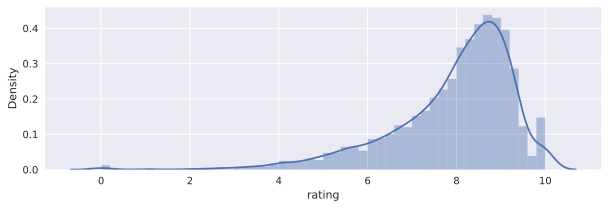

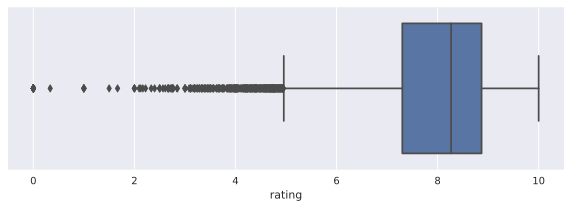

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')
%matplotlib inline
#graphs in svg look clearer
%config InlineBackend.figure_format = 'svg' 

plt.figure(figsize=(10, 3))
sns.distplot(df_pr['rating'])
plt.show()

plt.figure(figsize=(10, 3))
sns.boxplot(df_pr['rating'], orient='h')
plt.show()

In [30]:
df_pr.columns

Index(['age_access_type', 'name', 'type', 'release_year', 'duration',
       'element_uid', 'budget', 'marketing', 'rus', 'USA',
       ...
       'producer_1', 'producer_2', 'producer_3', 'producer_4', 'writer_0',
       'writer_1', 'country_0', 'genre_0', 'genre_1', 'genre_2'],
      dtype='object', length=1040)

In [31]:
df_pr.shape

(8439, 1040)

In [32]:
df_pr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8439 entries, 2 to 10488
Columns: 1040 entries, age_access_type to genre_2
dtypes: float64(7), int64(1002), object(31)
memory usage: 67.3+ MB


## Split

In [40]:
from sklearn.model_selection import train_test_split

sorted_df = df_pr.sort_values('release_year')

test = sorted_df[sorted_df['release_year'] == 2022]
train = sorted_df[sorted_df['release_year'] != 2022]

# for looking at samples
test_df = test.copy(deep=True)
train_df = train.copy(deep=True)

test.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)
train.drop(['release_year', 'element_uid', 'name'], axis=1, inplace=True)

X_test, y_test = test.drop('rating', axis=1), test['rating']
X, y = train.drop('rating', axis=1), train['rating']
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.1, 
                                                  shuffle=False)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape


((7458, 1036), (829, 1036), (152, 1036), (7458,), (829,), (152,))

## Standartization

In [34]:
col_names_scaled = ['duration', 'budget', 'marketing', 'rus', 'USA', 'world']

In [35]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train[col_names_scaled] = sc.fit_transform(X_train[col_names_scaled])
X_val[col_names_scaled] = sc.transform(X_val[col_names_scaled])
X_test[col_names_scaled] = sc.transform(X_test[col_names_scaled])

### Model

In [41]:
import catboost as cat
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from scipy.stats import uniform, randint

In [42]:
train_dataset = cat.Pool(data=X_train,
                        label=y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(data=X_test, 
                        label=y_test,
                         cat_features=cat_features)

val_dataset = cat.Pool(X_val, y_val,
                       cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

cat_model = cat.CatBoostRegressor(**cat_params)

cat_model.fit(
    train_dataset,
    eval_set=val_dataset,
    early_stopping_rounds=500,
    verbose=100,
    plot=False
)

Learning rate set to 0.069807
0:	learn: 1.0037578	test: 1.1380233	best: 1.1380233 (0)	total: 50.4ms	remaining: 50.4s
100:	learn: 0.7228413	test: 0.8855267	best: 0.8852169 (96)	total: 3.85s	remaining: 34.3s
200:	learn: 0.7051142	test: 0.8770512	best: 0.8770512 (200)	total: 7.64s	remaining: 30.4s
300:	learn: 0.6896706	test: 0.8734710	best: 0.8725609 (283)	total: 11.5s	remaining: 26.7s
400:	learn: 0.6765381	test: 0.8704132	best: 0.8702758 (397)	total: 15.3s	remaining: 22.9s
500:	learn: 0.6649426	test: 0.8676944	best: 0.8676350 (494)	total: 19.2s	remaining: 19.1s
600:	learn: 0.6542332	test: 0.8668853	best: 0.8667125 (595)	total: 23.1s	remaining: 15.3s
700:	learn: 0.6437367	test: 0.8660101	best: 0.8657556 (694)	total: 27s	remaining: 11.5s
800:	learn: 0.6333271	test: 0.8642196	best: 0.8642196 (800)	total: 30.9s	remaining: 7.67s
900:	learn: 0.6231467	test: 0.8634063	best: 0.8629826 (870)	total: 34.8s	remaining: 3.82s
999:	learn: 0.6142674	test: 0.8624452	best: 0.8620727 (993)	total: 38.7s	rem

In [43]:
y_pred = cat_model.predict(test_dataset)

In [44]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.278831510502179
RMSE:  1.1308543277107705
R2:    0.3918871283615035
MAE:   0.8129924204448337
MedAE: 0.611596423031382
------------------------------


In [45]:
cat_model.save_model('DEMO_okko_ratings_pred')

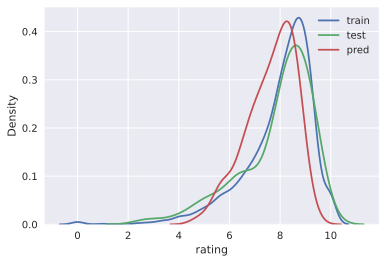

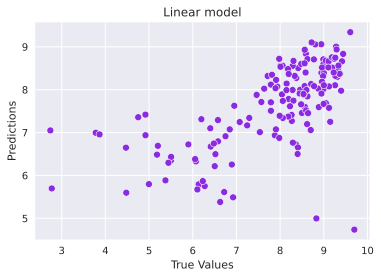

In [46]:
target_distr_linear(y_train, y_test, y_pred)   

IMP: [6.67126341e+00 4.35555098e+00 1.14376761e+01 9.10399265e-01
 1.96615648e-01 9.43163631e-01 1.18104741e+00 1.12237604e+01
 5.48633530e-03 0.00000000e+00 2.01639449e-02 5.36991683e-03
 9.76544725e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.36815890e-02 0.00000000e+00 2.42568116e-02 1.79235206e-03]


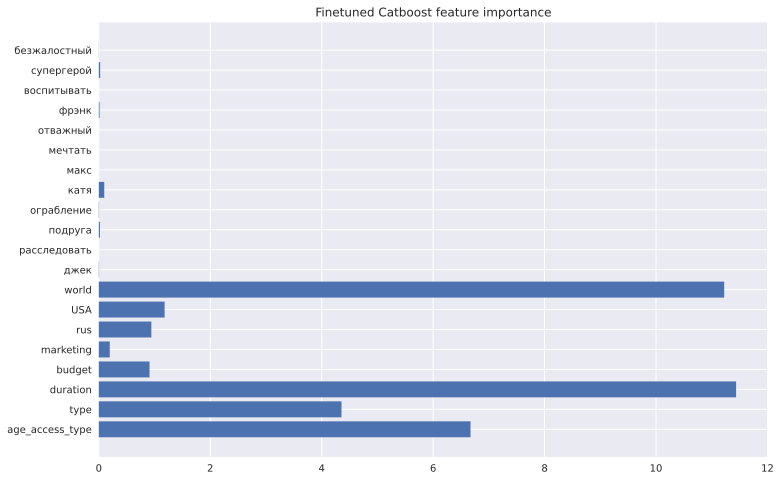

In [47]:
get_feature_imp(cat_model, train_dataset)

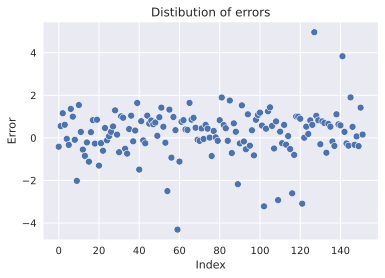

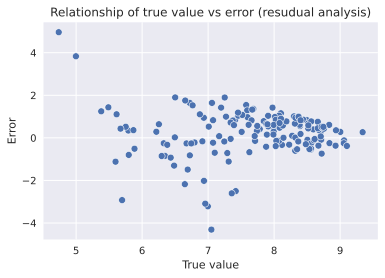

In [48]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

### LOOKING AT TEST

In [49]:
test_df['PREDS'] = y_pred.tolist()
test_df['TARGET'] = y_test.tolist()
test_df

age_access_type                                           name    type  \
10457               18                               Бесконечная ночь  SERIAL   
13                   6                      Пес-самурай и город кошек   MOVIE   
10400               18                               Не оставляй меня  SERIAL   
10399               18                                           Жиза  SERIAL   
4421                16                                  Первая любовь   MOVIE   
...                ...                                            ...     ...   
4630                16                                  Взрывная игра   MOVIE   
10322               18                       На взводе: Битва за UBER  SERIAL   
7698                12                                  Тайна амулета   MOVIE   
10302               18  Власть в ночном городе. Книга четвертая: Сила  SERIAL   
10488                6                                 Истоки футбола  SERIAL   

       release_year   duration                           element_uid  budget  \
10457          2022  16.200597  952bfe32-7504-4ef5-af22-985379d8637f     NaN   
13             2022  15.534700  537ece24-2358-4108-a419-85cfd5952607     NaN   
10400          2022  17.044733  00de4f79-d52d-4d2c-871c-e6e8432cc3df     NaN   
10399          2022  16.751493  4a0406af-66ee-4180-a292-8d3b011b9938     NaN   
4421           2022  15.555977  db683fae-f747-4905-a132-38b4207f82fa     NaN   
...             ...        ...                                   ...     ...   
4630           2022  15.545395  4292d0f1-fbfb-4b4d-8c7c-d54b4b0ef6eb     NaN   
10322          2022  16.064695  fecde143-2a72-4a70-8efc-188079a62f1a     NaN   
7698           2022  15.545395  9ae35927-93e3-4a40-870f-a998abbeaa9f     NaN   
10302          2022  16.495161  2fe0e352-1706-4e22-89d2-745353650492     NaN   
10488          2022  17.518293  6dd86e60-5d6d-475d-9b46-e989ac7a30b6     NaN   

       marketing        rus  USA  ...       producer_3         producer_4  \
10457        NaN        NaN  NaN  ...     Лайонел Юзан         Лоран Анон   
13           NaN        NaN  NaN  ...        Яр Ландау          Адам Нэгл   
10400        NaN        NaN  NaN  ...               Na                 Na   
10399        NaN        NaN  NaN  ...  Евгений Айвазян  Дмитрий Агневский   
4421         NaN        NaN  NaN  ...   Генри Киттридж  Чарльз Артур Берг   
...          ...        ...  ...  ...              ...                ...   
4630         NaN        NaN  NaN  ...     Джордж Фурла        Гари Раскин   
10322        NaN        NaN  NaN  ...         Пол Шифф        Стивен Шифф   
7698         NaN  12.057422  NaN  ...               Na                 Na   
10302        NaN        NaN  NaN  ...     Роберт Мунич       Эль Трайдман   
10488        NaN        NaN  NaN  ...               Na                 Na   

                writer_0           writer_1  country_0  \
10457        Давид Перро   Эммануэль Вуазен    belgium   
13     Роберт Бен Гарант        Нэйт Хоппер        usa   
10400    Леонардо Фазоли  Маддалена Равальи      italy   
10399   Александр Пронин                 Na     russia   
4421       А.Дж. Эдвардс                 Na        usa   
...                  ...                ...        ...   
4630       Леон Лангфорд       Коллин Уоттс        usa   
10322  Брайан Коппельман        Дэвид Левин        usa   
7698   Ксения Набойченко       Ирина Демина     russia   
10302         Аарон Карю        Кортни Кемп        usa   
10488           Ши Чуань                 Na      china   

                                    genre_0  \
10457  9fa28b61-a257-4a3e-945b-a9ef76a146d6   
13                                   Action   
10400  364fdc2e-bdfe-40be-b2c5-d30f43ec432e   
10399                                 Drama   
4421                              Melodrama   
...                                     ...   
4630                               Thriller   
10322                                 Drama   
7698                        

# Tuning

In [50]:
train_dataset = cat.Pool(X_train, 
                         y_train,
                         cat_features=cat_features)

test_dataset = cat.Pool(X_test, 
                        y_test,
                        cat_features=cat_features)

cat_params = {
    'loss_function': 'RMSE',
    'eval_metric': 'MAE',
    'verbose': True,
    'random_seed': 321,
    'allow_writing_files': False, 
    'cat_features': cat_features
}

In [51]:
parameters_distr = {'depth': randint(3, 7),
              'learning_rate': uniform(0.01, 0.1),
              'iterations': [100, 1000, 5000]
             }

cat_model = cat.CatBoostRegressor(**cat_params)
grid = RandomizedSearchCV(estimator=cat_model, param_distributions=parameters_distr, 
                            cv=5,
#                           n_jobs=-1, 
                          verbose=3)

grid.fit(X_train, y_train)

import pickle
with open('bestimator_ratings_kinop', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)
grid.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 1.0469675	total: 31.8ms	remaining: 31.8s
1:	learn: 1.0346774	total: 52.1ms	remaining: 26s
2:	learn: 1.0227775	total: 72.6ms	remaining: 24.1s
3:	learn: 1.0114651	total: 92.4ms	remaining: 23s
4:	learn: 1.0006932	total: 118ms	remaining: 23.4s
5:	learn: 0.9916587	total: 142ms	remaining: 23.4s
6:	learn: 0.9824634	total: 163ms	remaining: 23.2s
7:	learn: 0.9729247	total: 184ms	remaining: 22.8s
8:	learn: 0.9635917	total: 205ms	remaining: 22.5s
9:	learn: 0.9546164	total: 226ms	remaining: 22.3s
10:	learn: 0.9482663	total: 248ms	remaining: 22.3s
11:	learn: 0.9410808	total: 268ms	remaining: 22.1s
12:	learn: 0.9340138	total: 288ms	remaining: 21.9s
13:	learn: 0.9281455	total: 310ms	remaining: 21.8s
14:	learn: 0.9226617	total: 331ms	remaining: 21.7s
15:	learn: 0.9171200	total: 354ms	remaining: 21.8s
16:	learn: 0.9106003	total: 374ms	remaining: 21.6s
17:	learn: 0.9059647	total: 397ms	remaining: 21.6s
18:	learn: 0.9007744	total: 419

166:	learn: 0.7560572	total: 3.64s	remaining: 18.2s
167:	learn: 0.7557828	total: 3.66s	remaining: 18.1s
168:	learn: 0.7556944	total: 3.68s	remaining: 18.1s
169:	learn: 0.7556814	total: 3.7s	remaining: 18.1s
170:	learn: 0.7554857	total: 3.72s	remaining: 18.1s
171:	learn: 0.7552399	total: 3.74s	remaining: 18s
172:	learn: 0.7550693	total: 3.77s	remaining: 18s
173:	learn: 0.7550053	total: 3.79s	remaining: 18s
174:	learn: 0.7548911	total: 3.81s	remaining: 17.9s
175:	learn: 0.7547147	total: 3.83s	remaining: 17.9s
176:	learn: 0.7547060	total: 3.85s	remaining: 17.9s
177:	learn: 0.7546361	total: 3.87s	remaining: 17.9s
178:	learn: 0.7542655	total: 3.89s	remaining: 17.9s
179:	learn: 0.7540112	total: 3.91s	remaining: 17.8s
180:	learn: 0.7539445	total: 3.93s	remaining: 17.8s
181:	learn: 0.7538446	total: 3.95s	remaining: 17.8s
182:	learn: 0.7536576	total: 3.97s	remaining: 17.7s
183:	learn: 0.7536176	total: 3.99s	remaining: 17.7s
184:	learn: 0.7535842	total: 4.01s	remaining: 17.7s
185:	learn: 0.75353

326:	learn: 0.7416217	total: 7.04s	remaining: 14.5s
327:	learn: 0.7416235	total: 7.06s	remaining: 14.5s
328:	learn: 0.7416007	total: 7.08s	remaining: 14.4s
329:	learn: 0.7415406	total: 7.11s	remaining: 14.4s
330:	learn: 0.7414893	total: 7.13s	remaining: 14.4s
331:	learn: 0.7414729	total: 7.15s	remaining: 14.4s
332:	learn: 0.7413175	total: 7.17s	remaining: 14.4s
333:	learn: 0.7412151	total: 7.19s	remaining: 14.3s
334:	learn: 0.7411047	total: 7.21s	remaining: 14.3s
335:	learn: 0.7410527	total: 7.23s	remaining: 14.3s
336:	learn: 0.7409980	total: 7.26s	remaining: 14.3s
337:	learn: 0.7409929	total: 7.28s	remaining: 14.3s
338:	learn: 0.7408791	total: 7.3s	remaining: 14.2s
339:	learn: 0.7408756	total: 7.32s	remaining: 14.2s
340:	learn: 0.7408191	total: 7.34s	remaining: 14.2s
341:	learn: 0.7407511	total: 7.36s	remaining: 14.2s
342:	learn: 0.7406023	total: 7.38s	remaining: 14.1s
343:	learn: 0.7405642	total: 7.4s	remaining: 14.1s
344:	learn: 0.7405629	total: 7.42s	remaining: 14.1s
345:	learn: 0.

486:	learn: 0.7318588	total: 10.4s	remaining: 11s
487:	learn: 0.7318302	total: 10.5s	remaining: 11s
488:	learn: 0.7317930	total: 10.5s	remaining: 10.9s
489:	learn: 0.7317832	total: 10.5s	remaining: 10.9s
490:	learn: 0.7317090	total: 10.5s	remaining: 10.9s
491:	learn: 0.7316572	total: 10.5s	remaining: 10.9s
492:	learn: 0.7316591	total: 10.6s	remaining: 10.9s
493:	learn: 0.7315997	total: 10.6s	remaining: 10.8s
494:	learn: 0.7314931	total: 10.6s	remaining: 10.8s
495:	learn: 0.7314504	total: 10.6s	remaining: 10.8s
496:	learn: 0.7314017	total: 10.6s	remaining: 10.8s
497:	learn: 0.7313473	total: 10.7s	remaining: 10.8s
498:	learn: 0.7313312	total: 10.7s	remaining: 10.7s
499:	learn: 0.7312755	total: 10.7s	remaining: 10.7s
500:	learn: 0.7312451	total: 10.7s	remaining: 10.7s
501:	learn: 0.7312280	total: 10.8s	remaining: 10.7s
502:	learn: 0.7312079	total: 10.8s	remaining: 10.6s
503:	learn: 0.7311640	total: 10.8s	remaining: 10.6s
504:	learn: 0.7310448	total: 10.8s	remaining: 10.6s
505:	learn: 0.73

646:	learn: 0.7224739	total: 13.9s	remaining: 7.56s
647:	learn: 0.7224438	total: 13.9s	remaining: 7.54s
648:	learn: 0.7224014	total: 13.9s	remaining: 7.52s
649:	learn: 0.7223867	total: 13.9s	remaining: 7.5s
650:	learn: 0.7223798	total: 13.9s	remaining: 7.47s
651:	learn: 0.7222741	total: 14s	remaining: 7.45s
652:	learn: 0.7222414	total: 14s	remaining: 7.43s
653:	learn: 0.7220348	total: 14s	remaining: 7.41s
654:	learn: 0.7219680	total: 14s	remaining: 7.39s
655:	learn: 0.7219468	total: 14.1s	remaining: 7.37s
656:	learn: 0.7219251	total: 14.1s	remaining: 7.34s
657:	learn: 0.7218435	total: 14.1s	remaining: 7.32s
658:	learn: 0.7217902	total: 14.1s	remaining: 7.3s
659:	learn: 0.7217724	total: 14.1s	remaining: 7.28s
660:	learn: 0.7217075	total: 14.2s	remaining: 7.26s
661:	learn: 0.7216684	total: 14.2s	remaining: 7.24s
662:	learn: 0.7216386	total: 14.2s	remaining: 7.21s
663:	learn: 0.7215924	total: 14.2s	remaining: 7.19s
664:	learn: 0.7216003	total: 14.2s	remaining: 7.17s
665:	learn: 0.7215502	

807:	learn: 0.7144932	total: 17.2s	remaining: 4.09s
808:	learn: 0.7144610	total: 17.2s	remaining: 4.07s
809:	learn: 0.7143709	total: 17.3s	remaining: 4.05s
810:	learn: 0.7143213	total: 17.3s	remaining: 4.03s
811:	learn: 0.7142995	total: 17.3s	remaining: 4.01s
812:	learn: 0.7142831	total: 17.3s	remaining: 3.98s
813:	learn: 0.7142345	total: 17.3s	remaining: 3.96s
814:	learn: 0.7141988	total: 17.4s	remaining: 3.94s
815:	learn: 0.7142046	total: 17.4s	remaining: 3.92s
816:	learn: 0.7141134	total: 17.4s	remaining: 3.9s
817:	learn: 0.7140378	total: 17.4s	remaining: 3.88s
818:	learn: 0.7139865	total: 17.5s	remaining: 3.86s
819:	learn: 0.7138764	total: 17.5s	remaining: 3.84s
820:	learn: 0.7138256	total: 17.5s	remaining: 3.81s
821:	learn: 0.7138127	total: 17.5s	remaining: 3.79s
822:	learn: 0.7137409	total: 17.5s	remaining: 3.77s
823:	learn: 0.7137026	total: 17.6s	remaining: 3.75s
824:	learn: 0.7136455	total: 17.6s	remaining: 3.73s
825:	learn: 0.7136301	total: 17.6s	remaining: 3.71s
826:	learn: 0

967:	learn: 0.7063920	total: 20.6s	remaining: 681ms
968:	learn: 0.7063898	total: 20.6s	remaining: 660ms
969:	learn: 0.7063799	total: 20.6s	remaining: 638ms
970:	learn: 0.7063318	total: 20.7s	remaining: 617ms
971:	learn: 0.7063206	total: 20.7s	remaining: 596ms
972:	learn: 0.7063109	total: 20.7s	remaining: 575ms
973:	learn: 0.7062744	total: 20.7s	remaining: 553ms
974:	learn: 0.7062066	total: 20.7s	remaining: 532ms
975:	learn: 0.7061128	total: 20.8s	remaining: 511ms
976:	learn: 0.7060795	total: 20.8s	remaining: 489ms
977:	learn: 0.7058556	total: 20.8s	remaining: 468ms
978:	learn: 0.7058219	total: 20.8s	remaining: 447ms
979:	learn: 0.7058104	total: 20.9s	remaining: 426ms
980:	learn: 0.7057588	total: 20.9s	remaining: 404ms
981:	learn: 0.7057039	total: 20.9s	remaining: 383ms
982:	learn: 0.7056606	total: 20.9s	remaining: 362ms
983:	learn: 0.7056215	total: 20.9s	remaining: 340ms
984:	learn: 0.7055823	total: 21s	remaining: 319ms
985:	learn: 0.7055610	total: 21s	remaining: 298ms
986:	learn: 0.70

131:	learn: 0.7562119	total: 2.94s	remaining: 19.3s
132:	learn: 0.7560851	total: 2.96s	remaining: 19.3s
133:	learn: 0.7558652	total: 2.98s	remaining: 19.3s
134:	learn: 0.7555445	total: 3s	remaining: 19.2s
135:	learn: 0.7554772	total: 3.02s	remaining: 19.2s
136:	learn: 0.7552739	total: 3.04s	remaining: 19.2s
137:	learn: 0.7551498	total: 3.06s	remaining: 19.1s
138:	learn: 0.7551013	total: 3.08s	remaining: 19.1s
139:	learn: 0.7549423	total: 3.11s	remaining: 19.1s
140:	learn: 0.7547148	total: 3.13s	remaining: 19.1s
141:	learn: 0.7540205	total: 3.15s	remaining: 19.1s
142:	learn: 0.7539049	total: 3.17s	remaining: 19s
143:	learn: 0.7535937	total: 3.2s	remaining: 19s
144:	learn: 0.7534651	total: 3.22s	remaining: 19s
145:	learn: 0.7533348	total: 3.24s	remaining: 19s
146:	learn: 0.7532017	total: 3.26s	remaining: 18.9s
147:	learn: 0.7527369	total: 3.29s	remaining: 18.9s
148:	learn: 0.7520433	total: 3.31s	remaining: 18.9s
149:	learn: 0.7517485	total: 3.33s	remaining: 18.9s
150:	learn: 0.7515174	to

299:	learn: 0.7349119	total: 6.56s	remaining: 15.3s
300:	learn: 0.7348832	total: 6.58s	remaining: 15.3s
301:	learn: 0.7348464	total: 6.61s	remaining: 15.3s
302:	learn: 0.7347014	total: 6.63s	remaining: 15.2s
303:	learn: 0.7346796	total: 6.65s	remaining: 15.2s
304:	learn: 0.7346591	total: 6.67s	remaining: 15.2s
305:	learn: 0.7346379	total: 6.69s	remaining: 15.2s
306:	learn: 0.7346343	total: 6.71s	remaining: 15.2s
307:	learn: 0.7345785	total: 6.73s	remaining: 15.1s
308:	learn: 0.7345462	total: 6.76s	remaining: 15.1s
309:	learn: 0.7344872	total: 6.78s	remaining: 15.1s
310:	learn: 0.7343411	total: 6.8s	remaining: 15.1s
311:	learn: 0.7341815	total: 6.82s	remaining: 15s
312:	learn: 0.7341253	total: 6.84s	remaining: 15s
313:	learn: 0.7340795	total: 6.86s	remaining: 15s
314:	learn: 0.7340665	total: 6.88s	remaining: 15s
315:	learn: 0.7340369	total: 6.91s	remaining: 14.9s
316:	learn: 0.7339827	total: 6.93s	remaining: 14.9s
317:	learn: 0.7339782	total: 6.95s	remaining: 14.9s
318:	learn: 0.7339281

467:	learn: 0.7238276	total: 10.2s	remaining: 11.6s
468:	learn: 0.7237823	total: 10.2s	remaining: 11.6s
469:	learn: 0.7237690	total: 10.3s	remaining: 11.6s
470:	learn: 0.7237156	total: 10.3s	remaining: 11.5s
471:	learn: 0.7237021	total: 10.3s	remaining: 11.5s
472:	learn: 0.7236628	total: 10.3s	remaining: 11.5s
473:	learn: 0.7236364	total: 10.3s	remaining: 11.5s
474:	learn: 0.7236128	total: 10.4s	remaining: 11.4s
475:	learn: 0.7235072	total: 10.4s	remaining: 11.4s
476:	learn: 0.7234938	total: 10.4s	remaining: 11.4s
477:	learn: 0.7233725	total: 10.4s	remaining: 11.4s
478:	learn: 0.7233520	total: 10.4s	remaining: 11.4s
479:	learn: 0.7233289	total: 10.5s	remaining: 11.3s
480:	learn: 0.7232913	total: 10.5s	remaining: 11.3s
481:	learn: 0.7232322	total: 10.5s	remaining: 11.3s
482:	learn: 0.7231525	total: 10.5s	remaining: 11.3s
483:	learn: 0.7231168	total: 10.6s	remaining: 11.3s
484:	learn: 0.7230639	total: 10.6s	remaining: 11.2s
485:	learn: 0.7230311	total: 10.6s	remaining: 11.2s
486:	learn: 

627:	learn: 0.7148291	total: 13.6s	remaining: 8.07s
628:	learn: 0.7147888	total: 13.6s	remaining: 8.05s
629:	learn: 0.7147504	total: 13.7s	remaining: 8.03s
630:	learn: 0.7147117	total: 13.7s	remaining: 8s
631:	learn: 0.7146823	total: 13.7s	remaining: 7.98s
632:	learn: 0.7145701	total: 13.7s	remaining: 7.96s
633:	learn: 0.7145024	total: 13.8s	remaining: 7.94s
634:	learn: 0.7144024	total: 13.8s	remaining: 7.92s
635:	learn: 0.7143812	total: 13.8s	remaining: 7.9s
636:	learn: 0.7143515	total: 13.8s	remaining: 7.87s
637:	learn: 0.7143019	total: 13.8s	remaining: 7.85s
638:	learn: 0.7142611	total: 13.9s	remaining: 7.83s
639:	learn: 0.7142146	total: 13.9s	remaining: 7.81s
640:	learn: 0.7141231	total: 13.9s	remaining: 7.79s
641:	learn: 0.7140161	total: 13.9s	remaining: 7.76s
642:	learn: 0.7139512	total: 13.9s	remaining: 7.74s
643:	learn: 0.7138889	total: 14s	remaining: 7.72s
644:	learn: 0.7137917	total: 14s	remaining: 7.7s
645:	learn: 0.7137692	total: 14s	remaining: 7.67s
646:	learn: 0.7137339	t

794:	learn: 0.7051865	total: 17.2s	remaining: 4.44s
795:	learn: 0.7050277	total: 17.2s	remaining: 4.42s
796:	learn: 0.7049711	total: 17.3s	remaining: 4.4s
797:	learn: 0.7049528	total: 17.3s	remaining: 4.37s
798:	learn: 0.7049120	total: 17.3s	remaining: 4.35s
799:	learn: 0.7048788	total: 17.3s	remaining: 4.33s
800:	learn: 0.7048141	total: 17.3s	remaining: 4.31s
801:	learn: 0.7047355	total: 17.4s	remaining: 4.29s
802:	learn: 0.7047057	total: 17.4s	remaining: 4.26s
803:	learn: 0.7046854	total: 17.4s	remaining: 4.24s
804:	learn: 0.7046756	total: 17.4s	remaining: 4.22s
805:	learn: 0.7045975	total: 17.4s	remaining: 4.2s
806:	learn: 0.7045278	total: 17.5s	remaining: 4.18s
807:	learn: 0.7045021	total: 17.5s	remaining: 4.16s
808:	learn: 0.7044413	total: 17.5s	remaining: 4.13s
809:	learn: 0.7044176	total: 17.5s	remaining: 4.11s
810:	learn: 0.7043225	total: 17.6s	remaining: 4.09s
811:	learn: 0.7042082	total: 17.6s	remaining: 4.07s
812:	learn: 0.7041533	total: 17.6s	remaining: 4.05s
813:	learn: 0.

960:	learn: 0.6971997	total: 20.8s	remaining: 845ms
961:	learn: 0.6970725	total: 20.8s	remaining: 824ms
962:	learn: 0.6970401	total: 20.9s	remaining: 802ms
963:	learn: 0.6969856	total: 20.9s	remaining: 780ms
964:	learn: 0.6969231	total: 20.9s	remaining: 759ms
965:	learn: 0.6968200	total: 20.9s	remaining: 737ms
966:	learn: 0.6967536	total: 21s	remaining: 716ms
967:	learn: 0.6967198	total: 21s	remaining: 694ms
968:	learn: 0.6966804	total: 21s	remaining: 672ms
969:	learn: 0.6965326	total: 21s	remaining: 651ms
970:	learn: 0.6964772	total: 21.1s	remaining: 629ms
971:	learn: 0.6964627	total: 21.1s	remaining: 607ms
972:	learn: 0.6964216	total: 21.1s	remaining: 586ms
973:	learn: 0.6964007	total: 21.1s	remaining: 564ms
974:	learn: 0.6963124	total: 21.1s	remaining: 542ms
975:	learn: 0.6962616	total: 21.2s	remaining: 521ms
976:	learn: 0.6962311	total: 21.2s	remaining: 499ms
977:	learn: 0.6962186	total: 21.2s	remaining: 477ms
978:	learn: 0.6961647	total: 21.2s	remaining: 456ms
979:	learn: 0.696163

124:	learn: 0.7629101	total: 2.77s	remaining: 19.4s
125:	learn: 0.7625302	total: 2.79s	remaining: 19.4s
126:	learn: 0.7625003	total: 2.81s	remaining: 19.4s
127:	learn: 0.7622243	total: 2.84s	remaining: 19.4s
128:	learn: 0.7618620	total: 2.86s	remaining: 19.3s
129:	learn: 0.7617752	total: 2.88s	remaining: 19.3s
130:	learn: 0.7615277	total: 2.9s	remaining: 19.3s
131:	learn: 0.7613185	total: 2.93s	remaining: 19.2s
132:	learn: 0.7609171	total: 2.95s	remaining: 19.2s
133:	learn: 0.7608177	total: 2.97s	remaining: 19.2s
134:	learn: 0.7606223	total: 2.99s	remaining: 19.2s
135:	learn: 0.7606098	total: 3.01s	remaining: 19.1s
136:	learn: 0.7603414	total: 3.03s	remaining: 19.1s
137:	learn: 0.7599712	total: 3.06s	remaining: 19.1s
138:	learn: 0.7597137	total: 3.08s	remaining: 19.1s
139:	learn: 0.7595147	total: 3.1s	remaining: 19s
140:	learn: 0.7594723	total: 3.12s	remaining: 19s
141:	learn: 0.7587727	total: 3.15s	remaining: 19s
142:	learn: 0.7585880	total: 3.17s	remaining: 19s
143:	learn: 0.7584287	

292:	learn: 0.7414854	total: 6.34s	remaining: 15.3s
293:	learn: 0.7414531	total: 6.37s	remaining: 15.3s
294:	learn: 0.7413066	total: 6.39s	remaining: 15.3s
295:	learn: 0.7412176	total: 6.41s	remaining: 15.2s
296:	learn: 0.7411797	total: 6.43s	remaining: 15.2s
297:	learn: 0.7411427	total: 6.45s	remaining: 15.2s
298:	learn: 0.7411196	total: 6.47s	remaining: 15.2s
299:	learn: 0.7410823	total: 6.49s	remaining: 15.2s
300:	learn: 0.7410211	total: 6.52s	remaining: 15.1s
301:	learn: 0.7410075	total: 6.54s	remaining: 15.1s
302:	learn: 0.7409767	total: 6.56s	remaining: 15.1s
303:	learn: 0.7408327	total: 6.58s	remaining: 15.1s
304:	learn: 0.7406684	total: 6.6s	remaining: 15s
305:	learn: 0.7406352	total: 6.62s	remaining: 15s
306:	learn: 0.7406243	total: 6.64s	remaining: 15s
307:	learn: 0.7405879	total: 6.66s	remaining: 15s
308:	learn: 0.7404828	total: 6.68s	remaining: 14.9s
309:	learn: 0.7404663	total: 6.71s	remaining: 14.9s
310:	learn: 0.7403599	total: 6.73s	remaining: 14.9s
311:	learn: 0.7402180

451:	learn: 0.7295919	total: 9.76s	remaining: 11.8s
452:	learn: 0.7295557	total: 9.79s	remaining: 11.8s
453:	learn: 0.7294792	total: 9.81s	remaining: 11.8s
454:	learn: 0.7293333	total: 9.83s	remaining: 11.8s
455:	learn: 0.7292786	total: 9.85s	remaining: 11.8s
456:	learn: 0.7292750	total: 9.87s	remaining: 11.7s
457:	learn: 0.7291707	total: 9.89s	remaining: 11.7s
458:	learn: 0.7291329	total: 9.91s	remaining: 11.7s
459:	learn: 0.7290551	total: 9.93s	remaining: 11.7s
460:	learn: 0.7290125	total: 9.96s	remaining: 11.6s
461:	learn: 0.7288993	total: 9.98s	remaining: 11.6s
462:	learn: 0.7287949	total: 10s	remaining: 11.6s
463:	learn: 0.7287827	total: 10s	remaining: 11.6s
464:	learn: 0.7287335	total: 10s	remaining: 11.6s
465:	learn: 0.7287182	total: 10.1s	remaining: 11.5s
466:	learn: 0.7287137	total: 10.1s	remaining: 11.5s
467:	learn: 0.7286828	total: 10.1s	remaining: 11.5s
468:	learn: 0.7286313	total: 10.1s	remaining: 11.5s
469:	learn: 0.7285996	total: 10.2s	remaining: 11.4s
470:	learn: 0.7284

616:	learn: 0.7203029	total: 13.4s	remaining: 8.3s
617:	learn: 0.7202391	total: 13.4s	remaining: 8.28s
618:	learn: 0.7202196	total: 13.4s	remaining: 8.26s
619:	learn: 0.7201548	total: 13.4s	remaining: 8.24s
620:	learn: 0.7201165	total: 13.5s	remaining: 8.22s
621:	learn: 0.7200445	total: 13.5s	remaining: 8.2s
622:	learn: 0.7200002	total: 13.5s	remaining: 8.17s
623:	learn: 0.7199840	total: 13.5s	remaining: 8.15s
624:	learn: 0.7199607	total: 13.5s	remaining: 8.13s
625:	learn: 0.7199575	total: 13.6s	remaining: 8.11s
626:	learn: 0.7198812	total: 13.6s	remaining: 8.08s
627:	learn: 0.7198271	total: 13.6s	remaining: 8.06s
628:	learn: 0.7197825	total: 13.6s	remaining: 8.04s
629:	learn: 0.7197247	total: 13.7s	remaining: 8.02s
630:	learn: 0.7197132	total: 13.7s	remaining: 8s
631:	learn: 0.7196623	total: 13.7s	remaining: 7.98s
632:	learn: 0.7196562	total: 13.7s	remaining: 7.96s
633:	learn: 0.7196391	total: 13.7s	remaining: 7.93s
634:	learn: 0.7195570	total: 13.8s	remaining: 7.91s
635:	learn: 0.719

775:	learn: 0.7133099	total: 16.8s	remaining: 4.85s
776:	learn: 0.7132817	total: 16.8s	remaining: 4.83s
777:	learn: 0.7132275	total: 16.9s	remaining: 4.81s
778:	learn: 0.7131943	total: 16.9s	remaining: 4.79s
779:	learn: 0.7131677	total: 16.9s	remaining: 4.76s
780:	learn: 0.7131658	total: 16.9s	remaining: 4.74s
781:	learn: 0.7131162	total: 16.9s	remaining: 4.72s
782:	learn: 0.7130611	total: 17s	remaining: 4.7s
783:	learn: 0.7130410	total: 17s	remaining: 4.68s
784:	learn: 0.7129929	total: 17s	remaining: 4.66s
785:	learn: 0.7129661	total: 17s	remaining: 4.63s
786:	learn: 0.7129037	total: 17s	remaining: 4.61s
787:	learn: 0.7128936	total: 17.1s	remaining: 4.59s
788:	learn: 0.7128755	total: 17.1s	remaining: 4.57s
789:	learn: 0.7128341	total: 17.1s	remaining: 4.55s
790:	learn: 0.7128249	total: 17.1s	remaining: 4.52s
791:	learn: 0.7128210	total: 17.1s	remaining: 4.5s
792:	learn: 0.7128075	total: 17.2s	remaining: 4.48s
793:	learn: 0.7127540	total: 17.2s	remaining: 4.46s
794:	learn: 0.7127291	to

934:	learn: 0.7065899	total: 20.2s	remaining: 1.41s
935:	learn: 0.7065650	total: 20.2s	remaining: 1.38s
936:	learn: 0.7065359	total: 20.3s	remaining: 1.36s
937:	learn: 0.7064604	total: 20.3s	remaining: 1.34s
938:	learn: 0.7064318	total: 20.3s	remaining: 1.32s
939:	learn: 0.7063403	total: 20.3s	remaining: 1.3s
940:	learn: 0.7063178	total: 20.3s	remaining: 1.27s
941:	learn: 0.7061510	total: 20.4s	remaining: 1.25s
942:	learn: 0.7061188	total: 20.4s	remaining: 1.23s
943:	learn: 0.7061076	total: 20.4s	remaining: 1.21s
944:	learn: 0.7060727	total: 20.4s	remaining: 1.19s
945:	learn: 0.7060668	total: 20.5s	remaining: 1.17s
946:	learn: 0.7060580	total: 20.5s	remaining: 1.15s
947:	learn: 0.7059888	total: 20.5s	remaining: 1.12s
948:	learn: 0.7059386	total: 20.5s	remaining: 1.1s
949:	learn: 0.7059106	total: 20.5s	remaining: 1.08s
950:	learn: 0.7058964	total: 20.6s	remaining: 1.06s
951:	learn: 0.7057679	total: 20.6s	remaining: 1.04s
952:	learn: 0.7057466	total: 20.6s	remaining: 1.01s
953:	learn: 0.

98:	learn: 0.7497241	total: 2.17s	remaining: 19.7s
99:	learn: 0.7492672	total: 2.19s	remaining: 19.7s
100:	learn: 0.7486476	total: 2.21s	remaining: 19.7s
101:	learn: 0.7484126	total: 2.23s	remaining: 19.6s
102:	learn: 0.7481612	total: 2.25s	remaining: 19.6s
103:	learn: 0.7479676	total: 2.27s	remaining: 19.6s
104:	learn: 0.7476105	total: 2.29s	remaining: 19.5s
105:	learn: 0.7474613	total: 2.31s	remaining: 19.5s
106:	learn: 0.7472033	total: 2.33s	remaining: 19.5s
107:	learn: 0.7468557	total: 2.36s	remaining: 19.5s
108:	learn: 0.7465507	total: 2.38s	remaining: 19.5s
109:	learn: 0.7461278	total: 2.4s	remaining: 19.5s
110:	learn: 0.7456726	total: 2.43s	remaining: 19.4s
111:	learn: 0.7454366	total: 2.45s	remaining: 19.4s
112:	learn: 0.7450031	total: 2.47s	remaining: 19.4s
113:	learn: 0.7445734	total: 2.49s	remaining: 19.4s
114:	learn: 0.7442656	total: 2.51s	remaining: 19.3s
115:	learn: 0.7441480	total: 2.54s	remaining: 19.3s
116:	learn: 0.7438109	total: 2.56s	remaining: 19.3s
117:	learn: 0.7

266:	learn: 0.7239270	total: 5.8s	remaining: 15.9s
267:	learn: 0.7239319	total: 5.83s	remaining: 15.9s
268:	learn: 0.7239026	total: 5.85s	remaining: 15.9s
269:	learn: 0.7238533	total: 5.87s	remaining: 15.9s
270:	learn: 0.7238083	total: 5.89s	remaining: 15.8s
271:	learn: 0.7237573	total: 5.91s	remaining: 15.8s
272:	learn: 0.7237280	total: 5.94s	remaining: 15.8s
273:	learn: 0.7235909	total: 5.96s	remaining: 15.8s
274:	learn: 0.7235593	total: 5.98s	remaining: 15.8s
275:	learn: 0.7235322	total: 6s	remaining: 15.7s
276:	learn: 0.7233794	total: 6.02s	remaining: 15.7s
277:	learn: 0.7232790	total: 6.04s	remaining: 15.7s
278:	learn: 0.7232400	total: 6.06s	remaining: 15.7s
279:	learn: 0.7231952	total: 6.08s	remaining: 15.6s
280:	learn: 0.7231590	total: 6.11s	remaining: 15.6s
281:	learn: 0.7230362	total: 6.13s	remaining: 15.6s
282:	learn: 0.7230154	total: 6.15s	remaining: 15.6s
283:	learn: 0.7228115	total: 6.17s	remaining: 15.6s
284:	learn: 0.7227581	total: 6.19s	remaining: 15.5s
285:	learn: 0.72

434:	learn: 0.7117501	total: 9.44s	remaining: 12.3s
435:	learn: 0.7117210	total: 9.46s	remaining: 12.2s
436:	learn: 0.7117240	total: 9.48s	remaining: 12.2s
437:	learn: 0.7116579	total: 9.51s	remaining: 12.2s
438:	learn: 0.7116115	total: 9.53s	remaining: 12.2s
439:	learn: 0.7115554	total: 9.56s	remaining: 12.2s
440:	learn: 0.7115025	total: 9.58s	remaining: 12.1s
441:	learn: 0.7114405	total: 9.6s	remaining: 12.1s
442:	learn: 0.7114416	total: 9.62s	remaining: 12.1s
443:	learn: 0.7113981	total: 9.64s	remaining: 12.1s
444:	learn: 0.7112890	total: 9.66s	remaining: 12.1s
445:	learn: 0.7112097	total: 9.69s	remaining: 12s
446:	learn: 0.7110544	total: 9.71s	remaining: 12s
447:	learn: 0.7110187	total: 9.73s	remaining: 12s
448:	learn: 0.7109756	total: 9.75s	remaining: 12s
449:	learn: 0.7108877	total: 9.78s	remaining: 11.9s
450:	learn: 0.7108453	total: 9.8s	remaining: 11.9s
451:	learn: 0.7108093	total: 9.82s	remaining: 11.9s
452:	learn: 0.7107783	total: 9.84s	remaining: 11.9s
453:	learn: 0.7107371	

598:	learn: 0.7029602	total: 13s	remaining: 8.71s
599:	learn: 0.7029323	total: 13s	remaining: 8.68s
600:	learn: 0.7028952	total: 13s	remaining: 8.66s
601:	learn: 0.7028719	total: 13.1s	remaining: 8.64s
602:	learn: 0.7027673	total: 13.1s	remaining: 8.62s
603:	learn: 0.7027578	total: 13.1s	remaining: 8.6s
604:	learn: 0.7027371	total: 13.1s	remaining: 8.58s
605:	learn: 0.7026639	total: 13.2s	remaining: 8.55s
606:	learn: 0.7025843	total: 13.2s	remaining: 8.53s
607:	learn: 0.7025146	total: 13.2s	remaining: 8.51s
608:	learn: 0.7024746	total: 13.2s	remaining: 8.49s
609:	learn: 0.7024479	total: 13.2s	remaining: 8.47s
610:	learn: 0.7023421	total: 13.3s	remaining: 8.44s
611:	learn: 0.7023210	total: 13.3s	remaining: 8.42s
612:	learn: 0.7022276	total: 13.3s	remaining: 8.4s
613:	learn: 0.7021973	total: 13.3s	remaining: 8.38s
614:	learn: 0.7021833	total: 13.3s	remaining: 8.36s
615:	learn: 0.7021527	total: 13.4s	remaining: 8.33s
616:	learn: 0.7021367	total: 13.4s	remaining: 8.31s
617:	learn: 0.702018

757:	learn: 0.6952595	total: 16.4s	remaining: 5.24s
758:	learn: 0.6952521	total: 16.4s	remaining: 5.22s
759:	learn: 0.6952181	total: 16.5s	remaining: 5.2s
760:	learn: 0.6952071	total: 16.5s	remaining: 5.18s
761:	learn: 0.6951791	total: 16.5s	remaining: 5.16s
762:	learn: 0.6951452	total: 16.5s	remaining: 5.13s
763:	learn: 0.6950744	total: 16.6s	remaining: 5.11s
764:	learn: 0.6950449	total: 16.6s	remaining: 5.09s
765:	learn: 0.6949941	total: 16.6s	remaining: 5.07s
766:	learn: 0.6949717	total: 16.6s	remaining: 5.05s
767:	learn: 0.6948989	total: 16.6s	remaining: 5.02s
768:	learn: 0.6948840	total: 16.7s	remaining: 5s
769:	learn: 0.6948547	total: 16.7s	remaining: 4.98s
770:	learn: 0.6948438	total: 16.7s	remaining: 4.96s
771:	learn: 0.6948165	total: 16.7s	remaining: 4.93s
772:	learn: 0.6947617	total: 16.7s	remaining: 4.91s
773:	learn: 0.6947166	total: 16.8s	remaining: 4.89s
774:	learn: 0.6946834	total: 16.8s	remaining: 4.87s
775:	learn: 0.6946642	total: 16.8s	remaining: 4.85s
776:	learn: 0.69

925:	learn: 0.6874173	total: 20s	remaining: 1.6s
926:	learn: 0.6873525	total: 20s	remaining: 1.58s
927:	learn: 0.6873102	total: 20s	remaining: 1.55s
928:	learn: 0.6872838	total: 20.1s	remaining: 1.53s
929:	learn: 0.6872625	total: 20.1s	remaining: 1.51s
930:	learn: 0.6872258	total: 20.1s	remaining: 1.49s
931:	learn: 0.6871455	total: 20.1s	remaining: 1.47s
932:	learn: 0.6870859	total: 20.1s	remaining: 1.45s
933:	learn: 0.6870316	total: 20.2s	remaining: 1.42s
934:	learn: 0.6869913	total: 20.2s	remaining: 1.4s
935:	learn: 0.6869791	total: 20.2s	remaining: 1.38s
936:	learn: 0.6869142	total: 20.2s	remaining: 1.36s
937:	learn: 0.6868984	total: 20.2s	remaining: 1.34s
938:	learn: 0.6868670	total: 20.3s	remaining: 1.32s
939:	learn: 0.6868440	total: 20.3s	remaining: 1.29s
940:	learn: 0.6868273	total: 20.3s	remaining: 1.27s
941:	learn: 0.6868057	total: 20.3s	remaining: 1.25s
942:	learn: 0.6867857	total: 20.4s	remaining: 1.23s
943:	learn: 0.6867557	total: 20.4s	remaining: 1.21s
944:	learn: 0.686751

89:	learn: 0.7411959	total: 1.97s	remaining: 20s
90:	learn: 0.7405094	total: 2s	remaining: 19.9s
91:	learn: 0.7401517	total: 2.02s	remaining: 19.9s
92:	learn: 0.7394133	total: 2.04s	remaining: 19.9s
93:	learn: 0.7388335	total: 2.06s	remaining: 19.9s
94:	learn: 0.7384309	total: 2.08s	remaining: 19.9s
95:	learn: 0.7380815	total: 2.11s	remaining: 19.8s
96:	learn: 0.7372788	total: 2.13s	remaining: 19.8s
97:	learn: 0.7367106	total: 2.15s	remaining: 19.8s
98:	learn: 0.7361640	total: 2.18s	remaining: 19.8s
99:	learn: 0.7357378	total: 2.2s	remaining: 19.8s
100:	learn: 0.7352285	total: 2.22s	remaining: 19.8s
101:	learn: 0.7349150	total: 2.25s	remaining: 19.8s
102:	learn: 0.7346252	total: 2.27s	remaining: 19.8s
103:	learn: 0.7342209	total: 2.29s	remaining: 19.8s
104:	learn: 0.7339470	total: 2.31s	remaining: 19.7s
105:	learn: 0.7335303	total: 2.33s	remaining: 19.7s
106:	learn: 0.7331405	total: 2.35s	remaining: 19.7s
107:	learn: 0.7327048	total: 2.38s	remaining: 19.6s
108:	learn: 0.7322426	total: 

255:	learn: 0.7111936	total: 5.61s	remaining: 16.3s
256:	learn: 0.7111230	total: 5.63s	remaining: 16.3s
257:	learn: 0.7110919	total: 5.65s	remaining: 16.3s
258:	learn: 0.7110806	total: 5.68s	remaining: 16.2s
259:	learn: 0.7110294	total: 5.7s	remaining: 16.2s
260:	learn: 0.7109495	total: 5.72s	remaining: 16.2s
261:	learn: 0.7109032	total: 5.74s	remaining: 16.2s
262:	learn: 0.7108159	total: 5.77s	remaining: 16.2s
263:	learn: 0.7107391	total: 5.79s	remaining: 16.1s
264:	learn: 0.7106194	total: 5.81s	remaining: 16.1s
265:	learn: 0.7105738	total: 5.84s	remaining: 16.1s
266:	learn: 0.7105069	total: 5.86s	remaining: 16.1s
267:	learn: 0.7104841	total: 5.88s	remaining: 16.1s
268:	learn: 0.7103563	total: 5.9s	remaining: 16s
269:	learn: 0.7103138	total: 5.92s	remaining: 16s
270:	learn: 0.7102862	total: 5.94s	remaining: 16s
271:	learn: 0.7102407	total: 5.97s	remaining: 16s
272:	learn: 0.7101525	total: 5.99s	remaining: 15.9s
273:	learn: 0.7100408	total: 6.01s	remaining: 15.9s
274:	learn: 0.7100184	

422:	learn: 0.6995674	total: 9.17s	remaining: 12.5s
423:	learn: 0.6995585	total: 9.19s	remaining: 12.5s
424:	learn: 0.6994833	total: 9.21s	remaining: 12.5s
425:	learn: 0.6994210	total: 9.23s	remaining: 12.4s
426:	learn: 0.6993999	total: 9.25s	remaining: 12.4s
427:	learn: 0.6992639	total: 9.27s	remaining: 12.4s
428:	learn: 0.6992303	total: 9.3s	remaining: 12.4s
429:	learn: 0.6991893	total: 9.32s	remaining: 12.3s
430:	learn: 0.6991699	total: 9.34s	remaining: 12.3s
431:	learn: 0.6991265	total: 9.36s	remaining: 12.3s
432:	learn: 0.6991016	total: 9.38s	remaining: 12.3s
433:	learn: 0.6990539	total: 9.4s	remaining: 12.3s
434:	learn: 0.6989903	total: 9.42s	remaining: 12.2s
435:	learn: 0.6989543	total: 9.44s	remaining: 12.2s
436:	learn: 0.6988636	total: 9.46s	remaining: 12.2s
437:	learn: 0.6988100	total: 9.48s	remaining: 12.2s
438:	learn: 0.6987741	total: 9.5s	remaining: 12.1s
439:	learn: 0.6987166	total: 9.52s	remaining: 12.1s
440:	learn: 0.6986891	total: 9.54s	remaining: 12.1s
441:	learn: 0.6

581:	learn: 0.6891010	total: 12.5s	remaining: 8.97s
582:	learn: 0.6890118	total: 12.5s	remaining: 8.95s
583:	learn: 0.6889871	total: 12.5s	remaining: 8.93s
584:	learn: 0.6889486	total: 12.5s	remaining: 8.9s
585:	learn: 0.6889169	total: 12.6s	remaining: 8.88s
586:	learn: 0.6888936	total: 12.6s	remaining: 8.86s
587:	learn: 0.6888828	total: 12.6s	remaining: 8.83s
588:	learn: 0.6888634	total: 12.6s	remaining: 8.81s
589:	learn: 0.6888254	total: 12.6s	remaining: 8.79s
590:	learn: 0.6887471	total: 12.7s	remaining: 8.77s
591:	learn: 0.6887006	total: 12.7s	remaining: 8.75s
592:	learn: 0.6886761	total: 12.7s	remaining: 8.72s
593:	learn: 0.6886287	total: 12.7s	remaining: 8.71s
594:	learn: 0.6885324	total: 12.8s	remaining: 8.68s
595:	learn: 0.6884278	total: 12.8s	remaining: 8.66s
596:	learn: 0.6883664	total: 12.8s	remaining: 8.64s
597:	learn: 0.6881997	total: 12.8s	remaining: 8.62s
598:	learn: 0.6881751	total: 12.8s	remaining: 8.6s
599:	learn: 0.6881179	total: 12.9s	remaining: 8.57s
600:	learn: 0.

742:	learn: 0.6810489	total: 15.9s	remaining: 5.49s
743:	learn: 0.6810318	total: 15.9s	remaining: 5.47s
744:	learn: 0.6809889	total: 15.9s	remaining: 5.45s
745:	learn: 0.6809221	total: 15.9s	remaining: 5.42s
746:	learn: 0.6808706	total: 16s	remaining: 5.4s
747:	learn: 0.6807867	total: 16s	remaining: 5.38s
748:	learn: 0.6807244	total: 16s	remaining: 5.36s
749:	learn: 0.6807044	total: 16s	remaining: 5.34s
750:	learn: 0.6806943	total: 16s	remaining: 5.32s
751:	learn: 0.6805805	total: 16.1s	remaining: 5.29s
752:	learn: 0.6805247	total: 16.1s	remaining: 5.27s
753:	learn: 0.6805116	total: 16.1s	remaining: 5.25s
754:	learn: 0.6804719	total: 16.1s	remaining: 5.23s
755:	learn: 0.6804345	total: 16.1s	remaining: 5.21s
756:	learn: 0.6804172	total: 16.2s	remaining: 5.19s
757:	learn: 0.6803498	total: 16.2s	remaining: 5.17s
758:	learn: 0.6802135	total: 16.2s	remaining: 5.14s
759:	learn: 0.6801295	total: 16.2s	remaining: 5.12s
760:	learn: 0.6801020	total: 16.2s	remaining: 5.1s
761:	learn: 0.6800787	to

902:	learn: 0.6735055	total: 19.2s	remaining: 2.06s
903:	learn: 0.6734683	total: 19.2s	remaining: 2.04s
904:	learn: 0.6734325	total: 19.3s	remaining: 2.02s
905:	learn: 0.6733983	total: 19.3s	remaining: 2s
906:	learn: 0.6733859	total: 19.3s	remaining: 1.98s
907:	learn: 0.6732633	total: 19.3s	remaining: 1.96s
908:	learn: 0.6732469	total: 19.4s	remaining: 1.94s
909:	learn: 0.6732071	total: 19.4s	remaining: 1.92s
910:	learn: 0.6731257	total: 19.4s	remaining: 1.89s
911:	learn: 0.6731047	total: 19.4s	remaining: 1.87s
912:	learn: 0.6730807	total: 19.4s	remaining: 1.85s
913:	learn: 0.6730714	total: 19.5s	remaining: 1.83s
914:	learn: 0.6730127	total: 19.5s	remaining: 1.81s
915:	learn: 0.6729961	total: 19.5s	remaining: 1.79s
916:	learn: 0.6729713	total: 19.5s	remaining: 1.77s
917:	learn: 0.6729598	total: 19.5s	remaining: 1.75s
918:	learn: 0.6729115	total: 19.6s	remaining: 1.72s
919:	learn: 0.6729052	total: 19.6s	remaining: 1.7s
920:	learn: 0.6728576	total: 19.6s	remaining: 1.68s
921:	learn: 0.67

70:	learn: 0.7689157	total: 623ms	remaining: 254ms
71:	learn: 0.7682133	total: 631ms	remaining: 245ms
72:	learn: 0.7676925	total: 639ms	remaining: 236ms
73:	learn: 0.7673431	total: 647ms	remaining: 227ms
74:	learn: 0.7669816	total: 655ms	remaining: 218ms
75:	learn: 0.7667219	total: 663ms	remaining: 210ms
76:	learn: 0.7660091	total: 671ms	remaining: 201ms
77:	learn: 0.7655608	total: 680ms	remaining: 192ms
78:	learn: 0.7650504	total: 688ms	remaining: 183ms
79:	learn: 0.7645417	total: 696ms	remaining: 174ms
80:	learn: 0.7637622	total: 704ms	remaining: 165ms
81:	learn: 0.7633807	total: 712ms	remaining: 156ms
82:	learn: 0.7632027	total: 721ms	remaining: 148ms
83:	learn: 0.7628703	total: 729ms	remaining: 139ms
84:	learn: 0.7625384	total: 737ms	remaining: 130ms
85:	learn: 0.7623338	total: 745ms	remaining: 121ms
86:	learn: 0.7616362	total: 753ms	remaining: 113ms
87:	learn: 0.7611573	total: 761ms	remaining: 104ms
88:	learn: 0.7609717	total: 769ms	remaining: 95.1ms
89:	learn: 0.7607932	total: 77

45:	learn: 0.7943053	total: 415ms	remaining: 487ms
46:	learn: 0.7935161	total: 423ms	remaining: 477ms
47:	learn: 0.7924455	total: 431ms	remaining: 467ms
48:	learn: 0.7915219	total: 440ms	remaining: 457ms
49:	learn: 0.7904684	total: 449ms	remaining: 449ms
50:	learn: 0.7886517	total: 457ms	remaining: 439ms
51:	learn: 0.7872677	total: 466ms	remaining: 430ms
52:	learn: 0.7861037	total: 476ms	remaining: 422ms
53:	learn: 0.7852591	total: 484ms	remaining: 412ms
54:	learn: 0.7843199	total: 493ms	remaining: 403ms
55:	learn: 0.7833194	total: 502ms	remaining: 394ms
56:	learn: 0.7820727	total: 510ms	remaining: 385ms
57:	learn: 0.7810604	total: 518ms	remaining: 375ms
58:	learn: 0.7804595	total: 527ms	remaining: 366ms
59:	learn: 0.7799789	total: 535ms	remaining: 357ms
60:	learn: 0.7789854	total: 543ms	remaining: 347ms
61:	learn: 0.7779483	total: 551ms	remaining: 338ms
62:	learn: 0.7771580	total: 561ms	remaining: 329ms
63:	learn: 0.7760325	total: 569ms	remaining: 320ms
64:	learn: 0.7753796	total: 578

2:	learn: 0.9275020	total: 33.5ms	remaining: 1.08s
3:	learn: 0.9155647	total: 46ms	remaining: 1.1s
4:	learn: 0.9046126	total: 54.2ms	remaining: 1.03s
5:	learn: 0.8946170	total: 62.4ms	remaining: 978ms
6:	learn: 0.8859463	total: 70.6ms	remaining: 938ms
7:	learn: 0.8770649	total: 78.9ms	remaining: 907ms
8:	learn: 0.8691705	total: 87.1ms	remaining: 880ms
9:	learn: 0.8625861	total: 95.4ms	remaining: 859ms
10:	learn: 0.8558970	total: 104ms	remaining: 841ms
11:	learn: 0.8492302	total: 114ms	remaining: 837ms
12:	learn: 0.8424731	total: 124ms	remaining: 828ms
13:	learn: 0.8370462	total: 132ms	remaining: 812ms
14:	learn: 0.8305283	total: 142ms	remaining: 807ms
15:	learn: 0.8259042	total: 151ms	remaining: 791ms
16:	learn: 0.8216480	total: 159ms	remaining: 775ms
17:	learn: 0.8179246	total: 168ms	remaining: 765ms
18:	learn: 0.8139828	total: 178ms	remaining: 758ms
19:	learn: 0.8107206	total: 187ms	remaining: 747ms
20:	learn: 0.8072087	total: 196ms	remaining: 738ms
21:	learn: 0.8048050	total: 207ms	

79:	learn: 0.8056117	total: 830ms	remaining: 207ms
80:	learn: 0.8045567	total: 840ms	remaining: 197ms
81:	learn: 0.8037160	total: 849ms	remaining: 186ms
82:	learn: 0.8026621	total: 859ms	remaining: 176ms
83:	learn: 0.8019667	total: 871ms	remaining: 166ms
84:	learn: 0.8011966	total: 881ms	remaining: 155ms
85:	learn: 0.8002649	total: 891ms	remaining: 145ms
86:	learn: 0.7993170	total: 901ms	remaining: 135ms
87:	learn: 0.7985276	total: 910ms	remaining: 124ms
88:	learn: 0.7975638	total: 920ms	remaining: 114ms
89:	learn: 0.7966236	total: 930ms	remaining: 103ms
90:	learn: 0.7955043	total: 939ms	remaining: 92.9ms
91:	learn: 0.7949944	total: 949ms	remaining: 82.5ms
92:	learn: 0.7941070	total: 959ms	remaining: 72.2ms
93:	learn: 0.7934033	total: 969ms	remaining: 61.8ms
94:	learn: 0.7927655	total: 979ms	remaining: 51.5ms
95:	learn: 0.7919404	total: 989ms	remaining: 41.2ms
96:	learn: 0.7913358	total: 999ms	remaining: 30.9ms
97:	learn: 0.7905041	total: 1.01s	remaining: 20.6ms
98:	learn: 0.7900660	to

42:	learn: 0.8589738	total: 449ms	remaining: 595ms
43:	learn: 0.8573624	total: 458ms	remaining: 583ms
44:	learn: 0.8547389	total: 468ms	remaining: 573ms
45:	learn: 0.8524442	total: 478ms	remaining: 561ms
46:	learn: 0.8507367	total: 488ms	remaining: 551ms
47:	learn: 0.8485087	total: 498ms	remaining: 540ms
48:	learn: 0.8467698	total: 508ms	remaining: 529ms
49:	learn: 0.8448694	total: 518ms	remaining: 518ms
50:	learn: 0.8432930	total: 528ms	remaining: 507ms
51:	learn: 0.8413211	total: 539ms	remaining: 497ms
52:	learn: 0.8395428	total: 549ms	remaining: 487ms
53:	learn: 0.8378306	total: 559ms	remaining: 476ms
54:	learn: 0.8364710	total: 569ms	remaining: 465ms
55:	learn: 0.8345054	total: 579ms	remaining: 455ms
56:	learn: 0.8326270	total: 589ms	remaining: 444ms
57:	learn: 0.8312162	total: 599ms	remaining: 434ms
58:	learn: 0.8294278	total: 609ms	remaining: 423ms
59:	learn: 0.8277145	total: 619ms	remaining: 412ms
60:	learn: 0.8262041	total: 629ms	remaining: 402ms
61:	learn: 0.8245336	total: 638

1:	learn: 0.9577075	total: 33.2ms	remaining: 1.63s
2:	learn: 0.9510141	total: 43.1ms	remaining: 1.39s
3:	learn: 0.9453462	total: 53.5ms	remaining: 1.28s
4:	learn: 0.9402224	total: 63.5ms	remaining: 1.21s
5:	learn: 0.9342020	total: 78ms	remaining: 1.22s
6:	learn: 0.9283492	total: 87.8ms	remaining: 1.17s
7:	learn: 0.9226119	total: 97.6ms	remaining: 1.12s
8:	learn: 0.9171915	total: 108ms	remaining: 1.09s
9:	learn: 0.9118398	total: 119ms	remaining: 1.07s
10:	learn: 0.9069075	total: 130ms	remaining: 1.05s
11:	learn: 0.9020277	total: 140ms	remaining: 1.02s
12:	learn: 0.8979813	total: 151ms	remaining: 1.01s
13:	learn: 0.8933233	total: 161ms	remaining: 988ms
14:	learn: 0.8892090	total: 171ms	remaining: 969ms
15:	learn: 0.8853623	total: 182ms	remaining: 956ms
16:	learn: 0.8813156	total: 193ms	remaining: 944ms
17:	learn: 0.8776681	total: 205ms	remaining: 932ms
18:	learn: 0.8738311	total: 216ms	remaining: 919ms
19:	learn: 0.8701969	total: 226ms	remaining: 903ms
20:	learn: 0.8668485	total: 235ms	r

69:	learn: 0.8003048	total: 1.09s	remaining: 1m 16s
70:	learn: 0.7995583	total: 1.1s	remaining: 1m 16s
71:	learn: 0.7989940	total: 1.12s	remaining: 1m 16s
72:	learn: 0.7982627	total: 1.13s	remaining: 1m 16s
73:	learn: 0.7975577	total: 1.15s	remaining: 1m 16s
74:	learn: 0.7969879	total: 1.16s	remaining: 1m 16s
75:	learn: 0.7959586	total: 1.17s	remaining: 1m 16s
76:	learn: 0.7951158	total: 1.19s	remaining: 1m 15s
77:	learn: 0.7943391	total: 1.2s	remaining: 1m 15s
78:	learn: 0.7935702	total: 1.22s	remaining: 1m 15s
79:	learn: 0.7929607	total: 1.23s	remaining: 1m 15s
80:	learn: 0.7924607	total: 1.25s	remaining: 1m 15s
81:	learn: 0.7917060	total: 1.25s	remaining: 1m 15s
82:	learn: 0.7910059	total: 1.27s	remaining: 1m 15s
83:	learn: 0.7903883	total: 1.29s	remaining: 1m 15s
84:	learn: 0.7898429	total: 1.3s	remaining: 1m 15s
85:	learn: 0.7893503	total: 1.32s	remaining: 1m 15s
86:	learn: 0.7885035	total: 1.33s	remaining: 1m 15s
87:	learn: 0.7880930	total: 1.35s	remaining: 1m 15s
88:	learn: 0.78

232:	learn: 0.7567344	total: 3.56s	remaining: 1m 12s
233:	learn: 0.7567160	total: 3.57s	remaining: 1m 12s
234:	learn: 0.7566640	total: 3.59s	remaining: 1m 12s
235:	learn: 0.7566642	total: 3.6s	remaining: 1m 12s
236:	learn: 0.7565644	total: 3.62s	remaining: 1m 12s
237:	learn: 0.7563518	total: 3.63s	remaining: 1m 12s
238:	learn: 0.7563326	total: 3.65s	remaining: 1m 12s
239:	learn: 0.7563120	total: 3.67s	remaining: 1m 12s
240:	learn: 0.7562756	total: 3.68s	remaining: 1m 12s
241:	learn: 0.7560514	total: 3.69s	remaining: 1m 12s
242:	learn: 0.7558484	total: 3.71s	remaining: 1m 12s
243:	learn: 0.7558464	total: 3.73s	remaining: 1m 12s
244:	learn: 0.7558236	total: 3.74s	remaining: 1m 12s
245:	learn: 0.7556990	total: 3.76s	remaining: 1m 12s
246:	learn: 0.7556768	total: 3.77s	remaining: 1m 12s
247:	learn: 0.7554926	total: 3.79s	remaining: 1m 12s
248:	learn: 0.7554345	total: 3.8s	remaining: 1m 12s
249:	learn: 0.7553964	total: 3.81s	remaining: 1m 12s
250:	learn: 0.7553500	total: 3.83s	remaining: 1m

395:	learn: 0.7462869	total: 6.05s	remaining: 1m 10s
396:	learn: 0.7462715	total: 6.07s	remaining: 1m 10s
397:	learn: 0.7462488	total: 6.08s	remaining: 1m 10s
398:	learn: 0.7461722	total: 6.1s	remaining: 1m 10s
399:	learn: 0.7461678	total: 6.12s	remaining: 1m 10s
400:	learn: 0.7461254	total: 6.13s	remaining: 1m 10s
401:	learn: 0.7460576	total: 6.15s	remaining: 1m 10s
402:	learn: 0.7460458	total: 6.16s	remaining: 1m 10s
403:	learn: 0.7460233	total: 6.18s	remaining: 1m 10s
404:	learn: 0.7459993	total: 6.19s	remaining: 1m 10s
405:	learn: 0.7459588	total: 6.21s	remaining: 1m 10s
406:	learn: 0.7459204	total: 6.22s	remaining: 1m 10s
407:	learn: 0.7457989	total: 6.24s	remaining: 1m 10s
408:	learn: 0.7457078	total: 6.26s	remaining: 1m 10s
409:	learn: 0.7456771	total: 6.27s	remaining: 1m 10s
410:	learn: 0.7456543	total: 6.29s	remaining: 1m 10s
411:	learn: 0.7455885	total: 6.3s	remaining: 1m 10s
412:	learn: 0.7454711	total: 6.32s	remaining: 1m 10s
413:	learn: 0.7454439	total: 6.33s	remaining: 1m

560:	learn: 0.7375877	total: 8.55s	remaining: 1m 7s
561:	learn: 0.7375296	total: 8.56s	remaining: 1m 7s
562:	learn: 0.7375241	total: 8.58s	remaining: 1m 7s
563:	learn: 0.7374713	total: 8.59s	remaining: 1m 7s
564:	learn: 0.7373575	total: 8.61s	remaining: 1m 7s
565:	learn: 0.7372780	total: 8.62s	remaining: 1m 7s
566:	learn: 0.7372661	total: 8.63s	remaining: 1m 7s
567:	learn: 0.7372318	total: 8.65s	remaining: 1m 7s
568:	learn: 0.7371567	total: 8.66s	remaining: 1m 7s
569:	learn: 0.7371368	total: 8.68s	remaining: 1m 7s
570:	learn: 0.7371022	total: 8.69s	remaining: 1m 7s
571:	learn: 0.7370534	total: 8.7s	remaining: 1m 7s
572:	learn: 0.7369599	total: 8.72s	remaining: 1m 7s
573:	learn: 0.7369426	total: 8.73s	remaining: 1m 7s
574:	learn: 0.7368247	total: 8.75s	remaining: 1m 7s
575:	learn: 0.7367983	total: 8.76s	remaining: 1m 7s
576:	learn: 0.7364673	total: 8.78s	remaining: 1m 7s
577:	learn: 0.7364159	total: 8.79s	remaining: 1m 7s
578:	learn: 0.7363917	total: 8.81s	remaining: 1m 7s
579:	learn: 0

726:	learn: 0.7301347	total: 11s	remaining: 1m 4s
727:	learn: 0.7301083	total: 11s	remaining: 1m 4s
728:	learn: 0.7300689	total: 11s	remaining: 1m 4s
729:	learn: 0.7300566	total: 11.1s	remaining: 1m 4s
730:	learn: 0.7300513	total: 11.1s	remaining: 1m 4s
731:	learn: 0.7300155	total: 11.1s	remaining: 1m 4s
732:	learn: 0.7299507	total: 11.1s	remaining: 1m 4s
733:	learn: 0.7299081	total: 11.1s	remaining: 1m 4s
734:	learn: 0.7298996	total: 11.1s	remaining: 1m 4s
735:	learn: 0.7298937	total: 11.2s	remaining: 1m 4s
736:	learn: 0.7298412	total: 11.2s	remaining: 1m 4s
737:	learn: 0.7297135	total: 11.2s	remaining: 1m 4s
738:	learn: 0.7296821	total: 11.2s	remaining: 1m 4s
739:	learn: 0.7295325	total: 11.2s	remaining: 1m 4s
740:	learn: 0.7295053	total: 11.2s	remaining: 1m 4s
741:	learn: 0.7294657	total: 11.2s	remaining: 1m 4s
742:	learn: 0.7293378	total: 11.3s	remaining: 1m 4s
743:	learn: 0.7293409	total: 11.3s	remaining: 1m 4s
744:	learn: 0.7292819	total: 11.3s	remaining: 1m 4s
745:	learn: 0.7291

892:	learn: 0.7232700	total: 13.5s	remaining: 1m 2s
893:	learn: 0.7232497	total: 13.5s	remaining: 1m 2s
894:	learn: 0.7232135	total: 13.5s	remaining: 1m 2s
895:	learn: 0.7231702	total: 13.6s	remaining: 1m 2s
896:	learn: 0.7231381	total: 13.6s	remaining: 1m 2s
897:	learn: 0.7231348	total: 13.6s	remaining: 1m 2s
898:	learn: 0.7231207	total: 13.6s	remaining: 1m 2s
899:	learn: 0.7230912	total: 13.6s	remaining: 1m 2s
900:	learn: 0.7230232	total: 13.6s	remaining: 1m 1s
901:	learn: 0.7230025	total: 13.6s	remaining: 1m 1s
902:	learn: 0.7229240	total: 13.7s	remaining: 1m 1s
903:	learn: 0.7229140	total: 13.7s	remaining: 1m 1s
904:	learn: 0.7228643	total: 13.7s	remaining: 1m 1s
905:	learn: 0.7228298	total: 13.7s	remaining: 1m 1s
906:	learn: 0.7228182	total: 13.7s	remaining: 1m 1s
907:	learn: 0.7227570	total: 13.7s	remaining: 1m 1s
908:	learn: 0.7227187	total: 13.7s	remaining: 1m 1s
909:	learn: 0.7227084	total: 13.8s	remaining: 1m 1s
910:	learn: 0.7226999	total: 13.8s	remaining: 1m 1s
911:	learn: 

1064:	learn: 0.7175106	total: 16.2s	remaining: 59.9s
1065:	learn: 0.7174689	total: 16.2s	remaining: 59.9s
1066:	learn: 0.7174683	total: 16.2s	remaining: 59.8s
1067:	learn: 0.7174441	total: 16.2s	remaining: 59.8s
1068:	learn: 0.7174380	total: 16.3s	remaining: 59.8s
1069:	learn: 0.7173129	total: 16.3s	remaining: 59.8s
1070:	learn: 0.7172893	total: 16.3s	remaining: 59.8s
1071:	learn: 0.7172800	total: 16.3s	remaining: 59.8s
1072:	learn: 0.7172925	total: 16.3s	remaining: 59.8s
1073:	learn: 0.7172420	total: 16.3s	remaining: 59.7s
1074:	learn: 0.7171340	total: 16.4s	remaining: 59.7s
1075:	learn: 0.7170858	total: 16.4s	remaining: 59.7s
1076:	learn: 0.7170490	total: 16.4s	remaining: 59.7s
1077:	learn: 0.7170350	total: 16.4s	remaining: 59.7s
1078:	learn: 0.7169697	total: 16.4s	remaining: 59.7s
1079:	learn: 0.7169397	total: 16.4s	remaining: 59.6s
1080:	learn: 0.7169302	total: 16.4s	remaining: 59.6s
1081:	learn: 0.7168481	total: 16.5s	remaining: 59.6s
1082:	learn: 0.7168333	total: 16.5s	remaining:

1224:	learn: 0.7124751	total: 18.7s	remaining: 57.6s
1225:	learn: 0.7124396	total: 18.7s	remaining: 57.6s
1226:	learn: 0.7124135	total: 18.7s	remaining: 57.5s
1227:	learn: 0.7123602	total: 18.7s	remaining: 57.5s
1228:	learn: 0.7123119	total: 18.7s	remaining: 57.5s
1229:	learn: 0.7123045	total: 18.8s	remaining: 57.5s
1230:	learn: 0.7122520	total: 18.8s	remaining: 57.5s
1231:	learn: 0.7122501	total: 18.8s	remaining: 57.5s
1232:	learn: 0.7121962	total: 18.8s	remaining: 57.4s
1233:	learn: 0.7121920	total: 18.8s	remaining: 57.4s
1234:	learn: 0.7121671	total: 18.8s	remaining: 57.4s
1235:	learn: 0.7121543	total: 18.8s	remaining: 57.4s
1236:	learn: 0.7121492	total: 18.9s	remaining: 57.4s
1237:	learn: 0.7121137	total: 18.9s	remaining: 57.4s
1238:	learn: 0.7120916	total: 18.9s	remaining: 57.4s
1239:	learn: 0.7120508	total: 18.9s	remaining: 57.4s
1240:	learn: 0.7120065	total: 18.9s	remaining: 57.4s
1241:	learn: 0.7119767	total: 19s	remaining: 57.3s
1242:	learn: 0.7119705	total: 19s	remaining: 57.

1382:	learn: 0.7078971	total: 21.1s	remaining: 55.3s
1383:	learn: 0.7078159	total: 21.2s	remaining: 55.3s
1384:	learn: 0.7077830	total: 21.2s	remaining: 55.3s
1385:	learn: 0.7077785	total: 21.2s	remaining: 55.2s
1386:	learn: 0.7077598	total: 21.2s	remaining: 55.2s
1387:	learn: 0.7077164	total: 21.2s	remaining: 55.2s
1388:	learn: 0.7077107	total: 21.2s	remaining: 55.2s
1389:	learn: 0.7076824	total: 21.2s	remaining: 55.2s
1390:	learn: 0.7076222	total: 21.3s	remaining: 55.2s
1391:	learn: 0.7076256	total: 21.3s	remaining: 55.2s
1392:	learn: 0.7076221	total: 21.3s	remaining: 55.1s
1393:	learn: 0.7076197	total: 21.3s	remaining: 55.1s
1394:	learn: 0.7075950	total: 21.3s	remaining: 55.1s
1395:	learn: 0.7075709	total: 21.3s	remaining: 55.1s
1396:	learn: 0.7075647	total: 21.4s	remaining: 55.1s
1397:	learn: 0.7075463	total: 21.4s	remaining: 55.1s
1398:	learn: 0.7075193	total: 21.4s	remaining: 55.1s
1399:	learn: 0.7075080	total: 21.4s	remaining: 55.1s
1400:	learn: 0.7075020	total: 21.4s	remaining:

1547:	learn: 0.7027152	total: 23.6s	remaining: 52.7s
1548:	learn: 0.7027120	total: 23.6s	remaining: 52.7s
1549:	learn: 0.7026780	total: 23.7s	remaining: 52.7s
1550:	learn: 0.7026575	total: 23.7s	remaining: 52.7s
1551:	learn: 0.7025702	total: 23.7s	remaining: 52.6s
1552:	learn: 0.7025636	total: 23.7s	remaining: 52.6s
1553:	learn: 0.7024890	total: 23.7s	remaining: 52.6s
1554:	learn: 0.7024812	total: 23.7s	remaining: 52.6s
1555:	learn: 0.7024751	total: 23.8s	remaining: 52.6s
1556:	learn: 0.7024714	total: 23.8s	remaining: 52.6s
1557:	learn: 0.7024360	total: 23.8s	remaining: 52.5s
1558:	learn: 0.7023711	total: 23.8s	remaining: 52.5s
1559:	learn: 0.7023686	total: 23.8s	remaining: 52.5s
1560:	learn: 0.7023558	total: 23.8s	remaining: 52.5s
1561:	learn: 0.7023085	total: 23.8s	remaining: 52.5s
1562:	learn: 0.7022757	total: 23.9s	remaining: 52.5s
1563:	learn: 0.7022486	total: 23.9s	remaining: 52.5s
1564:	learn: 0.7022192	total: 23.9s	remaining: 52.4s
1565:	learn: 0.7022011	total: 23.9s	remaining:

1713:	learn: 0.6977379	total: 26.1s	remaining: 50.1s
1714:	learn: 0.6977027	total: 26.1s	remaining: 50.1s
1715:	learn: 0.6976802	total: 26.2s	remaining: 50.1s
1716:	learn: 0.6976383	total: 26.2s	remaining: 50s
1717:	learn: 0.6975782	total: 26.2s	remaining: 50s
1718:	learn: 0.6975470	total: 26.2s	remaining: 50s
1719:	learn: 0.6975442	total: 26.2s	remaining: 50s
1720:	learn: 0.6975082	total: 26.2s	remaining: 50s
1721:	learn: 0.6974940	total: 26.3s	remaining: 50s
1722:	learn: 0.6974438	total: 26.3s	remaining: 50s
1723:	learn: 0.6973881	total: 26.3s	remaining: 49.9s
1724:	learn: 0.6973635	total: 26.3s	remaining: 49.9s
1725:	learn: 0.6973541	total: 26.3s	remaining: 49.9s
1726:	learn: 0.6973469	total: 26.3s	remaining: 49.9s
1727:	learn: 0.6973455	total: 26.3s	remaining: 49.9s
1728:	learn: 0.6973430	total: 26.4s	remaining: 49.9s
1729:	learn: 0.6973400	total: 26.4s	remaining: 49.9s
1730:	learn: 0.6973184	total: 26.4s	remaining: 49.9s
1731:	learn: 0.6973031	total: 26.4s	remaining: 49.8s
1732:	l

1876:	learn: 0.6931798	total: 28.6s	remaining: 47.6s
1877:	learn: 0.6931463	total: 28.6s	remaining: 47.6s
1878:	learn: 0.6931194	total: 28.7s	remaining: 47.6s
1879:	learn: 0.6930919	total: 28.7s	remaining: 47.6s
1880:	learn: 0.6930901	total: 28.7s	remaining: 47.6s
1881:	learn: 0.6930692	total: 28.7s	remaining: 47.6s
1882:	learn: 0.6930670	total: 28.7s	remaining: 47.5s
1883:	learn: 0.6930551	total: 28.7s	remaining: 47.5s
1884:	learn: 0.6930273	total: 28.7s	remaining: 47.5s
1885:	learn: 0.6929671	total: 28.8s	remaining: 47.5s
1886:	learn: 0.6929036	total: 28.8s	remaining: 47.5s
1887:	learn: 0.6929015	total: 28.8s	remaining: 47.5s
1888:	learn: 0.6928925	total: 28.8s	remaining: 47.4s
1889:	learn: 0.6928786	total: 28.8s	remaining: 47.4s
1890:	learn: 0.6928415	total: 28.8s	remaining: 47.4s
1891:	learn: 0.6928045	total: 28.9s	remaining: 47.4s
1892:	learn: 0.6927807	total: 28.9s	remaining: 47.4s
1893:	learn: 0.6927494	total: 28.9s	remaining: 47.4s
1894:	learn: 0.6927106	total: 28.9s	remaining:

2040:	learn: 0.6888551	total: 31.1s	remaining: 45.1s
2041:	learn: 0.6888271	total: 31.1s	remaining: 45.1s
2042:	learn: 0.6887918	total: 31.1s	remaining: 45s
2043:	learn: 0.6887656	total: 31.1s	remaining: 45s
2044:	learn: 0.6887569	total: 31.2s	remaining: 45s
2045:	learn: 0.6887270	total: 31.2s	remaining: 45s
2046:	learn: 0.6887166	total: 31.2s	remaining: 45s
2047:	learn: 0.6886934	total: 31.2s	remaining: 45s
2048:	learn: 0.6886741	total: 31.2s	remaining: 45s
2049:	learn: 0.6886355	total: 31.2s	remaining: 44.9s
2050:	learn: 0.6886319	total: 31.2s	remaining: 44.9s
2051:	learn: 0.6886293	total: 31.3s	remaining: 44.9s
2052:	learn: 0.6886188	total: 31.3s	remaining: 44.9s
2053:	learn: 0.6886111	total: 31.3s	remaining: 44.9s
2054:	learn: 0.6885841	total: 31.3s	remaining: 44.9s
2055:	learn: 0.6885758	total: 31.3s	remaining: 44.8s
2056:	learn: 0.6885778	total: 31.3s	remaining: 44.8s
2057:	learn: 0.6885290	total: 31.3s	remaining: 44.8s
2058:	learn: 0.6885186	total: 31.4s	remaining: 44.8s
2059:	l

2204:	learn: 0.6851810	total: 33.6s	remaining: 42.6s
2205:	learn: 0.6850870	total: 33.6s	remaining: 42.6s
2206:	learn: 0.6850814	total: 33.6s	remaining: 42.6s
2207:	learn: 0.6849608	total: 33.6s	remaining: 42.5s
2208:	learn: 0.6848889	total: 33.7s	remaining: 42.5s
2209:	learn: 0.6848862	total: 33.7s	remaining: 42.5s
2210:	learn: 0.6848673	total: 33.7s	remaining: 42.5s
2211:	learn: 0.6848633	total: 33.7s	remaining: 42.5s
2212:	learn: 0.6848502	total: 33.7s	remaining: 42.5s
2213:	learn: 0.6848404	total: 33.7s	remaining: 42.5s
2214:	learn: 0.6847890	total: 33.8s	remaining: 42.4s
2215:	learn: 0.6847904	total: 33.8s	remaining: 42.4s
2216:	learn: 0.6847587	total: 33.8s	remaining: 42.4s
2217:	learn: 0.6847152	total: 33.8s	remaining: 42.4s
2218:	learn: 0.6846891	total: 33.8s	remaining: 42.4s
2219:	learn: 0.6845904	total: 33.8s	remaining: 42.4s
2220:	learn: 0.6845218	total: 33.9s	remaining: 42.4s
2221:	learn: 0.6845144	total: 33.9s	remaining: 42.3s
2222:	learn: 0.6845067	total: 33.9s	remaining:

2365:	learn: 0.6808893	total: 36.1s	remaining: 40.2s
2366:	learn: 0.6808852	total: 36.1s	remaining: 40.2s
2367:	learn: 0.6808676	total: 36.1s	remaining: 40.2s
2368:	learn: 0.6808410	total: 36.2s	remaining: 40.2s
2369:	learn: 0.6808444	total: 36.2s	remaining: 40.1s
2370:	learn: 0.6807940	total: 36.2s	remaining: 40.1s
2371:	learn: 0.6807599	total: 36.2s	remaining: 40.1s
2372:	learn: 0.6807168	total: 36.2s	remaining: 40.1s
2373:	learn: 0.6807024	total: 36.2s	remaining: 40.1s
2374:	learn: 0.6806605	total: 36.2s	remaining: 40.1s
2375:	learn: 0.6806532	total: 36.3s	remaining: 40s
2376:	learn: 0.6806510	total: 36.3s	remaining: 40s
2377:	learn: 0.6806423	total: 36.3s	remaining: 40s
2378:	learn: 0.6806292	total: 36.3s	remaining: 40s
2379:	learn: 0.6806275	total: 36.3s	remaining: 40s
2380:	learn: 0.6806211	total: 36.3s	remaining: 40s
2381:	learn: 0.6805769	total: 36.4s	remaining: 40s
2382:	learn: 0.6805539	total: 36.4s	remaining: 39.9s
2383:	learn: 0.6805435	total: 36.4s	remaining: 39.9s
2384:	l

2531:	learn: 0.6770225	total: 38.6s	remaining: 37.6s
2532:	learn: 0.6770131	total: 38.6s	remaining: 37.6s
2533:	learn: 0.6769762	total: 38.6s	remaining: 37.6s
2534:	learn: 0.6769650	total: 38.6s	remaining: 37.6s
2535:	learn: 0.6769451	total: 38.7s	remaining: 37.6s
2536:	learn: 0.6769365	total: 38.7s	remaining: 37.5s
2537:	learn: 0.6768902	total: 38.7s	remaining: 37.5s
2538:	learn: 0.6768722	total: 38.7s	remaining: 37.5s
2539:	learn: 0.6768460	total: 38.7s	remaining: 37.5s
2540:	learn: 0.6768323	total: 38.7s	remaining: 37.5s
2541:	learn: 0.6768136	total: 38.7s	remaining: 37.5s
2542:	learn: 0.6767937	total: 38.8s	remaining: 37.4s
2543:	learn: 0.6767887	total: 38.8s	remaining: 37.4s
2544:	learn: 0.6767864	total: 38.8s	remaining: 37.4s
2545:	learn: 0.6767779	total: 38.8s	remaining: 37.4s
2546:	learn: 0.6767309	total: 38.8s	remaining: 37.4s
2547:	learn: 0.6767313	total: 38.8s	remaining: 37.4s
2548:	learn: 0.6767307	total: 38.8s	remaining: 37.4s
2549:	learn: 0.6766922	total: 38.9s	remaining:

2696:	learn: 0.6733949	total: 41.1s	remaining: 35.1s
2697:	learn: 0.6733725	total: 41.1s	remaining: 35.1s
2698:	learn: 0.6733328	total: 41.1s	remaining: 35.1s
2699:	learn: 0.6733342	total: 41.2s	remaining: 35.1s
2700:	learn: 0.6733276	total: 41.2s	remaining: 35s
2701:	learn: 0.6733268	total: 41.2s	remaining: 35s
2702:	learn: 0.6732927	total: 41.2s	remaining: 35s
2703:	learn: 0.6732776	total: 41.2s	remaining: 35s
2704:	learn: 0.6732464	total: 41.2s	remaining: 35s
2705:	learn: 0.6732361	total: 41.2s	remaining: 35s
2706:	learn: 0.6732139	total: 41.3s	remaining: 34.9s
2707:	learn: 0.6731937	total: 41.3s	remaining: 34.9s
2708:	learn: 0.6731837	total: 41.3s	remaining: 34.9s
2709:	learn: 0.6731651	total: 41.3s	remaining: 34.9s
2710:	learn: 0.6731444	total: 41.3s	remaining: 34.9s
2711:	learn: 0.6731427	total: 41.3s	remaining: 34.9s
2712:	learn: 0.6731331	total: 41.3s	remaining: 34.9s
2713:	learn: 0.6731194	total: 41.4s	remaining: 34.8s
2714:	learn: 0.6731058	total: 41.4s	remaining: 34.8s
2715:

2861:	learn: 0.6697775	total: 43.6s	remaining: 32.6s
2862:	learn: 0.6696939	total: 43.6s	remaining: 32.6s
2863:	learn: 0.6696954	total: 43.6s	remaining: 32.5s
2864:	learn: 0.6696658	total: 43.6s	remaining: 32.5s
2865:	learn: 0.6696674	total: 43.7s	remaining: 32.5s
2866:	learn: 0.6696447	total: 43.7s	remaining: 32.5s
2867:	learn: 0.6696346	total: 43.7s	remaining: 32.5s
2868:	learn: 0.6696363	total: 43.7s	remaining: 32.5s
2869:	learn: 0.6696101	total: 43.7s	remaining: 32.4s
2870:	learn: 0.6695999	total: 43.7s	remaining: 32.4s
2871:	learn: 0.6695971	total: 43.7s	remaining: 32.4s
2872:	learn: 0.6695882	total: 43.8s	remaining: 32.4s
2873:	learn: 0.6695455	total: 43.8s	remaining: 32.4s
2874:	learn: 0.6695335	total: 43.8s	remaining: 32.4s
2875:	learn: 0.6694814	total: 43.8s	remaining: 32.4s
2876:	learn: 0.6694135	total: 43.8s	remaining: 32.3s
2877:	learn: 0.6693852	total: 43.8s	remaining: 32.3s
2878:	learn: 0.6693687	total: 43.9s	remaining: 32.3s
2879:	learn: 0.6693537	total: 43.9s	remaining:

3026:	learn: 0.6661999	total: 46.1s	remaining: 30s
3027:	learn: 0.6661708	total: 46.1s	remaining: 30s
3028:	learn: 0.6660986	total: 46.1s	remaining: 30s
3029:	learn: 0.6660836	total: 46.1s	remaining: 30s
3030:	learn: 0.6660684	total: 46.1s	remaining: 30s
3031:	learn: 0.6660528	total: 46.2s	remaining: 30s
3032:	learn: 0.6660537	total: 46.2s	remaining: 29.9s
3033:	learn: 0.6660399	total: 46.2s	remaining: 29.9s
3034:	learn: 0.6660204	total: 46.2s	remaining: 29.9s
3035:	learn: 0.6659783	total: 46.2s	remaining: 29.9s
3036:	learn: 0.6659669	total: 46.2s	remaining: 29.9s
3037:	learn: 0.6659417	total: 46.2s	remaining: 29.9s
3038:	learn: 0.6659290	total: 46.3s	remaining: 29.9s
3039:	learn: 0.6659177	total: 46.3s	remaining: 29.8s
3040:	learn: 0.6658999	total: 46.3s	remaining: 29.8s
3041:	learn: 0.6658998	total: 46.3s	remaining: 29.8s
3042:	learn: 0.6658723	total: 46.3s	remaining: 29.8s
3043:	learn: 0.6658642	total: 46.3s	remaining: 29.8s
3044:	learn: 0.6658137	total: 46.4s	remaining: 29.8s
3045:

3192:	learn: 0.6625853	total: 48.6s	remaining: 27.5s
3193:	learn: 0.6625824	total: 48.6s	remaining: 27.5s
3194:	learn: 0.6625483	total: 48.6s	remaining: 27.5s
3195:	learn: 0.6625275	total: 48.6s	remaining: 27.4s
3196:	learn: 0.6625278	total: 48.6s	remaining: 27.4s
3197:	learn: 0.6624773	total: 48.7s	remaining: 27.4s
3198:	learn: 0.6624530	total: 48.7s	remaining: 27.4s
3199:	learn: 0.6624462	total: 48.7s	remaining: 27.4s
3200:	learn: 0.6624266	total: 48.7s	remaining: 27.4s
3201:	learn: 0.6624256	total: 48.7s	remaining: 27.4s
3202:	learn: 0.6624213	total: 48.7s	remaining: 27.3s
3203:	learn: 0.6623860	total: 48.8s	remaining: 27.3s
3204:	learn: 0.6623678	total: 48.8s	remaining: 27.3s
3205:	learn: 0.6623524	total: 48.8s	remaining: 27.3s
3206:	learn: 0.6623162	total: 48.8s	remaining: 27.3s
3207:	learn: 0.6622907	total: 48.8s	remaining: 27.3s
3208:	learn: 0.6622736	total: 48.8s	remaining: 27.3s
3209:	learn: 0.6622684	total: 48.8s	remaining: 27.2s
3210:	learn: 0.6622537	total: 48.9s	remaining:

3357:	learn: 0.6590893	total: 51.1s	remaining: 25s
3358:	learn: 0.6590789	total: 51.1s	remaining: 25s
3359:	learn: 0.6590321	total: 51.1s	remaining: 24.9s
3360:	learn: 0.6590148	total: 51.1s	remaining: 24.9s
3361:	learn: 0.6590067	total: 51.1s	remaining: 24.9s
3362:	learn: 0.6589540	total: 51.2s	remaining: 24.9s
3363:	learn: 0.6589368	total: 51.2s	remaining: 24.9s
3364:	learn: 0.6589222	total: 51.2s	remaining: 24.9s
3365:	learn: 0.6588393	total: 51.2s	remaining: 24.9s
3366:	learn: 0.6588250	total: 51.2s	remaining: 24.8s
3367:	learn: 0.6588110	total: 51.3s	remaining: 24.8s
3368:	learn: 0.6587831	total: 51.3s	remaining: 24.8s
3369:	learn: 0.6587454	total: 51.3s	remaining: 24.8s
3370:	learn: 0.6587378	total: 51.3s	remaining: 24.8s
3371:	learn: 0.6587189	total: 51.3s	remaining: 24.8s
3372:	learn: 0.6587163	total: 51.3s	remaining: 24.8s
3373:	learn: 0.6587074	total: 51.3s	remaining: 24.7s
3374:	learn: 0.6586915	total: 51.4s	remaining: 24.7s
3375:	learn: 0.6586776	total: 51.4s	remaining: 24.

3517:	learn: 0.6559991	total: 53.6s	remaining: 22.6s
3518:	learn: 0.6559829	total: 53.6s	remaining: 22.6s
3519:	learn: 0.6559338	total: 53.6s	remaining: 22.5s
3520:	learn: 0.6559300	total: 53.6s	remaining: 22.5s
3521:	learn: 0.6558957	total: 53.6s	remaining: 22.5s
3522:	learn: 0.6558339	total: 53.7s	remaining: 22.5s
3523:	learn: 0.6557984	total: 53.7s	remaining: 22.5s
3524:	learn: 0.6557878	total: 53.7s	remaining: 22.5s
3525:	learn: 0.6557740	total: 53.7s	remaining: 22.4s
3526:	learn: 0.6557642	total: 53.7s	remaining: 22.4s
3527:	learn: 0.6557470	total: 53.7s	remaining: 22.4s
3528:	learn: 0.6557287	total: 53.7s	remaining: 22.4s
3529:	learn: 0.6556977	total: 53.8s	remaining: 22.4s
3530:	learn: 0.6556736	total: 53.8s	remaining: 22.4s
3531:	learn: 0.6556489	total: 53.8s	remaining: 22.4s
3532:	learn: 0.6556306	total: 53.8s	remaining: 22.3s
3533:	learn: 0.6555964	total: 53.8s	remaining: 22.3s
3534:	learn: 0.6555805	total: 53.8s	remaining: 22.3s
3535:	learn: 0.6555348	total: 53.9s	remaining:

3680:	learn: 0.6527014	total: 56.1s	remaining: 20.1s
3681:	learn: 0.6526955	total: 56.1s	remaining: 20.1s
3682:	learn: 0.6526824	total: 56.1s	remaining: 20.1s
3683:	learn: 0.6526659	total: 56.1s	remaining: 20s
3684:	learn: 0.6526658	total: 56.1s	remaining: 20s
3685:	learn: 0.6526372	total: 56.1s	remaining: 20s
3686:	learn: 0.6525872	total: 56.2s	remaining: 20s
3687:	learn: 0.6525719	total: 56.2s	remaining: 20s
3688:	learn: 0.6525336	total: 56.2s	remaining: 20s
3689:	learn: 0.6525225	total: 56.2s	remaining: 19.9s
3690:	learn: 0.6524893	total: 56.2s	remaining: 19.9s
3691:	learn: 0.6524633	total: 56.2s	remaining: 19.9s
3692:	learn: 0.6524681	total: 56.2s	remaining: 19.9s
3693:	learn: 0.6524651	total: 56.3s	remaining: 19.9s
3694:	learn: 0.6524441	total: 56.3s	remaining: 19.9s
3695:	learn: 0.6524044	total: 56.3s	remaining: 19.9s
3696:	learn: 0.6523886	total: 56.3s	remaining: 19.8s
3697:	learn: 0.6523844	total: 56.3s	remaining: 19.8s
3698:	learn: 0.6523432	total: 56.3s	remaining: 19.8s
3699:

3843:	learn: 0.6494355	total: 58.6s	remaining: 17.6s
3844:	learn: 0.6494096	total: 58.6s	remaining: 17.6s
3845:	learn: 0.6493804	total: 58.6s	remaining: 17.6s
3846:	learn: 0.6493398	total: 58.6s	remaining: 17.6s
3847:	learn: 0.6493361	total: 58.6s	remaining: 17.6s
3848:	learn: 0.6493008	total: 58.6s	remaining: 17.5s
3849:	learn: 0.6492768	total: 58.7s	remaining: 17.5s
3850:	learn: 0.6492561	total: 58.7s	remaining: 17.5s
3851:	learn: 0.6492276	total: 58.7s	remaining: 17.5s
3852:	learn: 0.6492150	total: 58.7s	remaining: 17.5s
3853:	learn: 0.6492049	total: 58.7s	remaining: 17.5s
3854:	learn: 0.6491980	total: 58.7s	remaining: 17.4s
3855:	learn: 0.6491962	total: 58.8s	remaining: 17.4s
3856:	learn: 0.6491591	total: 58.8s	remaining: 17.4s
3857:	learn: 0.6491547	total: 58.8s	remaining: 17.4s
3858:	learn: 0.6491448	total: 58.8s	remaining: 17.4s
3859:	learn: 0.6490690	total: 58.8s	remaining: 17.4s
3860:	learn: 0.6490608	total: 58.8s	remaining: 17.4s
3861:	learn: 0.6489338	total: 58.9s	remaining:

4006:	learn: 0.6464604	total: 1m 1s	remaining: 15.1s
4007:	learn: 0.6464590	total: 1m 1s	remaining: 15.1s
4008:	learn: 0.6464133	total: 1m 1s	remaining: 15.1s
4009:	learn: 0.6464066	total: 1m 1s	remaining: 15.1s
4010:	learn: 0.6464047	total: 1m 1s	remaining: 15.1s
4011:	learn: 0.6463857	total: 1m 1s	remaining: 15.1s
4012:	learn: 0.6463815	total: 1m 1s	remaining: 15s
4013:	learn: 0.6463808	total: 1m 1s	remaining: 15s
4014:	learn: 0.6463793	total: 1m 1s	remaining: 15s
4015:	learn: 0.6463436	total: 1m 1s	remaining: 15s
4016:	learn: 0.6463200	total: 1m 1s	remaining: 15s
4017:	learn: 0.6463147	total: 1m 1s	remaining: 15s
4018:	learn: 0.6463042	total: 1m 1s	remaining: 14.9s
4019:	learn: 0.6462974	total: 1m 1s	remaining: 14.9s
4020:	learn: 0.6462471	total: 1m 1s	remaining: 14.9s
4021:	learn: 0.6461898	total: 1m 1s	remaining: 14.9s
4022:	learn: 0.6461626	total: 1m 1s	remaining: 14.9s
4023:	learn: 0.6461497	total: 1m 1s	remaining: 14.9s
4024:	learn: 0.6461435	total: 1m 1s	remaining: 14.9s
4025:

4169:	learn: 0.6437946	total: 1m 3s	remaining: 12.6s
4170:	learn: 0.6437919	total: 1m 3s	remaining: 12.6s
4171:	learn: 0.6437821	total: 1m 3s	remaining: 12.6s
4172:	learn: 0.6437724	total: 1m 3s	remaining: 12.6s
4173:	learn: 0.6437635	total: 1m 3s	remaining: 12.6s
4174:	learn: 0.6437480	total: 1m 3s	remaining: 12.6s
4175:	learn: 0.6437350	total: 1m 3s	remaining: 12.6s
4176:	learn: 0.6437001	total: 1m 3s	remaining: 12.5s
4177:	learn: 0.6436957	total: 1m 3s	remaining: 12.5s
4178:	learn: 0.6436777	total: 1m 3s	remaining: 12.5s
4179:	learn: 0.6436663	total: 1m 3s	remaining: 12.5s
4180:	learn: 0.6436639	total: 1m 3s	remaining: 12.5s
4181:	learn: 0.6436505	total: 1m 3s	remaining: 12.5s
4182:	learn: 0.6436323	total: 1m 3s	remaining: 12.4s
4183:	learn: 0.6436006	total: 1m 3s	remaining: 12.4s
4184:	learn: 0.6435967	total: 1m 3s	remaining: 12.4s
4185:	learn: 0.6435816	total: 1m 3s	remaining: 12.4s
4186:	learn: 0.6435614	total: 1m 3s	remaining: 12.4s
4187:	learn: 0.6435385	total: 1m 3s	remaining:

4333:	learn: 0.6409198	total: 1m 6s	remaining: 10.1s
4334:	learn: 0.6409156	total: 1m 6s	remaining: 10.1s
4335:	learn: 0.6409143	total: 1m 6s	remaining: 10.1s
4336:	learn: 0.6408950	total: 1m 6s	remaining: 10.1s
4337:	learn: 0.6408868	total: 1m 6s	remaining: 10.1s
4338:	learn: 0.6408615	total: 1m 6s	remaining: 10.1s
4339:	learn: 0.6408523	total: 1m 6s	remaining: 10.1s
4340:	learn: 0.6408179	total: 1m 6s	remaining: 10s
4341:	learn: 0.6408175	total: 1m 6s	remaining: 10s
4342:	learn: 0.6408148	total: 1m 6s	remaining: 10s
4343:	learn: 0.6407944	total: 1m 6s	remaining: 9.99s
4344:	learn: 0.6407632	total: 1m 6s	remaining: 9.98s
4345:	learn: 0.6407409	total: 1m 6s	remaining: 9.96s
4346:	learn: 0.6407390	total: 1m 6s	remaining: 9.95s
4347:	learn: 0.6406869	total: 1m 6s	remaining: 9.93s
4348:	learn: 0.6406745	total: 1m 6s	remaining: 9.91s
4349:	learn: 0.6406354	total: 1m 6s	remaining: 9.9s
4350:	learn: 0.6406316	total: 1m 6s	remaining: 9.88s
4351:	learn: 0.6405889	total: 1m 6s	remaining: 9.87s


4497:	learn: 0.6378190	total: 1m 8s	remaining: 7.65s
4498:	learn: 0.6377781	total: 1m 8s	remaining: 7.63s
4499:	learn: 0.6377587	total: 1m 8s	remaining: 7.62s
4500:	learn: 0.6377500	total: 1m 8s	remaining: 7.6s
4501:	learn: 0.6377445	total: 1m 8s	remaining: 7.58s
4502:	learn: 0.6377281	total: 1m 8s	remaining: 7.57s
4503:	learn: 0.6377192	total: 1m 8s	remaining: 7.55s
4504:	learn: 0.6377116	total: 1m 8s	remaining: 7.54s
4505:	learn: 0.6376979	total: 1m 8s	remaining: 7.53s
4506:	learn: 0.6376480	total: 1m 8s	remaining: 7.51s
4507:	learn: 0.6376439	total: 1m 8s	remaining: 7.49s
4508:	learn: 0.6376404	total: 1m 8s	remaining: 7.48s
4509:	learn: 0.6376117	total: 1m 8s	remaining: 7.46s
4510:	learn: 0.6376144	total: 1m 8s	remaining: 7.45s
4511:	learn: 0.6376120	total: 1m 8s	remaining: 7.43s
4512:	learn: 0.6375968	total: 1m 8s	remaining: 7.42s
4513:	learn: 0.6375759	total: 1m 8s	remaining: 7.4s
4514:	learn: 0.6375669	total: 1m 8s	remaining: 7.39s
4515:	learn: 0.6375621	total: 1m 8s	remaining: 7

4659:	learn: 0.6350579	total: 1m 11s	remaining: 5.18s
4660:	learn: 0.6350449	total: 1m 11s	remaining: 5.17s
4661:	learn: 0.6350197	total: 1m 11s	remaining: 5.15s
4662:	learn: 0.6349892	total: 1m 11s	remaining: 5.13s
4663:	learn: 0.6349724	total: 1m 11s	remaining: 5.12s
4664:	learn: 0.6349706	total: 1m 11s	remaining: 5.1s
4665:	learn: 0.6349608	total: 1m 11s	remaining: 5.09s
4666:	learn: 0.6349546	total: 1m 11s	remaining: 5.07s
4667:	learn: 0.6349327	total: 1m 11s	remaining: 5.06s
4668:	learn: 0.6349124	total: 1m 11s	remaining: 5.04s
4669:	learn: 0.6348834	total: 1m 11s	remaining: 5.03s
4670:	learn: 0.6348388	total: 1m 11s	remaining: 5.01s
4671:	learn: 0.6348221	total: 1m 11s	remaining: 5s
4672:	learn: 0.6347978	total: 1m 11s	remaining: 4.98s
4673:	learn: 0.6347914	total: 1m 11s	remaining: 4.97s
4674:	learn: 0.6347772	total: 1m 11s	remaining: 4.95s
4675:	learn: 0.6347814	total: 1m 11s	remaining: 4.94s
4676:	learn: 0.6347506	total: 1m 11s	remaining: 4.92s
4677:	learn: 0.6347459	total: 1m

4820:	learn: 0.6321032	total: 1m 13s	remaining: 2.73s
4821:	learn: 0.6320957	total: 1m 13s	remaining: 2.71s
4822:	learn: 0.6320741	total: 1m 13s	remaining: 2.7s
4823:	learn: 0.6320620	total: 1m 13s	remaining: 2.68s
4824:	learn: 0.6320479	total: 1m 13s	remaining: 2.67s
4825:	learn: 0.6320346	total: 1m 13s	remaining: 2.65s
4826:	learn: 0.6320166	total: 1m 13s	remaining: 2.64s
4827:	learn: 0.6320049	total: 1m 13s	remaining: 2.62s
4828:	learn: 0.6319858	total: 1m 13s	remaining: 2.61s
4829:	learn: 0.6319828	total: 1m 13s	remaining: 2.59s
4830:	learn: 0.6319763	total: 1m 13s	remaining: 2.58s
4831:	learn: 0.6319489	total: 1m 13s	remaining: 2.56s
4832:	learn: 0.6319483	total: 1m 13s	remaining: 2.54s
4833:	learn: 0.6319244	total: 1m 13s	remaining: 2.53s
4834:	learn: 0.6319137	total: 1m 13s	remaining: 2.51s
4835:	learn: 0.6319129	total: 1m 13s	remaining: 2.5s
4836:	learn: 0.6318771	total: 1m 13s	remaining: 2.48s
4837:	learn: 0.6318542	total: 1m 13s	remaining: 2.47s
4838:	learn: 0.6318308	total: 

4980:	learn: 0.6291881	total: 1m 15s	remaining: 290ms
4981:	learn: 0.6291619	total: 1m 15s	remaining: 275ms
4982:	learn: 0.6291588	total: 1m 15s	remaining: 259ms
4983:	learn: 0.6291026	total: 1m 16s	remaining: 244ms
4984:	learn: 0.6290984	total: 1m 16s	remaining: 229ms
4985:	learn: 0.6290675	total: 1m 16s	remaining: 213ms
4986:	learn: 0.6290651	total: 1m 16s	remaining: 198ms
4987:	learn: 0.6290470	total: 1m 16s	remaining: 183ms
4988:	learn: 0.6290188	total: 1m 16s	remaining: 168ms
4989:	learn: 0.6290234	total: 1m 16s	remaining: 153ms
4990:	learn: 0.6290087	total: 1m 16s	remaining: 137ms
4991:	learn: 0.6289991	total: 1m 16s	remaining: 122ms
4992:	learn: 0.6289832	total: 1m 16s	remaining: 107ms
4993:	learn: 0.6289746	total: 1m 16s	remaining: 91.5ms
4994:	learn: 0.6289501	total: 1m 16s	remaining: 76.3ms
4995:	learn: 0.6289415	total: 1m 16s	remaining: 61ms
4996:	learn: 0.6289154	total: 1m 16s	remaining: 45.7ms
4997:	learn: 0.6289023	total: 1m 16s	remaining: 30.5ms
4998:	learn: 0.6288873	to

143:	learn: 0.7607419	total: 2.29s	remaining: 1m 17s
144:	learn: 0.7606746	total: 2.3s	remaining: 1m 17s
145:	learn: 0.7605552	total: 2.32s	remaining: 1m 17s
146:	learn: 0.7604362	total: 2.33s	remaining: 1m 17s
147:	learn: 0.7601129	total: 2.35s	remaining: 1m 17s
148:	learn: 0.7600536	total: 2.37s	remaining: 1m 17s
149:	learn: 0.7598684	total: 2.38s	remaining: 1m 17s
150:	learn: 0.7597953	total: 2.4s	remaining: 1m 16s
151:	learn: 0.7596384	total: 2.41s	remaining: 1m 16s
152:	learn: 0.7594734	total: 2.43s	remaining: 1m 16s
153:	learn: 0.7594492	total: 2.44s	remaining: 1m 16s
154:	learn: 0.7592380	total: 2.46s	remaining: 1m 16s
155:	learn: 0.7592189	total: 2.47s	remaining: 1m 16s
156:	learn: 0.7590318	total: 2.48s	remaining: 1m 16s
157:	learn: 0.7588194	total: 2.5s	remaining: 1m 16s
158:	learn: 0.7587974	total: 2.52s	remaining: 1m 16s
159:	learn: 0.7585930	total: 2.54s	remaining: 1m 16s
160:	learn: 0.7583074	total: 2.55s	remaining: 1m 16s
161:	learn: 0.7580951	total: 2.56s	remaining: 1m 

305:	learn: 0.7444165	total: 4.78s	remaining: 1m 13s
306:	learn: 0.7444225	total: 4.79s	remaining: 1m 13s
307:	learn: 0.7443132	total: 4.81s	remaining: 1m 13s
308:	learn: 0.7442544	total: 4.83s	remaining: 1m 13s
309:	learn: 0.7442218	total: 4.84s	remaining: 1m 13s
310:	learn: 0.7441888	total: 4.86s	remaining: 1m 13s
311:	learn: 0.7441048	total: 4.87s	remaining: 1m 13s
312:	learn: 0.7440718	total: 4.89s	remaining: 1m 13s
313:	learn: 0.7440029	total: 4.9s	remaining: 1m 13s
314:	learn: 0.7439950	total: 4.92s	remaining: 1m 13s
315:	learn: 0.7439532	total: 4.93s	remaining: 1m 13s
316:	learn: 0.7439347	total: 4.95s	remaining: 1m 13s
317:	learn: 0.7439344	total: 4.96s	remaining: 1m 13s
318:	learn: 0.7437892	total: 4.98s	remaining: 1m 13s
319:	learn: 0.7437138	total: 4.99s	remaining: 1m 13s
320:	learn: 0.7435783	total: 5.01s	remaining: 1m 13s
321:	learn: 0.7435655	total: 5.03s	remaining: 1m 13s
322:	learn: 0.7434892	total: 5.04s	remaining: 1m 13s
323:	learn: 0.7434149	total: 5.06s	remaining: 1

466:	learn: 0.7362543	total: 7.24s	remaining: 1m 10s
467:	learn: 0.7362191	total: 7.26s	remaining: 1m 10s
468:	learn: 0.7362169	total: 7.28s	remaining: 1m 10s
469:	learn: 0.7361580	total: 7.29s	remaining: 1m 10s
470:	learn: 0.7359739	total: 7.3s	remaining: 1m 10s
471:	learn: 0.7359539	total: 7.32s	remaining: 1m 10s
472:	learn: 0.7359103	total: 7.33s	remaining: 1m 10s
473:	learn: 0.7358772	total: 7.35s	remaining: 1m 10s
474:	learn: 0.7358198	total: 7.37s	remaining: 1m 10s
475:	learn: 0.7357404	total: 7.38s	remaining: 1m 10s
476:	learn: 0.7357029	total: 7.4s	remaining: 1m 10s
477:	learn: 0.7356556	total: 7.41s	remaining: 1m 10s
478:	learn: 0.7356380	total: 7.43s	remaining: 1m 10s
479:	learn: 0.7356257	total: 7.44s	remaining: 1m 10s
480:	learn: 0.7354871	total: 7.46s	remaining: 1m 10s
481:	learn: 0.7353627	total: 7.47s	remaining: 1m 10s
482:	learn: 0.7352922	total: 7.49s	remaining: 1m 10s
483:	learn: 0.7352650	total: 7.5s	remaining: 1m 10s
484:	learn: 0.7352477	total: 7.52s	remaining: 1m 

632:	learn: 0.7280852	total: 9.76s	remaining: 1m 7s
633:	learn: 0.7280710	total: 9.77s	remaining: 1m 7s
634:	learn: 0.7280646	total: 9.79s	remaining: 1m 7s
635:	learn: 0.7280331	total: 9.81s	remaining: 1m 7s
636:	learn: 0.7279978	total: 9.82s	remaining: 1m 7s
637:	learn: 0.7279370	total: 9.84s	remaining: 1m 7s
638:	learn: 0.7278855	total: 9.85s	remaining: 1m 7s
639:	learn: 0.7278499	total: 9.87s	remaining: 1m 7s
640:	learn: 0.7278410	total: 9.88s	remaining: 1m 7s
641:	learn: 0.7278138	total: 9.9s	remaining: 1m 7s
642:	learn: 0.7278166	total: 9.91s	remaining: 1m 7s
643:	learn: 0.7277524	total: 9.93s	remaining: 1m 7s
644:	learn: 0.7277426	total: 9.95s	remaining: 1m 7s
645:	learn: 0.7276923	total: 9.96s	remaining: 1m 7s
646:	learn: 0.7276836	total: 9.97s	remaining: 1m 7s
647:	learn: 0.7276543	total: 9.99s	remaining: 1m 7s
648:	learn: 0.7275860	total: 10s	remaining: 1m 7s
649:	learn: 0.7274866	total: 10s	remaining: 1m 7s
650:	learn: 0.7274507	total: 10s	remaining: 1m 7s
651:	learn: 0.72742

797:	learn: 0.7219706	total: 12.3s	remaining: 1m 4s
798:	learn: 0.7219354	total: 12.3s	remaining: 1m 4s
799:	learn: 0.7219370	total: 12.3s	remaining: 1m 4s
800:	learn: 0.7219160	total: 12.3s	remaining: 1m 4s
801:	learn: 0.7218722	total: 12.3s	remaining: 1m 4s
802:	learn: 0.7218422	total: 12.3s	remaining: 1m 4s
803:	learn: 0.7218224	total: 12.4s	remaining: 1m 4s
804:	learn: 0.7218145	total: 12.4s	remaining: 1m 4s
805:	learn: 0.7217508	total: 12.4s	remaining: 1m 4s
806:	learn: 0.7217238	total: 12.4s	remaining: 1m 4s
807:	learn: 0.7216801	total: 12.4s	remaining: 1m 4s
808:	learn: 0.7216433	total: 12.4s	remaining: 1m 4s
809:	learn: 0.7215606	total: 12.4s	remaining: 1m 4s
810:	learn: 0.7215531	total: 12.5s	remaining: 1m 4s
811:	learn: 0.7215318	total: 12.5s	remaining: 1m 4s
812:	learn: 0.7215184	total: 12.5s	remaining: 1m 4s
813:	learn: 0.7211892	total: 12.5s	remaining: 1m 4s
814:	learn: 0.7211572	total: 12.5s	remaining: 1m 4s
815:	learn: 0.7210577	total: 12.5s	remaining: 1m 4s
816:	learn: 

963:	learn: 0.7153227	total: 14.8s	remaining: 1m 1s
964:	learn: 0.7152519	total: 14.8s	remaining: 1m 1s
965:	learn: 0.7152340	total: 14.8s	remaining: 1m 1s
966:	learn: 0.7152211	total: 14.8s	remaining: 1m 1s
967:	learn: 0.7151772	total: 14.8s	remaining: 1m 1s
968:	learn: 0.7151775	total: 14.8s	remaining: 1m 1s
969:	learn: 0.7151726	total: 14.9s	remaining: 1m 1s
970:	learn: 0.7151028	total: 14.9s	remaining: 1m 1s
971:	learn: 0.7150059	total: 14.9s	remaining: 1m 1s
972:	learn: 0.7149299	total: 14.9s	remaining: 1m 1s
973:	learn: 0.7149101	total: 14.9s	remaining: 1m 1s
974:	learn: 0.7148955	total: 14.9s	remaining: 1m 1s
975:	learn: 0.7148939	total: 15s	remaining: 1m 1s
976:	learn: 0.7148721	total: 15s	remaining: 1m 1s
977:	learn: 0.7148016	total: 15s	remaining: 1m 1s
978:	learn: 0.7147473	total: 15s	remaining: 1m 1s
979:	learn: 0.7146838	total: 15s	remaining: 1m 1s
980:	learn: 0.7145841	total: 15s	remaining: 1m 1s
981:	learn: 0.7145701	total: 15s	remaining: 1m 1s
982:	learn: 0.7145069	tota

1125:	learn: 0.7091909	total: 17.2s	remaining: 59.3s
1126:	learn: 0.7091488	total: 17.3s	remaining: 59.3s
1127:	learn: 0.7091413	total: 17.3s	remaining: 59.3s
1128:	learn: 0.7091001	total: 17.3s	remaining: 59.3s
1129:	learn: 0.7090769	total: 17.3s	remaining: 59.3s
1130:	learn: 0.7090201	total: 17.3s	remaining: 59.3s
1131:	learn: 0.7089988	total: 17.3s	remaining: 59.2s
1132:	learn: 0.7089833	total: 17.4s	remaining: 59.2s
1133:	learn: 0.7089018	total: 17.4s	remaining: 59.2s
1134:	learn: 0.7088710	total: 17.4s	remaining: 59.2s
1135:	learn: 0.7088407	total: 17.4s	remaining: 59.2s
1136:	learn: 0.7088066	total: 17.4s	remaining: 59.2s
1137:	learn: 0.7087837	total: 17.4s	remaining: 59.1s
1138:	learn: 0.7087680	total: 17.4s	remaining: 59.1s
1139:	learn: 0.7087361	total: 17.5s	remaining: 59.1s
1140:	learn: 0.7087087	total: 17.5s	remaining: 59.1s
1141:	learn: 0.7086813	total: 17.5s	remaining: 59.1s
1142:	learn: 0.7086646	total: 17.5s	remaining: 59.1s
1143:	learn: 0.7086014	total: 17.5s	remaining:

1284:	learn: 0.7039218	total: 19.7s	remaining: 57.1s
1285:	learn: 0.7039028	total: 19.7s	remaining: 57s
1286:	learn: 0.7037905	total: 19.8s	remaining: 57s
1287:	learn: 0.7037854	total: 19.8s	remaining: 57s
1288:	learn: 0.7037848	total: 19.8s	remaining: 57s
1289:	learn: 0.7036689	total: 19.8s	remaining: 57s
1290:	learn: 0.7036478	total: 19.8s	remaining: 57s
1291:	learn: 0.7036027	total: 19.8s	remaining: 56.9s
1292:	learn: 0.7035590	total: 19.9s	remaining: 56.9s
1293:	learn: 0.7034661	total: 19.9s	remaining: 56.9s
1294:	learn: 0.7034477	total: 19.9s	remaining: 56.9s
1295:	learn: 0.7034128	total: 19.9s	remaining: 56.9s
1296:	learn: 0.7033978	total: 19.9s	remaining: 56.9s
1297:	learn: 0.7033840	total: 19.9s	remaining: 56.9s
1298:	learn: 0.7033505	total: 20s	remaining: 56.8s
1299:	learn: 0.7033113	total: 20s	remaining: 56.8s
1300:	learn: 0.7031887	total: 20s	remaining: 56.8s
1301:	learn: 0.7031114	total: 20s	remaining: 56.8s
1302:	learn: 0.7030745	total: 20s	remaining: 56.8s
1303:	learn: 0.

1445:	learn: 0.6991425	total: 22.2s	remaining: 54.6s
1446:	learn: 0.6990624	total: 22.2s	remaining: 54.6s
1447:	learn: 0.6990348	total: 22.2s	remaining: 54.6s
1448:	learn: 0.6990113	total: 22.3s	remaining: 54.5s
1449:	learn: 0.6990051	total: 22.3s	remaining: 54.5s
1450:	learn: 0.6989955	total: 22.3s	remaining: 54.5s
1451:	learn: 0.6989649	total: 22.3s	remaining: 54.5s
1452:	learn: 0.6989333	total: 22.3s	remaining: 54.5s
1453:	learn: 0.6989039	total: 22.3s	remaining: 54.5s
1454:	learn: 0.6988727	total: 22.3s	remaining: 54.4s
1455:	learn: 0.6988263	total: 22.4s	remaining: 54.4s
1456:	learn: 0.6987965	total: 22.4s	remaining: 54.4s
1457:	learn: 0.6987556	total: 22.4s	remaining: 54.4s
1458:	learn: 0.6987224	total: 22.4s	remaining: 54.4s
1459:	learn: 0.6987150	total: 22.4s	remaining: 54.4s
1460:	learn: 0.6986955	total: 22.4s	remaining: 54.3s
1461:	learn: 0.6986885	total: 22.5s	remaining: 54.3s
1462:	learn: 0.6986789	total: 22.5s	remaining: 54.3s
1463:	learn: 0.6986117	total: 22.5s	remaining:

1609:	learn: 0.6944081	total: 24.7s	remaining: 52s
1610:	learn: 0.6943935	total: 24.7s	remaining: 52s
1611:	learn: 0.6943600	total: 24.7s	remaining: 52s
1612:	learn: 0.6943181	total: 24.8s	remaining: 52s
1613:	learn: 0.6942245	total: 24.8s	remaining: 52s
1614:	learn: 0.6941973	total: 24.8s	remaining: 51.9s
1615:	learn: 0.6941792	total: 24.8s	remaining: 51.9s
1616:	learn: 0.6941623	total: 24.8s	remaining: 51.9s
1617:	learn: 0.6941564	total: 24.8s	remaining: 51.9s
1618:	learn: 0.6941288	total: 24.8s	remaining: 51.9s
1619:	learn: 0.6941202	total: 24.9s	remaining: 51.9s
1620:	learn: 0.6940743	total: 24.9s	remaining: 51.9s
1621:	learn: 0.6940377	total: 24.9s	remaining: 51.8s
1622:	learn: 0.6940339	total: 24.9s	remaining: 51.8s
1623:	learn: 0.6939997	total: 24.9s	remaining: 51.8s
1624:	learn: 0.6939978	total: 24.9s	remaining: 51.8s
1625:	learn: 0.6939711	total: 25s	remaining: 51.8s
1626:	learn: 0.6939149	total: 25s	remaining: 51.8s
1627:	learn: 0.6938926	total: 25s	remaining: 51.7s
1628:	lea

1775:	learn: 0.6898254	total: 27.2s	remaining: 49.4s
1776:	learn: 0.6898167	total: 27.2s	remaining: 49.4s
1777:	learn: 0.6897916	total: 27.2s	remaining: 49.4s
1778:	learn: 0.6897629	total: 27.3s	remaining: 49.4s
1779:	learn: 0.6896843	total: 27.3s	remaining: 49.3s
1780:	learn: 0.6896825	total: 27.3s	remaining: 49.3s
1781:	learn: 0.6896699	total: 27.3s	remaining: 49.3s
1782:	learn: 0.6896471	total: 27.3s	remaining: 49.3s
1783:	learn: 0.6896205	total: 27.3s	remaining: 49.3s
1784:	learn: 0.6895876	total: 27.4s	remaining: 49.3s
1785:	learn: 0.6895566	total: 27.4s	remaining: 49.3s
1786:	learn: 0.6895334	total: 27.4s	remaining: 49.2s
1787:	learn: 0.6894710	total: 27.4s	remaining: 49.2s
1788:	learn: 0.6894745	total: 27.4s	remaining: 49.2s
1789:	learn: 0.6894317	total: 27.4s	remaining: 49.2s
1790:	learn: 0.6894083	total: 27.4s	remaining: 49.2s
1791:	learn: 0.6894008	total: 27.5s	remaining: 49.2s
1792:	learn: 0.6893742	total: 27.5s	remaining: 49.1s
1793:	learn: 0.6893241	total: 27.5s	remaining:

1939:	learn: 0.6857426	total: 29.7s	remaining: 46.9s
1940:	learn: 0.6857491	total: 29.7s	remaining: 46.8s
1941:	learn: 0.6857614	total: 29.7s	remaining: 46.8s
1942:	learn: 0.6857533	total: 29.8s	remaining: 46.8s
1943:	learn: 0.6856976	total: 29.8s	remaining: 46.8s
1944:	learn: 0.6856480	total: 29.8s	remaining: 46.8s
1945:	learn: 0.6856252	total: 29.8s	remaining: 46.8s
1946:	learn: 0.6856221	total: 29.8s	remaining: 46.8s
1947:	learn: 0.6856195	total: 29.8s	remaining: 46.8s
1948:	learn: 0.6855191	total: 29.9s	remaining: 46.7s
1949:	learn: 0.6854034	total: 29.9s	remaining: 46.7s
1950:	learn: 0.6853721	total: 29.9s	remaining: 46.7s
1951:	learn: 0.6853479	total: 29.9s	remaining: 46.7s
1952:	learn: 0.6852654	total: 29.9s	remaining: 46.7s
1953:	learn: 0.6852548	total: 29.9s	remaining: 46.7s
1954:	learn: 0.6852330	total: 29.9s	remaining: 46.6s
1955:	learn: 0.6851626	total: 30s	remaining: 46.6s
1956:	learn: 0.6851651	total: 30s	remaining: 46.6s
1957:	learn: 0.6851641	total: 30s	remaining: 46.6s

2099:	learn: 0.6816522	total: 32.2s	remaining: 44.4s
2100:	learn: 0.6815891	total: 32.2s	remaining: 44.4s
2101:	learn: 0.6815843	total: 32.2s	remaining: 44.4s
2102:	learn: 0.6815360	total: 32.2s	remaining: 44.4s
2103:	learn: 0.6815242	total: 32.2s	remaining: 44.4s
2104:	learn: 0.6815315	total: 32.3s	remaining: 44.4s
2105:	learn: 0.6815180	total: 32.3s	remaining: 44.3s
2106:	learn: 0.6814800	total: 32.3s	remaining: 44.3s
2107:	learn: 0.6814127	total: 32.3s	remaining: 44.3s
2108:	learn: 0.6813472	total: 32.3s	remaining: 44.3s
2109:	learn: 0.6813285	total: 32.3s	remaining: 44.3s
2110:	learn: 0.6813172	total: 32.4s	remaining: 44.3s
2111:	learn: 0.6812998	total: 32.4s	remaining: 44.3s
2112:	learn: 0.6812681	total: 32.4s	remaining: 44.2s
2113:	learn: 0.6812726	total: 32.4s	remaining: 44.2s
2114:	learn: 0.6812427	total: 32.4s	remaining: 44.2s
2115:	learn: 0.6812051	total: 32.4s	remaining: 44.2s
2116:	learn: 0.6812059	total: 32.4s	remaining: 44.2s
2117:	learn: 0.6811983	total: 32.5s	remaining:

2261:	learn: 0.6779217	total: 34.7s	remaining: 42s
2262:	learn: 0.6779229	total: 34.7s	remaining: 42s
2263:	learn: 0.6779194	total: 34.7s	remaining: 42s
2264:	learn: 0.6779036	total: 34.7s	remaining: 42s
2265:	learn: 0.6778797	total: 34.8s	remaining: 41.9s
2266:	learn: 0.6778519	total: 34.8s	remaining: 41.9s
2267:	learn: 0.6778416	total: 34.8s	remaining: 41.9s
2268:	learn: 0.6778296	total: 34.8s	remaining: 41.9s
2269:	learn: 0.6777759	total: 34.8s	remaining: 41.9s
2270:	learn: 0.6777596	total: 34.8s	remaining: 41.9s
2271:	learn: 0.6777517	total: 34.9s	remaining: 41.8s
2272:	learn: 0.6777322	total: 34.9s	remaining: 41.8s
2273:	learn: 0.6777250	total: 34.9s	remaining: 41.8s
2274:	learn: 0.6776670	total: 34.9s	remaining: 41.8s
2275:	learn: 0.6775885	total: 34.9s	remaining: 41.8s
2276:	learn: 0.6775682	total: 34.9s	remaining: 41.8s
2277:	learn: 0.6774956	total: 34.9s	remaining: 41.8s
2278:	learn: 0.6774753	total: 35s	remaining: 41.7s
2279:	learn: 0.6774751	total: 35s	remaining: 41.7s
2280:

2417:	learn: 0.6742277	total: 37.2s	remaining: 39.7s
2418:	learn: 0.6742252	total: 37.2s	remaining: 39.7s
2419:	learn: 0.6741626	total: 37.2s	remaining: 39.7s
2420:	learn: 0.6740537	total: 37.2s	remaining: 39.6s
2421:	learn: 0.6739889	total: 37.2s	remaining: 39.6s
2422:	learn: 0.6739826	total: 37.3s	remaining: 39.6s
2423:	learn: 0.6739756	total: 37.3s	remaining: 39.6s
2424:	learn: 0.6739683	total: 37.3s	remaining: 39.6s
2425:	learn: 0.6739511	total: 37.3s	remaining: 39.6s
2426:	learn: 0.6739532	total: 37.3s	remaining: 39.6s
2427:	learn: 0.6739386	total: 37.3s	remaining: 39.5s
2428:	learn: 0.6739160	total: 37.3s	remaining: 39.5s
2429:	learn: 0.6739098	total: 37.4s	remaining: 39.5s
2430:	learn: 0.6738788	total: 37.4s	remaining: 39.5s
2431:	learn: 0.6738109	total: 37.4s	remaining: 39.5s
2432:	learn: 0.6737668	total: 37.4s	remaining: 39.5s
2433:	learn: 0.6736748	total: 37.4s	remaining: 39.4s
2434:	learn: 0.6736581	total: 37.4s	remaining: 39.4s
2435:	learn: 0.6736481	total: 37.4s	remaining:

2577:	learn: 0.6707711	total: 39.7s	remaining: 37.3s
2578:	learn: 0.6707763	total: 39.7s	remaining: 37.2s
2579:	learn: 0.6707515	total: 39.7s	remaining: 37.2s
2580:	learn: 0.6707466	total: 39.7s	remaining: 37.2s
2581:	learn: 0.6707432	total: 39.7s	remaining: 37.2s
2582:	learn: 0.6707220	total: 39.7s	remaining: 37.2s
2583:	learn: 0.6706904	total: 39.7s	remaining: 37.2s
2584:	learn: 0.6706608	total: 39.8s	remaining: 37.1s
2585:	learn: 0.6706481	total: 39.8s	remaining: 37.1s
2586:	learn: 0.6706270	total: 39.8s	remaining: 37.1s
2587:	learn: 0.6706201	total: 39.8s	remaining: 37.1s
2588:	learn: 0.6705772	total: 39.8s	remaining: 37.1s
2589:	learn: 0.6705364	total: 39.8s	remaining: 37.1s
2590:	learn: 0.6704838	total: 39.8s	remaining: 37s
2591:	learn: 0.6704645	total: 39.9s	remaining: 37s
2592:	learn: 0.6704640	total: 39.9s	remaining: 37s
2593:	learn: 0.6704542	total: 39.9s	remaining: 37s
2594:	learn: 0.6704398	total: 39.9s	remaining: 37s
2595:	learn: 0.6704292	total: 39.9s	remaining: 37s
2596:

2739:	learn: 0.6670727	total: 42.1s	remaining: 34.7s
2740:	learn: 0.6670482	total: 42.1s	remaining: 34.7s
2741:	learn: 0.6670174	total: 42.2s	remaining: 34.7s
2742:	learn: 0.6669866	total: 42.2s	remaining: 34.7s
2743:	learn: 0.6669642	total: 42.2s	remaining: 34.7s
2744:	learn: 0.6669275	total: 42.2s	remaining: 34.7s
2745:	learn: 0.6669103	total: 42.2s	remaining: 34.7s
2746:	learn: 0.6669071	total: 42.2s	remaining: 34.6s
2747:	learn: 0.6668651	total: 42.3s	remaining: 34.6s
2748:	learn: 0.6668563	total: 42.3s	remaining: 34.6s
2749:	learn: 0.6668436	total: 42.3s	remaining: 34.6s
2750:	learn: 0.6668086	total: 42.3s	remaining: 34.6s
2751:	learn: 0.6668067	total: 42.3s	remaining: 34.6s
2752:	learn: 0.6667806	total: 42.3s	remaining: 34.6s
2753:	learn: 0.6667650	total: 42.3s	remaining: 34.5s
2754:	learn: 0.6667430	total: 42.4s	remaining: 34.5s
2755:	learn: 0.6667375	total: 42.4s	remaining: 34.5s
2756:	learn: 0.6667239	total: 42.4s	remaining: 34.5s
2757:	learn: 0.6667184	total: 42.4s	remaining:

2902:	learn: 0.6634499	total: 44.6s	remaining: 32.2s
2903:	learn: 0.6634465	total: 44.6s	remaining: 32.2s
2904:	learn: 0.6634258	total: 44.7s	remaining: 32.2s
2905:	learn: 0.6633816	total: 44.7s	remaining: 32.2s
2906:	learn: 0.6633763	total: 44.7s	remaining: 32.2s
2907:	learn: 0.6633222	total: 44.7s	remaining: 32.2s
2908:	learn: 0.6633239	total: 44.7s	remaining: 32.1s
2909:	learn: 0.6633254	total: 44.7s	remaining: 32.1s
2910:	learn: 0.6633165	total: 44.7s	remaining: 32.1s
2911:	learn: 0.6632959	total: 44.8s	remaining: 32.1s
2912:	learn: 0.6632847	total: 44.8s	remaining: 32.1s
2913:	learn: 0.6632378	total: 44.8s	remaining: 32.1s
2914:	learn: 0.6632057	total: 44.8s	remaining: 32s
2915:	learn: 0.6631941	total: 44.8s	remaining: 32s
2916:	learn: 0.6632000	total: 44.8s	remaining: 32s
2917:	learn: 0.6631911	total: 44.9s	remaining: 32s
2918:	learn: 0.6631689	total: 44.9s	remaining: 32s
2919:	learn: 0.6631502	total: 44.9s	remaining: 32s
2920:	learn: 0.6631590	total: 44.9s	remaining: 32s
2921:	l

3062:	learn: 0.6605563	total: 47.1s	remaining: 29.8s
3063:	learn: 0.6605626	total: 47.1s	remaining: 29.8s
3064:	learn: 0.6604904	total: 47.1s	remaining: 29.8s
3065:	learn: 0.6604442	total: 47.2s	remaining: 29.7s
3066:	learn: 0.6604398	total: 47.2s	remaining: 29.7s
3067:	learn: 0.6604246	total: 47.2s	remaining: 29.7s
3068:	learn: 0.6603819	total: 47.2s	remaining: 29.7s
3069:	learn: 0.6603488	total: 47.2s	remaining: 29.7s
3070:	learn: 0.6602626	total: 47.2s	remaining: 29.7s
3071:	learn: 0.6602554	total: 47.2s	remaining: 29.7s
3072:	learn: 0.6601877	total: 47.3s	remaining: 29.6s
3073:	learn: 0.6601774	total: 47.3s	remaining: 29.6s
3074:	learn: 0.6601383	total: 47.3s	remaining: 29.6s
3075:	learn: 0.6600856	total: 47.3s	remaining: 29.6s
3076:	learn: 0.6600643	total: 47.3s	remaining: 29.6s
3077:	learn: 0.6600527	total: 47.3s	remaining: 29.6s
3078:	learn: 0.6600330	total: 47.4s	remaining: 29.5s
3079:	learn: 0.6600187	total: 47.4s	remaining: 29.5s
3080:	learn: 0.6600114	total: 47.4s	remaining:

3225:	learn: 0.6570071	total: 49.6s	remaining: 27.3s
3226:	learn: 0.6570043	total: 49.6s	remaining: 27.3s
3227:	learn: 0.6569598	total: 49.6s	remaining: 27.2s
3228:	learn: 0.6569435	total: 49.6s	remaining: 27.2s
3229:	learn: 0.6569087	total: 49.7s	remaining: 27.2s
3230:	learn: 0.6568838	total: 49.7s	remaining: 27.2s
3231:	learn: 0.6568637	total: 49.7s	remaining: 27.2s
3232:	learn: 0.6568668	total: 49.7s	remaining: 27.2s
3233:	learn: 0.6568258	total: 49.7s	remaining: 27.2s
3234:	learn: 0.6568190	total: 49.7s	remaining: 27.1s
3235:	learn: 0.6568064	total: 49.8s	remaining: 27.1s
3236:	learn: 0.6567959	total: 49.8s	remaining: 27.1s
3237:	learn: 0.6567721	total: 49.8s	remaining: 27.1s
3238:	learn: 0.6567541	total: 49.8s	remaining: 27.1s
3239:	learn: 0.6567349	total: 49.8s	remaining: 27.1s
3240:	learn: 0.6567265	total: 49.8s	remaining: 27s
3241:	learn: 0.6566879	total: 49.9s	remaining: 27s
3242:	learn: 0.6566607	total: 49.9s	remaining: 27s
3243:	learn: 0.6566249	total: 49.9s	remaining: 27s
3

3386:	learn: 0.6540312	total: 52.1s	remaining: 24.8s
3387:	learn: 0.6540300	total: 52.1s	remaining: 24.8s
3388:	learn: 0.6540265	total: 52.1s	remaining: 24.8s
3389:	learn: 0.6539663	total: 52.1s	remaining: 24.8s
3390:	learn: 0.6539281	total: 52.1s	remaining: 24.7s
3391:	learn: 0.6539158	total: 52.2s	remaining: 24.7s
3392:	learn: 0.6538902	total: 52.2s	remaining: 24.7s
3393:	learn: 0.6538781	total: 52.2s	remaining: 24.7s
3394:	learn: 0.6538243	total: 52.2s	remaining: 24.7s
3395:	learn: 0.6537655	total: 52.2s	remaining: 24.7s
3396:	learn: 0.6537638	total: 52.2s	remaining: 24.7s
3397:	learn: 0.6537634	total: 52.3s	remaining: 24.6s
3398:	learn: 0.6537313	total: 52.3s	remaining: 24.6s
3399:	learn: 0.6536795	total: 52.3s	remaining: 24.6s
3400:	learn: 0.6536540	total: 52.3s	remaining: 24.6s
3401:	learn: 0.6536497	total: 52.3s	remaining: 24.6s
3402:	learn: 0.6536216	total: 52.3s	remaining: 24.6s
3403:	learn: 0.6536105	total: 52.3s	remaining: 24.5s
3404:	learn: 0.6535935	total: 52.4s	remaining:

3544:	learn: 0.6508334	total: 54.6s	remaining: 22.4s
3545:	learn: 0.6508184	total: 54.6s	remaining: 22.4s
3546:	learn: 0.6508184	total: 54.6s	remaining: 22.4s
3547:	learn: 0.6507985	total: 54.6s	remaining: 22.3s
3548:	learn: 0.6507904	total: 54.6s	remaining: 22.3s
3549:	learn: 0.6507810	total: 54.6s	remaining: 22.3s
3550:	learn: 0.6507747	total: 54.7s	remaining: 22.3s
3551:	learn: 0.6507526	total: 54.7s	remaining: 22.3s
3552:	learn: 0.6507382	total: 54.7s	remaining: 22.3s
3553:	learn: 0.6507276	total: 54.7s	remaining: 22.3s
3554:	learn: 0.6507170	total: 54.7s	remaining: 22.2s
3555:	learn: 0.6507006	total: 54.7s	remaining: 22.2s
3556:	learn: 0.6506944	total: 54.8s	remaining: 22.2s
3557:	learn: 0.6506518	total: 54.8s	remaining: 22.2s
3558:	learn: 0.6506400	total: 54.8s	remaining: 22.2s
3559:	learn: 0.6506446	total: 54.8s	remaining: 22.2s
3560:	learn: 0.6506376	total: 54.8s	remaining: 22.2s
3561:	learn: 0.6506282	total: 54.8s	remaining: 22.1s
3562:	learn: 0.6506222	total: 54.8s	remaining:

3703:	learn: 0.6482191	total: 57s	remaining: 20s
3704:	learn: 0.6481811	total: 57.1s	remaining: 19.9s
3705:	learn: 0.6481091	total: 57.1s	remaining: 19.9s
3706:	learn: 0.6480993	total: 57.1s	remaining: 19.9s
3707:	learn: 0.6480738	total: 57.1s	remaining: 19.9s
3708:	learn: 0.6480331	total: 57.1s	remaining: 19.9s
3709:	learn: 0.6480392	total: 57.1s	remaining: 19.9s
3710:	learn: 0.6479885	total: 57.2s	remaining: 19.9s
3711:	learn: 0.6479919	total: 57.2s	remaining: 19.8s
3712:	learn: 0.6478659	total: 57.2s	remaining: 19.8s
3713:	learn: 0.6478555	total: 57.2s	remaining: 19.8s
3714:	learn: 0.6478277	total: 57.2s	remaining: 19.8s
3715:	learn: 0.6478247	total: 57.2s	remaining: 19.8s
3716:	learn: 0.6478165	total: 57.3s	remaining: 19.8s
3717:	learn: 0.6477987	total: 57.3s	remaining: 19.7s
3718:	learn: 0.6477921	total: 57.3s	remaining: 19.7s
3719:	learn: 0.6477593	total: 57.3s	remaining: 19.7s
3720:	learn: 0.6477309	total: 57.3s	remaining: 19.7s
3721:	learn: 0.6476882	total: 57.3s	remaining: 19.

3866:	learn: 0.6453860	total: 59.6s	remaining: 17.5s
3867:	learn: 0.6453767	total: 59.6s	remaining: 17.4s
3868:	learn: 0.6453651	total: 59.6s	remaining: 17.4s
3869:	learn: 0.6453553	total: 59.6s	remaining: 17.4s
3870:	learn: 0.6453581	total: 59.6s	remaining: 17.4s
3871:	learn: 0.6453430	total: 59.6s	remaining: 17.4s
3872:	learn: 0.6453341	total: 59.7s	remaining: 17.4s
3873:	learn: 0.6453191	total: 59.7s	remaining: 17.3s
3874:	learn: 0.6452808	total: 59.7s	remaining: 17.3s
3875:	learn: 0.6452635	total: 59.7s	remaining: 17.3s
3876:	learn: 0.6452573	total: 59.7s	remaining: 17.3s
3877:	learn: 0.6452488	total: 59.7s	remaining: 17.3s
3878:	learn: 0.6452133	total: 59.7s	remaining: 17.3s
3879:	learn: 0.6452074	total: 59.8s	remaining: 17.3s
3880:	learn: 0.6452065	total: 59.8s	remaining: 17.2s
3881:	learn: 0.6451889	total: 59.8s	remaining: 17.2s
3882:	learn: 0.6451809	total: 59.8s	remaining: 17.2s
3883:	learn: 0.6451559	total: 59.8s	remaining: 17.2s
3884:	learn: 0.6451209	total: 59.8s	remaining:

4037:	learn: 0.6423468	total: 1m 2s	remaining: 14.8s
4038:	learn: 0.6423488	total: 1m 2s	remaining: 14.8s
4039:	learn: 0.6423381	total: 1m 2s	remaining: 14.8s
4040:	learn: 0.6423046	total: 1m 2s	remaining: 14.8s
4041:	learn: 0.6422392	total: 1m 2s	remaining: 14.8s
4042:	learn: 0.6422267	total: 1m 2s	remaining: 14.8s
4043:	learn: 0.6422190	total: 1m 2s	remaining: 14.7s
4044:	learn: 0.6421817	total: 1m 2s	remaining: 14.7s
4045:	learn: 0.6421707	total: 1m 2s	remaining: 14.7s
4046:	learn: 0.6421683	total: 1m 2s	remaining: 14.7s
4047:	learn: 0.6421546	total: 1m 2s	remaining: 14.7s
4048:	learn: 0.6421325	total: 1m 2s	remaining: 14.7s
4049:	learn: 0.6421049	total: 1m 2s	remaining: 14.6s
4050:	learn: 0.6420785	total: 1m 2s	remaining: 14.6s
4051:	learn: 0.6420604	total: 1m 2s	remaining: 14.6s
4052:	learn: 0.6420570	total: 1m 2s	remaining: 14.6s
4053:	learn: 0.6420559	total: 1m 2s	remaining: 14.6s
4054:	learn: 0.6420504	total: 1m 2s	remaining: 14.6s
4055:	learn: 0.6420449	total: 1m 2s	remaining:

4199:	learn: 0.6398200	total: 1m 4s	remaining: 12.3s
4200:	learn: 0.6398069	total: 1m 4s	remaining: 12.3s
4201:	learn: 0.6397976	total: 1m 4s	remaining: 12.3s
4202:	learn: 0.6397851	total: 1m 4s	remaining: 12.3s
4203:	learn: 0.6397850	total: 1m 4s	remaining: 12.3s
4204:	learn: 0.6397552	total: 1m 4s	remaining: 12.3s
4205:	learn: 0.6397514	total: 1m 4s	remaining: 12.2s
4206:	learn: 0.6397286	total: 1m 4s	remaining: 12.2s
4207:	learn: 0.6397169	total: 1m 4s	remaining: 12.2s
4208:	learn: 0.6397113	total: 1m 4s	remaining: 12.2s
4209:	learn: 0.6396834	total: 1m 4s	remaining: 12.2s
4210:	learn: 0.6396636	total: 1m 4s	remaining: 12.2s
4211:	learn: 0.6396532	total: 1m 4s	remaining: 12.1s
4212:	learn: 0.6396339	total: 1m 4s	remaining: 12.1s
4213:	learn: 0.6396360	total: 1m 4s	remaining: 12.1s
4214:	learn: 0.6396315	total: 1m 4s	remaining: 12.1s
4215:	learn: 0.6395825	total: 1m 5s	remaining: 12.1s
4216:	learn: 0.6395746	total: 1m 5s	remaining: 12.1s
4217:	learn: 0.6395553	total: 1m 5s	remaining:

4361:	learn: 0.6367139	total: 1m 7s	remaining: 9.84s
4362:	learn: 0.6367086	total: 1m 7s	remaining: 9.82s
4363:	learn: 0.6366987	total: 1m 7s	remaining: 9.8s
4364:	learn: 0.6366832	total: 1m 7s	remaining: 9.79s
4365:	learn: 0.6366736	total: 1m 7s	remaining: 9.77s
4366:	learn: 0.6366261	total: 1m 7s	remaining: 9.76s
4367:	learn: 0.6365975	total: 1m 7s	remaining: 9.74s
4368:	learn: 0.6366034	total: 1m 7s	remaining: 9.73s
4369:	learn: 0.6365743	total: 1m 7s	remaining: 9.71s
4370:	learn: 0.6365670	total: 1m 7s	remaining: 9.7s
4371:	learn: 0.6365569	total: 1m 7s	remaining: 9.68s
4372:	learn: 0.6365362	total: 1m 7s	remaining: 9.67s
4373:	learn: 0.6365389	total: 1m 7s	remaining: 9.65s
4374:	learn: 0.6365333	total: 1m 7s	remaining: 9.63s
4375:	learn: 0.6365161	total: 1m 7s	remaining: 9.62s
4376:	learn: 0.6365060	total: 1m 7s	remaining: 9.6s
4377:	learn: 0.6365042	total: 1m 7s	remaining: 9.59s
4378:	learn: 0.6364877	total: 1m 7s	remaining: 9.57s
4379:	learn: 0.6364801	total: 1m 7s	remaining: 9.

4523:	learn: 0.6340807	total: 1m 9s	remaining: 7.34s
4524:	learn: 0.6340497	total: 1m 9s	remaining: 7.32s
4525:	learn: 0.6339872	total: 1m 9s	remaining: 7.31s
4526:	learn: 0.6339767	total: 1m 9s	remaining: 7.29s
4527:	learn: 0.6339373	total: 1m 9s	remaining: 7.28s
4528:	learn: 0.6339337	total: 1m 9s	remaining: 7.26s
4529:	learn: 0.6339300	total: 1m 9s	remaining: 7.25s
4530:	learn: 0.6339229	total: 1m 9s	remaining: 7.23s
4531:	learn: 0.6339141	total: 1m 9s	remaining: 7.21s
4532:	learn: 0.6338931	total: 1m 9s	remaining: 7.2s
4533:	learn: 0.6338521	total: 1m 9s	remaining: 7.18s
4534:	learn: 0.6338314	total: 1m 9s	remaining: 7.17s
4535:	learn: 0.6338161	total: 1m 9s	remaining: 7.15s
4536:	learn: 0.6337815	total: 1m 9s	remaining: 7.14s
4537:	learn: 0.6337812	total: 1m 9s	remaining: 7.12s
4538:	learn: 0.6337624	total: 1m 9s	remaining: 7.11s
4539:	learn: 0.6337603	total: 1m 10s	remaining: 7.09s
4540:	learn: 0.6337527	total: 1m 10s	remaining: 7.08s
4541:	learn: 0.6337396	total: 1m 10s	remainin

4682:	learn: 0.6316293	total: 1m 12s	remaining: 4.89s
4683:	learn: 0.6316196	total: 1m 12s	remaining: 4.87s
4684:	learn: 0.6316206	total: 1m 12s	remaining: 4.86s
4685:	learn: 0.6316028	total: 1m 12s	remaining: 4.84s
4686:	learn: 0.6315876	total: 1m 12s	remaining: 4.83s
4687:	learn: 0.6315826	total: 1m 12s	remaining: 4.81s
4688:	learn: 0.6315750	total: 1m 12s	remaining: 4.79s
4689:	learn: 0.6315667	total: 1m 12s	remaining: 4.78s
4690:	learn: 0.6315069	total: 1m 12s	remaining: 4.76s
4691:	learn: 0.6314774	total: 1m 12s	remaining: 4.75s
4692:	learn: 0.6314651	total: 1m 12s	remaining: 4.73s
4693:	learn: 0.6314524	total: 1m 12s	remaining: 4.72s
4694:	learn: 0.6314458	total: 1m 12s	remaining: 4.7s
4695:	learn: 0.6314256	total: 1m 12s	remaining: 4.69s
4696:	learn: 0.6314163	total: 1m 12s	remaining: 4.67s
4697:	learn: 0.6314017	total: 1m 12s	remaining: 4.66s
4698:	learn: 0.6314014	total: 1m 12s	remaining: 4.64s
4699:	learn: 0.6313567	total: 1m 12s	remaining: 4.63s
4700:	learn: 0.6313273	total:

4843:	learn: 0.6289967	total: 1m 14s	remaining: 2.4s
4844:	learn: 0.6289883	total: 1m 14s	remaining: 2.39s
4845:	learn: 0.6289710	total: 1m 14s	remaining: 2.37s
4846:	learn: 0.6289401	total: 1m 14s	remaining: 2.36s
4847:	learn: 0.6289324	total: 1m 14s	remaining: 2.34s
4848:	learn: 0.6289236	total: 1m 14s	remaining: 2.33s
4849:	learn: 0.6289151	total: 1m 14s	remaining: 2.31s
4850:	learn: 0.6289105	total: 1m 14s	remaining: 2.3s
4851:	learn: 0.6288998	total: 1m 14s	remaining: 2.28s
4852:	learn: 0.6288970	total: 1m 14s	remaining: 2.27s
4853:	learn: 0.6288852	total: 1m 14s	remaining: 2.25s
4854:	learn: 0.6288773	total: 1m 14s	remaining: 2.23s
4855:	learn: 0.6288765	total: 1m 14s	remaining: 2.22s
4856:	learn: 0.6288654	total: 1m 14s	remaining: 2.2s
4857:	learn: 0.6288621	total: 1m 14s	remaining: 2.19s
4858:	learn: 0.6288542	total: 1m 14s	remaining: 2.17s
4859:	learn: 0.6288492	total: 1m 14s	remaining: 2.16s
4860:	learn: 0.6288190	total: 1m 14s	remaining: 2.14s
4861:	learn: 0.6288192	total: 1

[CV 2/5] END depth=3, iterations=5000, learning_rate=0.04362759660685205;, score=0.260 total time= 1.3min
0:	learn: 1.0365191	total: 19.3ms	remaining: 1m 36s
1:	learn: 1.0251684	total: 36.3ms	remaining: 1m 30s
2:	learn: 1.0171010	total: 54.2ms	remaining: 1m 30s
3:	learn: 1.0071847	total: 68.2ms	remaining: 1m 25s
4:	learn: 0.9982877	total: 83.9ms	remaining: 1m 23s
5:	learn: 0.9898378	total: 98.1ms	remaining: 1m 21s
6:	learn: 0.9805645	total: 113ms	remaining: 1m 20s
7:	learn: 0.9722304	total: 129ms	remaining: 1m 20s
8:	learn: 0.9659344	total: 143ms	remaining: 1m 19s
9:	learn: 0.9581933	total: 158ms	remaining: 1m 18s
10:	learn: 0.9514098	total: 173ms	remaining: 1m 18s
11:	learn: 0.9448934	total: 189ms	remaining: 1m 18s
12:	learn: 0.9395441	total: 205ms	remaining: 1m 18s
13:	learn: 0.9341284	total: 220ms	remaining: 1m 18s
14:	learn: 0.9282371	total: 237ms	remaining: 1m 18s
15:	learn: 0.9231247	total: 252ms	remaining: 1m 18s
16:	learn: 0.9168109	total: 267ms	remaining: 1m 18s
17:	learn: 0.9

162:	learn: 0.7642233	total: 2.55s	remaining: 1m 15s
163:	learn: 0.7641175	total: 2.56s	remaining: 1m 15s
164:	learn: 0.7639944	total: 2.58s	remaining: 1m 15s
165:	learn: 0.7638940	total: 2.59s	remaining: 1m 15s
166:	learn: 0.7638598	total: 2.61s	remaining: 1m 15s
167:	learn: 0.7636185	total: 2.62s	remaining: 1m 15s
168:	learn: 0.7634461	total: 2.64s	remaining: 1m 15s
169:	learn: 0.7633283	total: 2.65s	remaining: 1m 15s
170:	learn: 0.7632795	total: 2.67s	remaining: 1m 15s
171:	learn: 0.7631883	total: 2.69s	remaining: 1m 15s
172:	learn: 0.7630458	total: 2.7s	remaining: 1m 15s
173:	learn: 0.7627346	total: 2.72s	remaining: 1m 15s
174:	learn: 0.7625444	total: 2.74s	remaining: 1m 15s
175:	learn: 0.7623566	total: 2.75s	remaining: 1m 15s
176:	learn: 0.7622512	total: 2.77s	remaining: 1m 15s
177:	learn: 0.7621314	total: 2.78s	remaining: 1m 15s
178:	learn: 0.7620151	total: 2.8s	remaining: 1m 15s
179:	learn: 0.7616673	total: 2.81s	remaining: 1m 15s
180:	learn: 0.7614871	total: 2.83s	remaining: 1m

327:	learn: 0.7494029	total: 5.04s	remaining: 1m 11s
328:	learn: 0.7493336	total: 5.06s	remaining: 1m 11s
329:	learn: 0.7493013	total: 5.07s	remaining: 1m 11s
330:	learn: 0.7492838	total: 5.09s	remaining: 1m 11s
331:	learn: 0.7491660	total: 5.1s	remaining: 1m 11s
332:	learn: 0.7491204	total: 5.12s	remaining: 1m 11s
333:	learn: 0.7490689	total: 5.13s	remaining: 1m 11s
334:	learn: 0.7490534	total: 5.15s	remaining: 1m 11s
335:	learn: 0.7489996	total: 5.16s	remaining: 1m 11s
336:	learn: 0.7489592	total: 5.18s	remaining: 1m 11s
337:	learn: 0.7489441	total: 5.19s	remaining: 1m 11s
338:	learn: 0.7489153	total: 5.21s	remaining: 1m 11s
339:	learn: 0.7489080	total: 5.22s	remaining: 1m 11s
340:	learn: 0.7488436	total: 5.24s	remaining: 1m 11s
341:	learn: 0.7488062	total: 5.25s	remaining: 1m 11s
342:	learn: 0.7487682	total: 5.26s	remaining: 1m 11s
343:	learn: 0.7485836	total: 5.28s	remaining: 1m 11s
344:	learn: 0.7485713	total: 5.3s	remaining: 1m 11s
345:	learn: 0.7485518	total: 5.31s	remaining: 1m

491:	learn: 0.7400870	total: 7.54s	remaining: 1m 9s
492:	learn: 0.7400887	total: 7.56s	remaining: 1m 9s
493:	learn: 0.7400563	total: 7.58s	remaining: 1m 9s
494:	learn: 0.7400372	total: 7.59s	remaining: 1m 9s
495:	learn: 0.7400297	total: 7.6s	remaining: 1m 9s
496:	learn: 0.7399580	total: 7.62s	remaining: 1m 9s
497:	learn: 0.7398567	total: 7.63s	remaining: 1m 8s
498:	learn: 0.7398086	total: 7.64s	remaining: 1m 8s
499:	learn: 0.7397406	total: 7.66s	remaining: 1m 8s
500:	learn: 0.7395872	total: 7.67s	remaining: 1m 8s
501:	learn: 0.7395491	total: 7.69s	remaining: 1m 8s
502:	learn: 0.7394694	total: 7.7s	remaining: 1m 8s
503:	learn: 0.7394024	total: 7.72s	remaining: 1m 8s
504:	learn: 0.7393849	total: 7.74s	remaining: 1m 8s
505:	learn: 0.7393849	total: 7.75s	remaining: 1m 8s
506:	learn: 0.7393264	total: 7.77s	remaining: 1m 8s
507:	learn: 0.7392318	total: 7.78s	remaining: 1m 8s
508:	learn: 0.7391311	total: 7.8s	remaining: 1m 8s
509:	learn: 0.7391264	total: 7.82s	remaining: 1m 8s
510:	learn: 0.7

657:	learn: 0.7322079	total: 10s	remaining: 1m 6s
658:	learn: 0.7320956	total: 10.1s	remaining: 1m 6s
659:	learn: 0.7320155	total: 10.1s	remaining: 1m 6s
660:	learn: 0.7319987	total: 10.1s	remaining: 1m 6s
661:	learn: 0.7319705	total: 10.1s	remaining: 1m 6s
662:	learn: 0.7319397	total: 10.1s	remaining: 1m 6s
663:	learn: 0.7318508	total: 10.1s	remaining: 1m 6s
664:	learn: 0.7316580	total: 10.1s	remaining: 1m 6s
665:	learn: 0.7315453	total: 10.2s	remaining: 1m 6s
666:	learn: 0.7315092	total: 10.2s	remaining: 1m 6s
667:	learn: 0.7314343	total: 10.2s	remaining: 1m 6s
668:	learn: 0.7313446	total: 10.2s	remaining: 1m 6s
669:	learn: 0.7312890	total: 10.2s	remaining: 1m 6s
670:	learn: 0.7312215	total: 10.2s	remaining: 1m 6s
671:	learn: 0.7311385	total: 10.3s	remaining: 1m 6s
672:	learn: 0.7310413	total: 10.3s	remaining: 1m 6s
673:	learn: 0.7309714	total: 10.3s	remaining: 1m 6s
674:	learn: 0.7309092	total: 10.3s	remaining: 1m 6s
675:	learn: 0.7308489	total: 10.3s	remaining: 1m 6s
676:	learn: 0.

820:	learn: 0.7254052	total: 12.6s	remaining: 1m 3s
821:	learn: 0.7253572	total: 12.6s	remaining: 1m 3s
822:	learn: 0.7253059	total: 12.6s	remaining: 1m 3s
823:	learn: 0.7252756	total: 12.6s	remaining: 1m 3s
824:	learn: 0.7252797	total: 12.6s	remaining: 1m 3s
825:	learn: 0.7252604	total: 12.6s	remaining: 1m 3s
826:	learn: 0.7252105	total: 12.6s	remaining: 1m 3s
827:	learn: 0.7252108	total: 12.7s	remaining: 1m 3s
828:	learn: 0.7251978	total: 12.7s	remaining: 1m 3s
829:	learn: 0.7251535	total: 12.7s	remaining: 1m 3s
830:	learn: 0.7251484	total: 12.7s	remaining: 1m 3s
831:	learn: 0.7251182	total: 12.7s	remaining: 1m 3s
832:	learn: 0.7251158	total: 12.7s	remaining: 1m 3s
833:	learn: 0.7251114	total: 12.7s	remaining: 1m 3s
834:	learn: 0.7250528	total: 12.8s	remaining: 1m 3s
835:	learn: 0.7250393	total: 12.8s	remaining: 1m 3s
836:	learn: 0.7250388	total: 12.8s	remaining: 1m 3s
837:	learn: 0.7249782	total: 12.8s	remaining: 1m 3s
838:	learn: 0.7249504	total: 12.8s	remaining: 1m 3s
839:	learn: 

987:	learn: 0.7196387	total: 15.1s	remaining: 1m 1s
988:	learn: 0.7196350	total: 15.1s	remaining: 1m 1s
989:	learn: 0.7195997	total: 15.1s	remaining: 1m 1s
990:	learn: 0.7195922	total: 15.1s	remaining: 1m 1s
991:	learn: 0.7195666	total: 15.1s	remaining: 1m 1s
992:	learn: 0.7195229	total: 15.2s	remaining: 1m 1s
993:	learn: 0.7194969	total: 15.2s	remaining: 1m 1s
994:	learn: 0.7194934	total: 15.2s	remaining: 1m 1s
995:	learn: 0.7194506	total: 15.2s	remaining: 1m 1s
996:	learn: 0.7194330	total: 15.2s	remaining: 1m 1s
997:	learn: 0.7193902	total: 15.2s	remaining: 1m 1s
998:	learn: 0.7193867	total: 15.2s	remaining: 1m 1s
999:	learn: 0.7193460	total: 15.3s	remaining: 1m 1s
1000:	learn: 0.7193414	total: 15.3s	remaining: 1m 1s
1001:	learn: 0.7192758	total: 15.3s	remaining: 1m 1s
1002:	learn: 0.7192516	total: 15.3s	remaining: 1m
1003:	learn: 0.7192415	total: 15.3s	remaining: 1m
1004:	learn: 0.7191794	total: 15.3s	remaining: 1m
1005:	learn: 0.7191635	total: 15.3s	remaining: 1m
1006:	learn: 0.719

1148:	learn: 0.7147366	total: 17.6s	remaining: 58.9s
1149:	learn: 0.7146878	total: 17.6s	remaining: 58.8s
1150:	learn: 0.7146365	total: 17.6s	remaining: 58.8s
1151:	learn: 0.7146160	total: 17.6s	remaining: 58.8s
1152:	learn: 0.7145317	total: 17.6s	remaining: 58.8s
1153:	learn: 0.7145218	total: 17.6s	remaining: 58.8s
1154:	learn: 0.7145216	total: 17.7s	remaining: 58.8s
1155:	learn: 0.7144468	total: 17.7s	remaining: 58.8s
1156:	learn: 0.7144282	total: 17.7s	remaining: 58.7s
1157:	learn: 0.7144085	total: 17.7s	remaining: 58.7s
1158:	learn: 0.7143923	total: 17.7s	remaining: 58.7s
1159:	learn: 0.7143739	total: 17.7s	remaining: 58.7s
1160:	learn: 0.7143730	total: 17.7s	remaining: 58.7s
1161:	learn: 0.7143358	total: 17.8s	remaining: 58.7s
1162:	learn: 0.7143286	total: 17.8s	remaining: 58.6s
1163:	learn: 0.7142969	total: 17.8s	remaining: 58.6s
1164:	learn: 0.7141803	total: 17.8s	remaining: 58.6s
1165:	learn: 0.7141542	total: 17.8s	remaining: 58.6s
1166:	learn: 0.7140691	total: 17.8s	remaining:

1306:	learn: 0.7098230	total: 20s	remaining: 56.6s
1307:	learn: 0.7098201	total: 20s	remaining: 56.6s
1308:	learn: 0.7098051	total: 20.1s	remaining: 56.6s
1309:	learn: 0.7097644	total: 20.1s	remaining: 56.6s
1310:	learn: 0.7097403	total: 20.1s	remaining: 56.5s
1311:	learn: 0.7095932	total: 20.1s	remaining: 56.5s
1312:	learn: 0.7095880	total: 20.1s	remaining: 56.5s
1313:	learn: 0.7095811	total: 20.1s	remaining: 56.5s
1314:	learn: 0.7095494	total: 20.2s	remaining: 56.5s
1315:	learn: 0.7095394	total: 20.2s	remaining: 56.5s
1316:	learn: 0.7095192	total: 20.2s	remaining: 56.4s
1317:	learn: 0.7095053	total: 20.2s	remaining: 56.4s
1318:	learn: 0.7094745	total: 20.2s	remaining: 56.4s
1319:	learn: 0.7094220	total: 20.2s	remaining: 56.4s
1320:	learn: 0.7093553	total: 20.2s	remaining: 56.4s
1321:	learn: 0.7093328	total: 20.3s	remaining: 56.4s
1322:	learn: 0.7093089	total: 20.3s	remaining: 56.3s
1323:	learn: 0.7092712	total: 20.3s	remaining: 56.3s
1324:	learn: 0.7092514	total: 20.3s	remaining: 56.

1474:	learn: 0.7052829	total: 22.5s	remaining: 53.9s
1475:	learn: 0.7052529	total: 22.6s	remaining: 53.9s
1476:	learn: 0.7052229	total: 22.6s	remaining: 53.9s
1477:	learn: 0.7051865	total: 22.6s	remaining: 53.8s
1478:	learn: 0.7051611	total: 22.6s	remaining: 53.8s
1479:	learn: 0.7051504	total: 22.6s	remaining: 53.8s
1480:	learn: 0.7051353	total: 22.6s	remaining: 53.8s
1481:	learn: 0.7051043	total: 22.6s	remaining: 53.8s
1482:	learn: 0.7050885	total: 22.7s	remaining: 53.7s
1483:	learn: 0.7050691	total: 22.7s	remaining: 53.7s
1484:	learn: 0.7050291	total: 22.7s	remaining: 53.7s
1485:	learn: 0.7049711	total: 22.7s	remaining: 53.7s
1486:	learn: 0.7049451	total: 22.7s	remaining: 53.7s
1487:	learn: 0.7049018	total: 22.7s	remaining: 53.7s
1488:	learn: 0.7048913	total: 22.8s	remaining: 53.6s
1489:	learn: 0.7048839	total: 22.8s	remaining: 53.6s
1490:	learn: 0.7048726	total: 22.8s	remaining: 53.6s
1491:	learn: 0.7048560	total: 22.8s	remaining: 53.6s
1492:	learn: 0.7048020	total: 22.8s	remaining:

1640:	learn: 0.7010100	total: 25s	remaining: 51.3s
1641:	learn: 0.7010031	total: 25.1s	remaining: 51.2s
1642:	learn: 0.7009999	total: 25.1s	remaining: 51.2s
1643:	learn: 0.7009789	total: 25.1s	remaining: 51.2s
1644:	learn: 0.7009551	total: 25.1s	remaining: 51.2s
1645:	learn: 0.7009405	total: 25.1s	remaining: 51.2s
1646:	learn: 0.7009014	total: 25.1s	remaining: 51.2s
1647:	learn: 0.7008749	total: 25.1s	remaining: 51.1s
1648:	learn: 0.7008439	total: 25.2s	remaining: 51.1s
1649:	learn: 0.7008133	total: 25.2s	remaining: 51.1s
1650:	learn: 0.7008006	total: 25.2s	remaining: 51.1s
1651:	learn: 0.7007980	total: 25.2s	remaining: 51.1s
1652:	learn: 0.7007406	total: 25.2s	remaining: 51.1s
1653:	learn: 0.7007266	total: 25.2s	remaining: 51s
1654:	learn: 0.7007137	total: 25.3s	remaining: 51s
1655:	learn: 0.7007047	total: 25.3s	remaining: 51s
1656:	learn: 0.7006849	total: 25.3s	remaining: 51s
1657:	learn: 0.7005777	total: 25.3s	remaining: 51s
1658:	learn: 0.7005670	total: 25.3s	remaining: 51s
1659:	l

1804:	learn: 0.6970463	total: 27.5s	remaining: 48.8s
1805:	learn: 0.6970347	total: 27.6s	remaining: 48.7s
1806:	learn: 0.6970191	total: 27.6s	remaining: 48.7s
1807:	learn: 0.6968422	total: 27.6s	remaining: 48.7s
1808:	learn: 0.6968233	total: 27.6s	remaining: 48.7s
1809:	learn: 0.6967931	total: 27.6s	remaining: 48.7s
1810:	learn: 0.6967723	total: 27.6s	remaining: 48.7s
1811:	learn: 0.6967504	total: 27.7s	remaining: 48.7s
1812:	learn: 0.6967333	total: 27.7s	remaining: 48.6s
1813:	learn: 0.6966926	total: 27.7s	remaining: 48.6s
1814:	learn: 0.6966704	total: 27.7s	remaining: 48.6s
1815:	learn: 0.6966611	total: 27.7s	remaining: 48.6s
1816:	learn: 0.6966510	total: 27.7s	remaining: 48.6s
1817:	learn: 0.6966271	total: 27.7s	remaining: 48.6s
1818:	learn: 0.6965340	total: 27.8s	remaining: 48.5s
1819:	learn: 0.6964932	total: 27.8s	remaining: 48.5s
1820:	learn: 0.6964625	total: 27.8s	remaining: 48.5s
1821:	learn: 0.6964468	total: 27.8s	remaining: 48.5s
1822:	learn: 0.6963578	total: 27.8s	remaining:

1968:	learn: 0.6925598	total: 30s	remaining: 46.2s
1969:	learn: 0.6925471	total: 30.1s	remaining: 46.2s
1970:	learn: 0.6925242	total: 30.1s	remaining: 46.2s
1971:	learn: 0.6924528	total: 30.1s	remaining: 46.2s
1972:	learn: 0.6923931	total: 30.1s	remaining: 46.2s
1973:	learn: 0.6923685	total: 30.1s	remaining: 46.2s
1974:	learn: 0.6923646	total: 30.1s	remaining: 46.2s
1975:	learn: 0.6923488	total: 30.2s	remaining: 46.1s
1976:	learn: 0.6923278	total: 30.2s	remaining: 46.1s
1977:	learn: 0.6922013	total: 30.2s	remaining: 46.1s
1978:	learn: 0.6921905	total: 30.2s	remaining: 46.1s
1979:	learn: 0.6921912	total: 30.2s	remaining: 46.1s
1980:	learn: 0.6921900	total: 30.2s	remaining: 46.1s
1981:	learn: 0.6921559	total: 30.2s	remaining: 46s
1982:	learn: 0.6921027	total: 30.3s	remaining: 46s
1983:	learn: 0.6920578	total: 30.3s	remaining: 46s
1984:	learn: 0.6920232	total: 30.3s	remaining: 46s
1985:	learn: 0.6919688	total: 30.3s	remaining: 46s
1986:	learn: 0.6919305	total: 30.3s	remaining: 46s
1987:	l

2134:	learn: 0.6881172	total: 32.5s	remaining: 43.7s
2135:	learn: 0.6880931	total: 32.6s	remaining: 43.7s
2136:	learn: 0.6880980	total: 32.6s	remaining: 43.6s
2137:	learn: 0.6880201	total: 32.6s	remaining: 43.6s
2138:	learn: 0.6879394	total: 32.6s	remaining: 43.6s
2139:	learn: 0.6879318	total: 32.6s	remaining: 43.6s
2140:	learn: 0.6878964	total: 32.6s	remaining: 43.6s
2141:	learn: 0.6878734	total: 32.7s	remaining: 43.6s
2142:	learn: 0.6878180	total: 32.7s	remaining: 43.6s
2143:	learn: 0.6877489	total: 32.7s	remaining: 43.5s
2144:	learn: 0.6876840	total: 32.7s	remaining: 43.5s
2145:	learn: 0.6876153	total: 32.7s	remaining: 43.5s
2146:	learn: 0.6875379	total: 32.7s	remaining: 43.5s
2147:	learn: 0.6875013	total: 32.8s	remaining: 43.5s
2148:	learn: 0.6874185	total: 32.8s	remaining: 43.5s
2149:	learn: 0.6873967	total: 32.8s	remaining: 43.5s
2150:	learn: 0.6873796	total: 32.8s	remaining: 43.4s
2151:	learn: 0.6873552	total: 32.8s	remaining: 43.4s
2152:	learn: 0.6872944	total: 32.8s	remaining:

2293:	learn: 0.6835684	total: 35s	remaining: 41.3s
2294:	learn: 0.6835484	total: 35s	remaining: 41.3s
2295:	learn: 0.6835398	total: 35.1s	remaining: 41.3s
2296:	learn: 0.6835314	total: 35.1s	remaining: 41.3s
2297:	learn: 0.6835259	total: 35.1s	remaining: 41.3s
2298:	learn: 0.6835242	total: 35.1s	remaining: 41.2s
2299:	learn: 0.6835104	total: 35.1s	remaining: 41.2s
2300:	learn: 0.6835057	total: 35.1s	remaining: 41.2s
2301:	learn: 0.6835098	total: 35.1s	remaining: 41.2s
2302:	learn: 0.6834943	total: 35.2s	remaining: 41.2s
2303:	learn: 0.6834868	total: 35.2s	remaining: 41.2s
2304:	learn: 0.6834713	total: 35.2s	remaining: 41.1s
2305:	learn: 0.6834344	total: 35.2s	remaining: 41.1s
2306:	learn: 0.6834256	total: 35.2s	remaining: 41.1s
2307:	learn: 0.6834250	total: 35.2s	remaining: 41.1s
2308:	learn: 0.6834154	total: 35.3s	remaining: 41.1s
2309:	learn: 0.6833959	total: 35.3s	remaining: 41.1s
2310:	learn: 0.6833694	total: 35.3s	remaining: 41.1s
2311:	learn: 0.6832981	total: 35.3s	remaining: 41s

2453:	learn: 0.6799826	total: 37.5s	remaining: 38.9s
2454:	learn: 0.6799675	total: 37.5s	remaining: 38.9s
2455:	learn: 0.6799480	total: 37.5s	remaining: 38.9s
2456:	learn: 0.6799303	total: 37.6s	remaining: 38.9s
2457:	learn: 0.6799242	total: 37.6s	remaining: 38.9s
2458:	learn: 0.6799176	total: 37.6s	remaining: 38.9s
2459:	learn: 0.6798991	total: 37.6s	remaining: 38.8s
2460:	learn: 0.6798679	total: 37.6s	remaining: 38.8s
2461:	learn: 0.6798663	total: 37.6s	remaining: 38.8s
2462:	learn: 0.6798297	total: 37.7s	remaining: 38.8s
2463:	learn: 0.6797048	total: 37.7s	remaining: 38.8s
2464:	learn: 0.6796875	total: 37.7s	remaining: 38.8s
2465:	learn: 0.6796588	total: 37.7s	remaining: 38.7s
2466:	learn: 0.6796120	total: 37.7s	remaining: 38.7s
2467:	learn: 0.6795966	total: 37.7s	remaining: 38.7s
2468:	learn: 0.6795891	total: 37.7s	remaining: 38.7s
2469:	learn: 0.6795663	total: 37.8s	remaining: 38.7s
2470:	learn: 0.6795596	total: 37.8s	remaining: 38.7s
2471:	learn: 0.6795522	total: 37.8s	remaining:

2616:	learn: 0.6759779	total: 40s	remaining: 36.4s
2617:	learn: 0.6759443	total: 40s	remaining: 36.4s
2618:	learn: 0.6759437	total: 40.1s	remaining: 36.4s
2619:	learn: 0.6759384	total: 40.1s	remaining: 36.4s
2620:	learn: 0.6759236	total: 40.1s	remaining: 36.4s
2621:	learn: 0.6759001	total: 40.1s	remaining: 36.4s
2622:	learn: 0.6758875	total: 40.1s	remaining: 36.4s
2623:	learn: 0.6758426	total: 40.1s	remaining: 36.3s
2624:	learn: 0.6758219	total: 40.2s	remaining: 36.3s
2625:	learn: 0.6758036	total: 40.2s	remaining: 36.3s
2626:	learn: 0.6757980	total: 40.2s	remaining: 36.3s
2627:	learn: 0.6757886	total: 40.2s	remaining: 36.3s
2628:	learn: 0.6757613	total: 40.2s	remaining: 36.3s
2629:	learn: 0.6757366	total: 40.2s	remaining: 36.3s
2630:	learn: 0.6757227	total: 40.3s	remaining: 36.3s
2631:	learn: 0.6756772	total: 40.3s	remaining: 36.2s
2632:	learn: 0.6756725	total: 40.3s	remaining: 36.2s
2633:	learn: 0.6756000	total: 40.3s	remaining: 36.2s
2634:	learn: 0.6755643	total: 40.3s	remaining: 36.

2779:	learn: 0.6722431	total: 42.5s	remaining: 34s
2780:	learn: 0.6722219	total: 42.5s	remaining: 33.9s
2781:	learn: 0.6722077	total: 42.6s	remaining: 33.9s
2782:	learn: 0.6722060	total: 42.6s	remaining: 33.9s
2783:	learn: 0.6721811	total: 42.6s	remaining: 33.9s
2784:	learn: 0.6721730	total: 42.6s	remaining: 33.9s
2785:	learn: 0.6721485	total: 42.6s	remaining: 33.9s
2786:	learn: 0.6721431	total: 42.6s	remaining: 33.9s
2787:	learn: 0.6721074	total: 42.7s	remaining: 33.8s
2788:	learn: 0.6720908	total: 42.7s	remaining: 33.8s
2789:	learn: 0.6720754	total: 42.7s	remaining: 33.8s
2790:	learn: 0.6720410	total: 42.7s	remaining: 33.8s
2791:	learn: 0.6720169	total: 42.7s	remaining: 33.8s
2792:	learn: 0.6719993	total: 42.7s	remaining: 33.8s
2793:	learn: 0.6719811	total: 42.7s	remaining: 33.8s
2794:	learn: 0.6719705	total: 42.8s	remaining: 33.7s
2795:	learn: 0.6719651	total: 42.8s	remaining: 33.7s
2796:	learn: 0.6719580	total: 42.8s	remaining: 33.7s
2797:	learn: 0.6719343	total: 42.8s	remaining: 3

2944:	learn: 0.6686843	total: 45s	remaining: 31.4s
2945:	learn: 0.6686414	total: 45s	remaining: 31.4s
2946:	learn: 0.6686100	total: 45.1s	remaining: 31.4s
2947:	learn: 0.6686108	total: 45.1s	remaining: 31.4s
2948:	learn: 0.6685838	total: 45.1s	remaining: 31.4s
2949:	learn: 0.6685843	total: 45.1s	remaining: 31.3s
2950:	learn: 0.6685478	total: 45.1s	remaining: 31.3s
2951:	learn: 0.6685049	total: 45.1s	remaining: 31.3s
2952:	learn: 0.6684875	total: 45.2s	remaining: 31.3s
2953:	learn: 0.6684754	total: 45.2s	remaining: 31.3s
2954:	learn: 0.6684680	total: 45.2s	remaining: 31.3s
2955:	learn: 0.6684687	total: 45.2s	remaining: 31.3s
2956:	learn: 0.6684595	total: 45.2s	remaining: 31.2s
2957:	learn: 0.6684372	total: 45.2s	remaining: 31.2s
2958:	learn: 0.6684350	total: 45.2s	remaining: 31.2s
2959:	learn: 0.6683865	total: 45.3s	remaining: 31.2s
2960:	learn: 0.6683762	total: 45.3s	remaining: 31.2s
2961:	learn: 0.6683748	total: 45.3s	remaining: 31.2s
2962:	learn: 0.6683515	total: 45.3s	remaining: 31.

3100:	learn: 0.6661290	total: 47.5s	remaining: 29.1s
3101:	learn: 0.6661221	total: 47.5s	remaining: 29.1s
3102:	learn: 0.6660199	total: 47.6s	remaining: 29.1s
3103:	learn: 0.6659970	total: 47.6s	remaining: 29.1s
3104:	learn: 0.6659852	total: 47.6s	remaining: 29s
3105:	learn: 0.6659588	total: 47.6s	remaining: 29s
3106:	learn: 0.6659652	total: 47.6s	remaining: 29s
3107:	learn: 0.6659437	total: 47.6s	remaining: 29s
3108:	learn: 0.6658894	total: 47.7s	remaining: 29s
3109:	learn: 0.6658363	total: 47.7s	remaining: 29s
3110:	learn: 0.6658073	total: 47.7s	remaining: 29s
3111:	learn: 0.6657685	total: 47.7s	remaining: 28.9s
3112:	learn: 0.6657476	total: 47.7s	remaining: 28.9s
3113:	learn: 0.6657196	total: 47.7s	remaining: 28.9s
3114:	learn: 0.6657072	total: 47.7s	remaining: 28.9s
3115:	learn: 0.6656922	total: 47.8s	remaining: 28.9s
3116:	learn: 0.6656619	total: 47.8s	remaining: 28.9s
3117:	learn: 0.6656446	total: 47.8s	remaining: 28.8s
3118:	learn: 0.6656453	total: 47.8s	remaining: 28.8s
3119:	l

3263:	learn: 0.6624680	total: 50s	remaining: 26.6s
3264:	learn: 0.6624392	total: 50s	remaining: 26.6s
3265:	learn: 0.6624173	total: 50s	remaining: 26.6s
3266:	learn: 0.6623959	total: 50.1s	remaining: 26.6s
3267:	learn: 0.6623850	total: 50.1s	remaining: 26.5s
3268:	learn: 0.6623717	total: 50.1s	remaining: 26.5s
3269:	learn: 0.6623337	total: 50.1s	remaining: 26.5s
3270:	learn: 0.6623038	total: 50.1s	remaining: 26.5s
3271:	learn: 0.6622875	total: 50.1s	remaining: 26.5s
3272:	learn: 0.6622599	total: 50.1s	remaining: 26.5s
3273:	learn: 0.6622325	total: 50.2s	remaining: 26.4s
3274:	learn: 0.6622011	total: 50.2s	remaining: 26.4s
3275:	learn: 0.6621832	total: 50.2s	remaining: 26.4s
3276:	learn: 0.6621841	total: 50.2s	remaining: 26.4s
3277:	learn: 0.6621613	total: 50.2s	remaining: 26.4s
3278:	learn: 0.6621614	total: 50.2s	remaining: 26.4s
3279:	learn: 0.6621583	total: 50.3s	remaining: 26.4s
3280:	learn: 0.6621379	total: 50.3s	remaining: 26.3s
3281:	learn: 0.6620639	total: 50.3s	remaining: 26.3s

3424:	learn: 0.6591391	total: 52.5s	remaining: 24.1s
3425:	learn: 0.6591278	total: 52.5s	remaining: 24.1s
3426:	learn: 0.6590789	total: 52.5s	remaining: 24.1s
3427:	learn: 0.6590580	total: 52.5s	remaining: 24.1s
3428:	learn: 0.6589877	total: 52.5s	remaining: 24.1s
3429:	learn: 0.6589606	total: 52.6s	remaining: 24.1s
3430:	learn: 0.6589018	total: 52.6s	remaining: 24s
3431:	learn: 0.6588920	total: 52.6s	remaining: 24s
3432:	learn: 0.6588817	total: 52.6s	remaining: 24s
3433:	learn: 0.6588533	total: 52.6s	remaining: 24s
3434:	learn: 0.6588436	total: 52.6s	remaining: 24s
3435:	learn: 0.6588213	total: 52.6s	remaining: 24s
3436:	learn: 0.6588141	total: 52.7s	remaining: 23.9s
3437:	learn: 0.6587738	total: 52.7s	remaining: 23.9s
3438:	learn: 0.6587354	total: 52.7s	remaining: 23.9s
3439:	learn: 0.6586860	total: 52.7s	remaining: 23.9s
3440:	learn: 0.6586755	total: 52.7s	remaining: 23.9s
3441:	learn: 0.6585969	total: 52.7s	remaining: 23.9s
3442:	learn: 0.6585836	total: 52.8s	remaining: 23.9s
3443:

3586:	learn: 0.6557046	total: 55s	remaining: 21.7s
3587:	learn: 0.6556980	total: 55s	remaining: 21.6s
3588:	learn: 0.6556609	total: 55s	remaining: 21.6s
3589:	learn: 0.6556620	total: 55s	remaining: 21.6s
3590:	learn: 0.6556516	total: 55s	remaining: 21.6s
3591:	learn: 0.6556316	total: 55s	remaining: 21.6s
3592:	learn: 0.6556010	total: 55.1s	remaining: 21.6s
3593:	learn: 0.6555752	total: 55.1s	remaining: 21.5s
3594:	learn: 0.6555695	total: 55.1s	remaining: 21.5s
3595:	learn: 0.6555762	total: 55.1s	remaining: 21.5s
3596:	learn: 0.6555662	total: 55.1s	remaining: 21.5s
3597:	learn: 0.6555221	total: 55.1s	remaining: 21.5s
3598:	learn: 0.6554673	total: 55.2s	remaining: 21.5s
3599:	learn: 0.6554658	total: 55.2s	remaining: 21.5s
3600:	learn: 0.6554631	total: 55.2s	remaining: 21.4s
3601:	learn: 0.6554447	total: 55.2s	remaining: 21.4s
3602:	learn: 0.6554018	total: 55.2s	remaining: 21.4s
3603:	learn: 0.6553695	total: 55.2s	remaining: 21.4s
3604:	learn: 0.6553595	total: 55.2s	remaining: 21.4s
3605:

3748:	learn: 0.6524113	total: 57.5s	remaining: 19.2s
3749:	learn: 0.6523949	total: 57.5s	remaining: 19.2s
3750:	learn: 0.6523821	total: 57.5s	remaining: 19.1s
3751:	learn: 0.6523654	total: 57.5s	remaining: 19.1s
3752:	learn: 0.6523413	total: 57.5s	remaining: 19.1s
3753:	learn: 0.6522848	total: 57.5s	remaining: 19.1s
3754:	learn: 0.6522807	total: 57.6s	remaining: 19.1s
3755:	learn: 0.6522655	total: 57.6s	remaining: 19.1s
3756:	learn: 0.6522597	total: 57.6s	remaining: 19.1s
3757:	learn: 0.6522247	total: 57.6s	remaining: 19s
3758:	learn: 0.6521799	total: 57.6s	remaining: 19s
3759:	learn: 0.6521331	total: 57.6s	remaining: 19s
3760:	learn: 0.6520755	total: 57.6s	remaining: 19s
3761:	learn: 0.6520462	total: 57.7s	remaining: 19s
3762:	learn: 0.6520447	total: 57.7s	remaining: 19s
3763:	learn: 0.6520370	total: 57.7s	remaining: 18.9s
3764:	learn: 0.6520210	total: 57.7s	remaining: 18.9s
3765:	learn: 0.6519945	total: 57.7s	remaining: 18.9s
3766:	learn: 0.6519387	total: 57.7s	remaining: 18.9s
3767:

3913:	learn: 0.6486359	total: 59.9s	remaining: 16.6s
3914:	learn: 0.6486282	total: 60s	remaining: 16.6s
3915:	learn: 0.6486329	total: 60s	remaining: 16.6s
3916:	learn: 0.6486273	total: 60s	remaining: 16.6s
3917:	learn: 0.6485882	total: 1m	remaining: 16.6s
3918:	learn: 0.6485811	total: 1m	remaining: 16.6s
3919:	learn: 0.6485689	total: 1m	remaining: 16.5s
3920:	learn: 0.6485689	total: 1m	remaining: 16.5s
3921:	learn: 0.6485426	total: 1m	remaining: 16.5s
3922:	learn: 0.6484789	total: 1m	remaining: 16.5s
3923:	learn: 0.6484774	total: 1m	remaining: 16.5s
3924:	learn: 0.6484680	total: 1m	remaining: 16.5s
3925:	learn: 0.6484207	total: 1m	remaining: 16.4s
3926:	learn: 0.6483951	total: 1m	remaining: 16.4s
3927:	learn: 0.6483807	total: 1m	remaining: 16.4s
3928:	learn: 0.6483754	total: 1m	remaining: 16.4s
3929:	learn: 0.6483577	total: 1m	remaining: 16.4s
3930:	learn: 0.6483571	total: 1m	remaining: 16.4s
3931:	learn: 0.6483306	total: 1m	remaining: 16.4s
3932:	learn: 0.6482798	total: 1m	remaining: 

4075:	learn: 0.6455896	total: 1m 2s	remaining: 14.1s
4076:	learn: 0.6455804	total: 1m 2s	remaining: 14.1s
4077:	learn: 0.6455680	total: 1m 2s	remaining: 14.1s
4078:	learn: 0.6455142	total: 1m 2s	remaining: 14.1s
4079:	learn: 0.6455120	total: 1m 2s	remaining: 14.1s
4080:	learn: 0.6455058	total: 1m 2s	remaining: 14.1s
4081:	learn: 0.6455051	total: 1m 2s	remaining: 14.1s
4082:	learn: 0.6455030	total: 1m 2s	remaining: 14s
4083:	learn: 0.6454892	total: 1m 2s	remaining: 14s
4084:	learn: 0.6454114	total: 1m 2s	remaining: 14s
4085:	learn: 0.6454057	total: 1m 2s	remaining: 14s
4086:	learn: 0.6453976	total: 1m 2s	remaining: 14s
4087:	learn: 0.6453438	total: 1m 2s	remaining: 14s
4088:	learn: 0.6453192	total: 1m 2s	remaining: 13.9s
4089:	learn: 0.6453009	total: 1m 2s	remaining: 13.9s
4090:	learn: 0.6452810	total: 1m 2s	remaining: 13.9s
4091:	learn: 0.6452714	total: 1m 2s	remaining: 13.9s
4092:	learn: 0.6452439	total: 1m 2s	remaining: 13.9s
4093:	learn: 0.6452345	total: 1m 2s	remaining: 13.9s
4094:

4239:	learn: 0.6423805	total: 1m 4s	remaining: 11.6s
4240:	learn: 0.6423591	total: 1m 4s	remaining: 11.6s
4241:	learn: 0.6423315	total: 1m 4s	remaining: 11.6s
4242:	learn: 0.6423013	total: 1m 4s	remaining: 11.6s
4243:	learn: 0.6422793	total: 1m 4s	remaining: 11.6s
4244:	learn: 0.6422720	total: 1m 4s	remaining: 11.6s
4245:	learn: 0.6422587	total: 1m 5s	remaining: 11.5s
4246:	learn: 0.6422543	total: 1m 5s	remaining: 11.5s
4247:	learn: 0.6422181	total: 1m 5s	remaining: 11.5s
4248:	learn: 0.6422022	total: 1m 5s	remaining: 11.5s
4249:	learn: 0.6421977	total: 1m 5s	remaining: 11.5s
4250:	learn: 0.6421842	total: 1m 5s	remaining: 11.5s
4251:	learn: 0.6421656	total: 1m 5s	remaining: 11.4s
4252:	learn: 0.6421678	total: 1m 5s	remaining: 11.4s
4253:	learn: 0.6421676	total: 1m 5s	remaining: 11.4s
4254:	learn: 0.6421473	total: 1m 5s	remaining: 11.4s
4255:	learn: 0.6421455	total: 1m 5s	remaining: 11.4s
4256:	learn: 0.6421065	total: 1m 5s	remaining: 11.4s
4257:	learn: 0.6420857	total: 1m 5s	remaining:

4404:	learn: 0.6393903	total: 1m 7s	remaining: 9.1s
4405:	learn: 0.6393820	total: 1m 7s	remaining: 9.09s
4406:	learn: 0.6393790	total: 1m 7s	remaining: 9.07s
4407:	learn: 0.6393499	total: 1m 7s	remaining: 9.06s
4408:	learn: 0.6393281	total: 1m 7s	remaining: 9.04s
4409:	learn: 0.6393135	total: 1m 7s	remaining: 9.03s
4410:	learn: 0.6392870	total: 1m 7s	remaining: 9.01s
4411:	learn: 0.6392772	total: 1m 7s	remaining: 9s
4412:	learn: 0.6392531	total: 1m 7s	remaining: 8.98s
4413:	learn: 0.6392519	total: 1m 7s	remaining: 8.97s
4414:	learn: 0.6392331	total: 1m 7s	remaining: 8.95s
4415:	learn: 0.6392328	total: 1m 7s	remaining: 8.94s
4416:	learn: 0.6392082	total: 1m 7s	remaining: 8.92s
4417:	learn: 0.6391907	total: 1m 7s	remaining: 8.9s
4418:	learn: 0.6391909	total: 1m 7s	remaining: 8.89s
4419:	learn: 0.6391561	total: 1m 7s	remaining: 8.87s
4420:	learn: 0.6391276	total: 1m 7s	remaining: 8.86s
4421:	learn: 0.6391214	total: 1m 7s	remaining: 8.84s
4422:	learn: 0.6391137	total: 1m 7s	remaining: 8.83

4570:	learn: 0.6366583	total: 1m 9s	remaining: 6.56s
4571:	learn: 0.6366446	total: 1m 9s	remaining: 6.55s
4572:	learn: 0.6366518	total: 1m 9s	remaining: 6.53s
4573:	learn: 0.6366505	total: 1m 9s	remaining: 6.52s
4574:	learn: 0.6366464	total: 1m 9s	remaining: 6.5s
4575:	learn: 0.6366270	total: 1m 10s	remaining: 6.49s
4576:	learn: 0.6366234	total: 1m 10s	remaining: 6.47s
4577:	learn: 0.6366233	total: 1m 10s	remaining: 6.46s
4578:	learn: 0.6365980	total: 1m 10s	remaining: 6.44s
4579:	learn: 0.6365848	total: 1m 10s	remaining: 6.42s
4580:	learn: 0.6365794	total: 1m 10s	remaining: 6.41s
4581:	learn: 0.6365392	total: 1m 10s	remaining: 6.39s
4582:	learn: 0.6365080	total: 1m 10s	remaining: 6.38s
4583:	learn: 0.6364683	total: 1m 10s	remaining: 6.36s
4584:	learn: 0.6364487	total: 1m 10s	remaining: 6.35s
4585:	learn: 0.6364353	total: 1m 10s	remaining: 6.33s
4586:	learn: 0.6363968	total: 1m 10s	remaining: 6.32s
4587:	learn: 0.6363852	total: 1m 10s	remaining: 6.3s
4588:	learn: 0.6363830	total: 1m 10

4723:	learn: 0.6339986	total: 1m 12s	remaining: 4.22s
4724:	learn: 0.6339827	total: 1m 12s	remaining: 4.2s
4725:	learn: 0.6339737	total: 1m 12s	remaining: 4.19s
4726:	learn: 0.6339704	total: 1m 12s	remaining: 4.17s
4727:	learn: 0.6339743	total: 1m 12s	remaining: 4.16s
4728:	learn: 0.6339574	total: 1m 12s	remaining: 4.14s
4729:	learn: 0.6339470	total: 1m 12s	remaining: 4.13s
4730:	learn: 0.6339158	total: 1m 12s	remaining: 4.11s
4731:	learn: 0.6339152	total: 1m 12s	remaining: 4.1s
4732:	learn: 0.6339009	total: 1m 12s	remaining: 4.08s
4733:	learn: 0.6339007	total: 1m 12s	remaining: 4.07s
4734:	learn: 0.6339048	total: 1m 12s	remaining: 4.05s
4735:	learn: 0.6338457	total: 1m 12s	remaining: 4.04s
4736:	learn: 0.6338391	total: 1m 12s	remaining: 4.02s
4737:	learn: 0.6338371	total: 1m 12s	remaining: 4s
4738:	learn: 0.6338109	total: 1m 12s	remaining: 3.99s
4739:	learn: 0.6337683	total: 1m 12s	remaining: 3.98s
4740:	learn: 0.6337637	total: 1m 12s	remaining: 3.96s
4741:	learn: 0.6337580	total: 1m 

4877:	learn: 0.6313588	total: 1m 14s	remaining: 1.86s
4878:	learn: 0.6313310	total: 1m 14s	remaining: 1.85s
4879:	learn: 0.6313128	total: 1m 14s	remaining: 1.83s
4880:	learn: 0.6313028	total: 1m 14s	remaining: 1.82s
4881:	learn: 0.6312751	total: 1m 14s	remaining: 1.8s
4882:	learn: 0.6312469	total: 1m 14s	remaining: 1.79s
4883:	learn: 0.6312318	total: 1m 14s	remaining: 1.77s
4884:	learn: 0.6312212	total: 1m 14s	remaining: 1.76s
4885:	learn: 0.6312112	total: 1m 14s	remaining: 1.74s
4886:	learn: 0.6311865	total: 1m 14s	remaining: 1.73s
4887:	learn: 0.6311758	total: 1m 14s	remaining: 1.71s
4888:	learn: 0.6311590	total: 1m 14s	remaining: 1.7s
4889:	learn: 0.6311537	total: 1m 14s	remaining: 1.68s
4890:	learn: 0.6311481	total: 1m 14s	remaining: 1.67s
4891:	learn: 0.6311411	total: 1m 14s	remaining: 1.65s
4892:	learn: 0.6311344	total: 1m 14s	remaining: 1.63s
4893:	learn: 0.6311232	total: 1m 14s	remaining: 1.62s
4894:	learn: 0.6310961	total: 1m 14s	remaining: 1.6s
4895:	learn: 0.6310800	total: 1

40:	learn: 0.8097734	total: 626ms	remaining: 1m 15s
41:	learn: 0.8087259	total: 641ms	remaining: 1m 15s
42:	learn: 0.8072119	total: 655ms	remaining: 1m 15s
43:	learn: 0.8052610	total: 670ms	remaining: 1m 15s
44:	learn: 0.8037885	total: 686ms	remaining: 1m 15s
45:	learn: 0.8012926	total: 701ms	remaining: 1m 15s
46:	learn: 0.8001506	total: 719ms	remaining: 1m 15s
47:	learn: 0.7985534	total: 734ms	remaining: 1m 15s
48:	learn: 0.7973702	total: 751ms	remaining: 1m 15s
49:	learn: 0.7958499	total: 766ms	remaining: 1m 15s
50:	learn: 0.7946715	total: 782ms	remaining: 1m 15s
51:	learn: 0.7935463	total: 799ms	remaining: 1m 15s
52:	learn: 0.7925615	total: 813ms	remaining: 1m 15s
53:	learn: 0.7911819	total: 827ms	remaining: 1m 15s
54:	learn: 0.7896829	total: 843ms	remaining: 1m 15s
55:	learn: 0.7882892	total: 858ms	remaining: 1m 15s
56:	learn: 0.7873348	total: 873ms	remaining: 1m 15s
57:	learn: 0.7862792	total: 890ms	remaining: 1m 15s
58:	learn: 0.7853268	total: 906ms	remaining: 1m 15s
59:	learn: 0

200:	learn: 0.7400316	total: 3.11s	remaining: 1m 14s
201:	learn: 0.7399553	total: 3.13s	remaining: 1m 14s
202:	learn: 0.7398425	total: 3.15s	remaining: 1m 14s
203:	learn: 0.7396975	total: 3.16s	remaining: 1m 14s
204:	learn: 0.7396163	total: 3.17s	remaining: 1m 14s
205:	learn: 0.7394860	total: 3.19s	remaining: 1m 14s
206:	learn: 0.7393785	total: 3.2s	remaining: 1m 14s
207:	learn: 0.7389416	total: 3.22s	remaining: 1m 14s
208:	learn: 0.7388601	total: 3.23s	remaining: 1m 14s
209:	learn: 0.7387822	total: 3.25s	remaining: 1m 14s
210:	learn: 0.7386008	total: 3.27s	remaining: 1m 14s
211:	learn: 0.7385338	total: 3.28s	remaining: 1m 14s
212:	learn: 0.7383539	total: 3.3s	remaining: 1m 14s
213:	learn: 0.7383138	total: 3.31s	remaining: 1m 14s
214:	learn: 0.7383100	total: 3.33s	remaining: 1m 14s
215:	learn: 0.7379092	total: 3.34s	remaining: 1m 14s
216:	learn: 0.7377412	total: 3.35s	remaining: 1m 13s
217:	learn: 0.7375064	total: 3.37s	remaining: 1m 13s
218:	learn: 0.7373574	total: 3.38s	remaining: 1m

365:	learn: 0.7269774	total: 5.6s	remaining: 1m 10s
366:	learn: 0.7269409	total: 5.61s	remaining: 1m 10s
367:	learn: 0.7268805	total: 5.63s	remaining: 1m 10s
368:	learn: 0.7267901	total: 5.65s	remaining: 1m 10s
369:	learn: 0.7267260	total: 5.66s	remaining: 1m 10s
370:	learn: 0.7266364	total: 5.68s	remaining: 1m 10s
371:	learn: 0.7265113	total: 5.7s	remaining: 1m 10s
372:	learn: 0.7264764	total: 5.71s	remaining: 1m 10s
373:	learn: 0.7263675	total: 5.72s	remaining: 1m 10s
374:	learn: 0.7263393	total: 5.74s	remaining: 1m 10s
375:	learn: 0.7261724	total: 5.76s	remaining: 1m 10s
376:	learn: 0.7261066	total: 5.77s	remaining: 1m 10s
377:	learn: 0.7259955	total: 5.79s	remaining: 1m 10s
378:	learn: 0.7259762	total: 5.8s	remaining: 1m 10s
379:	learn: 0.7259104	total: 5.82s	remaining: 1m 10s
380:	learn: 0.7258988	total: 5.84s	remaining: 1m 10s
381:	learn: 0.7258902	total: 5.86s	remaining: 1m 10s
382:	learn: 0.7257485	total: 5.88s	remaining: 1m 10s
383:	learn: 0.7256099	total: 5.89s	remaining: 1m 

528:	learn: 0.7198515	total: 8.08s	remaining: 1m 8s
529:	learn: 0.7198135	total: 8.1s	remaining: 1m 8s
530:	learn: 0.7197584	total: 8.11s	remaining: 1m 8s
531:	learn: 0.7197438	total: 8.13s	remaining: 1m 8s
532:	learn: 0.7197189	total: 8.14s	remaining: 1m 8s
533:	learn: 0.7197011	total: 8.16s	remaining: 1m 8s
534:	learn: 0.7196708	total: 8.17s	remaining: 1m 8s
535:	learn: 0.7196286	total: 8.19s	remaining: 1m 8s
536:	learn: 0.7195869	total: 8.2s	remaining: 1m 8s
537:	learn: 0.7195735	total: 8.22s	remaining: 1m 8s
538:	learn: 0.7195564	total: 8.23s	remaining: 1m 8s
539:	learn: 0.7195359	total: 8.24s	remaining: 1m 8s
540:	learn: 0.7194969	total: 8.26s	remaining: 1m 8s
541:	learn: 0.7193610	total: 8.27s	remaining: 1m 8s
542:	learn: 0.7193407	total: 8.29s	remaining: 1m 8s
543:	learn: 0.7193391	total: 8.3s	remaining: 1m 8s
544:	learn: 0.7193193	total: 8.31s	remaining: 1m 7s
545:	learn: 0.7192673	total: 8.33s	remaining: 1m 7s
546:	learn: 0.7191823	total: 8.35s	remaining: 1m 7s
547:	learn: 0.7

696:	learn: 0.7140021	total: 10.5s	remaining: 1m 5s
697:	learn: 0.7139852	total: 10.6s	remaining: 1m 5s
698:	learn: 0.7139723	total: 10.6s	remaining: 1m 5s
699:	learn: 0.7139210	total: 10.6s	remaining: 1m 5s
700:	learn: 0.7138675	total: 10.6s	remaining: 1m 5s
701:	learn: 0.7138377	total: 10.6s	remaining: 1m 5s
702:	learn: 0.7137944	total: 10.6s	remaining: 1m 4s
703:	learn: 0.7137577	total: 10.6s	remaining: 1m 4s
704:	learn: 0.7137485	total: 10.7s	remaining: 1m 4s
705:	learn: 0.7137351	total: 10.7s	remaining: 1m 4s
706:	learn: 0.7137143	total: 10.7s	remaining: 1m 4s
707:	learn: 0.7136977	total: 10.7s	remaining: 1m 4s
708:	learn: 0.7135242	total: 10.7s	remaining: 1m 4s
709:	learn: 0.7134966	total: 10.7s	remaining: 1m 4s
710:	learn: 0.7134173	total: 10.8s	remaining: 1m 4s
711:	learn: 0.7134079	total: 10.8s	remaining: 1m 4s
712:	learn: 0.7133971	total: 10.8s	remaining: 1m 4s
713:	learn: 0.7133797	total: 10.8s	remaining: 1m 4s
714:	learn: 0.7133306	total: 10.8s	remaining: 1m 4s
715:	learn: 

862:	learn: 0.7077923	total: 13s	remaining: 1m 2s
863:	learn: 0.7077622	total: 13s	remaining: 1m 2s
864:	learn: 0.7076976	total: 13.1s	remaining: 1m 2s
865:	learn: 0.7076684	total: 13.1s	remaining: 1m 2s
866:	learn: 0.7075717	total: 13.1s	remaining: 1m 2s
867:	learn: 0.7075403	total: 13.1s	remaining: 1m 2s
868:	learn: 0.7074995	total: 13.1s	remaining: 1m 2s
869:	learn: 0.7073680	total: 13.1s	remaining: 1m 2s
870:	learn: 0.7073403	total: 13.1s	remaining: 1m 2s
871:	learn: 0.7073219	total: 13.2s	remaining: 1m 2s
872:	learn: 0.7073150	total: 13.2s	remaining: 1m 2s
873:	learn: 0.7072991	total: 13.2s	remaining: 1m 2s
874:	learn: 0.7072830	total: 13.2s	remaining: 1m 2s
875:	learn: 0.7072478	total: 13.2s	remaining: 1m 2s
876:	learn: 0.7071902	total: 13.2s	remaining: 1m 2s
877:	learn: 0.7071304	total: 13.2s	remaining: 1m 2s
878:	learn: 0.7071178	total: 13.3s	remaining: 1m 2s
879:	learn: 0.7071170	total: 13.3s	remaining: 1m 2s
880:	learn: 0.7071127	total: 13.3s	remaining: 1m 2s
881:	learn: 0.70

1023:	learn: 0.7017088	total: 15.5s	remaining: 1m
1024:	learn: 0.7016907	total: 15.5s	remaining: 1m
1025:	learn: 0.7016546	total: 15.6s	remaining: 1m
1026:	learn: 0.7016141	total: 15.6s	remaining: 1m
1027:	learn: 0.7014963	total: 15.6s	remaining: 1m
1028:	learn: 0.7014834	total: 15.6s	remaining: 1m
1029:	learn: 0.7014600	total: 15.6s	remaining: 1m
1030:	learn: 0.7014035	total: 15.6s	remaining: 1m
1031:	learn: 0.7013843	total: 15.7s	remaining: 1m
1032:	learn: 0.7013662	total: 15.7s	remaining: 1m
1033:	learn: 0.7013478	total: 15.7s	remaining: 1m
1034:	learn: 0.7012701	total: 15.7s	remaining: 1m
1035:	learn: 0.7012521	total: 15.7s	remaining: 1m
1036:	learn: 0.7012471	total: 15.7s	remaining: 1m
1037:	learn: 0.7012243	total: 15.7s	remaining: 1m
1038:	learn: 0.7011786	total: 15.8s	remaining: 1m
1039:	learn: 0.7010590	total: 15.8s	remaining: 1m
1040:	learn: 0.7010390	total: 15.8s	remaining: 1m
1041:	learn: 0.7009659	total: 15.8s	remaining: 1m
1042:	learn: 0.7008911	total: 15.8s	remaining: 1m


1188:	learn: 0.6962291	total: 18s	remaining: 57.8s
1189:	learn: 0.6962268	total: 18s	remaining: 57.8s
1190:	learn: 0.6961516	total: 18.1s	remaining: 57.8s
1191:	learn: 0.6961444	total: 18.1s	remaining: 57.7s
1192:	learn: 0.6961349	total: 18.1s	remaining: 57.7s
1193:	learn: 0.6961051	total: 18.1s	remaining: 57.7s
1194:	learn: 0.6960125	total: 18.1s	remaining: 57.7s
1195:	learn: 0.6960113	total: 18.1s	remaining: 57.7s
1196:	learn: 0.6960009	total: 18.2s	remaining: 57.7s
1197:	learn: 0.6959740	total: 18.2s	remaining: 57.7s
1198:	learn: 0.6959590	total: 18.2s	remaining: 57.7s
1199:	learn: 0.6959524	total: 18.2s	remaining: 57.6s
1200:	learn: 0.6959394	total: 18.2s	remaining: 57.6s
1201:	learn: 0.6959133	total: 18.2s	remaining: 57.6s
1202:	learn: 0.6958988	total: 18.2s	remaining: 57.6s
1203:	learn: 0.6958408	total: 18.3s	remaining: 57.6s
1204:	learn: 0.6957699	total: 18.3s	remaining: 57.6s
1205:	learn: 0.6957573	total: 18.3s	remaining: 57.5s
1206:	learn: 0.6957353	total: 18.3s	remaining: 57.

1347:	learn: 0.6917044	total: 20.5s	remaining: 55.6s
1348:	learn: 0.6916642	total: 20.5s	remaining: 55.6s
1349:	learn: 0.6916339	total: 20.5s	remaining: 55.5s
1350:	learn: 0.6916274	total: 20.6s	remaining: 55.5s
1351:	learn: 0.6916196	total: 20.6s	remaining: 55.5s
1352:	learn: 0.6916179	total: 20.6s	remaining: 55.5s
1353:	learn: 0.6915950	total: 20.6s	remaining: 55.5s
1354:	learn: 0.6915667	total: 20.6s	remaining: 55.5s
1355:	learn: 0.6915147	total: 20.6s	remaining: 55.5s
1356:	learn: 0.6915021	total: 20.7s	remaining: 55.4s
1357:	learn: 0.6914420	total: 20.7s	remaining: 55.4s
1358:	learn: 0.6914146	total: 20.7s	remaining: 55.4s
1359:	learn: 0.6913542	total: 20.7s	remaining: 55.4s
1360:	learn: 0.6913309	total: 20.7s	remaining: 55.4s
1361:	learn: 0.6913243	total: 20.7s	remaining: 55.4s
1362:	learn: 0.6913001	total: 20.7s	remaining: 55.3s
1363:	learn: 0.6912935	total: 20.8s	remaining: 55.3s
1364:	learn: 0.6912805	total: 20.8s	remaining: 55.3s
1365:	learn: 0.6912694	total: 20.8s	remaining:

1508:	learn: 0.6875543	total: 23s	remaining: 53.2s
1509:	learn: 0.6875408	total: 23s	remaining: 53.2s
1510:	learn: 0.6875113	total: 23s	remaining: 53.1s
1511:	learn: 0.6874513	total: 23s	remaining: 53.1s
1512:	learn: 0.6874427	total: 23s	remaining: 53.1s
1513:	learn: 0.6874327	total: 23.1s	remaining: 53.1s
1514:	learn: 0.6874046	total: 23.1s	remaining: 53.1s
1515:	learn: 0.6873457	total: 23.1s	remaining: 53.1s
1516:	learn: 0.6872886	total: 23.1s	remaining: 53s
1517:	learn: 0.6872835	total: 23.1s	remaining: 53s
1518:	learn: 0.6872433	total: 23.1s	remaining: 53s
1519:	learn: 0.6872175	total: 23.1s	remaining: 53s
1520:	learn: 0.6872029	total: 23.2s	remaining: 53s
1521:	learn: 0.6871523	total: 23.2s	remaining: 53s
1522:	learn: 0.6871594	total: 23.2s	remaining: 52.9s
1523:	learn: 0.6871398	total: 23.2s	remaining: 52.9s
1524:	learn: 0.6870931	total: 23.2s	remaining: 52.9s
1525:	learn: 0.6870927	total: 23.2s	remaining: 52.9s
1526:	learn: 0.6870733	total: 23.2s	remaining: 52.9s
1527:	learn: 0.

1669:	learn: 0.6832344	total: 25.4s	remaining: 50.7s
1670:	learn: 0.6831542	total: 25.5s	remaining: 50.7s
1671:	learn: 0.6831514	total: 25.5s	remaining: 50.7s
1672:	learn: 0.6831254	total: 25.5s	remaining: 50.7s
1673:	learn: 0.6831162	total: 25.5s	remaining: 50.7s
1674:	learn: 0.6831115	total: 25.5s	remaining: 50.7s
1675:	learn: 0.6830983	total: 25.5s	remaining: 50.6s
1676:	learn: 0.6830818	total: 25.6s	remaining: 50.6s
1677:	learn: 0.6830501	total: 25.6s	remaining: 50.6s
1678:	learn: 0.6829715	total: 25.6s	remaining: 50.6s
1679:	learn: 0.6828746	total: 25.6s	remaining: 50.6s
1680:	learn: 0.6828723	total: 25.6s	remaining: 50.6s
1681:	learn: 0.6827126	total: 25.6s	remaining: 50.6s
1682:	learn: 0.6826633	total: 25.6s	remaining: 50.5s
1683:	learn: 0.6826353	total: 25.7s	remaining: 50.5s
1684:	learn: 0.6825999	total: 25.7s	remaining: 50.5s
1685:	learn: 0.6825775	total: 25.7s	remaining: 50.5s
1686:	learn: 0.6825013	total: 25.7s	remaining: 50.5s
1687:	learn: 0.6824287	total: 25.7s	remaining:

1825:	learn: 0.6790444	total: 27.9s	remaining: 48.6s
1826:	learn: 0.6790394	total: 28s	remaining: 48.6s
1827:	learn: 0.6790358	total: 28s	remaining: 48.5s
1828:	learn: 0.6790215	total: 28s	remaining: 48.5s
1829:	learn: 0.6790210	total: 28s	remaining: 48.5s
1830:	learn: 0.6789761	total: 28s	remaining: 48.5s
1831:	learn: 0.6789370	total: 28s	remaining: 48.5s
1832:	learn: 0.6789131	total: 28.1s	remaining: 48.5s
1833:	learn: 0.6788963	total: 28.1s	remaining: 48.4s
1834:	learn: 0.6788803	total: 28.1s	remaining: 48.4s
1835:	learn: 0.6787990	total: 28.1s	remaining: 48.4s
1836:	learn: 0.6787857	total: 28.1s	remaining: 48.4s
1837:	learn: 0.6787765	total: 28.1s	remaining: 48.4s
1838:	learn: 0.6787650	total: 28.1s	remaining: 48.4s
1839:	learn: 0.6787406	total: 28.2s	remaining: 48.4s
1840:	learn: 0.6787398	total: 28.2s	remaining: 48.3s
1841:	learn: 0.6787321	total: 28.2s	remaining: 48.3s
1842:	learn: 0.6786955	total: 28.2s	remaining: 48.3s
1843:	learn: 0.6786787	total: 28.2s	remaining: 48.3s
1844:

1987:	learn: 0.6747172	total: 30.4s	remaining: 46.1s
1988:	learn: 0.6746760	total: 30.5s	remaining: 46.1s
1989:	learn: 0.6746540	total: 30.5s	remaining: 46.1s
1990:	learn: 0.6746031	total: 30.5s	remaining: 46.1s
1991:	learn: 0.6745370	total: 30.5s	remaining: 46.1s
1992:	learn: 0.6745340	total: 30.5s	remaining: 46s
1993:	learn: 0.6744509	total: 30.5s	remaining: 46s
1994:	learn: 0.6744004	total: 30.5s	remaining: 46s
1995:	learn: 0.6743479	total: 30.6s	remaining: 46s
1996:	learn: 0.6743102	total: 30.6s	remaining: 46s
1997:	learn: 0.6742771	total: 30.6s	remaining: 46s
1998:	learn: 0.6742473	total: 30.6s	remaining: 45.9s
1999:	learn: 0.6742355	total: 30.6s	remaining: 45.9s
2000:	learn: 0.6742174	total: 30.6s	remaining: 45.9s
2001:	learn: 0.6741236	total: 30.6s	remaining: 45.9s
2002:	learn: 0.6741034	total: 30.7s	remaining: 45.9s
2003:	learn: 0.6741077	total: 30.7s	remaining: 45.9s
2004:	learn: 0.6740844	total: 30.7s	remaining: 45.8s
2005:	learn: 0.6740631	total: 30.7s	remaining: 45.8s
2006:

2150:	learn: 0.6710933	total: 32.9s	remaining: 43.6s
2151:	learn: 0.6710821	total: 33s	remaining: 43.6s
2152:	learn: 0.6710694	total: 33s	remaining: 43.6s
2153:	learn: 0.6710168	total: 33s	remaining: 43.6s
2154:	learn: 0.6710015	total: 33s	remaining: 43.6s
2155:	learn: 0.6709785	total: 33s	remaining: 43.6s
2156:	learn: 0.6709442	total: 33s	remaining: 43.5s
2157:	learn: 0.6709178	total: 33s	remaining: 43.5s
2158:	learn: 0.6708799	total: 33.1s	remaining: 43.5s
2159:	learn: 0.6708269	total: 33.1s	remaining: 43.5s
2160:	learn: 0.6707405	total: 33.1s	remaining: 43.5s
2161:	learn: 0.6706955	total: 33.1s	remaining: 43.5s
2162:	learn: 0.6706872	total: 33.1s	remaining: 43.4s
2163:	learn: 0.6706900	total: 33.1s	remaining: 43.4s
2164:	learn: 0.6706716	total: 33.2s	remaining: 43.4s
2165:	learn: 0.6706689	total: 33.2s	remaining: 43.4s
2166:	learn: 0.6706129	total: 33.2s	remaining: 43.4s
2167:	learn: 0.6705853	total: 33.2s	remaining: 43.4s
2168:	learn: 0.6705654	total: 33.2s	remaining: 43.4s
2169:	l

2315:	learn: 0.6671011	total: 35.5s	remaining: 41.1s
2316:	learn: 0.6670457	total: 35.5s	remaining: 41.1s
2317:	learn: 0.6669931	total: 35.5s	remaining: 41.1s
2318:	learn: 0.6669353	total: 35.5s	remaining: 41s
2319:	learn: 0.6669096	total: 35.5s	remaining: 41s
2320:	learn: 0.6668934	total: 35.5s	remaining: 41s
2321:	learn: 0.6668374	total: 35.6s	remaining: 41s
2322:	learn: 0.6668206	total: 35.6s	remaining: 41s
2323:	learn: 0.6667898	total: 35.6s	remaining: 41s
2324:	learn: 0.6667208	total: 35.6s	remaining: 41s
2325:	learn: 0.6667020	total: 35.6s	remaining: 40.9s
2326:	learn: 0.6667076	total: 35.6s	remaining: 40.9s
2327:	learn: 0.6667135	total: 35.7s	remaining: 40.9s
2328:	learn: 0.6667012	total: 35.7s	remaining: 40.9s
2329:	learn: 0.6666776	total: 35.7s	remaining: 40.9s
2330:	learn: 0.6666378	total: 35.7s	remaining: 40.9s
2331:	learn: 0.6666087	total: 35.7s	remaining: 40.9s
2332:	learn: 0.6665861	total: 35.7s	remaining: 40.9s
2333:	learn: 0.6665669	total: 35.8s	remaining: 40.8s
2334:	l

2474:	learn: 0.6632932	total: 37.9s	remaining: 38.7s
2475:	learn: 0.6632307	total: 38s	remaining: 38.7s
2476:	learn: 0.6632252	total: 38s	remaining: 38.7s
2477:	learn: 0.6632133	total: 38s	remaining: 38.7s
2478:	learn: 0.6632131	total: 38s	remaining: 38.6s
2479:	learn: 0.6632061	total: 38s	remaining: 38.6s
2480:	learn: 0.6631943	total: 38s	remaining: 38.6s
2481:	learn: 0.6631947	total: 38s	remaining: 38.6s
2482:	learn: 0.6631841	total: 38.1s	remaining: 38.6s
2483:	learn: 0.6631495	total: 38.1s	remaining: 38.6s
2484:	learn: 0.6631292	total: 38.1s	remaining: 38.6s
2485:	learn: 0.6631084	total: 38.1s	remaining: 38.5s
2486:	learn: 0.6631066	total: 38.1s	remaining: 38.5s
2487:	learn: 0.6630442	total: 38.1s	remaining: 38.5s
2488:	learn: 0.6630304	total: 38.2s	remaining: 38.5s
2489:	learn: 0.6630090	total: 38.2s	remaining: 38.5s
2490:	learn: 0.6629335	total: 38.2s	remaining: 38.5s
2491:	learn: 0.6629117	total: 38.2s	remaining: 38.4s
2492:	learn: 0.6628694	total: 38.2s	remaining: 38.4s
2493:	l

2636:	learn: 0.6596125	total: 40.4s	remaining: 36.2s
2637:	learn: 0.6595712	total: 40.4s	remaining: 36.2s
2638:	learn: 0.6595602	total: 40.4s	remaining: 36.2s
2639:	learn: 0.6595040	total: 40.5s	remaining: 36.2s
2640:	learn: 0.6595005	total: 40.5s	remaining: 36.1s
2641:	learn: 0.6594929	total: 40.5s	remaining: 36.1s
2642:	learn: 0.6594706	total: 40.5s	remaining: 36.1s
2643:	learn: 0.6594650	total: 40.5s	remaining: 36.1s
2644:	learn: 0.6594647	total: 40.5s	remaining: 36.1s
2645:	learn: 0.6594499	total: 40.5s	remaining: 36.1s
2646:	learn: 0.6594304	total: 40.6s	remaining: 36.1s
2647:	learn: 0.6594141	total: 40.6s	remaining: 36s
2648:	learn: 0.6594075	total: 40.6s	remaining: 36s
2649:	learn: 0.6594002	total: 40.6s	remaining: 36s
2650:	learn: 0.6593941	total: 40.6s	remaining: 36s
2651:	learn: 0.6593923	total: 40.6s	remaining: 36s
2652:	learn: 0.6593564	total: 40.7s	remaining: 36s
2653:	learn: 0.6593594	total: 40.7s	remaining: 36s
2654:	learn: 0.6593345	total: 40.7s	remaining: 35.9s
2655:	l

2802:	learn: 0.6559566	total: 42.9s	remaining: 33.6s
2803:	learn: 0.6559438	total: 42.9s	remaining: 33.6s
2804:	learn: 0.6559460	total: 42.9s	remaining: 33.6s
2805:	learn: 0.6559262	total: 43s	remaining: 33.6s
2806:	learn: 0.6559324	total: 43s	remaining: 33.6s
2807:	learn: 0.6559257	total: 43s	remaining: 33.6s
2808:	learn: 0.6559188	total: 43s	remaining: 33.5s
2809:	learn: 0.6559050	total: 43s	remaining: 33.5s
2810:	learn: 0.6558826	total: 43s	remaining: 33.5s
2811:	learn: 0.6558734	total: 43s	remaining: 33.5s
2812:	learn: 0.6558673	total: 43.1s	remaining: 33.5s
2813:	learn: 0.6558677	total: 43.1s	remaining: 33.5s
2814:	learn: 0.6558650	total: 43.1s	remaining: 33.4s
2815:	learn: 0.6558393	total: 43.1s	remaining: 33.4s
2816:	learn: 0.6558192	total: 43.1s	remaining: 33.4s
2817:	learn: 0.6558024	total: 43.1s	remaining: 33.4s
2818:	learn: 0.6557812	total: 43.1s	remaining: 33.4s
2819:	learn: 0.6557746	total: 43.2s	remaining: 33.4s
2820:	learn: 0.6557614	total: 43.2s	remaining: 33.4s
2821:	l

2963:	learn: 0.6530439	total: 45.4s	remaining: 31.2s
2964:	learn: 0.6530308	total: 45.4s	remaining: 31.2s
2965:	learn: 0.6530237	total: 45.4s	remaining: 31.2s
2966:	learn: 0.6530184	total: 45.4s	remaining: 31.1s
2967:	learn: 0.6530077	total: 45.5s	remaining: 31.1s
2968:	learn: 0.6530013	total: 45.5s	remaining: 31.1s
2969:	learn: 0.6529917	total: 45.5s	remaining: 31.1s
2970:	learn: 0.6529384	total: 45.5s	remaining: 31.1s
2971:	learn: 0.6529115	total: 45.5s	remaining: 31.1s
2972:	learn: 0.6529028	total: 45.5s	remaining: 31s
2973:	learn: 0.6528919	total: 45.5s	remaining: 31s
2974:	learn: 0.6528901	total: 45.6s	remaining: 31s
2975:	learn: 0.6528524	total: 45.6s	remaining: 31s
2976:	learn: 0.6528233	total: 45.6s	remaining: 31s
2977:	learn: 0.6528191	total: 45.6s	remaining: 31s
2978:	learn: 0.6527907	total: 45.6s	remaining: 31s
2979:	learn: 0.6527227	total: 45.6s	remaining: 30.9s
2980:	learn: 0.6526478	total: 45.6s	remaining: 30.9s
2981:	learn: 0.6526152	total: 45.7s	remaining: 30.9s
2982:	l

3125:	learn: 0.6501099	total: 47.9s	remaining: 28.7s
3126:	learn: 0.6501088	total: 47.9s	remaining: 28.7s
3127:	learn: 0.6501109	total: 47.9s	remaining: 28.7s
3128:	learn: 0.6500860	total: 47.9s	remaining: 28.7s
3129:	learn: 0.6500757	total: 47.9s	remaining: 28.6s
3130:	learn: 0.6500737	total: 48s	remaining: 28.6s
3131:	learn: 0.6500646	total: 48s	remaining: 28.6s
3132:	learn: 0.6500588	total: 48s	remaining: 28.6s
3133:	learn: 0.6500618	total: 48s	remaining: 28.6s
3134:	learn: 0.6500358	total: 48s	remaining: 28.6s
3135:	learn: 0.6500198	total: 48s	remaining: 28.5s
3136:	learn: 0.6500090	total: 48s	remaining: 28.5s
3137:	learn: 0.6499975	total: 48.1s	remaining: 28.5s
3138:	learn: 0.6499993	total: 48.1s	remaining: 28.5s
3139:	learn: 0.6499717	total: 48.1s	remaining: 28.5s
3140:	learn: 0.6499469	total: 48.1s	remaining: 28.5s
3141:	learn: 0.6499373	total: 48.1s	remaining: 28.5s
3142:	learn: 0.6498897	total: 48.1s	remaining: 28.4s
3143:	learn: 0.6498809	total: 48.1s	remaining: 28.4s
3144:	l

3288:	learn: 0.6469459	total: 50.4s	remaining: 26.2s
3289:	learn: 0.6469125	total: 50.4s	remaining: 26.2s
3290:	learn: 0.6468711	total: 50.4s	remaining: 26.2s
3291:	learn: 0.6468507	total: 50.4s	remaining: 26.2s
3292:	learn: 0.6468296	total: 50.4s	remaining: 26.1s
3293:	learn: 0.6468089	total: 50.4s	remaining: 26.1s
3294:	learn: 0.6468000	total: 50.5s	remaining: 26.1s
3295:	learn: 0.6468072	total: 50.5s	remaining: 26.1s
3296:	learn: 0.6467840	total: 50.5s	remaining: 26.1s
3297:	learn: 0.6467341	total: 50.5s	remaining: 26.1s
3298:	learn: 0.6467051	total: 50.5s	remaining: 26.1s
3299:	learn: 0.6466918	total: 50.5s	remaining: 26s
3300:	learn: 0.6466625	total: 50.6s	remaining: 26s
3301:	learn: 0.6466575	total: 50.6s	remaining: 26s
3302:	learn: 0.6466544	total: 50.6s	remaining: 26s
3303:	learn: 0.6466392	total: 50.6s	remaining: 26s
3304:	learn: 0.6466336	total: 50.6s	remaining: 26s
3305:	learn: 0.6466054	total: 50.6s	remaining: 25.9s
3306:	learn: 0.6465385	total: 50.6s	remaining: 25.9s
3307:

3452:	learn: 0.6432924	total: 52.9s	remaining: 23.7s
3453:	learn: 0.6432934	total: 52.9s	remaining: 23.7s
3454:	learn: 0.6432290	total: 52.9s	remaining: 23.7s
3455:	learn: 0.6432280	total: 52.9s	remaining: 23.6s
3456:	learn: 0.6432217	total: 52.9s	remaining: 23.6s
3457:	learn: 0.6432234	total: 53s	remaining: 23.6s
3458:	learn: 0.6432173	total: 53s	remaining: 23.6s
3459:	learn: 0.6432090	total: 53s	remaining: 23.6s
3460:	learn: 0.6431595	total: 53s	remaining: 23.6s
3461:	learn: 0.6431561	total: 53s	remaining: 23.6s
3462:	learn: 0.6431254	total: 53s	remaining: 23.5s
3463:	learn: 0.6430417	total: 53.1s	remaining: 23.5s
3464:	learn: 0.6430345	total: 53.1s	remaining: 23.5s
3465:	learn: 0.6430119	total: 53.1s	remaining: 23.5s
3466:	learn: 0.6429348	total: 53.1s	remaining: 23.5s
3467:	learn: 0.6429118	total: 53.1s	remaining: 23.5s
3468:	learn: 0.6429136	total: 53.1s	remaining: 23.4s
3469:	learn: 0.6428741	total: 53.1s	remaining: 23.4s
3470:	learn: 0.6428796	total: 53.2s	remaining: 23.4s
3471:

3615:	learn: 0.6402631	total: 55.4s	remaining: 21.2s
3616:	learn: 0.6402512	total: 55.4s	remaining: 21.2s
3617:	learn: 0.6402418	total: 55.4s	remaining: 21.2s
3618:	learn: 0.6402438	total: 55.4s	remaining: 21.1s
3619:	learn: 0.6402357	total: 55.4s	remaining: 21.1s
3620:	learn: 0.6401630	total: 55.4s	remaining: 21.1s
3621:	learn: 0.6401556	total: 55.5s	remaining: 21.1s
3622:	learn: 0.6401159	total: 55.5s	remaining: 21.1s
3623:	learn: 0.6400950	total: 55.5s	remaining: 21.1s
3624:	learn: 0.6400419	total: 55.5s	remaining: 21.1s
3625:	learn: 0.6400273	total: 55.5s	remaining: 21s
3626:	learn: 0.6400326	total: 55.5s	remaining: 21s
3627:	learn: 0.6399493	total: 55.5s	remaining: 21s
3628:	learn: 0.6399495	total: 55.6s	remaining: 21s
3629:	learn: 0.6399487	total: 55.6s	remaining: 21s
3630:	learn: 0.6399476	total: 55.6s	remaining: 21s
3631:	learn: 0.6399375	total: 55.6s	remaining: 20.9s
3632:	learn: 0.6399266	total: 55.6s	remaining: 20.9s
3633:	learn: 0.6398570	total: 55.6s	remaining: 20.9s
3634:

3779:	learn: 0.6370601	total: 57.9s	remaining: 18.7s
3780:	learn: 0.6370328	total: 57.9s	remaining: 18.7s
3781:	learn: 0.6370228	total: 57.9s	remaining: 18.6s
3782:	learn: 0.6369933	total: 57.9s	remaining: 18.6s
3783:	learn: 0.6369834	total: 57.9s	remaining: 18.6s
3784:	learn: 0.6369597	total: 57.9s	remaining: 18.6s
3785:	learn: 0.6369608	total: 58s	remaining: 18.6s
3786:	learn: 0.6369516	total: 58s	remaining: 18.6s
3787:	learn: 0.6369014	total: 58s	remaining: 18.6s
3788:	learn: 0.6368770	total: 58s	remaining: 18.5s
3789:	learn: 0.6368706	total: 58s	remaining: 18.5s
3790:	learn: 0.6368250	total: 58s	remaining: 18.5s
3791:	learn: 0.6368240	total: 58s	remaining: 18.5s
3792:	learn: 0.6367958	total: 58.1s	remaining: 18.5s
3793:	learn: 0.6367992	total: 58.1s	remaining: 18.5s
3794:	learn: 0.6366982	total: 58.1s	remaining: 18.4s
3795:	learn: 0.6366913	total: 58.1s	remaining: 18.4s
3796:	learn: 0.6366621	total: 58.1s	remaining: 18.4s
3797:	learn: 0.6366491	total: 58.1s	remaining: 18.4s
3798:	l

3942:	learn: 0.6340201	total: 1m	remaining: 16.2s
3943:	learn: 0.6340094	total: 1m	remaining: 16.2s
3944:	learn: 0.6339758	total: 1m	remaining: 16.1s
3945:	learn: 0.6339416	total: 1m	remaining: 16.1s
3946:	learn: 0.6339193	total: 1m	remaining: 16.1s
3947:	learn: 0.6339123	total: 1m	remaining: 16.1s
3948:	learn: 0.6339071	total: 1m	remaining: 16.1s
3949:	learn: 0.6338870	total: 1m	remaining: 16.1s
3950:	learn: 0.6338831	total: 1m	remaining: 16.1s
3951:	learn: 0.6338782	total: 1m	remaining: 16s
3952:	learn: 0.6338282	total: 1m	remaining: 16s
3953:	learn: 0.6338265	total: 1m	remaining: 16s
3954:	learn: 0.6338141	total: 1m	remaining: 16s
3955:	learn: 0.6338069	total: 1m	remaining: 16s
3956:	learn: 0.6338055	total: 1m	remaining: 16s
3957:	learn: 0.6338016	total: 1m	remaining: 16s
3958:	learn: 0.6337952	total: 1m	remaining: 15.9s
3959:	learn: 0.6337660	total: 1m	remaining: 15.9s
3960:	learn: 0.6337472	total: 1m	remaining: 15.9s
3961:	learn: 0.6337168	total: 1m	remaining: 15.9s
3962:	learn: 0

4103:	learn: 0.6316130	total: 1m 2s	remaining: 13.7s
4104:	learn: 0.6316129	total: 1m 2s	remaining: 13.7s
4105:	learn: 0.6316087	total: 1m 2s	remaining: 13.7s
4106:	learn: 0.6315834	total: 1m 2s	remaining: 13.7s
4107:	learn: 0.6315801	total: 1m 2s	remaining: 13.7s
4108:	learn: 0.6315520	total: 1m 2s	remaining: 13.6s
4109:	learn: 0.6315492	total: 1m 2s	remaining: 13.6s
4110:	learn: 0.6315453	total: 1m 2s	remaining: 13.6s
4111:	learn: 0.6315091	total: 1m 2s	remaining: 13.6s
4112:	learn: 0.6314966	total: 1m 2s	remaining: 13.6s
4113:	learn: 0.6314923	total: 1m 2s	remaining: 13.6s
4114:	learn: 0.6314821	total: 1m 3s	remaining: 13.6s
4115:	learn: 0.6314650	total: 1m 3s	remaining: 13.5s
4116:	learn: 0.6314260	total: 1m 3s	remaining: 13.5s
4117:	learn: 0.6314027	total: 1m 3s	remaining: 13.5s
4118:	learn: 0.6313942	total: 1m 3s	remaining: 13.5s
4119:	learn: 0.6313902	total: 1m 3s	remaining: 13.5s
4120:	learn: 0.6313904	total: 1m 3s	remaining: 13.5s
4121:	learn: 0.6313660	total: 1m 3s	remaining:

4265:	learn: 0.6286632	total: 1m 5s	remaining: 11.2s
4266:	learn: 0.6286571	total: 1m 5s	remaining: 11.2s
4267:	learn: 0.6286511	total: 1m 5s	remaining: 11.2s
4268:	learn: 0.6286270	total: 1m 5s	remaining: 11.2s
4269:	learn: 0.6286296	total: 1m 5s	remaining: 11.2s
4270:	learn: 0.6286180	total: 1m 5s	remaining: 11.2s
4271:	learn: 0.6285854	total: 1m 5s	remaining: 11.1s
4272:	learn: 0.6285453	total: 1m 5s	remaining: 11.1s
4273:	learn: 0.6285293	total: 1m 5s	remaining: 11.1s
4274:	learn: 0.6285060	total: 1m 5s	remaining: 11.1s
4275:	learn: 0.6285058	total: 1m 5s	remaining: 11.1s
4276:	learn: 0.6284976	total: 1m 5s	remaining: 11.1s
4277:	learn: 0.6284634	total: 1m 5s	remaining: 11.1s
4278:	learn: 0.6284641	total: 1m 5s	remaining: 11s
4279:	learn: 0.6284427	total: 1m 5s	remaining: 11s
4280:	learn: 0.6283889	total: 1m 5s	remaining: 11s
4281:	learn: 0.6283795	total: 1m 5s	remaining: 11s
4282:	learn: 0.6283259	total: 1m 5s	remaining: 11s
4283:	learn: 0.6282773	total: 1m 5s	remaining: 11s
4284:

4427:	learn: 0.6254141	total: 1m 7s	remaining: 8.76s
4428:	learn: 0.6254110	total: 1m 7s	remaining: 8.74s
4429:	learn: 0.6254113	total: 1m 7s	remaining: 8.73s
4430:	learn: 0.6253568	total: 1m 7s	remaining: 8.71s
4431:	learn: 0.6253228	total: 1m 7s	remaining: 8.7s
4432:	learn: 0.6253047	total: 1m 7s	remaining: 8.68s
4433:	learn: 0.6253081	total: 1m 7s	remaining: 8.67s
4434:	learn: 0.6252493	total: 1m 7s	remaining: 8.65s
4435:	learn: 0.6252450	total: 1m 7s	remaining: 8.64s
4436:	learn: 0.6252330	total: 1m 7s	remaining: 8.62s
4437:	learn: 0.6252085	total: 1m 7s	remaining: 8.61s
4438:	learn: 0.6251860	total: 1m 7s	remaining: 8.59s
4439:	learn: 0.6251830	total: 1m 7s	remaining: 8.57s
4440:	learn: 0.6251354	total: 1m 7s	remaining: 8.56s
4441:	learn: 0.6251201	total: 1m 8s	remaining: 8.54s
4442:	learn: 0.6251146	total: 1m 8s	remaining: 8.53s
4443:	learn: 0.6250378	total: 1m 8s	remaining: 8.51s
4444:	learn: 0.6250327	total: 1m 8s	remaining: 8.5s
4445:	learn: 0.6250147	total: 1m 8s	remaining: 8

4593:	learn: 0.6227364	total: 1m 10s	remaining: 6.21s
4594:	learn: 0.6227379	total: 1m 10s	remaining: 6.2s
4595:	learn: 0.6227288	total: 1m 10s	remaining: 6.18s
4596:	learn: 0.6227009	total: 1m 10s	remaining: 6.17s
4597:	learn: 0.6226734	total: 1m 10s	remaining: 6.15s
4598:	learn: 0.6226528	total: 1m 10s	remaining: 6.14s
4599:	learn: 0.6226315	total: 1m 10s	remaining: 6.12s
4600:	learn: 0.6226000	total: 1m 10s	remaining: 6.11s
4601:	learn: 0.6225981	total: 1m 10s	remaining: 6.09s
4602:	learn: 0.6225960	total: 1m 10s	remaining: 6.08s
4603:	learn: 0.6225609	total: 1m 10s	remaining: 6.06s
4604:	learn: 0.6225402	total: 1m 10s	remaining: 6.05s
4605:	learn: 0.6225386	total: 1m 10s	remaining: 6.03s
4606:	learn: 0.6225107	total: 1m 10s	remaining: 6.01s
4607:	learn: 0.6224445	total: 1m 10s	remaining: 6s
4608:	learn: 0.6224165	total: 1m 10s	remaining: 5.98s
4609:	learn: 0.6224126	total: 1m 10s	remaining: 5.97s
4610:	learn: 0.6223987	total: 1m 10s	remaining: 5.95s
4611:	learn: 0.6223982	total: 1m

4756:	learn: 0.6203844	total: 1m 12s	remaining: 3.72s
4757:	learn: 0.6203615	total: 1m 12s	remaining: 3.7s
4758:	learn: 0.6203111	total: 1m 12s	remaining: 3.69s
4759:	learn: 0.6202907	total: 1m 12s	remaining: 3.67s
4760:	learn: 0.6202311	total: 1m 12s	remaining: 3.66s
4761:	learn: 0.6202275	total: 1m 12s	remaining: 3.64s
4762:	learn: 0.6202227	total: 1m 12s	remaining: 3.63s
4763:	learn: 0.6202078	total: 1m 12s	remaining: 3.61s
4764:	learn: 0.6201684	total: 1m 12s	remaining: 3.6s
4765:	learn: 0.6201607	total: 1m 12s	remaining: 3.58s
4766:	learn: 0.6201503	total: 1m 12s	remaining: 3.57s
4767:	learn: 0.6201545	total: 1m 12s	remaining: 3.55s
4768:	learn: 0.6201311	total: 1m 12s	remaining: 3.54s
4769:	learn: 0.6201171	total: 1m 13s	remaining: 3.52s
4770:	learn: 0.6201002	total: 1m 13s	remaining: 3.5s
4771:	learn: 0.6200967	total: 1m 13s	remaining: 3.49s
4772:	learn: 0.6200912	total: 1m 13s	remaining: 3.47s
4773:	learn: 0.6200048	total: 1m 13s	remaining: 3.46s
4774:	learn: 0.6199928	total: 1

4922:	learn: 0.6170919	total: 1m 15s	remaining: 1.18s
4923:	learn: 0.6170846	total: 1m 15s	remaining: 1.16s
4924:	learn: 0.6170839	total: 1m 15s	remaining: 1.15s
4925:	learn: 0.6170603	total: 1m 15s	remaining: 1.13s
4926:	learn: 0.6170497	total: 1m 15s	remaining: 1.12s
4927:	learn: 0.6170410	total: 1m 15s	remaining: 1.1s
4928:	learn: 0.6170328	total: 1m 15s	remaining: 1.08s
4929:	learn: 0.6170092	total: 1m 15s	remaining: 1.07s
4930:	learn: 0.6169938	total: 1m 15s	remaining: 1.05s
4931:	learn: 0.6169716	total: 1m 15s	remaining: 1.04s
4932:	learn: 0.6168774	total: 1m 15s	remaining: 1.02s
4933:	learn: 0.6168634	total: 1m 15s	remaining: 1.01s
4934:	learn: 0.6168677	total: 1m 15s	remaining: 994ms
4935:	learn: 0.6168510	total: 1m 15s	remaining: 979ms
4936:	learn: 0.6168143	total: 1m 15s	remaining: 963ms
4937:	learn: 0.6168072	total: 1m 15s	remaining: 948ms
4938:	learn: 0.6167665	total: 1m 15s	remaining: 933ms
4939:	learn: 0.6167441	total: 1m 15s	remaining: 918ms
4940:	learn: 0.6167400	total:

81:	learn: 0.7535987	total: 1.27s	remaining: 1m 16s
82:	learn: 0.7529802	total: 1.29s	remaining: 1m 16s
83:	learn: 0.7522495	total: 1.3s	remaining: 1m 16s
84:	learn: 0.7516078	total: 1.32s	remaining: 1m 16s
85:	learn: 0.7509625	total: 1.33s	remaining: 1m 16s
86:	learn: 0.7502467	total: 1.35s	remaining: 1m 16s
87:	learn: 0.7496310	total: 1.36s	remaining: 1m 16s
88:	learn: 0.7491299	total: 1.38s	remaining: 1m 16s
89:	learn: 0.7484786	total: 1.4s	remaining: 1m 16s
90:	learn: 0.7481469	total: 1.41s	remaining: 1m 16s
91:	learn: 0.7477094	total: 1.43s	remaining: 1m 16s
92:	learn: 0.7472533	total: 1.44s	remaining: 1m 16s
93:	learn: 0.7467466	total: 1.46s	remaining: 1m 16s
94:	learn: 0.7463229	total: 1.47s	remaining: 1m 15s
95:	learn: 0.7460254	total: 1.49s	remaining: 1m 15s
96:	learn: 0.7458912	total: 1.5s	remaining: 1m 15s
97:	learn: 0.7454504	total: 1.52s	remaining: 1m 15s
98:	learn: 0.7448493	total: 1.53s	remaining: 1m 15s
99:	learn: 0.7445156	total: 1.55s	remaining: 1m 15s
100:	learn: 0.7

248:	learn: 0.7214858	total: 3.76s	remaining: 1m 11s
249:	learn: 0.7213123	total: 3.78s	remaining: 1m 11s
250:	learn: 0.7211526	total: 3.79s	remaining: 1m 11s
251:	learn: 0.7211375	total: 3.81s	remaining: 1m 11s
252:	learn: 0.7210533	total: 3.82s	remaining: 1m 11s
253:	learn: 0.7207892	total: 3.84s	remaining: 1m 11s
254:	learn: 0.7207163	total: 3.85s	remaining: 1m 11s
255:	learn: 0.7204927	total: 3.87s	remaining: 1m 11s
256:	learn: 0.7204451	total: 3.88s	remaining: 1m 11s
257:	learn: 0.7203493	total: 3.89s	remaining: 1m 11s
258:	learn: 0.7203300	total: 3.91s	remaining: 1m 11s
259:	learn: 0.7200343	total: 3.92s	remaining: 1m 11s
260:	learn: 0.7200099	total: 3.94s	remaining: 1m 11s
261:	learn: 0.7199057	total: 3.95s	remaining: 1m 11s
262:	learn: 0.7198934	total: 3.97s	remaining: 1m 11s
263:	learn: 0.7198774	total: 3.98s	remaining: 1m 11s
264:	learn: 0.7197633	total: 4s	remaining: 1m 11s
265:	learn: 0.7197256	total: 4.01s	remaining: 1m 11s
266:	learn: 0.7197036	total: 4.03s	remaining: 1m 

414:	learn: 0.7113021	total: 6.25s	remaining: 1m 9s
415:	learn: 0.7112836	total: 6.27s	remaining: 1m 9s
416:	learn: 0.7112235	total: 6.28s	remaining: 1m 9s
417:	learn: 0.7111345	total: 6.3s	remaining: 1m 9s
418:	learn: 0.7111152	total: 6.31s	remaining: 1m 9s
419:	learn: 0.7110811	total: 6.33s	remaining: 1m 8s
420:	learn: 0.7109362	total: 6.34s	remaining: 1m 8s
421:	learn: 0.7108742	total: 6.36s	remaining: 1m 8s
422:	learn: 0.7108335	total: 6.37s	remaining: 1m 8s
423:	learn: 0.7108234	total: 6.39s	remaining: 1m 8s
424:	learn: 0.7108082	total: 6.4s	remaining: 1m 8s
425:	learn: 0.7107639	total: 6.42s	remaining: 1m 8s
426:	learn: 0.7107377	total: 6.43s	remaining: 1m 8s
427:	learn: 0.7107204	total: 6.44s	remaining: 1m 8s
428:	learn: 0.7106469	total: 6.46s	remaining: 1m 8s
429:	learn: 0.7106279	total: 6.47s	remaining: 1m 8s
430:	learn: 0.7106194	total: 6.49s	remaining: 1m 8s
431:	learn: 0.7104798	total: 6.5s	remaining: 1m 8s
432:	learn: 0.7104485	total: 6.52s	remaining: 1m 8s
433:	learn: 0.7

582:	learn: 0.7040941	total: 8.72s	remaining: 1m 6s
583:	learn: 0.7040103	total: 8.74s	remaining: 1m 6s
584:	learn: 0.7040019	total: 8.76s	remaining: 1m 6s
585:	learn: 0.7038309	total: 8.77s	remaining: 1m 6s
586:	learn: 0.7037976	total: 8.78s	remaining: 1m 6s
587:	learn: 0.7037802	total: 8.8s	remaining: 1m 6s
588:	learn: 0.7037617	total: 8.81s	remaining: 1m 6s
589:	learn: 0.7036723	total: 8.83s	remaining: 1m 6s
590:	learn: 0.7036721	total: 8.84s	remaining: 1m 5s
591:	learn: 0.7036696	total: 8.86s	remaining: 1m 5s
592:	learn: 0.7036648	total: 8.88s	remaining: 1m 5s
593:	learn: 0.7036044	total: 8.89s	remaining: 1m 5s
594:	learn: 0.7035879	total: 8.91s	remaining: 1m 5s
595:	learn: 0.7035449	total: 8.92s	remaining: 1m 5s
596:	learn: 0.7034394	total: 8.94s	remaining: 1m 5s
597:	learn: 0.7033878	total: 8.95s	remaining: 1m 5s
598:	learn: 0.7033806	total: 8.96s	remaining: 1m 5s
599:	learn: 0.7033462	total: 8.98s	remaining: 1m 5s
600:	learn: 0.7033216	total: 8.99s	remaining: 1m 5s
601:	learn: 0

747:	learn: 0.6967731	total: 11.2s	remaining: 1m 3s
748:	learn: 0.6967649	total: 11.2s	remaining: 1m 3s
749:	learn: 0.6967573	total: 11.3s	remaining: 1m 3s
750:	learn: 0.6967497	total: 11.3s	remaining: 1m 3s
751:	learn: 0.6967498	total: 11.3s	remaining: 1m 3s
752:	learn: 0.6967215	total: 11.3s	remaining: 1m 3s
753:	learn: 0.6966528	total: 11.3s	remaining: 1m 3s
754:	learn: 0.6966534	total: 11.3s	remaining: 1m 3s
755:	learn: 0.6965744	total: 11.4s	remaining: 1m 3s
756:	learn: 0.6965706	total: 11.4s	remaining: 1m 3s
757:	learn: 0.6965497	total: 11.4s	remaining: 1m 3s
758:	learn: 0.6963950	total: 11.4s	remaining: 1m 3s
759:	learn: 0.6963851	total: 11.4s	remaining: 1m 3s
760:	learn: 0.6963585	total: 11.4s	remaining: 1m 3s
761:	learn: 0.6963404	total: 11.4s	remaining: 1m 3s
762:	learn: 0.6963416	total: 11.5s	remaining: 1m 3s
763:	learn: 0.6962683	total: 11.5s	remaining: 1m 3s
764:	learn: 0.6962353	total: 11.5s	remaining: 1m 3s
765:	learn: 0.6961541	total: 11.5s	remaining: 1m 3s
766:	learn: 

914:	learn: 0.6910497	total: 13.7s	remaining: 1m 1s
915:	learn: 0.6909731	total: 13.7s	remaining: 1m 1s
916:	learn: 0.6909751	total: 13.8s	remaining: 1m 1s
917:	learn: 0.6909507	total: 13.8s	remaining: 1m 1s
918:	learn: 0.6909238	total: 13.8s	remaining: 1m 1s
919:	learn: 0.6908910	total: 13.8s	remaining: 1m 1s
920:	learn: 0.6908615	total: 13.8s	remaining: 1m 1s
921:	learn: 0.6908140	total: 13.8s	remaining: 1m 1s
922:	learn: 0.6908017	total: 13.8s	remaining: 1m 1s
923:	learn: 0.6908016	total: 13.9s	remaining: 1m 1s
924:	learn: 0.6907880	total: 13.9s	remaining: 1m 1s
925:	learn: 0.6907628	total: 13.9s	remaining: 1m 1s
926:	learn: 0.6907119	total: 13.9s	remaining: 1m 1s
927:	learn: 0.6907018	total: 13.9s	remaining: 1m 1s
928:	learn: 0.6906686	total: 13.9s	remaining: 1m 1s
929:	learn: 0.6906726	total: 13.9s	remaining: 1m 1s
930:	learn: 0.6906269	total: 14s	remaining: 1m 1s
931:	learn: 0.6905991	total: 14s	remaining: 1m 1s
932:	learn: 0.6905970	total: 14s	remaining: 1m
933:	learn: 0.6905636

1082:	learn: 0.6850183	total: 16.2s	remaining: 58.6s
1083:	learn: 0.6850121	total: 16.2s	remaining: 58.6s
1084:	learn: 0.6850106	total: 16.2s	remaining: 58.6s
1085:	learn: 0.6849457	total: 16.3s	remaining: 58.6s
1086:	learn: 0.6849545	total: 16.3s	remaining: 58.6s
1087:	learn: 0.6849056	total: 16.3s	remaining: 58.6s
1088:	learn: 0.6847838	total: 16.3s	remaining: 58.6s
1089:	learn: 0.6847881	total: 16.3s	remaining: 58.5s
1090:	learn: 0.6847751	total: 16.3s	remaining: 58.5s
1091:	learn: 0.6847699	total: 16.4s	remaining: 58.5s
1092:	learn: 0.6847388	total: 16.4s	remaining: 58.5s
1093:	learn: 0.6846579	total: 16.4s	remaining: 58.5s
1094:	learn: 0.6846531	total: 16.4s	remaining: 58.5s
1095:	learn: 0.6846361	total: 16.4s	remaining: 58.5s
1096:	learn: 0.6845805	total: 16.4s	remaining: 58.4s
1097:	learn: 0.6845736	total: 16.4s	remaining: 58.4s
1098:	learn: 0.6845356	total: 16.5s	remaining: 58.4s
1099:	learn: 0.6845278	total: 16.5s	remaining: 58.4s
1100:	learn: 0.6845053	total: 16.5s	remaining:

1244:	learn: 0.6796471	total: 18.7s	remaining: 56.4s
1245:	learn: 0.6796025	total: 18.7s	remaining: 56.3s
1246:	learn: 0.6795877	total: 18.7s	remaining: 56.3s
1247:	learn: 0.6795506	total: 18.7s	remaining: 56.3s
1248:	learn: 0.6795393	total: 18.7s	remaining: 56.3s
1249:	learn: 0.6794848	total: 18.8s	remaining: 56.3s
1250:	learn: 0.6794200	total: 18.8s	remaining: 56.3s
1251:	learn: 0.6794144	total: 18.8s	remaining: 56.3s
1252:	learn: 0.6794096	total: 18.8s	remaining: 56.3s
1253:	learn: 0.6793662	total: 18.8s	remaining: 56.2s
1254:	learn: 0.6793496	total: 18.8s	remaining: 56.2s
1255:	learn: 0.6792254	total: 18.9s	remaining: 56.2s
1256:	learn: 0.6791473	total: 18.9s	remaining: 56.2s
1257:	learn: 0.6791530	total: 18.9s	remaining: 56.2s
1258:	learn: 0.6791266	total: 18.9s	remaining: 56.2s
1259:	learn: 0.6791223	total: 18.9s	remaining: 56.2s
1260:	learn: 0.6791201	total: 18.9s	remaining: 56.1s
1261:	learn: 0.6791087	total: 18.9s	remaining: 56.1s
1262:	learn: 0.6789519	total: 19s	remaining: 5

1408:	learn: 0.6746777	total: 21.2s	remaining: 54s
1409:	learn: 0.6746811	total: 21.2s	remaining: 53.9s
1410:	learn: 0.6746231	total: 21.2s	remaining: 53.9s
1411:	learn: 0.6745314	total: 21.2s	remaining: 53.9s
1412:	learn: 0.6745194	total: 21.2s	remaining: 53.9s
1413:	learn: 0.6744724	total: 21.2s	remaining: 53.9s
1414:	learn: 0.6744316	total: 21.3s	remaining: 53.9s
1415:	learn: 0.6743989	total: 21.3s	remaining: 53.8s
1416:	learn: 0.6743929	total: 21.3s	remaining: 53.8s
1417:	learn: 0.6743140	total: 21.3s	remaining: 53.8s
1418:	learn: 0.6742706	total: 21.3s	remaining: 53.8s
1419:	learn: 0.6742310	total: 21.3s	remaining: 53.8s
1420:	learn: 0.6742231	total: 21.4s	remaining: 53.8s
1421:	learn: 0.6742166	total: 21.4s	remaining: 53.8s
1422:	learn: 0.6741799	total: 21.4s	remaining: 53.7s
1423:	learn: 0.6741295	total: 21.4s	remaining: 53.7s
1424:	learn: 0.6740857	total: 21.4s	remaining: 53.7s
1425:	learn: 0.6740647	total: 21.4s	remaining: 53.7s
1426:	learn: 0.6739886	total: 21.4s	remaining: 5

1576:	learn: 0.6699671	total: 23.7s	remaining: 51.4s
1577:	learn: 0.6699454	total: 23.7s	remaining: 51.4s
1578:	learn: 0.6699166	total: 23.7s	remaining: 51.3s
1579:	learn: 0.6699104	total: 23.7s	remaining: 51.3s
1580:	learn: 0.6698634	total: 23.7s	remaining: 51.3s
1581:	learn: 0.6698280	total: 23.7s	remaining: 51.3s
1582:	learn: 0.6698132	total: 23.8s	remaining: 51.3s
1583:	learn: 0.6697900	total: 23.8s	remaining: 51.3s
1584:	learn: 0.6697863	total: 23.8s	remaining: 51.2s
1585:	learn: 0.6697595	total: 23.8s	remaining: 51.2s
1586:	learn: 0.6697499	total: 23.8s	remaining: 51.2s
1587:	learn: 0.6697155	total: 23.8s	remaining: 51.2s
1588:	learn: 0.6696842	total: 23.8s	remaining: 51.2s
1589:	learn: 0.6696858	total: 23.9s	remaining: 51.2s
1590:	learn: 0.6696739	total: 23.9s	remaining: 51.2s
1591:	learn: 0.6696725	total: 23.9s	remaining: 51.1s
1592:	learn: 0.6696767	total: 23.9s	remaining: 51.1s
1593:	learn: 0.6696667	total: 23.9s	remaining: 51.1s
1594:	learn: 0.6696323	total: 23.9s	remaining:

1742:	learn: 0.6654703	total: 26.2s	remaining: 48.9s
1743:	learn: 0.6654609	total: 26.2s	remaining: 48.9s
1744:	learn: 0.6654335	total: 26.2s	remaining: 48.9s
1745:	learn: 0.6653818	total: 26.2s	remaining: 48.9s
1746:	learn: 0.6653514	total: 26.2s	remaining: 48.8s
1747:	learn: 0.6653525	total: 26.2s	remaining: 48.8s
1748:	learn: 0.6653543	total: 26.3s	remaining: 48.8s
1749:	learn: 0.6653219	total: 26.3s	remaining: 48.8s
1750:	learn: 0.6653041	total: 26.3s	remaining: 48.8s
1751:	learn: 0.6652670	total: 26.3s	remaining: 48.8s
1752:	learn: 0.6652531	total: 26.3s	remaining: 48.7s
1753:	learn: 0.6651863	total: 26.3s	remaining: 48.7s
1754:	learn: 0.6651711	total: 26.4s	remaining: 48.7s
1755:	learn: 0.6651201	total: 26.4s	remaining: 48.7s
1756:	learn: 0.6650997	total: 26.4s	remaining: 48.7s
1757:	learn: 0.6650905	total: 26.4s	remaining: 48.7s
1758:	learn: 0.6650918	total: 26.4s	remaining: 48.7s
1759:	learn: 0.6650610	total: 26.4s	remaining: 48.7s
1760:	learn: 0.6650577	total: 26.4s	remaining:

1908:	learn: 0.6612716	total: 28.7s	remaining: 46.5s
1909:	learn: 0.6612547	total: 28.7s	remaining: 46.4s
1910:	learn: 0.6612387	total: 28.7s	remaining: 46.4s
1911:	learn: 0.6612165	total: 28.7s	remaining: 46.4s
1912:	learn: 0.6612104	total: 28.8s	remaining: 46.4s
1913:	learn: 0.6611813	total: 28.8s	remaining: 46.4s
1914:	learn: 0.6611494	total: 28.8s	remaining: 46.4s
1915:	learn: 0.6611366	total: 28.8s	remaining: 46.4s
1916:	learn: 0.6611205	total: 28.8s	remaining: 46.3s
1917:	learn: 0.6610949	total: 28.8s	remaining: 46.3s
1918:	learn: 0.6610674	total: 28.8s	remaining: 46.3s
1919:	learn: 0.6610373	total: 28.9s	remaining: 46.3s
1920:	learn: 0.6610239	total: 28.9s	remaining: 46.3s
1921:	learn: 0.6609938	total: 28.9s	remaining: 46.3s
1922:	learn: 0.6609811	total: 28.9s	remaining: 46.3s
1923:	learn: 0.6609538	total: 28.9s	remaining: 46.2s
1924:	learn: 0.6609406	total: 28.9s	remaining: 46.2s
1925:	learn: 0.6609269	total: 28.9s	remaining: 46.2s
1926:	learn: 0.6609196	total: 29s	remaining: 4

2073:	learn: 0.6574519	total: 31.2s	remaining: 44s
2074:	learn: 0.6574576	total: 31.2s	remaining: 44s
2075:	learn: 0.6574353	total: 31.2s	remaining: 44s
2076:	learn: 0.6573961	total: 31.2s	remaining: 44s
2077:	learn: 0.6573906	total: 31.2s	remaining: 43.9s
2078:	learn: 0.6572855	total: 31.3s	remaining: 43.9s
2079:	learn: 0.6572836	total: 31.3s	remaining: 43.9s
2080:	learn: 0.6572595	total: 31.3s	remaining: 43.9s
2081:	learn: 0.6572578	total: 31.3s	remaining: 43.9s
2082:	learn: 0.6572276	total: 31.3s	remaining: 43.9s
2083:	learn: 0.6572075	total: 31.3s	remaining: 43.9s
2084:	learn: 0.6572059	total: 31.4s	remaining: 43.8s
2085:	learn: 0.6571540	total: 31.4s	remaining: 43.8s
2086:	learn: 0.6570848	total: 31.4s	remaining: 43.8s
2087:	learn: 0.6570438	total: 31.4s	remaining: 43.8s
2088:	learn: 0.6569768	total: 31.4s	remaining: 43.8s
2089:	learn: 0.6569463	total: 31.4s	remaining: 43.8s
2090:	learn: 0.6569250	total: 31.4s	remaining: 43.8s
2091:	learn: 0.6569077	total: 31.5s	remaining: 43.7s
2

2241:	learn: 0.6529309	total: 33.7s	remaining: 41.5s
2242:	learn: 0.6528591	total: 33.7s	remaining: 41.4s
2243:	learn: 0.6528357	total: 33.7s	remaining: 41.4s
2244:	learn: 0.6528187	total: 33.7s	remaining: 41.4s
2245:	learn: 0.6527371	total: 33.8s	remaining: 41.4s
2246:	learn: 0.6527107	total: 33.8s	remaining: 41.4s
2247:	learn: 0.6526852	total: 33.8s	remaining: 41.4s
2248:	learn: 0.6526356	total: 33.8s	remaining: 41.4s
2249:	learn: 0.6526154	total: 33.8s	remaining: 41.3s
2250:	learn: 0.6525433	total: 33.8s	remaining: 41.3s
2251:	learn: 0.6525340	total: 33.9s	remaining: 41.3s
2252:	learn: 0.6524933	total: 33.9s	remaining: 41.3s
2253:	learn: 0.6524763	total: 33.9s	remaining: 41.3s
2254:	learn: 0.6524627	total: 33.9s	remaining: 41.3s
2255:	learn: 0.6524369	total: 33.9s	remaining: 41.3s
2256:	learn: 0.6523921	total: 33.9s	remaining: 41.2s
2257:	learn: 0.6523696	total: 33.9s	remaining: 41.2s
2258:	learn: 0.6523303	total: 34s	remaining: 41.2s
2259:	learn: 0.6523138	total: 34s	remaining: 41.

2408:	learn: 0.6486472	total: 36.2s	remaining: 38.9s
2409:	learn: 0.6486227	total: 36.2s	remaining: 38.9s
2410:	learn: 0.6486057	total: 36.2s	remaining: 38.9s
2411:	learn: 0.6485079	total: 36.2s	remaining: 38.9s
2412:	learn: 0.6484525	total: 36.2s	remaining: 38.9s
2413:	learn: 0.6484172	total: 36.3s	remaining: 38.8s
2414:	learn: 0.6483683	total: 36.3s	remaining: 38.8s
2415:	learn: 0.6483139	total: 36.3s	remaining: 38.8s
2416:	learn: 0.6482871	total: 36.3s	remaining: 38.8s
2417:	learn: 0.6482405	total: 36.3s	remaining: 38.8s
2418:	learn: 0.6482188	total: 36.3s	remaining: 38.8s
2419:	learn: 0.6482080	total: 36.3s	remaining: 38.7s
2420:	learn: 0.6481933	total: 36.4s	remaining: 38.7s
2421:	learn: 0.6481782	total: 36.4s	remaining: 38.7s
2422:	learn: 0.6481808	total: 36.4s	remaining: 38.7s
2423:	learn: 0.6481282	total: 36.4s	remaining: 38.7s
2424:	learn: 0.6481030	total: 36.4s	remaining: 38.7s
2425:	learn: 0.6480986	total: 36.4s	remaining: 38.7s
2426:	learn: 0.6480752	total: 36.4s	remaining:

2575:	learn: 0.6449982	total: 38.7s	remaining: 36.4s
2576:	learn: 0.6449646	total: 38.7s	remaining: 36.4s
2577:	learn: 0.6449472	total: 38.7s	remaining: 36.4s
2578:	learn: 0.6449352	total: 38.7s	remaining: 36.4s
2579:	learn: 0.6449123	total: 38.7s	remaining: 36.3s
2580:	learn: 0.6448982	total: 38.8s	remaining: 36.3s
2581:	learn: 0.6448753	total: 38.8s	remaining: 36.3s
2582:	learn: 0.6448233	total: 38.8s	remaining: 36.3s
2583:	learn: 0.6447993	total: 38.8s	remaining: 36.3s
2584:	learn: 0.6447777	total: 38.8s	remaining: 36.3s
2585:	learn: 0.6447676	total: 38.8s	remaining: 36.3s
2586:	learn: 0.6447449	total: 38.9s	remaining: 36.2s
2587:	learn: 0.6447208	total: 38.9s	remaining: 36.2s
2588:	learn: 0.6446782	total: 38.9s	remaining: 36.2s
2589:	learn: 0.6446510	total: 38.9s	remaining: 36.2s
2590:	learn: 0.6446255	total: 38.9s	remaining: 36.2s
2591:	learn: 0.6446092	total: 38.9s	remaining: 36.2s
2592:	learn: 0.6446081	total: 38.9s	remaining: 36.1s
2593:	learn: 0.6445762	total: 39s	remaining: 3

2743:	learn: 0.6410181	total: 41.2s	remaining: 33.9s
2744:	learn: 0.6410028	total: 41.2s	remaining: 33.8s
2745:	learn: 0.6409951	total: 41.2s	remaining: 33.8s
2746:	learn: 0.6409613	total: 41.2s	remaining: 33.8s
2747:	learn: 0.6409618	total: 41.2s	remaining: 33.8s
2748:	learn: 0.6409584	total: 41.3s	remaining: 33.8s
2749:	learn: 0.6409360	total: 41.3s	remaining: 33.8s
2750:	learn: 0.6409023	total: 41.3s	remaining: 33.8s
2751:	learn: 0.6408928	total: 41.3s	remaining: 33.7s
2752:	learn: 0.6408650	total: 41.3s	remaining: 33.7s
2753:	learn: 0.6408442	total: 41.3s	remaining: 33.7s
2754:	learn: 0.6408231	total: 41.3s	remaining: 33.7s
2755:	learn: 0.6407809	total: 41.4s	remaining: 33.7s
2756:	learn: 0.6407836	total: 41.4s	remaining: 33.7s
2757:	learn: 0.6407766	total: 41.4s	remaining: 33.6s
2758:	learn: 0.6407354	total: 41.4s	remaining: 33.6s
2759:	learn: 0.6406942	total: 41.4s	remaining: 33.6s
2760:	learn: 0.6406822	total: 41.4s	remaining: 33.6s
2761:	learn: 0.6406761	total: 41.5s	remaining:

2908:	learn: 0.6373369	total: 43.7s	remaining: 31.4s
2909:	learn: 0.6373173	total: 43.7s	remaining: 31.4s
2910:	learn: 0.6372450	total: 43.7s	remaining: 31.4s
2911:	learn: 0.6372209	total: 43.7s	remaining: 31.3s
2912:	learn: 0.6371991	total: 43.7s	remaining: 31.3s
2913:	learn: 0.6371346	total: 43.7s	remaining: 31.3s
2914:	learn: 0.6371002	total: 43.8s	remaining: 31.3s
2915:	learn: 0.6370845	total: 43.8s	remaining: 31.3s
2916:	learn: 0.6370894	total: 43.8s	remaining: 31.3s
2917:	learn: 0.6370455	total: 43.8s	remaining: 31.3s
2918:	learn: 0.6370108	total: 43.8s	remaining: 31.2s
2919:	learn: 0.6370025	total: 43.8s	remaining: 31.2s
2920:	learn: 0.6369992	total: 43.9s	remaining: 31.2s
2921:	learn: 0.6369822	total: 43.9s	remaining: 31.2s
2922:	learn: 0.6369542	total: 43.9s	remaining: 31.2s
2923:	learn: 0.6369350	total: 43.9s	remaining: 31.2s
2924:	learn: 0.6369296	total: 43.9s	remaining: 31.1s
2925:	learn: 0.6368996	total: 43.9s	remaining: 31.1s
2926:	learn: 0.6368874	total: 43.9s	remaining:

3073:	learn: 0.6336758	total: 46.2s	remaining: 28.9s
3074:	learn: 0.6336677	total: 46.2s	remaining: 28.9s
3075:	learn: 0.6336549	total: 46.2s	remaining: 28.9s
3076:	learn: 0.6335892	total: 46.2s	remaining: 28.9s
3077:	learn: 0.6335794	total: 46.2s	remaining: 28.9s
3078:	learn: 0.6335638	total: 46.2s	remaining: 28.8s
3079:	learn: 0.6335581	total: 46.3s	remaining: 28.8s
3080:	learn: 0.6335256	total: 46.3s	remaining: 28.8s
3081:	learn: 0.6335253	total: 46.3s	remaining: 28.8s
3082:	learn: 0.6335231	total: 46.3s	remaining: 28.8s
3083:	learn: 0.6334980	total: 46.3s	remaining: 28.8s
3084:	learn: 0.6334825	total: 46.3s	remaining: 28.8s
3085:	learn: 0.6334731	total: 46.4s	remaining: 28.7s
3086:	learn: 0.6334330	total: 46.4s	remaining: 28.7s
3087:	learn: 0.6333779	total: 46.4s	remaining: 28.7s
3088:	learn: 0.6332816	total: 46.4s	remaining: 28.7s
3089:	learn: 0.6332669	total: 46.4s	remaining: 28.7s
3090:	learn: 0.6332375	total: 46.4s	remaining: 28.7s
3091:	learn: 0.6331996	total: 46.4s	remaining:

3239:	learn: 0.6298742	total: 48.6s	remaining: 26.4s
3240:	learn: 0.6298212	total: 48.7s	remaining: 26.4s
3241:	learn: 0.6298168	total: 48.7s	remaining: 26.4s
3242:	learn: 0.6297974	total: 48.7s	remaining: 26.4s
3243:	learn: 0.6297777	total: 48.7s	remaining: 26.4s
3244:	learn: 0.6297719	total: 48.7s	remaining: 26.4s
3245:	learn: 0.6297194	total: 48.7s	remaining: 26.3s
3246:	learn: 0.6296932	total: 48.8s	remaining: 26.3s
3247:	learn: 0.6296780	total: 48.8s	remaining: 26.3s
3248:	learn: 0.6296676	total: 48.8s	remaining: 26.3s
3249:	learn: 0.6296380	total: 48.8s	remaining: 26.3s
3250:	learn: 0.6296234	total: 48.8s	remaining: 26.3s
3251:	learn: 0.6296127	total: 48.8s	remaining: 26.2s
3252:	learn: 0.6295851	total: 48.8s	remaining: 26.2s
3253:	learn: 0.6295610	total: 48.9s	remaining: 26.2s
3254:	learn: 0.6295489	total: 48.9s	remaining: 26.2s
3255:	learn: 0.6294842	total: 48.9s	remaining: 26.2s
3256:	learn: 0.6294490	total: 48.9s	remaining: 26.2s
3257:	learn: 0.6294320	total: 48.9s	remaining:

3407:	learn: 0.6261288	total: 51.1s	remaining: 23.9s
3408:	learn: 0.6261139	total: 51.2s	remaining: 23.9s
3409:	learn: 0.6261088	total: 51.2s	remaining: 23.9s
3410:	learn: 0.6261060	total: 51.2s	remaining: 23.9s
3411:	learn: 0.6260740	total: 51.2s	remaining: 23.8s
3412:	learn: 0.6260569	total: 51.2s	remaining: 23.8s
3413:	learn: 0.6259995	total: 51.2s	remaining: 23.8s
3414:	learn: 0.6259580	total: 51.3s	remaining: 23.8s
3415:	learn: 0.6259587	total: 51.3s	remaining: 23.8s
3416:	learn: 0.6259563	total: 51.3s	remaining: 23.8s
3417:	learn: 0.6259345	total: 51.3s	remaining: 23.7s
3418:	learn: 0.6259180	total: 51.3s	remaining: 23.7s
3419:	learn: 0.6258921	total: 51.3s	remaining: 23.7s
3420:	learn: 0.6258818	total: 51.3s	remaining: 23.7s
3421:	learn: 0.6258794	total: 51.4s	remaining: 23.7s
3422:	learn: 0.6258562	total: 51.4s	remaining: 23.7s
3423:	learn: 0.6258197	total: 51.4s	remaining: 23.7s
3424:	learn: 0.6257985	total: 51.4s	remaining: 23.6s
3425:	learn: 0.6257819	total: 51.4s	remaining:

3571:	learn: 0.6226717	total: 53.6s	remaining: 21.4s
3572:	learn: 0.6226062	total: 53.6s	remaining: 21.4s
3573:	learn: 0.6225458	total: 53.7s	remaining: 21.4s
3574:	learn: 0.6225248	total: 53.7s	remaining: 21.4s
3575:	learn: 0.6224868	total: 53.7s	remaining: 21.4s
3576:	learn: 0.6224654	total: 53.7s	remaining: 21.4s
3577:	learn: 0.6224182	total: 53.7s	remaining: 21.3s
3578:	learn: 0.6223690	total: 53.7s	remaining: 21.3s
3579:	learn: 0.6223445	total: 53.8s	remaining: 21.3s
3580:	learn: 0.6223280	total: 53.8s	remaining: 21.3s
3581:	learn: 0.6222981	total: 53.8s	remaining: 21.3s
3582:	learn: 0.6222612	total: 53.8s	remaining: 21.3s
3583:	learn: 0.6222427	total: 53.8s	remaining: 21.3s
3584:	learn: 0.6222304	total: 53.8s	remaining: 21.2s
3585:	learn: 0.6222159	total: 53.8s	remaining: 21.2s
3586:	learn: 0.6222059	total: 53.9s	remaining: 21.2s
3587:	learn: 0.6221685	total: 53.9s	remaining: 21.2s
3588:	learn: 0.6221608	total: 53.9s	remaining: 21.2s
3589:	learn: 0.6221450	total: 53.9s	remaining:

3732:	learn: 0.6193820	total: 56.1s	remaining: 19s
3733:	learn: 0.6193724	total: 56.1s	remaining: 19s
3734:	learn: 0.6193725	total: 56.2s	remaining: 19s
3735:	learn: 0.6193620	total: 56.2s	remaining: 19s
3736:	learn: 0.6193303	total: 56.2s	remaining: 19s
3737:	learn: 0.6193022	total: 56.2s	remaining: 19s
3738:	learn: 0.6192824	total: 56.2s	remaining: 19s
3739:	learn: 0.6192617	total: 56.2s	remaining: 18.9s
3740:	learn: 0.6192560	total: 56.2s	remaining: 18.9s
3741:	learn: 0.6192482	total: 56.3s	remaining: 18.9s
3742:	learn: 0.6192291	total: 56.3s	remaining: 18.9s
3743:	learn: 0.6192088	total: 56.3s	remaining: 18.9s
3744:	learn: 0.6191984	total: 56.3s	remaining: 18.9s
3745:	learn: 0.6191962	total: 56.3s	remaining: 18.9s
3746:	learn: 0.6191798	total: 56.3s	remaining: 18.8s
3747:	learn: 0.6191746	total: 56.3s	remaining: 18.8s
3748:	learn: 0.6191799	total: 56.4s	remaining: 18.8s
3749:	learn: 0.6191402	total: 56.4s	remaining: 18.8s
3750:	learn: 0.6190811	total: 56.4s	remaining: 18.8s
3751:	l

3895:	learn: 0.6164731	total: 58.6s	remaining: 16.6s
3896:	learn: 0.6164670	total: 58.7s	remaining: 16.6s
3897:	learn: 0.6164585	total: 58.7s	remaining: 16.6s
3898:	learn: 0.6164372	total: 58.7s	remaining: 16.6s
3899:	learn: 0.6164368	total: 58.7s	remaining: 16.6s
3900:	learn: 0.6164234	total: 58.7s	remaining: 16.5s
3901:	learn: 0.6164196	total: 58.7s	remaining: 16.5s
3902:	learn: 0.6164072	total: 58.7s	remaining: 16.5s
3903:	learn: 0.6163782	total: 58.8s	remaining: 16.5s
3904:	learn: 0.6163673	total: 58.8s	remaining: 16.5s
3905:	learn: 0.6163674	total: 58.8s	remaining: 16.5s
3906:	learn: 0.6163561	total: 58.8s	remaining: 16.4s
3907:	learn: 0.6163368	total: 58.8s	remaining: 16.4s
3908:	learn: 0.6163174	total: 58.8s	remaining: 16.4s
3909:	learn: 0.6163083	total: 58.9s	remaining: 16.4s
3910:	learn: 0.6162941	total: 58.9s	remaining: 16.4s
3911:	learn: 0.6162927	total: 58.9s	remaining: 16.4s
3912:	learn: 0.6162769	total: 58.9s	remaining: 16.4s
3913:	learn: 0.6162416	total: 58.9s	remaining:

4057:	learn: 0.6134923	total: 1m 1s	remaining: 14.2s
4058:	learn: 0.6134949	total: 1m 1s	remaining: 14.2s
4059:	learn: 0.6134744	total: 1m 1s	remaining: 14.2s
4060:	learn: 0.6134633	total: 1m 1s	remaining: 14.1s
4061:	learn: 0.6134252	total: 1m 1s	remaining: 14.1s
4062:	learn: 0.6134221	total: 1m 1s	remaining: 14.1s
4063:	learn: 0.6134156	total: 1m 1s	remaining: 14.1s
4064:	learn: 0.6134198	total: 1m 1s	remaining: 14.1s
4065:	learn: 0.6134008	total: 1m 1s	remaining: 14.1s
4066:	learn: 0.6133739	total: 1m 1s	remaining: 14.1s
4067:	learn: 0.6133577	total: 1m 1s	remaining: 14s
4068:	learn: 0.6133459	total: 1m 1s	remaining: 14s
4069:	learn: 0.6133460	total: 1m 1s	remaining: 14s
4070:	learn: 0.6133358	total: 1m 1s	remaining: 14s
4071:	learn: 0.6133145	total: 1m 1s	remaining: 14s
4072:	learn: 0.6132983	total: 1m 1s	remaining: 14s
4073:	learn: 0.6132839	total: 1m 1s	remaining: 13.9s
4074:	learn: 0.6132536	total: 1m 1s	remaining: 13.9s
4075:	learn: 0.6132437	total: 1m 1s	remaining: 13.9s
4076:

4222:	learn: 0.6105160	total: 1m 3s	remaining: 11.7s
4223:	learn: 0.6105159	total: 1m 3s	remaining: 11.7s
4224:	learn: 0.6105109	total: 1m 3s	remaining: 11.7s
4225:	learn: 0.6105071	total: 1m 3s	remaining: 11.7s
4226:	learn: 0.6104919	total: 1m 3s	remaining: 11.6s
4227:	learn: 0.6104855	total: 1m 3s	remaining: 11.6s
4228:	learn: 0.6104301	total: 1m 3s	remaining: 11.6s
4229:	learn: 0.6104109	total: 1m 3s	remaining: 11.6s
4230:	learn: 0.6103921	total: 1m 3s	remaining: 11.6s
4231:	learn: 0.6103845	total: 1m 3s	remaining: 11.6s
4232:	learn: 0.6103753	total: 1m 3s	remaining: 11.6s
4233:	learn: 0.6103623	total: 1m 3s	remaining: 11.5s
4234:	learn: 0.6103587	total: 1m 3s	remaining: 11.5s
4235:	learn: 0.6103482	total: 1m 3s	remaining: 11.5s
4236:	learn: 0.6103414	total: 1m 3s	remaining: 11.5s
4237:	learn: 0.6103320	total: 1m 3s	remaining: 11.5s
4238:	learn: 0.6103158	total: 1m 3s	remaining: 11.5s
4239:	learn: 0.6103007	total: 1m 3s	remaining: 11.5s
4240:	learn: 0.6102907	total: 1m 3s	remaining:

4385:	learn: 0.6075838	total: 1m 6s	remaining: 9.26s
4386:	learn: 0.6075757	total: 1m 6s	remaining: 9.24s
4387:	learn: 0.6075608	total: 1m 6s	remaining: 9.22s
4388:	learn: 0.6075329	total: 1m 6s	remaining: 9.21s
4389:	learn: 0.6075203	total: 1m 6s	remaining: 9.19s
4390:	learn: 0.6074617	total: 1m 6s	remaining: 9.18s
4391:	learn: 0.6074508	total: 1m 6s	remaining: 9.16s
4392:	learn: 0.6074201	total: 1m 6s	remaining: 9.15s
4393:	learn: 0.6074067	total: 1m 6s	remaining: 9.13s
4394:	learn: 0.6074038	total: 1m 6s	remaining: 9.12s
4395:	learn: 0.6073355	total: 1m 6s	remaining: 9.1s
4396:	learn: 0.6073230	total: 1m 6s	remaining: 9.09s
4397:	learn: 0.6073036	total: 1m 6s	remaining: 9.07s
4398:	learn: 0.6072737	total: 1m 6s	remaining: 9.06s
4399:	learn: 0.6072540	total: 1m 6s	remaining: 9.04s
4400:	learn: 0.6072431	total: 1m 6s	remaining: 9.03s
4401:	learn: 0.6072301	total: 1m 6s	remaining: 9.01s
4402:	learn: 0.6071940	total: 1m 6s	remaining: 9s
4403:	learn: 0.6071678	total: 1m 6s	remaining: 8.9

4550:	learn: 0.6046776	total: 1m 8s	remaining: 6.77s
4551:	learn: 0.6046529	total: 1m 8s	remaining: 6.75s
4552:	learn: 0.6046160	total: 1m 8s	remaining: 6.74s
4553:	learn: 0.6045987	total: 1m 8s	remaining: 6.72s
4554:	learn: 0.6045925	total: 1m 8s	remaining: 6.71s
4555:	learn: 0.6045738	total: 1m 8s	remaining: 6.69s
4556:	learn: 0.6045270	total: 1m 8s	remaining: 6.68s
4557:	learn: 0.6045291	total: 1m 8s	remaining: 6.66s
4558:	learn: 0.6045294	total: 1m 8s	remaining: 6.65s
4559:	learn: 0.6045285	total: 1m 8s	remaining: 6.63s
4560:	learn: 0.6045203	total: 1m 8s	remaining: 6.62s
4561:	learn: 0.6045095	total: 1m 8s	remaining: 6.6s
4562:	learn: 0.6044918	total: 1m 8s	remaining: 6.59s
4563:	learn: 0.6044790	total: 1m 8s	remaining: 6.57s
4564:	learn: 0.6044707	total: 1m 8s	remaining: 6.56s
4565:	learn: 0.6044612	total: 1m 8s	remaining: 6.54s
4566:	learn: 0.6044521	total: 1m 8s	remaining: 6.53s
4567:	learn: 0.6043996	total: 1m 8s	remaining: 6.51s
4568:	learn: 0.6043978	total: 1m 8s	remaining: 

4713:	learn: 0.6018254	total: 1m 11s	remaining: 4.31s
4714:	learn: 0.6018264	total: 1m 11s	remaining: 4.3s
4715:	learn: 0.6018246	total: 1m 11s	remaining: 4.28s
4716:	learn: 0.6018186	total: 1m 11s	remaining: 4.27s
4717:	learn: 0.6018164	total: 1m 11s	remaining: 4.25s
4718:	learn: 0.6018015	total: 1m 11s	remaining: 4.24s
4719:	learn: 0.6017945	total: 1m 11s	remaining: 4.22s
4720:	learn: 0.6017838	total: 1m 11s	remaining: 4.21s
4721:	learn: 0.6017637	total: 1m 11s	remaining: 4.19s
4722:	learn: 0.6017590	total: 1m 11s	remaining: 4.18s
4723:	learn: 0.6017586	total: 1m 11s	remaining: 4.16s
4724:	learn: 0.6017610	total: 1m 11s	remaining: 4.15s
4725:	learn: 0.6017454	total: 1m 11s	remaining: 4.13s
4726:	learn: 0.6017274	total: 1m 11s	remaining: 4.12s
4727:	learn: 0.6017224	total: 1m 11s	remaining: 4.1s
4728:	learn: 0.6016545	total: 1m 11s	remaining: 4.09s
4729:	learn: 0.6016328	total: 1m 11s	remaining: 4.07s
4730:	learn: 0.6016291	total: 1m 11s	remaining: 4.06s
4731:	learn: 0.6016044	total: 

4878:	learn: 0.5995001	total: 1m 13s	remaining: 1.82s
4879:	learn: 0.5994815	total: 1m 13s	remaining: 1.81s
4880:	learn: 0.5994530	total: 1m 13s	remaining: 1.79s
4881:	learn: 0.5994354	total: 1m 13s	remaining: 1.78s
4882:	learn: 0.5993844	total: 1m 13s	remaining: 1.76s
4883:	learn: 0.5993831	total: 1m 13s	remaining: 1.75s
4884:	learn: 0.5993516	total: 1m 13s	remaining: 1.73s
4885:	learn: 0.5993421	total: 1m 13s	remaining: 1.72s
4886:	learn: 0.5993241	total: 1m 13s	remaining: 1.7s
4887:	learn: 0.5992795	total: 1m 13s	remaining: 1.69s
4888:	learn: 0.5992531	total: 1m 13s	remaining: 1.67s
4889:	learn: 0.5992335	total: 1m 13s	remaining: 1.66s
4890:	learn: 0.5992225	total: 1m 13s	remaining: 1.64s
4891:	learn: 0.5991716	total: 1m 13s	remaining: 1.63s
4892:	learn: 0.5991609	total: 1m 13s	remaining: 1.61s
4893:	learn: 0.5991474	total: 1m 13s	remaining: 1.6s
4894:	learn: 0.5991441	total: 1m 13s	remaining: 1.58s
4895:	learn: 0.5991408	total: 1m 13s	remaining: 1.57s
4896:	learn: 0.5990887	total: 

34:	learn: 0.8063825	total: 213ms	remaining: 396ms
35:	learn: 0.8043597	total: 218ms	remaining: 388ms
36:	learn: 0.8029157	total: 223ms	remaining: 381ms
37:	learn: 0.8011630	total: 229ms	remaining: 373ms
38:	learn: 0.7996127	total: 234ms	remaining: 367ms
39:	learn: 0.7988753	total: 239ms	remaining: 359ms
40:	learn: 0.7985602	total: 244ms	remaining: 352ms
41:	learn: 0.7969136	total: 249ms	remaining: 344ms
42:	learn: 0.7957134	total: 257ms	remaining: 340ms
43:	learn: 0.7946610	total: 262ms	remaining: 333ms
44:	learn: 0.7934361	total: 267ms	remaining: 327ms
45:	learn: 0.7923297	total: 273ms	remaining: 320ms
46:	learn: 0.7917393	total: 278ms	remaining: 313ms
47:	learn: 0.7901805	total: 283ms	remaining: 307ms
48:	learn: 0.7888209	total: 288ms	remaining: 300ms
49:	learn: 0.7877213	total: 295ms	remaining: 295ms
50:	learn: 0.7857191	total: 300ms	remaining: 288ms
51:	learn: 0.7850097	total: 305ms	remaining: 281ms
52:	learn: 0.7843524	total: 311ms	remaining: 276ms
53:	learn: 0.7830261	total: 317

[CV 2/5] END depth=3, iterations=100, learning_rate=0.09775475535737536;, score=0.278 total time=   0.8s
0:	learn: 1.0212382	total: 11.4ms	remaining: 1.12s
1:	learn: 1.0012148	total: 21.7ms	remaining: 1.06s
2:	learn: 0.9810047	total: 27.9ms	remaining: 902ms
3:	learn: 0.9634531	total: 33.9ms	remaining: 814ms
4:	learn: 0.9477615	total: 45.9ms	remaining: 873ms
5:	learn: 0.9319734	total: 52.8ms	remaining: 827ms
6:	learn: 0.9229261	total: 59.3ms	remaining: 787ms
7:	learn: 0.9103328	total: 65.2ms	remaining: 750ms
8:	learn: 0.9031414	total: 71.8ms	remaining: 726ms
9:	learn: 0.8926686	total: 78.1ms	remaining: 703ms
10:	learn: 0.8856077	total: 84.3ms	remaining: 682ms
11:	learn: 0.8793755	total: 90ms	remaining: 660ms
12:	learn: 0.8725573	total: 95.1ms	remaining: 636ms
13:	learn: 0.8670416	total: 100ms	remaining: 615ms
14:	learn: 0.8625616	total: 106ms	remaining: 602ms
15:	learn: 0.8563757	total: 114ms	remaining: 597ms
16:	learn: 0.8517950	total: 119ms	remaining: 581ms
17:	learn: 0.8474712	total:

71:	learn: 0.7546003	total: 412ms	remaining: 160ms
72:	learn: 0.7542289	total: 418ms	remaining: 155ms
73:	learn: 0.7536487	total: 423ms	remaining: 149ms
74:	learn: 0.7531750	total: 428ms	remaining: 143ms
75:	learn: 0.7527721	total: 433ms	remaining: 137ms
76:	learn: 0.7524729	total: 439ms	remaining: 131ms
77:	learn: 0.7519043	total: 444ms	remaining: 125ms
78:	learn: 0.7516946	total: 449ms	remaining: 119ms
79:	learn: 0.7515745	total: 454ms	remaining: 114ms
80:	learn: 0.7504239	total: 462ms	remaining: 108ms
81:	learn: 0.7496741	total: 467ms	remaining: 103ms
82:	learn: 0.7493527	total: 472ms	remaining: 96.7ms
83:	learn: 0.7491621	total: 478ms	remaining: 91.1ms
84:	learn: 0.7489821	total: 484ms	remaining: 85.3ms
85:	learn: 0.7489475	total: 489ms	remaining: 79.6ms
86:	learn: 0.7487469	total: 494ms	remaining: 73.8ms
87:	learn: 0.7484057	total: 499ms	remaining: 68ms
88:	learn: 0.7480647	total: 504ms	remaining: 62.3ms
89:	learn: 0.7474749	total: 509ms	remaining: 56.6ms
90:	learn: 0.7470598	tota

32:	learn: 0.8006252	total: 246ms	remaining: 500ms
33:	learn: 0.7992634	total: 254ms	remaining: 493ms
34:	learn: 0.7977740	total: 261ms	remaining: 484ms
35:	learn: 0.7946185	total: 269ms	remaining: 479ms
36:	learn: 0.7925409	total: 276ms	remaining: 470ms
37:	learn: 0.7914775	total: 282ms	remaining: 461ms
38:	learn: 0.7902831	total: 289ms	remaining: 452ms
39:	learn: 0.7902404	total: 296ms	remaining: 444ms
40:	learn: 0.7887590	total: 303ms	remaining: 435ms
41:	learn: 0.7874900	total: 309ms	remaining: 427ms
42:	learn: 0.7863287	total: 316ms	remaining: 419ms
43:	learn: 0.7857173	total: 323ms	remaining: 411ms
44:	learn: 0.7842177	total: 329ms	remaining: 402ms
45:	learn: 0.7825066	total: 336ms	remaining: 394ms
46:	learn: 0.7822887	total: 349ms	remaining: 393ms
47:	learn: 0.7813030	total: 356ms	remaining: 386ms
48:	learn: 0.7807204	total: 363ms	remaining: 378ms
49:	learn: 0.7798552	total: 370ms	remaining: 370ms
50:	learn: 0.7788757	total: 378ms	remaining: 363ms
51:	learn: 0.7787515	total: 384

0:	learn: 1.0212743	total: 13.4ms	remaining: 1.32s
1:	learn: 0.9938722	total: 20ms	remaining: 981ms
2:	learn: 0.9734447	total: 27.5ms	remaining: 888ms
3:	learn: 0.9529738	total: 38.7ms	remaining: 929ms
4:	learn: 0.9364777	total: 45.3ms	remaining: 860ms
5:	learn: 0.9236254	total: 51.8ms	remaining: 812ms
6:	learn: 0.9128799	total: 58.6ms	remaining: 779ms
7:	learn: 0.9024772	total: 65.5ms	remaining: 753ms
8:	learn: 0.8939444	total: 76.1ms	remaining: 770ms
9:	learn: 0.8867441	total: 82.9ms	remaining: 746ms
10:	learn: 0.8769904	total: 89.6ms	remaining: 725ms
11:	learn: 0.8692735	total: 96.2ms	remaining: 706ms
12:	learn: 0.8642775	total: 103ms	remaining: 689ms
13:	learn: 0.8575436	total: 110ms	remaining: 675ms
14:	learn: 0.8509139	total: 118ms	remaining: 670ms
15:	learn: 0.8467082	total: 125ms	remaining: 658ms
16:	learn: 0.8437367	total: 132ms	remaining: 646ms
17:	learn: 0.8383017	total: 140ms	remaining: 636ms
18:	learn: 0.8340278	total: 147ms	remaining: 627ms
19:	learn: 0.8310204	total: 154

85:	learn: 0.7375184	total: 621ms	remaining: 101ms
86:	learn: 0.7368892	total: 628ms	remaining: 93.9ms
87:	learn: 0.7367628	total: 635ms	remaining: 86.6ms
88:	learn: 0.7365429	total: 641ms	remaining: 79.3ms
89:	learn: 0.7364473	total: 648ms	remaining: 72ms
90:	learn: 0.7359607	total: 655ms	remaining: 64.8ms
91:	learn: 0.7357252	total: 661ms	remaining: 57.5ms
92:	learn: 0.7354298	total: 668ms	remaining: 50.3ms
93:	learn: 0.7350640	total: 674ms	remaining: 43ms
94:	learn: 0.7347255	total: 681ms	remaining: 35.8ms
95:	learn: 0.7345182	total: 690ms	remaining: 28.8ms
96:	learn: 0.7343332	total: 698ms	remaining: 21.6ms
97:	learn: 0.7341961	total: 704ms	remaining: 14.4ms
98:	learn: 0.7341483	total: 711ms	remaining: 7.18ms
99:	learn: 0.7335383	total: 718ms	remaining: 0us
[CV 4/5] END depth=4, iterations=100, learning_rate=0.09443536947086732;, score=0.380 total time=   1.1s
0:	learn: 0.9467060	total: 12.6ms	remaining: 1.25s
1:	learn: 0.9243300	total: 23.6ms	remaining: 1.16s
2:	learn: 0.9083697	t

57:	learn: 0.8062122	total: 421ms	remaining: 305ms
58:	learn: 0.8050761	total: 430ms	remaining: 299ms
59:	learn: 0.8039757	total: 436ms	remaining: 291ms
60:	learn: 0.8032254	total: 443ms	remaining: 283ms
61:	learn: 0.8028537	total: 449ms	remaining: 275ms
62:	learn: 0.8018447	total: 457ms	remaining: 268ms
63:	learn: 0.8011590	total: 463ms	remaining: 261ms
64:	learn: 0.8002129	total: 470ms	remaining: 253ms
65:	learn: 0.7988944	total: 476ms	remaining: 245ms
66:	learn: 0.7979851	total: 484ms	remaining: 239ms
67:	learn: 0.7968646	total: 491ms	remaining: 231ms
68:	learn: 0.7960291	total: 498ms	remaining: 224ms
69:	learn: 0.7949421	total: 504ms	remaining: 216ms
70:	learn: 0.7940332	total: 512ms	remaining: 209ms
71:	learn: 0.7930982	total: 519ms	remaining: 202ms
72:	learn: 0.7924061	total: 525ms	remaining: 194ms
73:	learn: 0.7913978	total: 532ms	remaining: 187ms
74:	learn: 0.7907613	total: 539ms	remaining: 180ms
75:	learn: 0.7898746	total: 545ms	remaining: 172ms
76:	learn: 0.7892655	total: 552

27:	learn: 0.8523153	total: 213ms	remaining: 548ms
28:	learn: 0.8495343	total: 220ms	remaining: 538ms
29:	learn: 0.8468708	total: 227ms	remaining: 529ms
30:	learn: 0.8444129	total: 234ms	remaining: 520ms
31:	learn: 0.8420698	total: 240ms	remaining: 511ms
32:	learn: 0.8391803	total: 248ms	remaining: 504ms
33:	learn: 0.8365270	total: 256ms	remaining: 497ms
34:	learn: 0.8346718	total: 263ms	remaining: 488ms
35:	learn: 0.8325021	total: 272ms	remaining: 483ms
36:	learn: 0.8299522	total: 279ms	remaining: 474ms
37:	learn: 0.8282564	total: 285ms	remaining: 466ms
38:	learn: 0.8262877	total: 293ms	remaining: 458ms
39:	learn: 0.8240630	total: 299ms	remaining: 449ms
40:	learn: 0.8218231	total: 306ms	remaining: 441ms
41:	learn: 0.8201482	total: 313ms	remaining: 433ms
42:	learn: 0.8180855	total: 320ms	remaining: 425ms
43:	learn: 0.8164676	total: 327ms	remaining: 416ms
44:	learn: 0.8151669	total: 334ms	remaining: 408ms
45:	learn: 0.8139665	total: 341ms	remaining: 400ms
46:	learn: 0.8125753	total: 347

86:	learn: 0.7562037	total: 620ms	remaining: 92.6ms
87:	learn: 0.7554532	total: 627ms	remaining: 85.4ms
88:	learn: 0.7546465	total: 633ms	remaining: 78.3ms
89:	learn: 0.7543552	total: 641ms	remaining: 71.3ms
90:	learn: 0.7540511	total: 648ms	remaining: 64.1ms
91:	learn: 0.7536884	total: 656ms	remaining: 57ms
92:	learn: 0.7533056	total: 663ms	remaining: 49.9ms
93:	learn: 0.7531012	total: 669ms	remaining: 42.7ms
94:	learn: 0.7525250	total: 676ms	remaining: 35.6ms
95:	learn: 0.7517784	total: 683ms	remaining: 28.5ms
96:	learn: 0.7514795	total: 690ms	remaining: 21.3ms
97:	learn: 0.7511185	total: 696ms	remaining: 14.2ms
98:	learn: 0.7509215	total: 703ms	remaining: 7.1ms
99:	learn: 0.7505266	total: 709ms	remaining: 0us
[CV 4/5] END depth=4, iterations=100, learning_rate=0.048901973683711124;, score=0.355 total time=   1.0s
0:	learn: 0.9583595	total: 11.6ms	remaining: 1.15s
1:	learn: 0.9456802	total: 22ms	remaining: 1.08s
2:	learn: 0.9360714	total: 28.8ms	remaining: 930ms
3:	learn: 0.9251927	t

52:	learn: 0.8306487	total: 836ms	remaining: 1m 18s
53:	learn: 0.8292032	total: 852ms	remaining: 1m 18s
54:	learn: 0.8275305	total: 866ms	remaining: 1m 17s
55:	learn: 0.8260276	total: 882ms	remaining: 1m 17s
56:	learn: 0.8248438	total: 897ms	remaining: 1m 17s
57:	learn: 0.8233374	total: 913ms	remaining: 1m 17s
58:	learn: 0.8222433	total: 928ms	remaining: 1m 17s
59:	learn: 0.8211566	total: 943ms	remaining: 1m 17s
60:	learn: 0.8200336	total: 958ms	remaining: 1m 17s
61:	learn: 0.8193808	total: 975ms	remaining: 1m 17s
62:	learn: 0.8178687	total: 993ms	remaining: 1m 17s
63:	learn: 0.8169096	total: 1.01s	remaining: 1m 17s
64:	learn: 0.8161411	total: 1.02s	remaining: 1m 17s
65:	learn: 0.8148223	total: 1.04s	remaining: 1m 17s
66:	learn: 0.8137560	total: 1.05s	remaining: 1m 17s
67:	learn: 0.8125349	total: 1.07s	remaining: 1m 17s
68:	learn: 0.8114220	total: 1.08s	remaining: 1m 17s
69:	learn: 0.8106384	total: 1.1s	remaining: 1m 17s
70:	learn: 0.8094044	total: 1.12s	remaining: 1m 17s
71:	learn: 0.

214:	learn: 0.7614875	total: 3.32s	remaining: 1m 13s
215:	learn: 0.7613590	total: 3.33s	remaining: 1m 13s
216:	learn: 0.7611920	total: 3.35s	remaining: 1m 13s
217:	learn: 0.7610563	total: 3.36s	remaining: 1m 13s
218:	learn: 0.7609173	total: 3.38s	remaining: 1m 13s
219:	learn: 0.7608585	total: 3.39s	remaining: 1m 13s
220:	learn: 0.7606586	total: 3.41s	remaining: 1m 13s
221:	learn: 0.7606551	total: 3.42s	remaining: 1m 13s
222:	learn: 0.7605187	total: 3.44s	remaining: 1m 13s
223:	learn: 0.7605056	total: 3.46s	remaining: 1m 13s
224:	learn: 0.7603610	total: 3.47s	remaining: 1m 13s
225:	learn: 0.7602563	total: 3.48s	remaining: 1m 13s
226:	learn: 0.7600909	total: 3.5s	remaining: 1m 13s
227:	learn: 0.7598626	total: 3.51s	remaining: 1m 13s
228:	learn: 0.7596573	total: 3.53s	remaining: 1m 13s
229:	learn: 0.7595497	total: 3.54s	remaining: 1m 13s
230:	learn: 0.7593696	total: 3.56s	remaining: 1m 13s
231:	learn: 0.7592738	total: 3.58s	remaining: 1m 13s
232:	learn: 0.7591993	total: 3.59s	remaining: 1

374:	learn: 0.7506978	total: 5.78s	remaining: 1m 11s
375:	learn: 0.7505695	total: 5.79s	remaining: 1m 11s
376:	learn: 0.7505124	total: 5.81s	remaining: 1m 11s
377:	learn: 0.7505014	total: 5.82s	remaining: 1m 11s
378:	learn: 0.7504812	total: 5.83s	remaining: 1m 11s
379:	learn: 0.7504055	total: 5.85s	remaining: 1m 11s
380:	learn: 0.7503977	total: 5.86s	remaining: 1m 11s
381:	learn: 0.7503782	total: 5.88s	remaining: 1m 11s
382:	learn: 0.7503255	total: 5.89s	remaining: 1m 11s
383:	learn: 0.7501934	total: 5.91s	remaining: 1m 11s
384:	learn: 0.7501388	total: 5.92s	remaining: 1m 11s
385:	learn: 0.7501350	total: 5.94s	remaining: 1m 11s
386:	learn: 0.7499400	total: 5.95s	remaining: 1m 10s
387:	learn: 0.7498369	total: 5.97s	remaining: 1m 10s
388:	learn: 0.7497974	total: 5.99s	remaining: 1m 10s
389:	learn: 0.7497100	total: 6s	remaining: 1m 10s
390:	learn: 0.7495890	total: 6.02s	remaining: 1m 10s
391:	learn: 0.7495203	total: 6.03s	remaining: 1m 10s
392:	learn: 0.7495022	total: 6.04s	remaining: 1m 

542:	learn: 0.7434749	total: 8.27s	remaining: 1m 7s
543:	learn: 0.7434661	total: 8.28s	remaining: 1m 7s
544:	learn: 0.7433863	total: 8.3s	remaining: 1m 7s
545:	learn: 0.7433695	total: 8.31s	remaining: 1m 7s
546:	learn: 0.7433663	total: 8.32s	remaining: 1m 7s
547:	learn: 0.7433177	total: 8.34s	remaining: 1m 7s
548:	learn: 0.7433098	total: 8.36s	remaining: 1m 7s
549:	learn: 0.7432048	total: 8.37s	remaining: 1m 7s
550:	learn: 0.7431818	total: 8.38s	remaining: 1m 7s
551:	learn: 0.7431634	total: 8.4s	remaining: 1m 7s
552:	learn: 0.7431431	total: 8.41s	remaining: 1m 7s
553:	learn: 0.7430087	total: 8.43s	remaining: 1m 7s
554:	learn: 0.7429703	total: 8.44s	remaining: 1m 7s
555:	learn: 0.7429512	total: 8.46s	remaining: 1m 7s
556:	learn: 0.7429283	total: 8.47s	remaining: 1m 7s
557:	learn: 0.7428863	total: 8.49s	remaining: 1m 7s
558:	learn: 0.7428790	total: 8.5s	remaining: 1m 7s
559:	learn: 0.7428397	total: 8.52s	remaining: 1m 7s
560:	learn: 0.7427999	total: 8.53s	remaining: 1m 7s
561:	learn: 0.7

708:	learn: 0.7361179	total: 10.7s	remaining: 1m 5s
709:	learn: 0.7360946	total: 10.8s	remaining: 1m 4s
710:	learn: 0.7360693	total: 10.8s	remaining: 1m 4s
711:	learn: 0.7360245	total: 10.8s	remaining: 1m 4s
712:	learn: 0.7360129	total: 10.8s	remaining: 1m 4s
713:	learn: 0.7360020	total: 10.8s	remaining: 1m 4s
714:	learn: 0.7359978	total: 10.8s	remaining: 1m 4s
715:	learn: 0.7359629	total: 10.8s	remaining: 1m 4s
716:	learn: 0.7359233	total: 10.9s	remaining: 1m 4s
717:	learn: 0.7358884	total: 10.9s	remaining: 1m 4s
718:	learn: 0.7358250	total: 10.9s	remaining: 1m 4s
719:	learn: 0.7357814	total: 10.9s	remaining: 1m 4s
720:	learn: 0.7357602	total: 10.9s	remaining: 1m 4s
721:	learn: 0.7357277	total: 10.9s	remaining: 1m 4s
722:	learn: 0.7356447	total: 10.9s	remaining: 1m 4s
723:	learn: 0.7356043	total: 11s	remaining: 1m 4s
724:	learn: 0.7355794	total: 11s	remaining: 1m 4s
725:	learn: 0.7355243	total: 11s	remaining: 1m 4s
726:	learn: 0.7354719	total: 11s	remaining: 1m 4s
727:	learn: 0.735441

873:	learn: 0.7298410	total: 13.2s	remaining: 1m 2s
874:	learn: 0.7298383	total: 13.3s	remaining: 1m 2s
875:	learn: 0.7298272	total: 13.3s	remaining: 1m 2s
876:	learn: 0.7297021	total: 13.3s	remaining: 1m 2s
877:	learn: 0.7296122	total: 13.3s	remaining: 1m 2s
878:	learn: 0.7295791	total: 13.3s	remaining: 1m 2s
879:	learn: 0.7294159	total: 13.3s	remaining: 1m 2s
880:	learn: 0.7293574	total: 13.3s	remaining: 1m 2s
881:	learn: 0.7293192	total: 13.4s	remaining: 1m 2s
882:	learn: 0.7292938	total: 13.4s	remaining: 1m 2s
883:	learn: 0.7292558	total: 13.4s	remaining: 1m 2s
884:	learn: 0.7292531	total: 13.4s	remaining: 1m 2s
885:	learn: 0.7292025	total: 13.4s	remaining: 1m 2s
886:	learn: 0.7291878	total: 13.4s	remaining: 1m 2s
887:	learn: 0.7291400	total: 13.5s	remaining: 1m 2s
888:	learn: 0.7290857	total: 13.5s	remaining: 1m 2s
889:	learn: 0.7290226	total: 13.5s	remaining: 1m 2s
890:	learn: 0.7290111	total: 13.5s	remaining: 1m 2s
891:	learn: 0.7290053	total: 13.5s	remaining: 1m 2s
892:	learn: 

1038:	learn: 0.7239844	total: 15.7s	remaining: 60s
1039:	learn: 0.7239596	total: 15.7s	remaining: 60s
1040:	learn: 0.7239493	total: 15.8s	remaining: 59.9s
1041:	learn: 0.7239296	total: 15.8s	remaining: 59.9s
1042:	learn: 0.7239106	total: 15.8s	remaining: 59.9s
1043:	learn: 0.7238848	total: 15.8s	remaining: 59.9s
1044:	learn: 0.7238514	total: 15.8s	remaining: 59.9s
1045:	learn: 0.7238392	total: 15.8s	remaining: 59.9s
1046:	learn: 0.7238058	total: 15.9s	remaining: 59.8s
1047:	learn: 0.7237652	total: 15.9s	remaining: 59.8s
1048:	learn: 0.7237287	total: 15.9s	remaining: 59.8s
1049:	learn: 0.7237309	total: 15.9s	remaining: 59.8s
1050:	learn: 0.7237095	total: 15.9s	remaining: 59.8s
1051:	learn: 0.7236928	total: 15.9s	remaining: 59.8s
1052:	learn: 0.7236737	total: 15.9s	remaining: 59.7s
1053:	learn: 0.7236462	total: 16s	remaining: 59.7s
1054:	learn: 0.7235882	total: 16s	remaining: 59.7s
1055:	learn: 0.7235822	total: 16s	remaining: 59.7s
1056:	learn: 0.7235760	total: 16s	remaining: 59.7s
1057:

1204:	learn: 0.7188724	total: 18.2s	remaining: 57.4s
1205:	learn: 0.7188670	total: 18.2s	remaining: 57.4s
1206:	learn: 0.7188553	total: 18.3s	remaining: 57.4s
1207:	learn: 0.7188391	total: 18.3s	remaining: 57.3s
1208:	learn: 0.7187642	total: 18.3s	remaining: 57.3s
1209:	learn: 0.7187610	total: 18.3s	remaining: 57.3s
1210:	learn: 0.7186967	total: 18.3s	remaining: 57.3s
1211:	learn: 0.7186566	total: 18.3s	remaining: 57.3s
1212:	learn: 0.7186300	total: 18.3s	remaining: 57.3s
1213:	learn: 0.7186247	total: 18.4s	remaining: 57.2s
1214:	learn: 0.7185915	total: 18.4s	remaining: 57.2s
1215:	learn: 0.7185714	total: 18.4s	remaining: 57.2s
1216:	learn: 0.7185558	total: 18.4s	remaining: 57.2s
1217:	learn: 0.7185240	total: 18.4s	remaining: 57.2s
1218:	learn: 0.7184958	total: 18.4s	remaining: 57.2s
1219:	learn: 0.7184663	total: 18.4s	remaining: 57.1s
1220:	learn: 0.7184317	total: 18.5s	remaining: 57.1s
1221:	learn: 0.7184206	total: 18.5s	remaining: 57.1s
1222:	learn: 0.7183952	total: 18.5s	remaining:

1369:	learn: 0.7143672	total: 20.7s	remaining: 54.8s
1370:	learn: 0.7143540	total: 20.7s	remaining: 54.8s
1371:	learn: 0.7143445	total: 20.7s	remaining: 54.8s
1372:	learn: 0.7143001	total: 20.7s	remaining: 54.8s
1373:	learn: 0.7142756	total: 20.8s	remaining: 54.8s
1374:	learn: 0.7142635	total: 20.8s	remaining: 54.8s
1375:	learn: 0.7142010	total: 20.8s	remaining: 54.7s
1376:	learn: 0.7141974	total: 20.8s	remaining: 54.7s
1377:	learn: 0.7141612	total: 20.8s	remaining: 54.7s
1378:	learn: 0.7141314	total: 20.8s	remaining: 54.7s
1379:	learn: 0.7141169	total: 20.8s	remaining: 54.7s
1380:	learn: 0.7141066	total: 20.9s	remaining: 54.7s
1381:	learn: 0.7140920	total: 20.9s	remaining: 54.6s
1382:	learn: 0.7140664	total: 20.9s	remaining: 54.6s
1383:	learn: 0.7139971	total: 20.9s	remaining: 54.6s
1384:	learn: 0.7139920	total: 20.9s	remaining: 54.6s
1385:	learn: 0.7139823	total: 20.9s	remaining: 54.6s
1386:	learn: 0.7139338	total: 20.9s	remaining: 54.6s
1387:	learn: 0.7139183	total: 21s	remaining: 5

1537:	learn: 0.7096359	total: 23.2s	remaining: 52.2s
1538:	learn: 0.7095618	total: 23.2s	remaining: 52.2s
1539:	learn: 0.7095586	total: 23.2s	remaining: 52.2s
1540:	learn: 0.7095392	total: 23.2s	remaining: 52.2s
1541:	learn: 0.7094893	total: 23.3s	remaining: 52.1s
1542:	learn: 0.7094629	total: 23.3s	remaining: 52.1s
1543:	learn: 0.7094553	total: 23.3s	remaining: 52.1s
1544:	learn: 0.7094528	total: 23.3s	remaining: 52.1s
1545:	learn: 0.7093939	total: 23.3s	remaining: 52.1s
1546:	learn: 0.7093877	total: 23.3s	remaining: 52.1s
1547:	learn: 0.7093838	total: 23.3s	remaining: 52s
1548:	learn: 0.7093520	total: 23.4s	remaining: 52s
1549:	learn: 0.7093448	total: 23.4s	remaining: 52s
1550:	learn: 0.7093293	total: 23.4s	remaining: 52s
1551:	learn: 0.7093190	total: 23.4s	remaining: 52s
1552:	learn: 0.7093224	total: 23.4s	remaining: 52s
1553:	learn: 0.7092955	total: 23.4s	remaining: 52s
1554:	learn: 0.7092848	total: 23.4s	remaining: 52s
1555:	learn: 0.7092693	total: 23.5s	remaining: 51.9s
1556:	lea

1703:	learn: 0.7052390	total: 25.7s	remaining: 49.7s
1704:	learn: 0.7052251	total: 25.7s	remaining: 49.7s
1705:	learn: 0.7051499	total: 25.7s	remaining: 49.7s
1706:	learn: 0.7050573	total: 25.7s	remaining: 49.7s
1707:	learn: 0.7050376	total: 25.8s	remaining: 49.7s
1708:	learn: 0.7050141	total: 25.8s	remaining: 49.6s
1709:	learn: 0.7050000	total: 25.8s	remaining: 49.6s
1710:	learn: 0.7049540	total: 25.8s	remaining: 49.6s
1711:	learn: 0.7049414	total: 25.8s	remaining: 49.6s
1712:	learn: 0.7049323	total: 25.8s	remaining: 49.6s
1713:	learn: 0.7049289	total: 25.9s	remaining: 49.6s
1714:	learn: 0.7049226	total: 25.9s	remaining: 49.5s
1715:	learn: 0.7049145	total: 25.9s	remaining: 49.5s
1716:	learn: 0.7049142	total: 25.9s	remaining: 49.5s
1717:	learn: 0.7049039	total: 25.9s	remaining: 49.5s
1718:	learn: 0.7048362	total: 25.9s	remaining: 49.5s
1719:	learn: 0.7047982	total: 25.9s	remaining: 49.5s
1720:	learn: 0.7047870	total: 26s	remaining: 49.4s
1721:	learn: 0.7047652	total: 26s	remaining: 49.

1871:	learn: 0.7010941	total: 28.2s	remaining: 47.1s
1872:	learn: 0.7010431	total: 28.2s	remaining: 47.1s
1873:	learn: 0.7009761	total: 28.2s	remaining: 47.1s
1874:	learn: 0.7009484	total: 28.2s	remaining: 47s
1875:	learn: 0.7009422	total: 28.2s	remaining: 47s
1876:	learn: 0.7008932	total: 28.3s	remaining: 47s
1877:	learn: 0.7008070	total: 28.3s	remaining: 47s
1878:	learn: 0.7007554	total: 28.3s	remaining: 47s
1879:	learn: 0.7007535	total: 28.3s	remaining: 47s
1880:	learn: 0.7007124	total: 28.3s	remaining: 47s
1881:	learn: 0.7006548	total: 28.3s	remaining: 46.9s
1882:	learn: 0.7006466	total: 28.3s	remaining: 46.9s
1883:	learn: 0.7006293	total: 28.4s	remaining: 46.9s
1884:	learn: 0.7005811	total: 28.4s	remaining: 46.9s
1885:	learn: 0.7005724	total: 28.4s	remaining: 46.9s
1886:	learn: 0.7005624	total: 28.4s	remaining: 46.9s
1887:	learn: 0.7005064	total: 28.4s	remaining: 46.8s
1888:	learn: 0.7004847	total: 28.4s	remaining: 46.8s
1889:	learn: 0.7004683	total: 28.4s	remaining: 46.8s
1890:	l

2039:	learn: 0.6969294	total: 30.7s	remaining: 44.5s
2040:	learn: 0.6968840	total: 30.7s	remaining: 44.5s
2041:	learn: 0.6968424	total: 30.7s	remaining: 44.5s
2042:	learn: 0.6968226	total: 30.7s	remaining: 44.5s
2043:	learn: 0.6967713	total: 30.7s	remaining: 44.4s
2044:	learn: 0.6967237	total: 30.7s	remaining: 44.4s
2045:	learn: 0.6967195	total: 30.8s	remaining: 44.4s
2046:	learn: 0.6967172	total: 30.8s	remaining: 44.4s
2047:	learn: 0.6966761	total: 30.8s	remaining: 44.4s
2048:	learn: 0.6966595	total: 30.8s	remaining: 44.4s
2049:	learn: 0.6966607	total: 30.8s	remaining: 44.3s
2050:	learn: 0.6966320	total: 30.8s	remaining: 44.3s
2051:	learn: 0.6966187	total: 30.8s	remaining: 44.3s
2052:	learn: 0.6965810	total: 30.9s	remaining: 44.3s
2053:	learn: 0.6965522	total: 30.9s	remaining: 44.3s
2054:	learn: 0.6965415	total: 30.9s	remaining: 44.3s
2055:	learn: 0.6965201	total: 30.9s	remaining: 44.2s
2056:	learn: 0.6964546	total: 30.9s	remaining: 44.2s
2057:	learn: 0.6963876	total: 30.9s	remaining:

2203:	learn: 0.6928113	total: 33.1s	remaining: 42s
2204:	learn: 0.6927968	total: 33.2s	remaining: 42s
2205:	learn: 0.6927422	total: 33.2s	remaining: 42s
2206:	learn: 0.6927037	total: 33.2s	remaining: 42s
2207:	learn: 0.6926801	total: 33.2s	remaining: 42s
2208:	learn: 0.6926708	total: 33.2s	remaining: 42s
2209:	learn: 0.6926637	total: 33.2s	remaining: 42s
2210:	learn: 0.6926498	total: 33.2s	remaining: 41.9s
2211:	learn: 0.6926374	total: 33.3s	remaining: 41.9s
2212:	learn: 0.6926230	total: 33.3s	remaining: 41.9s
2213:	learn: 0.6925607	total: 33.3s	remaining: 41.9s
2214:	learn: 0.6925345	total: 33.3s	remaining: 41.9s
2215:	learn: 0.6925267	total: 33.3s	remaining: 41.9s
2216:	learn: 0.6925164	total: 33.3s	remaining: 41.8s
2217:	learn: 0.6925055	total: 33.3s	remaining: 41.8s
2218:	learn: 0.6924922	total: 33.4s	remaining: 41.8s
2219:	learn: 0.6924782	total: 33.4s	remaining: 41.8s
2220:	learn: 0.6924702	total: 33.4s	remaining: 41.8s
2221:	learn: 0.6924284	total: 33.4s	remaining: 41.8s
2222:	l

2370:	learn: 0.6890763	total: 35.6s	remaining: 39.5s
2371:	learn: 0.6890593	total: 35.6s	remaining: 39.5s
2372:	learn: 0.6890348	total: 35.7s	remaining: 39.5s
2373:	learn: 0.6890081	total: 35.7s	remaining: 39.5s
2374:	learn: 0.6890019	total: 35.7s	remaining: 39.5s
2375:	learn: 0.6889406	total: 35.7s	remaining: 39.4s
2376:	learn: 0.6889347	total: 35.7s	remaining: 39.4s
2377:	learn: 0.6888880	total: 35.7s	remaining: 39.4s
2378:	learn: 0.6888606	total: 35.8s	remaining: 39.4s
2379:	learn: 0.6888382	total: 35.8s	remaining: 39.4s
2380:	learn: 0.6888238	total: 35.8s	remaining: 39.4s
2381:	learn: 0.6887621	total: 35.8s	remaining: 39.3s
2382:	learn: 0.6887514	total: 35.8s	remaining: 39.3s
2383:	learn: 0.6887171	total: 35.8s	remaining: 39.3s
2384:	learn: 0.6887122	total: 35.8s	remaining: 39.3s
2385:	learn: 0.6886995	total: 35.9s	remaining: 39.3s
2386:	learn: 0.6886865	total: 35.9s	remaining: 39.3s
2387:	learn: 0.6886791	total: 35.9s	remaining: 39.2s
2388:	learn: 0.6886642	total: 35.9s	remaining:

2537:	learn: 0.6857606	total: 38.1s	remaining: 37s
2538:	learn: 0.6856861	total: 38.1s	remaining: 37s
2539:	learn: 0.6856091	total: 38.2s	remaining: 37s
2540:	learn: 0.6855915	total: 38.2s	remaining: 36.9s
2541:	learn: 0.6855789	total: 38.2s	remaining: 36.9s
2542:	learn: 0.6855810	total: 38.2s	remaining: 36.9s
2543:	learn: 0.6855526	total: 38.2s	remaining: 36.9s
2544:	learn: 0.6855289	total: 38.2s	remaining: 36.9s
2545:	learn: 0.6854816	total: 38.2s	remaining: 36.9s
2546:	learn: 0.6854662	total: 38.3s	remaining: 36.8s
2547:	learn: 0.6854401	total: 38.3s	remaining: 36.8s
2548:	learn: 0.6854015	total: 38.3s	remaining: 36.8s
2549:	learn: 0.6853945	total: 38.3s	remaining: 36.8s
2550:	learn: 0.6853670	total: 38.3s	remaining: 36.8s
2551:	learn: 0.6853641	total: 38.3s	remaining: 36.8s
2552:	learn: 0.6853411	total: 38.3s	remaining: 36.7s
2553:	learn: 0.6853343	total: 38.4s	remaining: 36.7s
2554:	learn: 0.6853289	total: 38.4s	remaining: 36.7s
2555:	learn: 0.6853260	total: 38.4s	remaining: 36.7s

2703:	learn: 0.6825144	total: 40.6s	remaining: 34.5s
2704:	learn: 0.6825048	total: 40.6s	remaining: 34.5s
2705:	learn: 0.6824935	total: 40.7s	remaining: 34.5s
2706:	learn: 0.6824490	total: 40.7s	remaining: 34.4s
2707:	learn: 0.6824162	total: 40.7s	remaining: 34.4s
2708:	learn: 0.6823262	total: 40.7s	remaining: 34.4s
2709:	learn: 0.6822559	total: 40.7s	remaining: 34.4s
2710:	learn: 0.6822251	total: 40.7s	remaining: 34.4s
2711:	learn: 0.6821553	total: 40.7s	remaining: 34.4s
2712:	learn: 0.6821332	total: 40.8s	remaining: 34.4s
2713:	learn: 0.6820867	total: 40.8s	remaining: 34.3s
2714:	learn: 0.6819256	total: 40.8s	remaining: 34.3s
2715:	learn: 0.6818864	total: 40.8s	remaining: 34.3s
2716:	learn: 0.6818636	total: 40.8s	remaining: 34.3s
2717:	learn: 0.6818406	total: 40.8s	remaining: 34.3s
2718:	learn: 0.6818116	total: 40.9s	remaining: 34.3s
2719:	learn: 0.6817909	total: 40.9s	remaining: 34.3s
2720:	learn: 0.6817848	total: 40.9s	remaining: 34.2s
2721:	learn: 0.6817664	total: 40.9s	remaining:

2869:	learn: 0.6791090	total: 43.1s	remaining: 32s
2870:	learn: 0.6790914	total: 43.1s	remaining: 32s
2871:	learn: 0.6790838	total: 43.1s	remaining: 32s
2872:	learn: 0.6790634	total: 43.1s	remaining: 31.9s
2873:	learn: 0.6790478	total: 43.2s	remaining: 31.9s
2874:	learn: 0.6789808	total: 43.2s	remaining: 31.9s
2875:	learn: 0.6789258	total: 43.2s	remaining: 31.9s
2876:	learn: 0.6788404	total: 43.2s	remaining: 31.9s
2877:	learn: 0.6787877	total: 43.2s	remaining: 31.9s
2878:	learn: 0.6787580	total: 43.2s	remaining: 31.9s
2879:	learn: 0.6787383	total: 43.2s	remaining: 31.8s
2880:	learn: 0.6787143	total: 43.3s	remaining: 31.8s
2881:	learn: 0.6786767	total: 43.3s	remaining: 31.8s
2882:	learn: 0.6786427	total: 43.3s	remaining: 31.8s
2883:	learn: 0.6786271	total: 43.3s	remaining: 31.8s
2884:	learn: 0.6785838	total: 43.3s	remaining: 31.8s
2885:	learn: 0.6785711	total: 43.3s	remaining: 31.7s
2886:	learn: 0.6785502	total: 43.4s	remaining: 31.7s
2887:	learn: 0.6785492	total: 43.4s	remaining: 31.7s

3034:	learn: 0.6758623	total: 45.6s	remaining: 29.5s
3035:	learn: 0.6758648	total: 45.6s	remaining: 29.5s
3036:	learn: 0.6758534	total: 45.6s	remaining: 29.5s
3037:	learn: 0.6758463	total: 45.6s	remaining: 29.5s
3038:	learn: 0.6758292	total: 45.6s	remaining: 29.4s
3039:	learn: 0.6758193	total: 45.6s	remaining: 29.4s
3040:	learn: 0.6757950	total: 45.7s	remaining: 29.4s
3041:	learn: 0.6757861	total: 45.7s	remaining: 29.4s
3042:	learn: 0.6757814	total: 45.7s	remaining: 29.4s
3043:	learn: 0.6757744	total: 45.7s	remaining: 29.4s
3044:	learn: 0.6757178	total: 45.7s	remaining: 29.4s
3045:	learn: 0.6757172	total: 45.7s	remaining: 29.3s
3046:	learn: 0.6757102	total: 45.8s	remaining: 29.3s
3047:	learn: 0.6756974	total: 45.8s	remaining: 29.3s
3048:	learn: 0.6756724	total: 45.8s	remaining: 29.3s
3049:	learn: 0.6756558	total: 45.8s	remaining: 29.3s
3050:	learn: 0.6756265	total: 45.8s	remaining: 29.3s
3051:	learn: 0.6756210	total: 45.8s	remaining: 29.3s
3052:	learn: 0.6756043	total: 45.8s	remaining:

3200:	learn: 0.6724368	total: 48.1s	remaining: 27s
3201:	learn: 0.6724295	total: 48.1s	remaining: 27s
3202:	learn: 0.6724229	total: 48.1s	remaining: 27s
3203:	learn: 0.6724041	total: 48.1s	remaining: 27s
3204:	learn: 0.6724000	total: 48.1s	remaining: 26.9s
3205:	learn: 0.6723696	total: 48.1s	remaining: 26.9s
3206:	learn: 0.6723183	total: 48.1s	remaining: 26.9s
3207:	learn: 0.6722859	total: 48.2s	remaining: 26.9s
3208:	learn: 0.6722566	total: 48.2s	remaining: 26.9s
3209:	learn: 0.6722495	total: 48.2s	remaining: 26.9s
3210:	learn: 0.6722393	total: 48.2s	remaining: 26.9s
3211:	learn: 0.6722342	total: 48.2s	remaining: 26.8s
3212:	learn: 0.6722209	total: 48.2s	remaining: 26.8s
3213:	learn: 0.6721547	total: 48.2s	remaining: 26.8s
3214:	learn: 0.6721518	total: 48.3s	remaining: 26.8s
3215:	learn: 0.6721464	total: 48.3s	remaining: 26.8s
3216:	learn: 0.6721422	total: 48.3s	remaining: 26.8s
3217:	learn: 0.6720743	total: 48.3s	remaining: 26.7s
3218:	learn: 0.6720581	total: 48.3s	remaining: 26.7s
3

3367:	learn: 0.6693033	total: 50.5s	remaining: 24.5s
3368:	learn: 0.6693023	total: 50.5s	remaining: 24.5s
3369:	learn: 0.6692784	total: 50.6s	remaining: 24.5s
3370:	learn: 0.6692719	total: 50.6s	remaining: 24.4s
3371:	learn: 0.6692603	total: 50.6s	remaining: 24.4s
3372:	learn: 0.6692489	total: 50.6s	remaining: 24.4s
3373:	learn: 0.6692493	total: 50.6s	remaining: 24.4s
3374:	learn: 0.6692367	total: 50.6s	remaining: 24.4s
3375:	learn: 0.6692251	total: 50.6s	remaining: 24.4s
3376:	learn: 0.6691818	total: 50.7s	remaining: 24.3s
3377:	learn: 0.6691807	total: 50.7s	remaining: 24.3s
3378:	learn: 0.6691586	total: 50.7s	remaining: 24.3s
3379:	learn: 0.6691394	total: 50.7s	remaining: 24.3s
3380:	learn: 0.6691253	total: 50.7s	remaining: 24.3s
3381:	learn: 0.6691114	total: 50.7s	remaining: 24.3s
3382:	learn: 0.6690355	total: 50.7s	remaining: 24.3s
3383:	learn: 0.6690152	total: 50.8s	remaining: 24.2s
3384:	learn: 0.6690001	total: 50.8s	remaining: 24.2s
3385:	learn: 0.6689773	total: 50.8s	remaining:

3534:	learn: 0.6664143	total: 53s	remaining: 22s
3535:	learn: 0.6664164	total: 53s	remaining: 22s
3536:	learn: 0.6663488	total: 53s	remaining: 21.9s
3537:	learn: 0.6663475	total: 53s	remaining: 21.9s
3538:	learn: 0.6663222	total: 53.1s	remaining: 21.9s
3539:	learn: 0.6663084	total: 53.1s	remaining: 21.9s
3540:	learn: 0.6662857	total: 53.1s	remaining: 21.9s
3541:	learn: 0.6662757	total: 53.1s	remaining: 21.9s
3542:	learn: 0.6662765	total: 53.1s	remaining: 21.8s
3543:	learn: 0.6662843	total: 53.1s	remaining: 21.8s
3544:	learn: 0.6662726	total: 53.2s	remaining: 21.8s
3545:	learn: 0.6662736	total: 53.2s	remaining: 21.8s
3546:	learn: 0.6662750	total: 53.2s	remaining: 21.8s
3547:	learn: 0.6662637	total: 53.2s	remaining: 21.8s
3548:	learn: 0.6662628	total: 53.2s	remaining: 21.8s
3549:	learn: 0.6662324	total: 53.2s	remaining: 21.7s
3550:	learn: 0.6662199	total: 53.2s	remaining: 21.7s
3551:	learn: 0.6662111	total: 53.3s	remaining: 21.7s
3552:	learn: 0.6662068	total: 53.3s	remaining: 21.7s
3553:

3699:	learn: 0.6635189	total: 55.5s	remaining: 19.5s
3700:	learn: 0.6635185	total: 55.5s	remaining: 19.5s
3701:	learn: 0.6635066	total: 55.5s	remaining: 19.5s
3702:	learn: 0.6635108	total: 55.5s	remaining: 19.5s
3703:	learn: 0.6634933	total: 55.6s	remaining: 19.4s
3704:	learn: 0.6634786	total: 55.6s	remaining: 19.4s
3705:	learn: 0.6634537	total: 55.6s	remaining: 19.4s
3706:	learn: 0.6634274	total: 55.6s	remaining: 19.4s
3707:	learn: 0.6634070	total: 55.6s	remaining: 19.4s
3708:	learn: 0.6633861	total: 55.6s	remaining: 19.4s
3709:	learn: 0.6633631	total: 55.7s	remaining: 19.4s
3710:	learn: 0.6633308	total: 55.7s	remaining: 19.3s
3711:	learn: 0.6633297	total: 55.7s	remaining: 19.3s
3712:	learn: 0.6633291	total: 55.7s	remaining: 19.3s
3713:	learn: 0.6633217	total: 55.7s	remaining: 19.3s
3714:	learn: 0.6632728	total: 55.7s	remaining: 19.3s
3715:	learn: 0.6632355	total: 55.7s	remaining: 19.3s
3716:	learn: 0.6632306	total: 55.8s	remaining: 19.2s
3717:	learn: 0.6632271	total: 55.8s	remaining:

3859:	learn: 0.6605371	total: 58s	remaining: 17.1s
3860:	learn: 0.6605397	total: 58s	remaining: 17.1s
3861:	learn: 0.6605288	total: 58s	remaining: 17.1s
3862:	learn: 0.6605310	total: 58s	remaining: 17.1s
3863:	learn: 0.6605351	total: 58s	remaining: 17.1s
3864:	learn: 0.6605223	total: 58.1s	remaining: 17s
3865:	learn: 0.6605226	total: 58.1s	remaining: 17s
3866:	learn: 0.6605270	total: 58.1s	remaining: 17s
3867:	learn: 0.6605285	total: 58.1s	remaining: 17s
3868:	learn: 0.6605182	total: 58.1s	remaining: 17s
3869:	learn: 0.6604898	total: 58.1s	remaining: 17s
3870:	learn: 0.6604682	total: 58.1s	remaining: 17s
3871:	learn: 0.6604548	total: 58.2s	remaining: 16.9s
3872:	learn: 0.6604568	total: 58.2s	remaining: 16.9s
3873:	learn: 0.6604447	total: 58.2s	remaining: 16.9s
3874:	learn: 0.6604429	total: 58.2s	remaining: 16.9s
3875:	learn: 0.6604423	total: 58.2s	remaining: 16.9s
3876:	learn: 0.6604314	total: 58.2s	remaining: 16.9s
3877:	learn: 0.6604328	total: 58.3s	remaining: 16.9s
3878:	learn: 0.66

4023:	learn: 0.6579363	total: 1m	remaining: 14.7s
4024:	learn: 0.6579141	total: 1m	remaining: 14.6s
4025:	learn: 0.6579128	total: 1m	remaining: 14.6s
4026:	learn: 0.6579010	total: 1m	remaining: 14.6s
4027:	learn: 0.6578382	total: 1m	remaining: 14.6s
4028:	learn: 0.6578106	total: 1m	remaining: 14.6s
4029:	learn: 0.6578002	total: 1m	remaining: 14.6s
4030:	learn: 0.6577338	total: 1m	remaining: 14.6s
4031:	learn: 0.6577183	total: 1m	remaining: 14.5s
4032:	learn: 0.6576952	total: 1m	remaining: 14.5s
4033:	learn: 0.6576897	total: 1m	remaining: 14.5s
4034:	learn: 0.6576821	total: 1m	remaining: 14.5s
4035:	learn: 0.6576187	total: 1m	remaining: 14.5s
4036:	learn: 0.6576151	total: 1m	remaining: 14.5s
4037:	learn: 0.6575712	total: 1m	remaining: 14.5s
4038:	learn: 0.6575679	total: 1m	remaining: 14.4s
4039:	learn: 0.6575651	total: 1m	remaining: 14.4s
4040:	learn: 0.6575231	total: 1m	remaining: 14.4s
4041:	learn: 0.6574833	total: 1m	remaining: 14.4s
4042:	learn: 0.6574716	total: 1m	remaining: 14.4s


4187:	learn: 0.6549222	total: 1m 2s	remaining: 12.2s
4188:	learn: 0.6549211	total: 1m 2s	remaining: 12.2s
4189:	learn: 0.6549198	total: 1m 2s	remaining: 12.2s
4190:	learn: 0.6549201	total: 1m 2s	remaining: 12.2s
4191:	learn: 0.6549136	total: 1m 2s	remaining: 12.1s
4192:	learn: 0.6549135	total: 1m 2s	remaining: 12.1s
4193:	learn: 0.6548993	total: 1m 3s	remaining: 12.1s
4194:	learn: 0.6549031	total: 1m 3s	remaining: 12.1s
4195:	learn: 0.6548792	total: 1m 3s	remaining: 12.1s
4196:	learn: 0.6548690	total: 1m 3s	remaining: 12.1s
4197:	learn: 0.6548592	total: 1m 3s	remaining: 12s
4198:	learn: 0.6548371	total: 1m 3s	remaining: 12s
4199:	learn: 0.6548355	total: 1m 3s	remaining: 12s
4200:	learn: 0.6548384	total: 1m 3s	remaining: 12s
4201:	learn: 0.6548398	total: 1m 3s	remaining: 12s
4202:	learn: 0.6548291	total: 1m 3s	remaining: 12s
4203:	learn: 0.6547927	total: 1m 3s	remaining: 12s
4204:	learn: 0.6547879	total: 1m 3s	remaining: 11.9s
4205:	learn: 0.6547614	total: 1m 3s	remaining: 11.9s
4206:	l

4345:	learn: 0.6525899	total: 1m 5s	remaining: 9.84s
4346:	learn: 0.6525757	total: 1m 5s	remaining: 9.83s
4347:	learn: 0.6525608	total: 1m 5s	remaining: 9.81s
4348:	learn: 0.6525324	total: 1m 5s	remaining: 9.79s
4349:	learn: 0.6525264	total: 1m 5s	remaining: 9.78s
4350:	learn: 0.6525067	total: 1m 5s	remaining: 9.77s
4351:	learn: 0.6524808	total: 1m 5s	remaining: 9.75s
4352:	learn: 0.6524659	total: 1m 5s	remaining: 9.73s
4353:	learn: 0.6524618	total: 1m 5s	remaining: 9.72s
4354:	learn: 0.6524582	total: 1m 5s	remaining: 9.71s
4355:	learn: 0.6524517	total: 1m 5s	remaining: 9.69s
4356:	learn: 0.6524152	total: 1m 5s	remaining: 9.68s
4357:	learn: 0.6524136	total: 1m 5s	remaining: 9.66s
4358:	learn: 0.6523975	total: 1m 5s	remaining: 9.65s
4359:	learn: 0.6523968	total: 1m 5s	remaining: 9.63s
4360:	learn: 0.6523702	total: 1m 5s	remaining: 9.62s
4361:	learn: 0.6523627	total: 1m 5s	remaining: 9.6s
4362:	learn: 0.6523514	total: 1m 5s	remaining: 9.59s
4363:	learn: 0.6523214	total: 1m 5s	remaining: 

4508:	learn: 0.6496951	total: 1m 7s	remaining: 7.39s
4509:	learn: 0.6496848	total: 1m 7s	remaining: 7.38s
4510:	learn: 0.6496694	total: 1m 7s	remaining: 7.36s
4511:	learn: 0.6496696	total: 1m 7s	remaining: 7.35s
4512:	learn: 0.6496283	total: 1m 7s	remaining: 7.33s
4513:	learn: 0.6496146	total: 1m 7s	remaining: 7.32s
4514:	learn: 0.6495698	total: 1m 7s	remaining: 7.3s
4515:	learn: 0.6495702	total: 1m 7s	remaining: 7.29s
4516:	learn: 0.6495692	total: 1m 7s	remaining: 7.27s
4517:	learn: 0.6495680	total: 1m 8s	remaining: 7.25s
4518:	learn: 0.6495584	total: 1m 8s	remaining: 7.24s
4519:	learn: 0.6495339	total: 1m 8s	remaining: 7.23s
4520:	learn: 0.6495016	total: 1m 8s	remaining: 7.21s
4521:	learn: 0.6494982	total: 1m 8s	remaining: 7.2s
4522:	learn: 0.6494951	total: 1m 8s	remaining: 7.18s
4523:	learn: 0.6494819	total: 1m 8s	remaining: 7.17s
4524:	learn: 0.6494737	total: 1m 8s	remaining: 7.15s
4525:	learn: 0.6494662	total: 1m 8s	remaining: 7.14s
4526:	learn: 0.6494545	total: 1m 8s	remaining: 7

4669:	learn: 0.6475068	total: 1m 10s	remaining: 4.97s
4670:	learn: 0.6474949	total: 1m 10s	remaining: 4.96s
4671:	learn: 0.6474945	total: 1m 10s	remaining: 4.94s
4672:	learn: 0.6474948	total: 1m 10s	remaining: 4.93s
4673:	learn: 0.6474920	total: 1m 10s	remaining: 4.91s
4674:	learn: 0.6474782	total: 1m 10s	remaining: 4.9s
4675:	learn: 0.6474517	total: 1m 10s	remaining: 4.88s
4676:	learn: 0.6474511	total: 1m 10s	remaining: 4.87s
4677:	learn: 0.6474537	total: 1m 10s	remaining: 4.85s
4678:	learn: 0.6474118	total: 1m 10s	remaining: 4.84s
4679:	learn: 0.6474061	total: 1m 10s	remaining: 4.82s
4680:	learn: 0.6474023	total: 1m 10s	remaining: 4.81s
4681:	learn: 0.6473954	total: 1m 10s	remaining: 4.79s
4682:	learn: 0.6473868	total: 1m 10s	remaining: 4.78s
4683:	learn: 0.6473853	total: 1m 10s	remaining: 4.76s
4684:	learn: 0.6473630	total: 1m 10s	remaining: 4.75s
4685:	learn: 0.6473427	total: 1m 10s	remaining: 4.73s
4686:	learn: 0.6473157	total: 1m 10s	remaining: 4.72s
4687:	learn: 0.6472827	total:

4831:	learn: 0.6448479	total: 1m 12s	remaining: 2.53s
4832:	learn: 0.6448347	total: 1m 12s	remaining: 2.52s
4833:	learn: 0.6448290	total: 1m 12s	remaining: 2.5s
4834:	learn: 0.6448144	total: 1m 12s	remaining: 2.49s
4835:	learn: 0.6448093	total: 1m 12s	remaining: 2.47s
4836:	learn: 0.6447908	total: 1m 12s	remaining: 2.46s
4837:	learn: 0.6447762	total: 1m 12s	remaining: 2.44s
4838:	learn: 0.6447701	total: 1m 12s	remaining: 2.43s
4839:	learn: 0.6447359	total: 1m 12s	remaining: 2.41s
4840:	learn: 0.6447318	total: 1m 12s	remaining: 2.4s
4841:	learn: 0.6447266	total: 1m 13s	remaining: 2.38s
4842:	learn: 0.6447195	total: 1m 13s	remaining: 2.37s
4843:	learn: 0.6446883	total: 1m 13s	remaining: 2.35s
4844:	learn: 0.6446773	total: 1m 13s	remaining: 2.34s
4845:	learn: 0.6446580	total: 1m 13s	remaining: 2.32s
4846:	learn: 0.6446326	total: 1m 13s	remaining: 2.31s
4847:	learn: 0.6446158	total: 1m 13s	remaining: 2.29s
4848:	learn: 0.6446009	total: 1m 13s	remaining: 2.28s
4849:	learn: 0.6445912	total: 

4986:	learn: 0.6427355	total: 1m 15s	remaining: 196ms
4987:	learn: 0.6427166	total: 1m 15s	remaining: 181ms
4988:	learn: 0.6426903	total: 1m 15s	remaining: 166ms
4989:	learn: 0.6426861	total: 1m 15s	remaining: 151ms
4990:	learn: 0.6426781	total: 1m 15s	remaining: 136ms
4991:	learn: 0.6426617	total: 1m 15s	remaining: 121ms
4992:	learn: 0.6426517	total: 1m 15s	remaining: 105ms
4993:	learn: 0.6426273	total: 1m 15s	remaining: 90.4ms
4994:	learn: 0.6425888	total: 1m 15s	remaining: 75.3ms
4995:	learn: 0.6425681	total: 1m 15s	remaining: 60.3ms
4996:	learn: 0.6425381	total: 1m 15s	remaining: 45.2ms
4997:	learn: 0.6425176	total: 1m 15s	remaining: 30.1ms
4998:	learn: 0.6425102	total: 1m 15s	remaining: 15.1ms
4999:	learn: 0.6424775	total: 1m 15s	remaining: 0us
[CV 1/5] END depth=3, iterations=5000, learning_rate=0.0372743548095855;, score=0.086 total time= 1.3min
0:	learn: 1.0378590	total: 17.9ms	remaining: 1m 29s
1:	learn: 1.0273368	total: 35.7ms	remaining: 1m 29s
2:	learn: 1.0167758	total: 54.1

154:	learn: 0.7622888	total: 2.31s	remaining: 1m 12s
155:	learn: 0.7622033	total: 2.33s	remaining: 1m 12s
156:	learn: 0.7621775	total: 2.34s	remaining: 1m 12s
157:	learn: 0.7621294	total: 2.35s	remaining: 1m 12s
158:	learn: 0.7619034	total: 2.37s	remaining: 1m 12s
159:	learn: 0.7617164	total: 2.39s	remaining: 1m 12s
160:	learn: 0.7615145	total: 2.4s	remaining: 1m 12s
161:	learn: 0.7613592	total: 2.42s	remaining: 1m 12s
162:	learn: 0.7612758	total: 2.43s	remaining: 1m 12s
163:	learn: 0.7610313	total: 2.45s	remaining: 1m 12s
164:	learn: 0.7607711	total: 2.46s	remaining: 1m 12s
165:	learn: 0.7605969	total: 2.48s	remaining: 1m 12s
166:	learn: 0.7604262	total: 2.49s	remaining: 1m 12s
167:	learn: 0.7601574	total: 2.5s	remaining: 1m 12s
168:	learn: 0.7600456	total: 2.52s	remaining: 1m 12s
169:	learn: 0.7597331	total: 2.54s	remaining: 1m 12s
170:	learn: 0.7596219	total: 2.55s	remaining: 1m 12s
171:	learn: 0.7593050	total: 2.57s	remaining: 1m 12s
172:	learn: 0.7591258	total: 2.58s	remaining: 1m

322:	learn: 0.7450050	total: 4.8s	remaining: 1m 9s
323:	learn: 0.7450021	total: 4.81s	remaining: 1m 9s
324:	learn: 0.7449856	total: 4.83s	remaining: 1m 9s
325:	learn: 0.7449689	total: 4.84s	remaining: 1m 9s
326:	learn: 0.7449578	total: 4.86s	remaining: 1m 9s
327:	learn: 0.7448979	total: 4.87s	remaining: 1m 9s
328:	learn: 0.7448894	total: 4.88s	remaining: 1m 9s
329:	learn: 0.7448492	total: 4.9s	remaining: 1m 9s
330:	learn: 0.7447919	total: 4.92s	remaining: 1m 9s
331:	learn: 0.7446615	total: 4.93s	remaining: 1m 9s
332:	learn: 0.7446174	total: 4.94s	remaining: 1m 9s
333:	learn: 0.7446028	total: 4.96s	remaining: 1m 9s
334:	learn: 0.7445760	total: 4.97s	remaining: 1m 9s
335:	learn: 0.7444645	total: 4.98s	remaining: 1m 9s
336:	learn: 0.7444308	total: 5s	remaining: 1m 9s
337:	learn: 0.7443929	total: 5.01s	remaining: 1m 9s
338:	learn: 0.7442900	total: 5.03s	remaining: 1m 9s
339:	learn: 0.7442229	total: 5.04s	remaining: 1m 9s
340:	learn: 0.7442168	total: 5.06s	remaining: 1m 9s
341:	learn: 0.744

492:	learn: 0.7371157	total: 7.28s	remaining: 1m 6s
493:	learn: 0.7371068	total: 7.29s	remaining: 1m 6s
494:	learn: 0.7370988	total: 7.3s	remaining: 1m 6s
495:	learn: 0.7370899	total: 7.32s	remaining: 1m 6s
496:	learn: 0.7370722	total: 7.33s	remaining: 1m 6s
497:	learn: 0.7370278	total: 7.34s	remaining: 1m 6s
498:	learn: 0.7369378	total: 7.36s	remaining: 1m 6s
499:	learn: 0.7369177	total: 7.38s	remaining: 1m 6s
500:	learn: 0.7368978	total: 7.39s	remaining: 1m 6s
501:	learn: 0.7368771	total: 7.41s	remaining: 1m 6s
502:	learn: 0.7367971	total: 7.42s	remaining: 1m 6s
503:	learn: 0.7367540	total: 7.44s	remaining: 1m 6s
504:	learn: 0.7367410	total: 7.46s	remaining: 1m 6s
505:	learn: 0.7367220	total: 7.47s	remaining: 1m 6s
506:	learn: 0.7366808	total: 7.49s	remaining: 1m 6s
507:	learn: 0.7366614	total: 7.5s	remaining: 1m 6s
508:	learn: 0.7366431	total: 7.52s	remaining: 1m 6s
509:	learn: 0.7366342	total: 7.54s	remaining: 1m 6s
510:	learn: 0.7366224	total: 7.56s	remaining: 1m 6s
511:	learn: 0.

657:	learn: 0.7313370	total: 9.74s	remaining: 1m 4s
658:	learn: 0.7313093	total: 9.76s	remaining: 1m 4s
659:	learn: 0.7312403	total: 9.78s	remaining: 1m 4s
660:	learn: 0.7311914	total: 9.79s	remaining: 1m 4s
661:	learn: 0.7311279	total: 9.8s	remaining: 1m 4s
662:	learn: 0.7310692	total: 9.82s	remaining: 1m 4s
663:	learn: 0.7310185	total: 9.83s	remaining: 1m 4s
664:	learn: 0.7310030	total: 9.84s	remaining: 1m 4s
665:	learn: 0.7309368	total: 9.86s	remaining: 1m 4s
666:	learn: 0.7308951	total: 9.87s	remaining: 1m 4s
667:	learn: 0.7308511	total: 9.89s	remaining: 1m 4s
668:	learn: 0.7308413	total: 9.9s	remaining: 1m 4s
669:	learn: 0.7307575	total: 9.91s	remaining: 1m 4s
670:	learn: 0.7306681	total: 9.93s	remaining: 1m 4s
671:	learn: 0.7305659	total: 9.95s	remaining: 1m 4s
672:	learn: 0.7305637	total: 9.96s	remaining: 1m 4s
673:	learn: 0.7305220	total: 9.97s	remaining: 1m 4s
674:	learn: 0.7304947	total: 9.99s	remaining: 1m 3s
675:	learn: 0.7304707	total: 10s	remaining: 1m 3s
676:	learn: 0.73

827:	learn: 0.7244932	total: 12.2s	remaining: 1m 1s
828:	learn: 0.7244636	total: 12.2s	remaining: 1m 1s
829:	learn: 0.7244143	total: 12.2s	remaining: 1m 1s
830:	learn: 0.7244004	total: 12.3s	remaining: 1m 1s
831:	learn: 0.7244045	total: 12.3s	remaining: 1m 1s
832:	learn: 0.7243782	total: 12.3s	remaining: 1m 1s
833:	learn: 0.7243562	total: 12.3s	remaining: 1m 1s
834:	learn: 0.7243291	total: 12.3s	remaining: 1m 1s
835:	learn: 0.7243009	total: 12.3s	remaining: 1m 1s
836:	learn: 0.7242743	total: 12.3s	remaining: 1m 1s
837:	learn: 0.7242318	total: 12.4s	remaining: 1m 1s
838:	learn: 0.7241588	total: 12.4s	remaining: 1m 1s
839:	learn: 0.7241050	total: 12.4s	remaining: 1m 1s
840:	learn: 0.7241004	total: 12.4s	remaining: 1m 1s
841:	learn: 0.7240093	total: 12.4s	remaining: 1m 1s
842:	learn: 0.7239814	total: 12.4s	remaining: 1m 1s
843:	learn: 0.7239551	total: 12.4s	remaining: 1m 1s
844:	learn: 0.7239441	total: 12.5s	remaining: 1m 1s
845:	learn: 0.7239390	total: 12.5s	remaining: 1m 1s
846:	learn: 

997:	learn: 0.7186223	total: 14.7s	remaining: 58.9s
998:	learn: 0.7186001	total: 14.7s	remaining: 58.9s
999:	learn: 0.7185700	total: 14.7s	remaining: 58.8s
1000:	learn: 0.7185217	total: 14.7s	remaining: 58.8s
1001:	learn: 0.7185090	total: 14.7s	remaining: 58.8s
1002:	learn: 0.7185106	total: 14.8s	remaining: 58.8s
1003:	learn: 0.7184821	total: 14.8s	remaining: 58.8s
1004:	learn: 0.7184416	total: 14.8s	remaining: 58.8s
1005:	learn: 0.7183984	total: 14.8s	remaining: 58.8s
1006:	learn: 0.7183223	total: 14.8s	remaining: 58.7s
1007:	learn: 0.7183000	total: 14.8s	remaining: 58.7s
1008:	learn: 0.7182552	total: 14.8s	remaining: 58.7s
1009:	learn: 0.7182239	total: 14.9s	remaining: 58.7s
1010:	learn: 0.7181975	total: 14.9s	remaining: 58.7s
1011:	learn: 0.7181721	total: 14.9s	remaining: 58.7s
1012:	learn: 0.7181448	total: 14.9s	remaining: 58.7s
1013:	learn: 0.7180874	total: 14.9s	remaining: 58.6s
1014:	learn: 0.7180923	total: 14.9s	remaining: 58.6s
1015:	learn: 0.7180874	total: 14.9s	remaining: 58

1166:	learn: 0.7134432	total: 17.1s	remaining: 56.3s
1167:	learn: 0.7133778	total: 17.2s	remaining: 56.3s
1168:	learn: 0.7133655	total: 17.2s	remaining: 56.3s
1169:	learn: 0.7133061	total: 17.2s	remaining: 56.3s
1170:	learn: 0.7132785	total: 17.2s	remaining: 56.2s
1171:	learn: 0.7131949	total: 17.2s	remaining: 56.2s
1172:	learn: 0.7131875	total: 17.2s	remaining: 56.2s
1173:	learn: 0.7131849	total: 17.2s	remaining: 56.2s
1174:	learn: 0.7131630	total: 17.3s	remaining: 56.2s
1175:	learn: 0.7131603	total: 17.3s	remaining: 56.2s
1176:	learn: 0.7131244	total: 17.3s	remaining: 56.1s
1177:	learn: 0.7130943	total: 17.3s	remaining: 56.1s
1178:	learn: 0.7130526	total: 17.3s	remaining: 56.1s
1179:	learn: 0.7130527	total: 17.3s	remaining: 56.1s
1180:	learn: 0.7130289	total: 17.3s	remaining: 56.1s
1181:	learn: 0.7129543	total: 17.4s	remaining: 56.1s
1182:	learn: 0.7129240	total: 17.4s	remaining: 56.1s
1183:	learn: 0.7129001	total: 17.4s	remaining: 56s
1184:	learn: 0.7128790	total: 17.4s	remaining: 5

1322:	learn: 0.7083961	total: 19.4s	remaining: 54s
1323:	learn: 0.7083394	total: 19.4s	remaining: 53.9s
1324:	learn: 0.7083291	total: 19.4s	remaining: 53.9s
1325:	learn: 0.7083295	total: 19.5s	remaining: 53.9s
1326:	learn: 0.7083274	total: 19.5s	remaining: 53.9s
1327:	learn: 0.7083238	total: 19.5s	remaining: 53.9s
1328:	learn: 0.7082941	total: 19.5s	remaining: 53.9s
1329:	learn: 0.7082580	total: 19.5s	remaining: 53.8s
1330:	learn: 0.7082344	total: 19.5s	remaining: 53.8s
1331:	learn: 0.7082261	total: 19.5s	remaining: 53.8s
1332:	learn: 0.7081523	total: 19.6s	remaining: 53.8s
1333:	learn: 0.7081180	total: 19.6s	remaining: 53.8s
1334:	learn: 0.7081032	total: 19.6s	remaining: 53.8s
1335:	learn: 0.7080648	total: 19.6s	remaining: 53.8s
1336:	learn: 0.7080404	total: 19.6s	remaining: 53.7s
1337:	learn: 0.7080370	total: 19.6s	remaining: 53.7s
1338:	learn: 0.7080396	total: 19.6s	remaining: 53.7s
1339:	learn: 0.7080390	total: 19.7s	remaining: 53.7s
1340:	learn: 0.7080092	total: 19.7s	remaining: 5

1485:	learn: 0.7043338	total: 21.9s	remaining: 51.8s
1486:	learn: 0.7042723	total: 21.9s	remaining: 51.8s
1487:	learn: 0.7042741	total: 21.9s	remaining: 51.8s
1488:	learn: 0.7042615	total: 22s	remaining: 51.8s
1489:	learn: 0.7042264	total: 22s	remaining: 51.8s
1490:	learn: 0.7041881	total: 22s	remaining: 51.8s
1491:	learn: 0.7041607	total: 22s	remaining: 51.7s
1492:	learn: 0.7041380	total: 22s	remaining: 51.7s
1493:	learn: 0.7041213	total: 22s	remaining: 51.7s
1494:	learn: 0.7040939	total: 22.1s	remaining: 51.7s
1495:	learn: 0.7040439	total: 22.1s	remaining: 51.7s
1496:	learn: 0.7039708	total: 22.1s	remaining: 51.7s
1497:	learn: 0.7039628	total: 22.1s	remaining: 51.7s
1498:	learn: 0.7039113	total: 22.1s	remaining: 51.7s
1499:	learn: 0.7039009	total: 22.1s	remaining: 51.6s
1500:	learn: 0.7038832	total: 22.1s	remaining: 51.6s
1501:	learn: 0.7038508	total: 22.2s	remaining: 51.6s
1502:	learn: 0.7038470	total: 22.2s	remaining: 51.6s
1503:	learn: 0.7038253	total: 22.2s	remaining: 51.6s
1504:

1650:	learn: 0.6997845	total: 24.4s	remaining: 49.5s
1651:	learn: 0.6997779	total: 24.4s	remaining: 49.5s
1652:	learn: 0.6997304	total: 24.4s	remaining: 49.5s
1653:	learn: 0.6997021	total: 24.5s	remaining: 49.5s
1654:	learn: 0.6996605	total: 24.5s	remaining: 49.5s
1655:	learn: 0.6996287	total: 24.5s	remaining: 49.5s
1656:	learn: 0.6995870	total: 24.5s	remaining: 49.4s
1657:	learn: 0.6995900	total: 24.5s	remaining: 49.4s
1658:	learn: 0.6995515	total: 24.5s	remaining: 49.4s
1659:	learn: 0.6995537	total: 24.6s	remaining: 49.4s
1660:	learn: 0.6995198	total: 24.6s	remaining: 49.4s
1661:	learn: 0.6995196	total: 24.6s	remaining: 49.4s
1662:	learn: 0.6994732	total: 24.6s	remaining: 49.4s
1663:	learn: 0.6994627	total: 24.6s	remaining: 49.3s
1664:	learn: 0.6994171	total: 24.6s	remaining: 49.3s
1665:	learn: 0.6993964	total: 24.6s	remaining: 49.3s
1666:	learn: 0.6992820	total: 24.7s	remaining: 49.3s
1667:	learn: 0.6992756	total: 24.7s	remaining: 49.3s
1668:	learn: 0.6991988	total: 24.7s	remaining:

1816:	learn: 0.6954445	total: 26.9s	remaining: 47.1s
1817:	learn: 0.6954188	total: 26.9s	remaining: 47.1s
1818:	learn: 0.6953971	total: 26.9s	remaining: 47.1s
1819:	learn: 0.6953901	total: 26.9s	remaining: 47.1s
1820:	learn: 0.6953798	total: 26.9s	remaining: 47s
1821:	learn: 0.6953733	total: 27s	remaining: 47s
1822:	learn: 0.6953330	total: 27s	remaining: 47s
1823:	learn: 0.6953195	total: 27s	remaining: 47s
1824:	learn: 0.6952905	total: 27s	remaining: 47s
1825:	learn: 0.6951430	total: 27s	remaining: 47s
1826:	learn: 0.6950750	total: 27s	remaining: 46.9s
1827:	learn: 0.6950536	total: 27s	remaining: 46.9s
1828:	learn: 0.6950479	total: 27.1s	remaining: 46.9s
1829:	learn: 0.6950439	total: 27.1s	remaining: 46.9s
1830:	learn: 0.6950147	total: 27.1s	remaining: 46.9s
1831:	learn: 0.6949894	total: 27.1s	remaining: 46.9s
1832:	learn: 0.6949660	total: 27.1s	remaining: 46.9s
1833:	learn: 0.6949451	total: 27.1s	remaining: 46.8s
1834:	learn: 0.6949316	total: 27.1s	remaining: 46.8s
1835:	learn: 0.6948

1982:	learn: 0.6912617	total: 29.6s	remaining: 45s
1983:	learn: 0.6911958	total: 29.6s	remaining: 45s
1984:	learn: 0.6911969	total: 29.6s	remaining: 45s
1985:	learn: 0.6911882	total: 29.6s	remaining: 45s
1986:	learn: 0.6911804	total: 29.7s	remaining: 45s
1987:	learn: 0.6911673	total: 29.7s	remaining: 44.9s
1988:	learn: 0.6911543	total: 29.7s	remaining: 44.9s
1989:	learn: 0.6911338	total: 29.7s	remaining: 44.9s
1990:	learn: 0.6911216	total: 29.7s	remaining: 44.9s
1991:	learn: 0.6910936	total: 29.7s	remaining: 44.9s
1992:	learn: 0.6910791	total: 29.7s	remaining: 44.9s
1993:	learn: 0.6910394	total: 29.8s	remaining: 44.9s
1994:	learn: 0.6910001	total: 29.8s	remaining: 44.8s
1995:	learn: 0.6909962	total: 29.8s	remaining: 44.8s
1996:	learn: 0.6909437	total: 29.8s	remaining: 44.8s
1997:	learn: 0.6909031	total: 29.8s	remaining: 44.8s
1998:	learn: 0.6908854	total: 29.8s	remaining: 44.8s
1999:	learn: 0.6908585	total: 29.8s	remaining: 44.8s
2000:	learn: 0.6908422	total: 29.9s	remaining: 44.8s
200

2149:	learn: 0.6875363	total: 32.1s	remaining: 42.5s
2150:	learn: 0.6875287	total: 32.1s	remaining: 42.5s
2151:	learn: 0.6875235	total: 32.1s	remaining: 42.5s
2152:	learn: 0.6875005	total: 32.1s	remaining: 42.5s
2153:	learn: 0.6874978	total: 32.1s	remaining: 42.5s
2154:	learn: 0.6874739	total: 32.2s	remaining: 42.5s
2155:	learn: 0.6874508	total: 32.2s	remaining: 42.4s
2156:	learn: 0.6874469	total: 32.2s	remaining: 42.4s
2157:	learn: 0.6874363	total: 32.2s	remaining: 42.4s
2158:	learn: 0.6874371	total: 32.2s	remaining: 42.4s
2159:	learn: 0.6873662	total: 32.2s	remaining: 42.4s
2160:	learn: 0.6873517	total: 32.2s	remaining: 42.4s
2161:	learn: 0.6873349	total: 32.3s	remaining: 42.3s
2162:	learn: 0.6873123	total: 32.3s	remaining: 42.3s
2163:	learn: 0.6873144	total: 32.3s	remaining: 42.3s
2164:	learn: 0.6872639	total: 32.3s	remaining: 42.3s
2165:	learn: 0.6872286	total: 32.3s	remaining: 42.3s
2166:	learn: 0.6872116	total: 32.3s	remaining: 42.3s
2167:	learn: 0.6871857	total: 32.3s	remaining:

2313:	learn: 0.6844804	total: 36.2s	remaining: 42s
2314:	learn: 0.6844803	total: 36.2s	remaining: 42s
2315:	learn: 0.6844414	total: 36.2s	remaining: 41.9s
2316:	learn: 0.6844010	total: 36.2s	remaining: 41.9s
2317:	learn: 0.6843898	total: 36.2s	remaining: 41.9s
2318:	learn: 0.6843668	total: 36.2s	remaining: 41.9s
2319:	learn: 0.6843640	total: 36.3s	remaining: 41.9s
2320:	learn: 0.6843048	total: 36.3s	remaining: 41.9s
2321:	learn: 0.6842840	total: 36.3s	remaining: 41.8s
2322:	learn: 0.6842749	total: 36.3s	remaining: 41.8s
2323:	learn: 0.6842677	total: 36.3s	remaining: 41.8s
2324:	learn: 0.6842621	total: 36.3s	remaining: 41.8s
2325:	learn: 0.6842088	total: 36.3s	remaining: 41.8s
2326:	learn: 0.6842001	total: 36.4s	remaining: 41.8s
2327:	learn: 0.6841744	total: 36.4s	remaining: 41.7s
2328:	learn: 0.6841629	total: 36.4s	remaining: 41.7s
2329:	learn: 0.6841487	total: 36.4s	remaining: 41.7s
2330:	learn: 0.6841358	total: 36.4s	remaining: 41.7s
2331:	learn: 0.6841311	total: 36.4s	remaining: 41.

2477:	learn: 0.6810541	total: 38.7s	remaining: 39.4s
2478:	learn: 0.6810415	total: 38.7s	remaining: 39.3s
2479:	learn: 0.6810247	total: 38.7s	remaining: 39.3s
2480:	learn: 0.6810061	total: 38.7s	remaining: 39.3s
2481:	learn: 0.6809939	total: 38.7s	remaining: 39.3s
2482:	learn: 0.6809500	total: 38.7s	remaining: 39.3s
2483:	learn: 0.6809374	total: 38.8s	remaining: 39.3s
2484:	learn: 0.6809308	total: 38.8s	remaining: 39.2s
2485:	learn: 0.6809114	total: 38.8s	remaining: 39.2s
2486:	learn: 0.6808881	total: 38.8s	remaining: 39.2s
2487:	learn: 0.6808784	total: 38.8s	remaining: 39.2s
2488:	learn: 0.6808667	total: 38.8s	remaining: 39.2s
2489:	learn: 0.6808403	total: 38.8s	remaining: 39.2s
2490:	learn: 0.6808353	total: 38.9s	remaining: 39.1s
2491:	learn: 0.6808125	total: 38.9s	remaining: 39.1s
2492:	learn: 0.6807825	total: 38.9s	remaining: 39.1s
2493:	learn: 0.6807625	total: 38.9s	remaining: 39.1s
2494:	learn: 0.6807492	total: 38.9s	remaining: 39.1s
2495:	learn: 0.6807365	total: 38.9s	remaining:

2643:	learn: 0.6782122	total: 41.2s	remaining: 36.7s
2644:	learn: 0.6782089	total: 41.2s	remaining: 36.7s
2645:	learn: 0.6781672	total: 41.2s	remaining: 36.6s
2646:	learn: 0.6781596	total: 41.2s	remaining: 36.6s
2647:	learn: 0.6781330	total: 41.2s	remaining: 36.6s
2648:	learn: 0.6781190	total: 41.2s	remaining: 36.6s
2649:	learn: 0.6781123	total: 41.2s	remaining: 36.6s
2650:	learn: 0.6781093	total: 41.3s	remaining: 36.6s
2651:	learn: 0.6780946	total: 41.3s	remaining: 36.5s
2652:	learn: 0.6780415	total: 41.3s	remaining: 36.5s
2653:	learn: 0.6780343	total: 41.3s	remaining: 36.5s
2654:	learn: 0.6780186	total: 41.3s	remaining: 36.5s
2655:	learn: 0.6780110	total: 41.3s	remaining: 36.5s
2656:	learn: 0.6779753	total: 41.3s	remaining: 36.5s
2657:	learn: 0.6779100	total: 41.4s	remaining: 36.4s
2658:	learn: 0.6779100	total: 41.4s	remaining: 36.4s
2659:	learn: 0.6779233	total: 41.4s	remaining: 36.4s
2660:	learn: 0.6778597	total: 41.4s	remaining: 36.4s
2661:	learn: 0.6778511	total: 41.4s	remaining:

2809:	learn: 0.6749225	total: 43.6s	remaining: 34s
2810:	learn: 0.6748769	total: 43.6s	remaining: 34s
2811:	learn: 0.6748353	total: 43.7s	remaining: 34s
2812:	learn: 0.6748165	total: 43.7s	remaining: 34s
2813:	learn: 0.6747983	total: 43.7s	remaining: 33.9s
2814:	learn: 0.6747950	total: 43.7s	remaining: 33.9s
2815:	learn: 0.6747905	total: 43.7s	remaining: 33.9s
2816:	learn: 0.6747819	total: 43.7s	remaining: 33.9s
2817:	learn: 0.6747604	total: 43.8s	remaining: 33.9s
2818:	learn: 0.6747385	total: 43.8s	remaining: 33.9s
2819:	learn: 0.6747156	total: 43.8s	remaining: 33.8s
2820:	learn: 0.6747116	total: 43.8s	remaining: 33.8s
2821:	learn: 0.6746974	total: 43.8s	remaining: 33.8s
2822:	learn: 0.6746734	total: 43.8s	remaining: 33.8s
2823:	learn: 0.6746157	total: 43.8s	remaining: 33.8s
2824:	learn: 0.6746055	total: 43.9s	remaining: 33.8s
2825:	learn: 0.6745797	total: 43.9s	remaining: 33.8s
2826:	learn: 0.6745309	total: 43.9s	remaining: 33.7s
2827:	learn: 0.6745256	total: 43.9s	remaining: 33.7s
2

2974:	learn: 0.6715118	total: 46.1s	remaining: 31.4s
2975:	learn: 0.6714993	total: 46.1s	remaining: 31.4s
2976:	learn: 0.6714906	total: 46.1s	remaining: 31.3s
2977:	learn: 0.6714548	total: 46.1s	remaining: 31.3s
2978:	learn: 0.6714504	total: 46.1s	remaining: 31.3s
2979:	learn: 0.6714445	total: 46.2s	remaining: 31.3s
2980:	learn: 0.6714408	total: 46.2s	remaining: 31.3s
2981:	learn: 0.6714244	total: 46.2s	remaining: 31.3s
2982:	learn: 0.6714073	total: 46.2s	remaining: 31.2s
2983:	learn: 0.6714047	total: 46.2s	remaining: 31.2s
2984:	learn: 0.6713626	total: 46.2s	remaining: 31.2s
2985:	learn: 0.6713392	total: 46.3s	remaining: 31.2s
2986:	learn: 0.6713387	total: 46.3s	remaining: 31.2s
2987:	learn: 0.6713216	total: 46.3s	remaining: 31.2s
2988:	learn: 0.6713024	total: 46.3s	remaining: 31.1s
2989:	learn: 0.6712440	total: 46.3s	remaining: 31.1s
2990:	learn: 0.6712006	total: 46.3s	remaining: 31.1s
2991:	learn: 0.6712029	total: 46.3s	remaining: 31.1s
2992:	learn: 0.6711829	total: 46.4s	remaining:

3142:	learn: 0.6679729	total: 48.5s	remaining: 28.7s
3143:	learn: 0.6679531	total: 48.6s	remaining: 28.7s
3144:	learn: 0.6679176	total: 48.6s	remaining: 28.7s
3145:	learn: 0.6678956	total: 48.6s	remaining: 28.6s
3146:	learn: 0.6678730	total: 48.6s	remaining: 28.6s
3147:	learn: 0.6678619	total: 48.6s	remaining: 28.6s
3148:	learn: 0.6678078	total: 48.6s	remaining: 28.6s
3149:	learn: 0.6677785	total: 48.6s	remaining: 28.6s
3150:	learn: 0.6677683	total: 48.7s	remaining: 28.6s
3151:	learn: 0.6677654	total: 48.7s	remaining: 28.5s
3152:	learn: 0.6677460	total: 48.7s	remaining: 28.5s
3153:	learn: 0.6677377	total: 48.7s	remaining: 28.5s
3154:	learn: 0.6677039	total: 48.7s	remaining: 28.5s
3155:	learn: 0.6676849	total: 48.7s	remaining: 28.5s
3156:	learn: 0.6676781	total: 48.7s	remaining: 28.5s
3157:	learn: 0.6676677	total: 48.8s	remaining: 28.4s
3158:	learn: 0.6676543	total: 48.8s	remaining: 28.4s
3159:	learn: 0.6676320	total: 48.8s	remaining: 28.4s
3160:	learn: 0.6676068	total: 48.8s	remaining:

3309:	learn: 0.6646368	total: 51s	remaining: 26.1s
3310:	learn: 0.6646253	total: 51s	remaining: 26s
3311:	learn: 0.6645958	total: 51.1s	remaining: 26s
3312:	learn: 0.6645929	total: 51.1s	remaining: 26s
3313:	learn: 0.6645675	total: 51.1s	remaining: 26s
3314:	learn: 0.6645139	total: 51.1s	remaining: 26s
3315:	learn: 0.6645125	total: 51.1s	remaining: 26s
3316:	learn: 0.6644678	total: 51.1s	remaining: 25.9s
3317:	learn: 0.6644678	total: 51.2s	remaining: 25.9s
3318:	learn: 0.6644345	total: 51.2s	remaining: 25.9s
3319:	learn: 0.6643581	total: 51.2s	remaining: 25.9s
3320:	learn: 0.6643337	total: 51.2s	remaining: 25.9s
3321:	learn: 0.6643123	total: 51.2s	remaining: 25.9s
3322:	learn: 0.6642356	total: 51.2s	remaining: 25.9s
3323:	learn: 0.6642244	total: 51.2s	remaining: 25.8s
3324:	learn: 0.6642062	total: 51.3s	remaining: 25.8s
3325:	learn: 0.6642022	total: 51.3s	remaining: 25.8s
3326:	learn: 0.6642024	total: 51.3s	remaining: 25.8s
3327:	learn: 0.6641887	total: 51.3s	remaining: 25.8s
3328:	lea

3476:	learn: 0.6614776	total: 53.5s	remaining: 23.4s
3477:	learn: 0.6614681	total: 53.5s	remaining: 23.4s
3478:	learn: 0.6614667	total: 53.5s	remaining: 23.4s
3479:	learn: 0.6614549	total: 53.6s	remaining: 23.4s
3480:	learn: 0.6614352	total: 53.6s	remaining: 23.4s
3481:	learn: 0.6614362	total: 53.6s	remaining: 23.4s
3482:	learn: 0.6613686	total: 53.6s	remaining: 23.3s
3483:	learn: 0.6613167	total: 53.6s	remaining: 23.3s
3484:	learn: 0.6613031	total: 53.6s	remaining: 23.3s
3485:	learn: 0.6612884	total: 53.6s	remaining: 23.3s
3486:	learn: 0.6612682	total: 53.7s	remaining: 23.3s
3487:	learn: 0.6612634	total: 53.7s	remaining: 23.3s
3488:	learn: 0.6612603	total: 53.7s	remaining: 23.3s
3489:	learn: 0.6612581	total: 53.7s	remaining: 23.2s
3490:	learn: 0.6612392	total: 53.7s	remaining: 23.2s
3491:	learn: 0.6612393	total: 53.7s	remaining: 23.2s
3492:	learn: 0.6612390	total: 53.8s	remaining: 23.2s
3493:	learn: 0.6612400	total: 53.8s	remaining: 23.2s
3494:	learn: 0.6612190	total: 53.8s	remaining:

3645:	learn: 0.6588115	total: 56s	remaining: 20.8s
3646:	learn: 0.6587739	total: 56s	remaining: 20.8s
3647:	learn: 0.6587639	total: 56s	remaining: 20.8s
3648:	learn: 0.6587573	total: 56s	remaining: 20.7s
3649:	learn: 0.6587519	total: 56.1s	remaining: 20.7s
3650:	learn: 0.6587413	total: 56.1s	remaining: 20.7s
3651:	learn: 0.6587448	total: 56.1s	remaining: 20.7s
3652:	learn: 0.6587277	total: 56.1s	remaining: 20.7s
3653:	learn: 0.6587109	total: 56.1s	remaining: 20.7s
3654:	learn: 0.6587077	total: 56.1s	remaining: 20.7s
3655:	learn: 0.6587027	total: 56.2s	remaining: 20.6s
3656:	learn: 0.6586895	total: 56.2s	remaining: 20.6s
3657:	learn: 0.6586828	total: 56.2s	remaining: 20.6s
3658:	learn: 0.6586494	total: 56.2s	remaining: 20.6s
3659:	learn: 0.6586370	total: 56.2s	remaining: 20.6s
3660:	learn: 0.6586030	total: 56.2s	remaining: 20.6s
3661:	learn: 0.6585554	total: 56.2s	remaining: 20.6s
3662:	learn: 0.6585123	total: 56.3s	remaining: 20.5s
3663:	learn: 0.6585169	total: 56.3s	remaining: 20.5s
3

3812:	learn: 0.6557206	total: 58.5s	remaining: 18.2s
3813:	learn: 0.6557106	total: 58.5s	remaining: 18.2s
3814:	learn: 0.6556774	total: 58.5s	remaining: 18.2s
3815:	learn: 0.6556648	total: 58.6s	remaining: 18.2s
3816:	learn: 0.6556274	total: 58.6s	remaining: 18.2s
3817:	learn: 0.6556145	total: 58.6s	remaining: 18.1s
3818:	learn: 0.6556065	total: 58.6s	remaining: 18.1s
3819:	learn: 0.6555897	total: 58.6s	remaining: 18.1s
3820:	learn: 0.6555754	total: 58.6s	remaining: 18.1s
3821:	learn: 0.6555685	total: 58.6s	remaining: 18.1s
3822:	learn: 0.6555541	total: 58.7s	remaining: 18.1s
3823:	learn: 0.6555516	total: 58.7s	remaining: 18s
3824:	learn: 0.6555388	total: 58.7s	remaining: 18s
3825:	learn: 0.6555357	total: 58.7s	remaining: 18s
3826:	learn: 0.6555189	total: 58.7s	remaining: 18s
3827:	learn: 0.6555126	total: 58.7s	remaining: 18s
3828:	learn: 0.6555078	total: 58.8s	remaining: 18s
3829:	learn: 0.6554766	total: 58.8s	remaining: 18s
3830:	learn: 0.6554357	total: 58.8s	remaining: 17.9s
3831:	l

3977:	learn: 0.6528848	total: 1m 1s	remaining: 15.7s
3978:	learn: 0.6528793	total: 1m 1s	remaining: 15.7s
3979:	learn: 0.6528705	total: 1m 1s	remaining: 15.6s
3980:	learn: 0.6528616	total: 1m 1s	remaining: 15.6s
3981:	learn: 0.6528304	total: 1m 1s	remaining: 15.6s
3982:	learn: 0.6527976	total: 1m 1s	remaining: 15.6s
3983:	learn: 0.6527805	total: 1m 1s	remaining: 15.6s
3984:	learn: 0.6527639	total: 1m 1s	remaining: 15.6s
3985:	learn: 0.6527596	total: 1m 1s	remaining: 15.6s
3986:	learn: 0.6527648	total: 1m 1s	remaining: 15.5s
3987:	learn: 0.6527555	total: 1m 1s	remaining: 15.5s
3988:	learn: 0.6527527	total: 1m 1s	remaining: 15.5s
3989:	learn: 0.6527254	total: 1m 1s	remaining: 15.5s
3990:	learn: 0.6527220	total: 1m 1s	remaining: 15.5s
3991:	learn: 0.6526774	total: 1m 1s	remaining: 15.5s
3992:	learn: 0.6526737	total: 1m 1s	remaining: 15.4s
3993:	learn: 0.6526121	total: 1m 1s	remaining: 15.4s
3994:	learn: 0.6525996	total: 1m 1s	remaining: 15.4s
3995:	learn: 0.6525953	total: 1m 1s	remaining:

4141:	learn: 0.6505316	total: 1m 3s	remaining: 13.1s
4142:	learn: 0.6505110	total: 1m 3s	remaining: 13.1s
4143:	learn: 0.6505122	total: 1m 3s	remaining: 13.1s
4144:	learn: 0.6505081	total: 1m 3s	remaining: 13.1s
4145:	learn: 0.6505049	total: 1m 3s	remaining: 13.1s
4146:	learn: 0.6504914	total: 1m 3s	remaining: 13.1s
4147:	learn: 0.6504718	total: 1m 3s	remaining: 13.1s
4148:	learn: 0.6504644	total: 1m 3s	remaining: 13s
4149:	learn: 0.6504430	total: 1m 3s	remaining: 13s
4150:	learn: 0.6504357	total: 1m 3s	remaining: 13s
4151:	learn: 0.6504325	total: 1m 3s	remaining: 13s
4152:	learn: 0.6504143	total: 1m 3s	remaining: 13s
4153:	learn: 0.6504045	total: 1m 3s	remaining: 13s
4154:	learn: 0.6503703	total: 1m 3s	remaining: 12.9s
4155:	learn: 0.6503619	total: 1m 3s	remaining: 12.9s
4156:	learn: 0.6503404	total: 1m 3s	remaining: 12.9s
4157:	learn: 0.6502888	total: 1m 3s	remaining: 12.9s
4158:	learn: 0.6502873	total: 1m 3s	remaining: 12.9s
4159:	learn: 0.6502849	total: 1m 3s	remaining: 12.9s
4160:

4306:	learn: 0.6479769	total: 1m 5s	remaining: 10.6s
4307:	learn: 0.6479630	total: 1m 5s	remaining: 10.6s
4308:	learn: 0.6479331	total: 1m 5s	remaining: 10.6s
4309:	learn: 0.6479244	total: 1m 5s	remaining: 10.6s
4310:	learn: 0.6478934	total: 1m 5s	remaining: 10.5s
4311:	learn: 0.6478863	total: 1m 6s	remaining: 10.5s
4312:	learn: 0.6478825	total: 1m 6s	remaining: 10.5s
4313:	learn: 0.6478779	total: 1m 6s	remaining: 10.5s
4314:	learn: 0.6478770	total: 1m 6s	remaining: 10.5s
4315:	learn: 0.6478645	total: 1m 6s	remaining: 10.5s
4316:	learn: 0.6478617	total: 1m 6s	remaining: 10.5s
4317:	learn: 0.6478482	total: 1m 6s	remaining: 10.4s
4318:	learn: 0.6478342	total: 1m 6s	remaining: 10.4s
4319:	learn: 0.6478299	total: 1m 6s	remaining: 10.4s
4320:	learn: 0.6477940	total: 1m 6s	remaining: 10.4s
4321:	learn: 0.6477812	total: 1m 6s	remaining: 10.4s
4322:	learn: 0.6477771	total: 1m 6s	remaining: 10.4s
4323:	learn: 0.6477395	total: 1m 6s	remaining: 10.3s
4324:	learn: 0.6477307	total: 1m 6s	remaining:

4469:	learn: 0.6459229	total: 1m 8s	remaining: 8.11s
4470:	learn: 0.6459189	total: 1m 8s	remaining: 8.09s
4471:	learn: 0.6458948	total: 1m 8s	remaining: 8.08s
4472:	learn: 0.6458922	total: 1m 8s	remaining: 8.06s
4473:	learn: 0.6458549	total: 1m 8s	remaining: 8.05s
4474:	learn: 0.6458354	total: 1m 8s	remaining: 8.03s
4475:	learn: 0.6458191	total: 1m 8s	remaining: 8.02s
4476:	learn: 0.6457868	total: 1m 8s	remaining: 8s
4477:	learn: 0.6457490	total: 1m 8s	remaining: 7.98s
4478:	learn: 0.6457440	total: 1m 8s	remaining: 7.97s
4479:	learn: 0.6457325	total: 1m 8s	remaining: 7.95s
4480:	learn: 0.6457204	total: 1m 8s	remaining: 7.94s
4481:	learn: 0.6457080	total: 1m 8s	remaining: 7.92s
4482:	learn: 0.6457007	total: 1m 8s	remaining: 7.91s
4483:	learn: 0.6456966	total: 1m 8s	remaining: 7.89s
4484:	learn: 0.6456963	total: 1m 8s	remaining: 7.88s
4485:	learn: 0.6456952	total: 1m 8s	remaining: 7.86s
4486:	learn: 0.6456888	total: 1m 8s	remaining: 7.85s
4487:	learn: 0.6456353	total: 1m 8s	remaining: 7.

4637:	learn: 0.6432243	total: 1m 10s	remaining: 5.53s
4638:	learn: 0.6432069	total: 1m 10s	remaining: 5.51s
4639:	learn: 0.6431936	total: 1m 10s	remaining: 5.5s
4640:	learn: 0.6431933	total: 1m 10s	remaining: 5.48s
4641:	learn: 0.6431903	total: 1m 10s	remaining: 5.47s
4642:	learn: 0.6431842	total: 1m 10s	remaining: 5.45s
4643:	learn: 0.6431692	total: 1m 10s	remaining: 5.44s
4644:	learn: 0.6431631	total: 1m 10s	remaining: 5.42s
4645:	learn: 0.6431647	total: 1m 10s	remaining: 5.41s
4646:	learn: 0.6431453	total: 1m 10s	remaining: 5.39s
4647:	learn: 0.6431250	total: 1m 11s	remaining: 5.38s
4648:	learn: 0.6430978	total: 1m 11s	remaining: 5.36s
4649:	learn: 0.6430872	total: 1m 11s	remaining: 5.35s
4650:	learn: 0.6430864	total: 1m 11s	remaining: 5.33s
4651:	learn: 0.6430856	total: 1m 11s	remaining: 5.32s
4652:	learn: 0.6430641	total: 1m 11s	remaining: 5.3s
4653:	learn: 0.6430293	total: 1m 11s	remaining: 5.29s
4654:	learn: 0.6430237	total: 1m 11s	remaining: 5.27s
4655:	learn: 0.6430109	total: 

4791:	learn: 0.6411120	total: 1m 13s	remaining: 3.17s
4792:	learn: 0.6410968	total: 1m 13s	remaining: 3.16s
4793:	learn: 0.6410783	total: 1m 13s	remaining: 3.14s
4794:	learn: 0.6410737	total: 1m 13s	remaining: 3.13s
4795:	learn: 0.6410297	total: 1m 13s	remaining: 3.11s
4796:	learn: 0.6410097	total: 1m 13s	remaining: 3.1s
4797:	learn: 0.6410072	total: 1m 13s	remaining: 3.08s
4798:	learn: 0.6410041	total: 1m 13s	remaining: 3.07s
4799:	learn: 0.6409890	total: 1m 13s	remaining: 3.05s
4800:	learn: 0.6409742	total: 1m 13s	remaining: 3.04s
4801:	learn: 0.6409685	total: 1m 13s	remaining: 3.02s
4802:	learn: 0.6409458	total: 1m 13s	remaining: 3.01s
4803:	learn: 0.6409212	total: 1m 13s	remaining: 2.99s
4804:	learn: 0.6409197	total: 1m 13s	remaining: 2.98s
4805:	learn: 0.6408960	total: 1m 13s	remaining: 2.96s
4806:	learn: 0.6408866	total: 1m 13s	remaining: 2.94s
4807:	learn: 0.6408856	total: 1m 13s	remaining: 2.93s
4808:	learn: 0.6408805	total: 1m 13s	remaining: 2.92s
4809:	learn: 0.6408786	total:

4957:	learn: 0.6383560	total: 1m 15s	remaining: 641ms
4958:	learn: 0.6383359	total: 1m 15s	remaining: 625ms
4959:	learn: 0.6382971	total: 1m 15s	remaining: 610ms
4960:	learn: 0.6382911	total: 1m 15s	remaining: 595ms
4961:	learn: 0.6382652	total: 1m 15s	remaining: 580ms
4962:	learn: 0.6382229	total: 1m 15s	remaining: 564ms
4963:	learn: 0.6382280	total: 1m 15s	remaining: 549ms
4964:	learn: 0.6381900	total: 1m 15s	remaining: 534ms
4965:	learn: 0.6381808	total: 1m 15s	remaining: 519ms
4966:	learn: 0.6381483	total: 1m 15s	remaining: 503ms
4967:	learn: 0.6381279	total: 1m 15s	remaining: 488ms
4968:	learn: 0.6381234	total: 1m 15s	remaining: 473ms
4969:	learn: 0.6381253	total: 1m 15s	remaining: 458ms
4970:	learn: 0.6381250	total: 1m 15s	remaining: 442ms
4971:	learn: 0.6381109	total: 1m 15s	remaining: 427ms
4972:	learn: 0.6381010	total: 1m 15s	remaining: 412ms
4973:	learn: 0.6380985	total: 1m 15s	remaining: 397ms
4974:	learn: 0.6380944	total: 1m 15s	remaining: 381ms
4975:	learn: 0.6380921	total

111:	learn: 0.7850771	total: 1.68s	remaining: 1m 13s
112:	learn: 0.7844075	total: 1.69s	remaining: 1m 13s
113:	learn: 0.7840092	total: 1.71s	remaining: 1m 13s
114:	learn: 0.7836834	total: 1.72s	remaining: 1m 13s
115:	learn: 0.7833778	total: 1.74s	remaining: 1m 13s
116:	learn: 0.7830912	total: 1.75s	remaining: 1m 13s
117:	learn: 0.7822673	total: 1.77s	remaining: 1m 13s
118:	learn: 0.7818315	total: 1.79s	remaining: 1m 13s
119:	learn: 0.7815370	total: 1.8s	remaining: 1m 13s
120:	learn: 0.7812450	total: 1.82s	remaining: 1m 13s
121:	learn: 0.7807522	total: 1.83s	remaining: 1m 13s
122:	learn: 0.7804209	total: 1.85s	remaining: 1m 13s
123:	learn: 0.7799256	total: 1.86s	remaining: 1m 13s
124:	learn: 0.7794716	total: 1.88s	remaining: 1m 13s
125:	learn: 0.7791277	total: 1.9s	remaining: 1m 13s
126:	learn: 0.7787001	total: 1.91s	remaining: 1m 13s
127:	learn: 0.7783099	total: 1.93s	remaining: 1m 13s
128:	learn: 0.7780644	total: 1.94s	remaining: 1m 13s
129:	learn: 0.7778116	total: 1.96s	remaining: 1m

276:	learn: 0.7555809	total: 4.15s	remaining: 1m 10s
277:	learn: 0.7554654	total: 4.17s	remaining: 1m 10s
278:	learn: 0.7554548	total: 4.18s	remaining: 1m 10s
279:	learn: 0.7553280	total: 4.2s	remaining: 1m 10s
280:	learn: 0.7552662	total: 4.21s	remaining: 1m 10s
281:	learn: 0.7552445	total: 4.23s	remaining: 1m 10s
282:	learn: 0.7552015	total: 4.24s	remaining: 1m 10s
283:	learn: 0.7551987	total: 4.25s	remaining: 1m 10s
284:	learn: 0.7551882	total: 4.27s	remaining: 1m 10s
285:	learn: 0.7550476	total: 4.28s	remaining: 1m 10s
286:	learn: 0.7550254	total: 4.3s	remaining: 1m 10s
287:	learn: 0.7548998	total: 4.31s	remaining: 1m 10s
288:	learn: 0.7548568	total: 4.33s	remaining: 1m 10s
289:	learn: 0.7547698	total: 4.34s	remaining: 1m 10s
290:	learn: 0.7547198	total: 4.36s	remaining: 1m 10s
291:	learn: 0.7547016	total: 4.38s	remaining: 1m 10s
292:	learn: 0.7546964	total: 4.39s	remaining: 1m 10s
293:	learn: 0.7547005	total: 4.4s	remaining: 1m 10s
294:	learn: 0.7546279	total: 4.42s	remaining: 1m 

446:	learn: 0.7452408	total: 6.62s	remaining: 1m 7s
447:	learn: 0.7451811	total: 6.63s	remaining: 1m 7s
448:	learn: 0.7450986	total: 6.65s	remaining: 1m 7s
449:	learn: 0.7450033	total: 6.66s	remaining: 1m 7s
450:	learn: 0.7449560	total: 6.67s	remaining: 1m 7s
451:	learn: 0.7449577	total: 6.69s	remaining: 1m 7s
452:	learn: 0.7448744	total: 6.7s	remaining: 1m 7s
453:	learn: 0.7448551	total: 6.72s	remaining: 1m 7s
454:	learn: 0.7448400	total: 6.73s	remaining: 1m 7s
455:	learn: 0.7447903	total: 6.75s	remaining: 1m 7s
456:	learn: 0.7447306	total: 6.76s	remaining: 1m 7s
457:	learn: 0.7446550	total: 6.77s	remaining: 1m 7s
458:	learn: 0.7446184	total: 6.79s	remaining: 1m 7s
459:	learn: 0.7445049	total: 6.8s	remaining: 1m 7s
460:	learn: 0.7444856	total: 6.82s	remaining: 1m 7s
461:	learn: 0.7444670	total: 6.83s	remaining: 1m 7s
462:	learn: 0.7444139	total: 6.84s	remaining: 1m 7s
463:	learn: 0.7443285	total: 6.86s	remaining: 1m 7s
464:	learn: 0.7443145	total: 6.87s	remaining: 1m 7s
465:	learn: 0.

614:	learn: 0.7380964	total: 9.09s	remaining: 1m 4s
615:	learn: 0.7380981	total: 9.1s	remaining: 1m 4s
616:	learn: 0.7380773	total: 9.12s	remaining: 1m 4s
617:	learn: 0.7380527	total: 9.13s	remaining: 1m 4s
618:	learn: 0.7380489	total: 9.14s	remaining: 1m 4s
619:	learn: 0.7379910	total: 9.16s	remaining: 1m 4s
620:	learn: 0.7379698	total: 9.18s	remaining: 1m 4s
621:	learn: 0.7379560	total: 9.19s	remaining: 1m 4s
622:	learn: 0.7379423	total: 9.21s	remaining: 1m 4s
623:	learn: 0.7379348	total: 9.22s	remaining: 1m 4s
624:	learn: 0.7378104	total: 9.23s	remaining: 1m 4s
625:	learn: 0.7378110	total: 9.25s	remaining: 1m 4s
626:	learn: 0.7378103	total: 9.26s	remaining: 1m 4s
627:	learn: 0.7378073	total: 9.28s	remaining: 1m 4s
628:	learn: 0.7378036	total: 9.29s	remaining: 1m 4s
629:	learn: 0.7377268	total: 9.31s	remaining: 1m 4s
630:	learn: 0.7376394	total: 9.32s	remaining: 1m 4s
631:	learn: 0.7376216	total: 9.34s	remaining: 1m 4s
632:	learn: 0.7375873	total: 9.35s	remaining: 1m 4s
633:	learn: 0

781:	learn: 0.7318627	total: 11.6s	remaining: 1m 2s
782:	learn: 0.7318483	total: 11.6s	remaining: 1m 2s
783:	learn: 0.7317718	total: 11.6s	remaining: 1m 2s
784:	learn: 0.7317585	total: 11.6s	remaining: 1m 2s
785:	learn: 0.7317224	total: 11.6s	remaining: 1m 2s
786:	learn: 0.7317218	total: 11.6s	remaining: 1m 2s
787:	learn: 0.7315904	total: 11.7s	remaining: 1m 2s
788:	learn: 0.7315647	total: 11.7s	remaining: 1m 2s
789:	learn: 0.7315410	total: 11.7s	remaining: 1m 2s
790:	learn: 0.7315257	total: 11.7s	remaining: 1m 2s
791:	learn: 0.7315221	total: 11.7s	remaining: 1m 2s
792:	learn: 0.7314931	total: 11.7s	remaining: 1m 2s
793:	learn: 0.7313987	total: 11.8s	remaining: 1m 2s
794:	learn: 0.7313908	total: 11.8s	remaining: 1m 2s
795:	learn: 0.7313570	total: 11.8s	remaining: 1m 2s
796:	learn: 0.7313300	total: 11.8s	remaining: 1m 2s
797:	learn: 0.7313061	total: 11.8s	remaining: 1m 2s
798:	learn: 0.7312923	total: 11.8s	remaining: 1m 2s
799:	learn: 0.7312565	total: 11.8s	remaining: 1m 2s
800:	learn: 

950:	learn: 0.7259637	total: 14.1s	remaining: 59.9s
951:	learn: 0.7259332	total: 14.1s	remaining: 59.8s
952:	learn: 0.7259242	total: 14.1s	remaining: 59.8s
953:	learn: 0.7258933	total: 14.1s	remaining: 59.8s
954:	learn: 0.7258811	total: 14.1s	remaining: 59.8s
955:	learn: 0.7258754	total: 14.1s	remaining: 59.8s
956:	learn: 0.7258316	total: 14.1s	remaining: 59.8s
957:	learn: 0.7258258	total: 14.2s	remaining: 59.7s
958:	learn: 0.7257878	total: 14.2s	remaining: 59.7s
959:	learn: 0.7257303	total: 14.2s	remaining: 59.7s
960:	learn: 0.7257025	total: 14.2s	remaining: 59.7s
961:	learn: 0.7256948	total: 14.2s	remaining: 59.7s
962:	learn: 0.7256923	total: 14.2s	remaining: 59.7s
963:	learn: 0.7256856	total: 14.2s	remaining: 59.7s
964:	learn: 0.7256538	total: 14.3s	remaining: 59.6s
965:	learn: 0.7256337	total: 14.3s	remaining: 59.6s
966:	learn: 0.7256093	total: 14.3s	remaining: 59.6s
967:	learn: 0.7255872	total: 14.3s	remaining: 59.6s
968:	learn: 0.7255553	total: 14.3s	remaining: 59.6s
969:	learn: 

1117:	learn: 0.7208227	total: 16.5s	remaining: 57.4s
1118:	learn: 0.7208129	total: 16.6s	remaining: 57.4s
1119:	learn: 0.7207139	total: 16.6s	remaining: 57.4s
1120:	learn: 0.7206965	total: 16.6s	remaining: 57.4s
1121:	learn: 0.7206962	total: 16.6s	remaining: 57.4s
1122:	learn: 0.7206810	total: 16.6s	remaining: 57.4s
1123:	learn: 0.7206714	total: 16.6s	remaining: 57.3s
1124:	learn: 0.7206458	total: 16.6s	remaining: 57.3s
1125:	learn: 0.7206392	total: 16.7s	remaining: 57.3s
1126:	learn: 0.7205560	total: 16.7s	remaining: 57.3s
1127:	learn: 0.7205021	total: 16.7s	remaining: 57.3s
1128:	learn: 0.7204577	total: 16.7s	remaining: 57.3s
1129:	learn: 0.7204171	total: 16.7s	remaining: 57.3s
1130:	learn: 0.7203996	total: 16.7s	remaining: 57.3s
1131:	learn: 0.7203967	total: 16.8s	remaining: 57.2s
1132:	learn: 0.7203857	total: 16.8s	remaining: 57.2s
1133:	learn: 0.7203449	total: 16.8s	remaining: 57.2s
1134:	learn: 0.7203345	total: 16.8s	remaining: 57.2s
1135:	learn: 0.7203187	total: 16.8s	remaining:

1285:	learn: 0.7161069	total: 19s	remaining: 54.9s
1286:	learn: 0.7160641	total: 19s	remaining: 54.9s
1287:	learn: 0.7160368	total: 19.1s	remaining: 54.9s
1288:	learn: 0.7159949	total: 19.1s	remaining: 54.9s
1289:	learn: 0.7159896	total: 19.1s	remaining: 54.9s
1290:	learn: 0.7159697	total: 19.1s	remaining: 54.9s
1291:	learn: 0.7159074	total: 19.1s	remaining: 54.9s
1292:	learn: 0.7158984	total: 19.1s	remaining: 54.8s
1293:	learn: 0.7158982	total: 19.1s	remaining: 54.8s
1294:	learn: 0.7158974	total: 19.2s	remaining: 54.8s
1295:	learn: 0.7158542	total: 19.2s	remaining: 54.8s
1296:	learn: 0.7157781	total: 19.2s	remaining: 54.8s
1297:	learn: 0.7157433	total: 19.2s	remaining: 54.8s
1298:	learn: 0.7157145	total: 19.2s	remaining: 54.8s
1299:	learn: 0.7157056	total: 19.2s	remaining: 54.8s
1300:	learn: 0.7156240	total: 19.3s	remaining: 54.7s
1301:	learn: 0.7156173	total: 19.3s	remaining: 54.7s
1302:	learn: 0.7156107	total: 19.3s	remaining: 54.7s
1303:	learn: 0.7156085	total: 19.3s	remaining: 54.

1453:	learn: 0.7121659	total: 21.5s	remaining: 52.6s
1454:	learn: 0.7121229	total: 21.6s	remaining: 52.5s
1455:	learn: 0.7121130	total: 21.6s	remaining: 52.5s
1456:	learn: 0.7121098	total: 21.6s	remaining: 52.5s
1457:	learn: 0.7120921	total: 21.6s	remaining: 52.5s
1458:	learn: 0.7120860	total: 21.6s	remaining: 52.5s
1459:	learn: 0.7120654	total: 21.6s	remaining: 52.5s
1460:	learn: 0.7120554	total: 21.6s	remaining: 52.4s
1461:	learn: 0.7120304	total: 21.7s	remaining: 52.4s
1462:	learn: 0.7119256	total: 21.7s	remaining: 52.4s
1463:	learn: 0.7119213	total: 21.7s	remaining: 52.4s
1464:	learn: 0.7119166	total: 21.7s	remaining: 52.4s
1465:	learn: 0.7118703	total: 21.7s	remaining: 52.4s
1466:	learn: 0.7118700	total: 21.7s	remaining: 52.4s
1467:	learn: 0.7118216	total: 21.8s	remaining: 52.3s
1468:	learn: 0.7117456	total: 21.8s	remaining: 52.3s
1469:	learn: 0.7117232	total: 21.8s	remaining: 52.3s
1470:	learn: 0.7116735	total: 21.8s	remaining: 52.3s
1471:	learn: 0.7116584	total: 21.8s	remaining:

1621:	learn: 0.7073819	total: 24s	remaining: 50s
1622:	learn: 0.7073383	total: 24s	remaining: 50s
1623:	learn: 0.7073233	total: 24s	remaining: 50s
1624:	learn: 0.7073195	total: 24.1s	remaining: 50s
1625:	learn: 0.7073150	total: 24.1s	remaining: 50s
1626:	learn: 0.7072924	total: 24.1s	remaining: 49.9s
1627:	learn: 0.7072901	total: 24.1s	remaining: 49.9s
1628:	learn: 0.7072784	total: 24.1s	remaining: 49.9s
1629:	learn: 0.7072721	total: 24.1s	remaining: 49.9s
1630:	learn: 0.7072662	total: 24.1s	remaining: 49.9s
1631:	learn: 0.7072542	total: 24.2s	remaining: 49.9s
1632:	learn: 0.7072199	total: 24.2s	remaining: 49.8s
1633:	learn: 0.7071972	total: 24.2s	remaining: 49.8s
1634:	learn: 0.7071500	total: 24.2s	remaining: 49.8s
1635:	learn: 0.7071510	total: 24.2s	remaining: 49.8s
1636:	learn: 0.7070830	total: 24.2s	remaining: 49.8s
1637:	learn: 0.7070733	total: 24.2s	remaining: 49.8s
1638:	learn: 0.7070735	total: 24.3s	remaining: 49.8s
1639:	learn: 0.7070707	total: 24.3s	remaining: 49.7s
1640:	lea

1790:	learn: 0.7032429	total: 26.5s	remaining: 47.5s
1791:	learn: 0.7032114	total: 26.5s	remaining: 47.4s
1792:	learn: 0.7031783	total: 26.5s	remaining: 47.4s
1793:	learn: 0.7031192	total: 26.5s	remaining: 47.4s
1794:	learn: 0.7030953	total: 26.6s	remaining: 47.4s
1795:	learn: 0.7030867	total: 26.6s	remaining: 47.4s
1796:	learn: 0.7030864	total: 26.6s	remaining: 47.4s
1797:	learn: 0.7030450	total: 26.6s	remaining: 47.4s
1798:	learn: 0.7030199	total: 26.6s	remaining: 47.4s
1799:	learn: 0.7029995	total: 26.6s	remaining: 47.3s
1800:	learn: 0.7029981	total: 26.6s	remaining: 47.3s
1801:	learn: 0.7029762	total: 26.7s	remaining: 47.3s
1802:	learn: 0.7029710	total: 26.7s	remaining: 47.3s
1803:	learn: 0.7029356	total: 26.7s	remaining: 47.3s
1804:	learn: 0.7029071	total: 26.7s	remaining: 47.3s
1805:	learn: 0.7028724	total: 26.7s	remaining: 47.2s
1806:	learn: 0.7028544	total: 26.7s	remaining: 47.2s
1807:	learn: 0.7028568	total: 26.7s	remaining: 47.2s
1808:	learn: 0.7028544	total: 26.8s	remaining:

1956:	learn: 0.6993198	total: 29s	remaining: 45.1s
1957:	learn: 0.6993081	total: 29s	remaining: 45.1s
1958:	learn: 0.6992948	total: 29s	remaining: 45s
1959:	learn: 0.6992592	total: 29s	remaining: 45s
1960:	learn: 0.6992530	total: 29.1s	remaining: 45s
1961:	learn: 0.6992548	total: 29.1s	remaining: 45s
1962:	learn: 0.6992348	total: 29.1s	remaining: 45s
1963:	learn: 0.6992081	total: 29.1s	remaining: 45s
1964:	learn: 0.6992088	total: 29.1s	remaining: 45s
1965:	learn: 0.6991898	total: 29.1s	remaining: 44.9s
1966:	learn: 0.6991823	total: 29.1s	remaining: 44.9s
1967:	learn: 0.6991814	total: 29.2s	remaining: 44.9s
1968:	learn: 0.6991571	total: 29.2s	remaining: 44.9s
1969:	learn: 0.6991371	total: 29.2s	remaining: 44.9s
1970:	learn: 0.6991063	total: 29.2s	remaining: 44.9s
1971:	learn: 0.6991050	total: 29.2s	remaining: 44.9s
1972:	learn: 0.6990808	total: 29.2s	remaining: 44.9s
1973:	learn: 0.6990619	total: 29.3s	remaining: 44.8s
1974:	learn: 0.6990497	total: 29.3s	remaining: 44.8s
1975:	learn: 0.

2121:	learn: 0.6955866	total: 31.5s	remaining: 42.7s
2122:	learn: 0.6955698	total: 31.5s	remaining: 42.7s
2123:	learn: 0.6955671	total: 31.5s	remaining: 42.7s
2124:	learn: 0.6954837	total: 31.5s	remaining: 42.7s
2125:	learn: 0.6954711	total: 31.5s	remaining: 42.6s
2126:	learn: 0.6954694	total: 31.6s	remaining: 42.6s
2127:	learn: 0.6954487	total: 31.6s	remaining: 42.6s
2128:	learn: 0.6954273	total: 31.6s	remaining: 42.6s
2129:	learn: 0.6954291	total: 31.6s	remaining: 42.6s
2130:	learn: 0.6953837	total: 31.6s	remaining: 42.6s
2131:	learn: 0.6953627	total: 31.6s	remaining: 42.6s
2132:	learn: 0.6953212	total: 31.6s	remaining: 42.5s
2133:	learn: 0.6952853	total: 31.7s	remaining: 42.5s
2134:	learn: 0.6952658	total: 31.7s	remaining: 42.5s
2135:	learn: 0.6952484	total: 31.7s	remaining: 42.5s
2136:	learn: 0.6952226	total: 31.7s	remaining: 42.5s
2137:	learn: 0.6951918	total: 31.7s	remaining: 42.5s
2138:	learn: 0.6951813	total: 31.7s	remaining: 42.4s
2139:	learn: 0.6951799	total: 31.7s	remaining:

2277:	learn: 0.6920242	total: 33.8s	remaining: 40.4s
2278:	learn: 0.6919930	total: 33.8s	remaining: 40.3s
2279:	learn: 0.6919755	total: 33.8s	remaining: 40.3s
2280:	learn: 0.6919494	total: 33.8s	remaining: 40.3s
2281:	learn: 0.6919122	total: 33.8s	remaining: 40.3s
2282:	learn: 0.6918973	total: 33.8s	remaining: 40.3s
2283:	learn: 0.6918958	total: 33.9s	remaining: 40.3s
2284:	learn: 0.6918766	total: 33.9s	remaining: 40.2s
2285:	learn: 0.6917698	total: 33.9s	remaining: 40.2s
2286:	learn: 0.6917514	total: 33.9s	remaining: 40.2s
2287:	learn: 0.6916922	total: 33.9s	remaining: 40.2s
2288:	learn: 0.6916822	total: 33.9s	remaining: 40.2s
2289:	learn: 0.6916508	total: 33.9s	remaining: 40.2s
2290:	learn: 0.6916361	total: 34s	remaining: 40.1s
2291:	learn: 0.6915803	total: 34s	remaining: 40.1s
2292:	learn: 0.6915830	total: 34s	remaining: 40.1s
2293:	learn: 0.6915621	total: 34s	remaining: 40.1s
2294:	learn: 0.6915347	total: 34s	remaining: 40.1s
2295:	learn: 0.6915177	total: 34s	remaining: 40.1s
2296:

2445:	learn: 0.6883339	total: 36.2s	remaining: 37.8s
2446:	learn: 0.6883090	total: 36.3s	remaining: 37.8s
2447:	learn: 0.6882979	total: 36.3s	remaining: 37.8s
2448:	learn: 0.6882815	total: 36.3s	remaining: 37.8s
2449:	learn: 0.6882722	total: 36.3s	remaining: 37.8s
2450:	learn: 0.6882308	total: 36.3s	remaining: 37.8s
2451:	learn: 0.6882141	total: 36.3s	remaining: 37.7s
2452:	learn: 0.6881795	total: 36.3s	remaining: 37.7s
2453:	learn: 0.6880721	total: 36.4s	remaining: 37.7s
2454:	learn: 0.6880708	total: 36.4s	remaining: 37.7s
2455:	learn: 0.6880384	total: 36.4s	remaining: 37.7s
2456:	learn: 0.6880222	total: 36.4s	remaining: 37.7s
2457:	learn: 0.6880011	total: 36.4s	remaining: 37.7s
2458:	learn: 0.6880037	total: 36.4s	remaining: 37.6s
2459:	learn: 0.6880044	total: 36.5s	remaining: 37.6s
2460:	learn: 0.6879938	total: 36.5s	remaining: 37.6s
2461:	learn: 0.6879694	total: 36.5s	remaining: 37.6s
2462:	learn: 0.6879697	total: 36.5s	remaining: 37.6s
2463:	learn: 0.6878906	total: 36.5s	remaining:

2613:	learn: 0.6849645	total: 38.7s	remaining: 35.4s
2614:	learn: 0.6849640	total: 38.8s	remaining: 35.4s
2615:	learn: 0.6849626	total: 38.8s	remaining: 35.3s
2616:	learn: 0.6849439	total: 38.8s	remaining: 35.3s
2617:	learn: 0.6849289	total: 38.8s	remaining: 35.3s
2618:	learn: 0.6849082	total: 38.8s	remaining: 35.3s
2619:	learn: 0.6848835	total: 38.8s	remaining: 35.3s
2620:	learn: 0.6848649	total: 38.9s	remaining: 35.3s
2621:	learn: 0.6848523	total: 38.9s	remaining: 35.2s
2622:	learn: 0.6848391	total: 38.9s	remaining: 35.2s
2623:	learn: 0.6848143	total: 38.9s	remaining: 35.2s
2624:	learn: 0.6847701	total: 38.9s	remaining: 35.2s
2625:	learn: 0.6847401	total: 38.9s	remaining: 35.2s
2626:	learn: 0.6846670	total: 38.9s	remaining: 35.2s
2627:	learn: 0.6846463	total: 38.9s	remaining: 35.2s
2628:	learn: 0.6846418	total: 39s	remaining: 35.1s
2629:	learn: 0.6846335	total: 39s	remaining: 35.1s
2630:	learn: 0.6846359	total: 39s	remaining: 35.1s
2631:	learn: 0.6846282	total: 39s	remaining: 35.1s
2

2769:	learn: 0.6811695	total: 41s	remaining: 33s
2770:	learn: 0.6811670	total: 41s	remaining: 33s
2771:	learn: 0.6811551	total: 41.1s	remaining: 33s
2772:	learn: 0.6811373	total: 41.1s	remaining: 33s
2773:	learn: 0.6811103	total: 41.1s	remaining: 33s
2774:	learn: 0.6811001	total: 41.1s	remaining: 33s
2775:	learn: 0.6810944	total: 41.1s	remaining: 32.9s
2776:	learn: 0.6810777	total: 41.1s	remaining: 32.9s
2777:	learn: 0.6810448	total: 41.1s	remaining: 32.9s
2778:	learn: 0.6810352	total: 41.2s	remaining: 32.9s
2779:	learn: 0.6809840	total: 41.2s	remaining: 32.9s
2780:	learn: 0.6809711	total: 41.2s	remaining: 32.9s
2781:	learn: 0.6809393	total: 41.2s	remaining: 32.8s
2782:	learn: 0.6809266	total: 41.2s	remaining: 32.8s
2783:	learn: 0.6809098	total: 41.2s	remaining: 32.8s
2784:	learn: 0.6808798	total: 41.2s	remaining: 32.8s
2785:	learn: 0.6808799	total: 41.3s	remaining: 32.8s
2786:	learn: 0.6808722	total: 41.3s	remaining: 32.8s
2787:	learn: 0.6808692	total: 41.3s	remaining: 32.8s
2788:	lea

2936:	learn: 0.6778417	total: 43.5s	remaining: 30.6s
2937:	learn: 0.6778385	total: 43.5s	remaining: 30.6s
2938:	learn: 0.6778239	total: 43.5s	remaining: 30.5s
2939:	learn: 0.6778114	total: 43.6s	remaining: 30.5s
2940:	learn: 0.6777777	total: 43.6s	remaining: 30.5s
2941:	learn: 0.6777661	total: 43.6s	remaining: 30.5s
2942:	learn: 0.6777407	total: 43.6s	remaining: 30.5s
2943:	learn: 0.6777283	total: 43.6s	remaining: 30.5s
2944:	learn: 0.6777224	total: 43.6s	remaining: 30.4s
2945:	learn: 0.6776871	total: 43.7s	remaining: 30.4s
2946:	learn: 0.6776635	total: 43.7s	remaining: 30.4s
2947:	learn: 0.6776510	total: 43.7s	remaining: 30.4s
2948:	learn: 0.6776500	total: 43.7s	remaining: 30.4s
2949:	learn: 0.6776223	total: 43.7s	remaining: 30.4s
2950:	learn: 0.6775770	total: 43.7s	remaining: 30.4s
2951:	learn: 0.6775459	total: 43.7s	remaining: 30.3s
2952:	learn: 0.6775452	total: 43.8s	remaining: 30.3s
2953:	learn: 0.6775374	total: 43.8s	remaining: 30.3s
2954:	learn: 0.6775290	total: 43.8s	remaining:

3101:	learn: 0.6745817	total: 46s	remaining: 28.2s
3102:	learn: 0.6745609	total: 46s	remaining: 28.1s
3103:	learn: 0.6745334	total: 46s	remaining: 28.1s
3104:	learn: 0.6744844	total: 46.1s	remaining: 28.1s
3105:	learn: 0.6744637	total: 46.1s	remaining: 28.1s
3106:	learn: 0.6744276	total: 46.1s	remaining: 28.1s
3107:	learn: 0.6744071	total: 46.1s	remaining: 28.1s
3108:	learn: 0.6744011	total: 46.1s	remaining: 28.1s
3109:	learn: 0.6743905	total: 46.1s	remaining: 28s
3110:	learn: 0.6743842	total: 46.2s	remaining: 28s
3111:	learn: 0.6743801	total: 46.2s	remaining: 28s
3112:	learn: 0.6743724	total: 46.2s	remaining: 28s
3113:	learn: 0.6743036	total: 46.2s	remaining: 28s
3114:	learn: 0.6742946	total: 46.2s	remaining: 28s
3115:	learn: 0.6742783	total: 46.2s	remaining: 28s
3116:	learn: 0.6742542	total: 46.3s	remaining: 27.9s
3117:	learn: 0.6742507	total: 46.3s	remaining: 27.9s
3118:	learn: 0.6742522	total: 46.3s	remaining: 27.9s
3119:	learn: 0.6742545	total: 46.3s	remaining: 27.9s
3120:	learn: 

3265:	learn: 0.6714394	total: 48.5s	remaining: 25.7s
3266:	learn: 0.6714131	total: 48.5s	remaining: 25.7s
3267:	learn: 0.6713828	total: 48.5s	remaining: 25.7s
3268:	learn: 0.6713790	total: 48.5s	remaining: 25.7s
3269:	learn: 0.6713649	total: 48.6s	remaining: 25.7s
3270:	learn: 0.6713551	total: 48.6s	remaining: 25.7s
3271:	learn: 0.6713507	total: 48.6s	remaining: 25.7s
3272:	learn: 0.6713350	total: 48.6s	remaining: 25.6s
3273:	learn: 0.6713088	total: 48.6s	remaining: 25.6s
3274:	learn: 0.6712921	total: 48.6s	remaining: 25.6s
3275:	learn: 0.6712406	total: 48.6s	remaining: 25.6s
3276:	learn: 0.6712068	total: 48.7s	remaining: 25.6s
3277:	learn: 0.6711906	total: 48.7s	remaining: 25.6s
3278:	learn: 0.6711835	total: 48.7s	remaining: 25.6s
3279:	learn: 0.6711781	total: 48.7s	remaining: 25.5s
3280:	learn: 0.6711695	total: 48.7s	remaining: 25.5s
3281:	learn: 0.6711438	total: 48.7s	remaining: 25.5s
3282:	learn: 0.6711353	total: 48.8s	remaining: 25.5s
3283:	learn: 0.6711414	total: 48.8s	remaining:

3433:	learn: 0.6683794	total: 51s	remaining: 23.2s
3434:	learn: 0.6683578	total: 51s	remaining: 23.2s
3435:	learn: 0.6683453	total: 51s	remaining: 23.2s
3436:	learn: 0.6683315	total: 51s	remaining: 23.2s
3437:	learn: 0.6683178	total: 51s	remaining: 23.2s
3438:	learn: 0.6683018	total: 51.1s	remaining: 23.2s
3439:	learn: 0.6683001	total: 51.1s	remaining: 23.2s
3440:	learn: 0.6682951	total: 51.1s	remaining: 23.1s
3441:	learn: 0.6682463	total: 51.1s	remaining: 23.1s
3442:	learn: 0.6682128	total: 51.1s	remaining: 23.1s
3443:	learn: 0.6682075	total: 51.1s	remaining: 23.1s
3444:	learn: 0.6681628	total: 51.1s	remaining: 23.1s
3445:	learn: 0.6681533	total: 51.2s	remaining: 23.1s
3446:	learn: 0.6681436	total: 51.2s	remaining: 23.1s
3447:	learn: 0.6681302	total: 51.2s	remaining: 23s
3448:	learn: 0.6681199	total: 51.2s	remaining: 23s
3449:	learn: 0.6680968	total: 51.2s	remaining: 23s
3450:	learn: 0.6680924	total: 51.2s	remaining: 23s
3451:	learn: 0.6680839	total: 51.3s	remaining: 23s
3452:	learn: 

3603:	learn: 0.6654260	total: 53.5s	remaining: 20.7s
3604:	learn: 0.6654037	total: 53.5s	remaining: 20.7s
3605:	learn: 0.6653928	total: 53.5s	remaining: 20.7s
3606:	learn: 0.6653574	total: 53.5s	remaining: 20.7s
3607:	learn: 0.6653508	total: 53.5s	remaining: 20.6s
3608:	learn: 0.6653487	total: 53.5s	remaining: 20.6s
3609:	learn: 0.6653469	total: 53.6s	remaining: 20.6s
3610:	learn: 0.6653370	total: 53.6s	remaining: 20.6s
3611:	learn: 0.6653278	total: 53.6s	remaining: 20.6s
3612:	learn: 0.6653138	total: 53.6s	remaining: 20.6s
3613:	learn: 0.6653065	total: 53.6s	remaining: 20.6s
3614:	learn: 0.6652965	total: 53.6s	remaining: 20.5s
3615:	learn: 0.6652498	total: 53.6s	remaining: 20.5s
3616:	learn: 0.6652467	total: 53.7s	remaining: 20.5s
3617:	learn: 0.6652145	total: 53.7s	remaining: 20.5s
3618:	learn: 0.6652012	total: 53.7s	remaining: 20.5s
3619:	learn: 0.6651982	total: 53.7s	remaining: 20.5s
3620:	learn: 0.6651953	total: 53.7s	remaining: 20.5s
3621:	learn: 0.6651682	total: 53.7s	remaining:

3770:	learn: 0.6623592	total: 55.9s	remaining: 18.2s
3771:	learn: 0.6623362	total: 56s	remaining: 18.2s
3772:	learn: 0.6623160	total: 56s	remaining: 18.2s
3773:	learn: 0.6623108	total: 56s	remaining: 18.2s
3774:	learn: 0.6623030	total: 56s	remaining: 18.2s
3775:	learn: 0.6623019	total: 56s	remaining: 18.2s
3776:	learn: 0.6623007	total: 56s	remaining: 18.1s
3777:	learn: 0.6622878	total: 56s	remaining: 18.1s
3778:	learn: 0.6622654	total: 56.1s	remaining: 18.1s
3779:	learn: 0.6622422	total: 56.1s	remaining: 18.1s
3780:	learn: 0.6622340	total: 56.1s	remaining: 18.1s
3781:	learn: 0.6622106	total: 56.1s	remaining: 18.1s
3782:	learn: 0.6621940	total: 56.1s	remaining: 18.1s
3783:	learn: 0.6621930	total: 56.1s	remaining: 18s
3784:	learn: 0.6621831	total: 56.2s	remaining: 18s
3785:	learn: 0.6621601	total: 56.2s	remaining: 18s
3786:	learn: 0.6621162	total: 56.2s	remaining: 18s
3787:	learn: 0.6621180	total: 56.2s	remaining: 18s
3788:	learn: 0.6620965	total: 56.2s	remaining: 18s
3789:	learn: 0.6620

3937:	learn: 0.6592409	total: 58.5s	remaining: 15.8s
3938:	learn: 0.6592391	total: 58.5s	remaining: 15.8s
3939:	learn: 0.6592312	total: 58.5s	remaining: 15.7s
3940:	learn: 0.6592206	total: 58.5s	remaining: 15.7s
3941:	learn: 0.6592055	total: 58.5s	remaining: 15.7s
3942:	learn: 0.6592057	total: 58.6s	remaining: 15.7s
3943:	learn: 0.6591840	total: 58.6s	remaining: 15.7s
3944:	learn: 0.6591697	total: 58.6s	remaining: 15.7s
3945:	learn: 0.6591613	total: 58.6s	remaining: 15.7s
3946:	learn: 0.6591553	total: 58.6s	remaining: 15.6s
3947:	learn: 0.6591516	total: 58.6s	remaining: 15.6s
3948:	learn: 0.6591445	total: 58.6s	remaining: 15.6s
3949:	learn: 0.6591253	total: 58.7s	remaining: 15.6s
3950:	learn: 0.6591256	total: 58.7s	remaining: 15.6s
3951:	learn: 0.6591274	total: 58.7s	remaining: 15.6s
3952:	learn: 0.6591255	total: 58.7s	remaining: 15.5s
3953:	learn: 0.6591131	total: 58.7s	remaining: 15.5s
3954:	learn: 0.6590823	total: 58.7s	remaining: 15.5s
3955:	learn: 0.6590759	total: 58.8s	remaining:

4102:	learn: 0.6566457	total: 1m	remaining: 13.3s
4103:	learn: 0.6566031	total: 1m	remaining: 13.3s
4104:	learn: 0.6565684	total: 1m	remaining: 13.3s
4105:	learn: 0.6565496	total: 1m	remaining: 13.3s
4106:	learn: 0.6565396	total: 1m 1s	remaining: 13.3s
4107:	learn: 0.6565347	total: 1m 1s	remaining: 13.3s
4108:	learn: 0.6565391	total: 1m 1s	remaining: 13.2s
4109:	learn: 0.6565161	total: 1m 1s	remaining: 13.2s
4110:	learn: 0.6564939	total: 1m 1s	remaining: 13.2s
4111:	learn: 0.6564918	total: 1m 1s	remaining: 13.2s
4112:	learn: 0.6564885	total: 1m 1s	remaining: 13.2s
4113:	learn: 0.6564822	total: 1m 1s	remaining: 13.2s
4114:	learn: 0.6564806	total: 1m 1s	remaining: 13.1s
4115:	learn: 0.6564765	total: 1m 1s	remaining: 13.1s
4116:	learn: 0.6564539	total: 1m 1s	remaining: 13.1s
4117:	learn: 0.6564259	total: 1m 1s	remaining: 13.1s
4118:	learn: 0.6564217	total: 1m 1s	remaining: 13.1s
4119:	learn: 0.6563989	total: 1m 1s	remaining: 13.1s
4120:	learn: 0.6563631	total: 1m 1s	remaining: 13.1s
4121:

4270:	learn: 0.6537538	total: 1m 3s	remaining: 10.8s
4271:	learn: 0.6536973	total: 1m 3s	remaining: 10.8s
4272:	learn: 0.6536786	total: 1m 3s	remaining: 10.8s
4273:	learn: 0.6536674	total: 1m 3s	remaining: 10.8s
4274:	learn: 0.6536565	total: 1m 3s	remaining: 10.8s
4275:	learn: 0.6536315	total: 1m 3s	remaining: 10.8s
4276:	learn: 0.6536172	total: 1m 3s	remaining: 10.7s
4277:	learn: 0.6536062	total: 1m 3s	remaining: 10.7s
4278:	learn: 0.6536064	total: 1m 3s	remaining: 10.7s
4279:	learn: 0.6536007	total: 1m 3s	remaining: 10.7s
4280:	learn: 0.6535826	total: 1m 3s	remaining: 10.7s
4281:	learn: 0.6535723	total: 1m 3s	remaining: 10.7s
4282:	learn: 0.6535475	total: 1m 3s	remaining: 10.7s
4283:	learn: 0.6535046	total: 1m 3s	remaining: 10.6s
4284:	learn: 0.6534900	total: 1m 3s	remaining: 10.6s
4285:	learn: 0.6534765	total: 1m 3s	remaining: 10.6s
4286:	learn: 0.6534497	total: 1m 3s	remaining: 10.6s
4287:	learn: 0.6534372	total: 1m 3s	remaining: 10.6s
4288:	learn: 0.6534263	total: 1m 3s	remaining:

4438:	learn: 0.6509934	total: 1m 5s	remaining: 8.33s
4439:	learn: 0.6509753	total: 1m 5s	remaining: 8.31s
4440:	learn: 0.6509705	total: 1m 5s	remaining: 8.3s
4441:	learn: 0.6509447	total: 1m 5s	remaining: 8.29s
4442:	learn: 0.6509304	total: 1m 5s	remaining: 8.27s
4443:	learn: 0.6508980	total: 1m 5s	remaining: 8.26s
4444:	learn: 0.6508931	total: 1m 6s	remaining: 8.24s
4445:	learn: 0.6508908	total: 1m 6s	remaining: 8.23s
4446:	learn: 0.6508789	total: 1m 6s	remaining: 8.21s
4447:	learn: 0.6508626	total: 1m 6s	remaining: 8.2s
4448:	learn: 0.6508280	total: 1m 6s	remaining: 8.18s
4449:	learn: 0.6508241	total: 1m 6s	remaining: 8.17s
4450:	learn: 0.6508248	total: 1m 6s	remaining: 8.15s
4451:	learn: 0.6508240	total: 1m 6s	remaining: 8.14s
4452:	learn: 0.6508262	total: 1m 6s	remaining: 8.12s
4453:	learn: 0.6507954	total: 1m 6s	remaining: 8.11s
4454:	learn: 0.6507938	total: 1m 6s	remaining: 8.09s
4455:	learn: 0.6507901	total: 1m 6s	remaining: 8.08s
4456:	learn: 0.6507724	total: 1m 6s	remaining: 8

4593:	learn: 0.6483387	total: 1m 8s	remaining: 6.03s
4594:	learn: 0.6483071	total: 1m 8s	remaining: 6.01s
4595:	learn: 0.6482980	total: 1m 8s	remaining: 6s
4596:	learn: 0.6482802	total: 1m 8s	remaining: 5.98s
4597:	learn: 0.6482358	total: 1m 8s	remaining: 5.97s
4598:	learn: 0.6482336	total: 1m 8s	remaining: 5.95s
4599:	learn: 0.6482301	total: 1m 8s	remaining: 5.94s
4600:	learn: 0.6481818	total: 1m 8s	remaining: 5.92s
4601:	learn: 0.6481836	total: 1m 8s	remaining: 5.91s
4602:	learn: 0.6481800	total: 1m 8s	remaining: 5.89s
4603:	learn: 0.6481344	total: 1m 8s	remaining: 5.88s
4604:	learn: 0.6481266	total: 1m 8s	remaining: 5.86s
4605:	learn: 0.6481208	total: 1m 8s	remaining: 5.85s
4606:	learn: 0.6481114	total: 1m 8s	remaining: 5.83s
4607:	learn: 0.6481070	total: 1m 8s	remaining: 5.82s
4608:	learn: 0.6480560	total: 1m 8s	remaining: 5.8s
4609:	learn: 0.6480415	total: 1m 8s	remaining: 5.79s
4610:	learn: 0.6480305	total: 1m 8s	remaining: 5.77s
4611:	learn: 0.6480327	total: 1m 8s	remaining: 5.7

4749:	learn: 0.6457873	total: 1m 10s	remaining: 3.71s
4750:	learn: 0.6457540	total: 1m 10s	remaining: 3.69s
4751:	learn: 0.6457525	total: 1m 10s	remaining: 3.68s
4752:	learn: 0.6457223	total: 1m 10s	remaining: 3.67s
4753:	learn: 0.6457033	total: 1m 10s	remaining: 3.65s
4754:	learn: 0.6456268	total: 1m 10s	remaining: 3.63s
4755:	learn: 0.6456308	total: 1m 10s	remaining: 3.62s
4756:	learn: 0.6456249	total: 1m 10s	remaining: 3.6s
4757:	learn: 0.6456166	total: 1m 10s	remaining: 3.59s
4758:	learn: 0.6456075	total: 1m 10s	remaining: 3.58s
4759:	learn: 0.6456063	total: 1m 10s	remaining: 3.56s
4760:	learn: 0.6455900	total: 1m 10s	remaining: 3.55s
4761:	learn: 0.6455880	total: 1m 10s	remaining: 3.53s
4762:	learn: 0.6455796	total: 1m 10s	remaining: 3.52s
4763:	learn: 0.6455756	total: 1m 10s	remaining: 3.5s
4764:	learn: 0.6455799	total: 1m 10s	remaining: 3.49s
4765:	learn: 0.6455567	total: 1m 10s	remaining: 3.47s
4766:	learn: 0.6454925	total: 1m 10s	remaining: 3.46s
4767:	learn: 0.6454638	total: 

4902:	learn: 0.6433077	total: 1m 12s	remaining: 1.44s
4903:	learn: 0.6433037	total: 1m 12s	remaining: 1.42s
4904:	learn: 0.6432861	total: 1m 12s	remaining: 1.41s
4905:	learn: 0.6432707	total: 1m 12s	remaining: 1.39s
4906:	learn: 0.6432541	total: 1m 12s	remaining: 1.38s
4907:	learn: 0.6432471	total: 1m 12s	remaining: 1.36s
4908:	learn: 0.6432405	total: 1m 12s	remaining: 1.35s
4909:	learn: 0.6432279	total: 1m 12s	remaining: 1.33s
4910:	learn: 0.6432283	total: 1m 12s	remaining: 1.32s
4911:	learn: 0.6432249	total: 1m 12s	remaining: 1.3s
4912:	learn: 0.6432122	total: 1m 12s	remaining: 1.29s
4913:	learn: 0.6432095	total: 1m 12s	remaining: 1.28s
4914:	learn: 0.6431988	total: 1m 12s	remaining: 1.26s
4915:	learn: 0.6431545	total: 1m 12s	remaining: 1.25s
4916:	learn: 0.6431339	total: 1m 12s	remaining: 1.23s
4917:	learn: 0.6430960	total: 1m 12s	remaining: 1.22s
4918:	learn: 0.6430769	total: 1m 12s	remaining: 1.2s
4919:	learn: 0.6430553	total: 1m 13s	remaining: 1.19s
4920:	learn: 0.6430350	total: 

58:	learn: 0.7972156	total: 878ms	remaining: 1m 13s
59:	learn: 0.7957508	total: 894ms	remaining: 1m 13s
60:	learn: 0.7944584	total: 911ms	remaining: 1m 13s
61:	learn: 0.7929361	total: 928ms	remaining: 1m 13s
62:	learn: 0.7918808	total: 943ms	remaining: 1m 13s
63:	learn: 0.7911534	total: 958ms	remaining: 1m 13s
64:	learn: 0.7902068	total: 974ms	remaining: 1m 13s
65:	learn: 0.7891982	total: 989ms	remaining: 1m 13s
66:	learn: 0.7878606	total: 1.01s	remaining: 1m 14s
67:	learn: 0.7868182	total: 1.02s	remaining: 1m 14s
68:	learn: 0.7863243	total: 1.04s	remaining: 1m 14s
69:	learn: 0.7854553	total: 1.06s	remaining: 1m 14s
70:	learn: 0.7842248	total: 1.07s	remaining: 1m 14s
71:	learn: 0.7832471	total: 1.08s	remaining: 1m 14s
72:	learn: 0.7824054	total: 1.1s	remaining: 1m 14s
73:	learn: 0.7815240	total: 1.11s	remaining: 1m 14s
74:	learn: 0.7810509	total: 1.13s	remaining: 1m 14s
75:	learn: 0.7803736	total: 1.15s	remaining: 1m 14s
76:	learn: 0.7794345	total: 1.16s	remaining: 1m 14s
77:	learn: 0.

220:	learn: 0.7413954	total: 3.37s	remaining: 1m 12s
221:	learn: 0.7412269	total: 3.38s	remaining: 1m 12s
222:	learn: 0.7411553	total: 3.4s	remaining: 1m 12s
223:	learn: 0.7410723	total: 3.41s	remaining: 1m 12s
224:	learn: 0.7410136	total: 3.43s	remaining: 1m 12s
225:	learn: 0.7409597	total: 3.44s	remaining: 1m 12s
226:	learn: 0.7409025	total: 3.46s	remaining: 1m 12s
227:	learn: 0.7407807	total: 3.47s	remaining: 1m 12s
228:	learn: 0.7405998	total: 3.49s	remaining: 1m 12s
229:	learn: 0.7405507	total: 3.5s	remaining: 1m 12s
230:	learn: 0.7404809	total: 3.51s	remaining: 1m 12s
231:	learn: 0.7404340	total: 3.53s	remaining: 1m 12s
232:	learn: 0.7403707	total: 3.54s	remaining: 1m 12s
233:	learn: 0.7403306	total: 3.56s	remaining: 1m 12s
234:	learn: 0.7402994	total: 3.57s	remaining: 1m 12s
235:	learn: 0.7402117	total: 3.59s	remaining: 1m 12s
236:	learn: 0.7400217	total: 3.6s	remaining: 1m 12s
237:	learn: 0.7399927	total: 3.62s	remaining: 1m 12s
238:	learn: 0.7399188	total: 3.63s	remaining: 1m 

377:	learn: 0.7306572	total: 5.64s	remaining: 1m 9s
378:	learn: 0.7306417	total: 5.66s	remaining: 1m 9s
379:	learn: 0.7306018	total: 5.67s	remaining: 1m 9s
380:	learn: 0.7305597	total: 5.69s	remaining: 1m 8s
381:	learn: 0.7304955	total: 5.7s	remaining: 1m 8s
382:	learn: 0.7304866	total: 5.72s	remaining: 1m 8s
383:	learn: 0.7303712	total: 5.73s	remaining: 1m 8s
384:	learn: 0.7302653	total: 5.74s	remaining: 1m 8s
385:	learn: 0.7302611	total: 5.76s	remaining: 1m 8s
386:	learn: 0.7302136	total: 5.77s	remaining: 1m 8s
387:	learn: 0.7301419	total: 5.79s	remaining: 1m 8s
388:	learn: 0.7301038	total: 5.8s	remaining: 1m 8s
389:	learn: 0.7301004	total: 5.82s	remaining: 1m 8s
390:	learn: 0.7300334	total: 5.84s	remaining: 1m 8s
391:	learn: 0.7299659	total: 5.86s	remaining: 1m 8s
392:	learn: 0.7298930	total: 5.88s	remaining: 1m 8s
393:	learn: 0.7298423	total: 5.89s	remaining: 1m 8s
394:	learn: 0.7297439	total: 5.91s	remaining: 1m 8s
395:	learn: 0.7296318	total: 5.92s	remaining: 1m 8s
396:	learn: 0.

539:	learn: 0.7239139	total: 8.12s	remaining: 1m 7s
540:	learn: 0.7238925	total: 8.13s	remaining: 1m 7s
541:	learn: 0.7238601	total: 8.15s	remaining: 1m 7s
542:	learn: 0.7238518	total: 8.17s	remaining: 1m 7s
543:	learn: 0.7238176	total: 8.18s	remaining: 1m 7s
544:	learn: 0.7238147	total: 8.2s	remaining: 1m 7s
545:	learn: 0.7237927	total: 8.21s	remaining: 1m 6s
546:	learn: 0.7237756	total: 8.23s	remaining: 1m 6s
547:	learn: 0.7237632	total: 8.24s	remaining: 1m 6s
548:	learn: 0.7237276	total: 8.26s	remaining: 1m 6s
549:	learn: 0.7237046	total: 8.27s	remaining: 1m 6s
550:	learn: 0.7236837	total: 8.29s	remaining: 1m 6s
551:	learn: 0.7236750	total: 8.3s	remaining: 1m 6s
552:	learn: 0.7236017	total: 8.31s	remaining: 1m 6s
553:	learn: 0.7235747	total: 8.33s	remaining: 1m 6s
554:	learn: 0.7235669	total: 8.35s	remaining: 1m 6s
555:	learn: 0.7235385	total: 8.36s	remaining: 1m 6s
556:	learn: 0.7235340	total: 8.37s	remaining: 1m 6s
557:	learn: 0.7235131	total: 8.39s	remaining: 1m 6s
558:	learn: 0.

709:	learn: 0.7180310	total: 10.6s	remaining: 1m 4s
710:	learn: 0.7180183	total: 10.6s	remaining: 1m 3s
711:	learn: 0.7179731	total: 10.6s	remaining: 1m 3s
712:	learn: 0.7179402	total: 10.6s	remaining: 1m 3s
713:	learn: 0.7178973	total: 10.7s	remaining: 1m 3s
714:	learn: 0.7178875	total: 10.7s	remaining: 1m 3s
715:	learn: 0.7178760	total: 10.7s	remaining: 1m 3s
716:	learn: 0.7178442	total: 10.7s	remaining: 1m 3s
717:	learn: 0.7178305	total: 10.7s	remaining: 1m 3s
718:	learn: 0.7178028	total: 10.7s	remaining: 1m 3s
719:	learn: 0.7177878	total: 10.7s	remaining: 1m 3s
720:	learn: 0.7177409	total: 10.8s	remaining: 1m 3s
721:	learn: 0.7177109	total: 10.8s	remaining: 1m 3s
722:	learn: 0.7176885	total: 10.8s	remaining: 1m 3s
723:	learn: 0.7176063	total: 10.8s	remaining: 1m 3s
724:	learn: 0.7175732	total: 10.8s	remaining: 1m 3s
725:	learn: 0.7175423	total: 10.8s	remaining: 1m 3s
726:	learn: 0.7175190	total: 10.8s	remaining: 1m 3s
727:	learn: 0.7175032	total: 10.9s	remaining: 1m 3s
728:	learn: 

877:	learn: 0.7123161	total: 13.1s	remaining: 1m 1s
878:	learn: 0.7122955	total: 13.1s	remaining: 1m 1s
879:	learn: 0.7122739	total: 13.1s	remaining: 1m 1s
880:	learn: 0.7122633	total: 13.1s	remaining: 1m 1s
881:	learn: 0.7122518	total: 13.1s	remaining: 1m 1s
882:	learn: 0.7122357	total: 13.1s	remaining: 1m 1s
883:	learn: 0.7121461	total: 13.2s	remaining: 1m 1s
884:	learn: 0.7121312	total: 13.2s	remaining: 1m 1s
885:	learn: 0.7121005	total: 13.2s	remaining: 1m 1s
886:	learn: 0.7120821	total: 13.2s	remaining: 1m 1s
887:	learn: 0.7120639	total: 13.2s	remaining: 1m 1s
888:	learn: 0.7120553	total: 13.2s	remaining: 1m 1s
889:	learn: 0.7120331	total: 13.2s	remaining: 1m 1s
890:	learn: 0.7119522	total: 13.3s	remaining: 1m 1s
891:	learn: 0.7119351	total: 13.3s	remaining: 1m 1s
892:	learn: 0.7119358	total: 13.3s	remaining: 1m 1s
893:	learn: 0.7119247	total: 13.3s	remaining: 1m 1s
894:	learn: 0.7118800	total: 13.3s	remaining: 1m 1s
895:	learn: 0.7118631	total: 13.3s	remaining: 1m 1s
896:	learn: 

1046:	learn: 0.7070167	total: 15.5s	remaining: 58.7s
1047:	learn: 0.7069326	total: 15.6s	remaining: 58.6s
1048:	learn: 0.7069095	total: 15.6s	remaining: 58.6s
1049:	learn: 0.7068253	total: 15.6s	remaining: 58.6s
1050:	learn: 0.7068121	total: 15.6s	remaining: 58.6s
1051:	learn: 0.7067835	total: 15.6s	remaining: 58.6s
1052:	learn: 0.7067583	total: 15.6s	remaining: 58.5s
1053:	learn: 0.7067319	total: 15.6s	remaining: 58.5s
1054:	learn: 0.7066849	total: 15.6s	remaining: 58.5s
1055:	learn: 0.7066541	total: 15.7s	remaining: 58.5s
1056:	learn: 0.7066467	total: 15.7s	remaining: 58.5s
1057:	learn: 0.7066286	total: 15.7s	remaining: 58.5s
1058:	learn: 0.7065667	total: 15.7s	remaining: 58.4s
1059:	learn: 0.7064674	total: 15.7s	remaining: 58.4s
1060:	learn: 0.7063687	total: 15.7s	remaining: 58.4s
1061:	learn: 0.7063549	total: 15.7s	remaining: 58.4s
1062:	learn: 0.7063283	total: 15.8s	remaining: 58.4s
1063:	learn: 0.7062948	total: 15.8s	remaining: 58.4s
1064:	learn: 0.7062641	total: 15.8s	remaining:

1202:	learn: 0.7022757	total: 17.8s	remaining: 56.3s
1203:	learn: 0.7022578	total: 17.9s	remaining: 56.3s
1204:	learn: 0.7022445	total: 17.9s	remaining: 56.3s
1205:	learn: 0.7021675	total: 17.9s	remaining: 56.3s
1206:	learn: 0.7021485	total: 17.9s	remaining: 56.3s
1207:	learn: 0.7021461	total: 17.9s	remaining: 56.3s
1208:	learn: 0.7021413	total: 17.9s	remaining: 56.3s
1209:	learn: 0.7021414	total: 18s	remaining: 56.2s
1210:	learn: 0.7020485	total: 18s	remaining: 56.2s
1211:	learn: 0.7020478	total: 18s	remaining: 56.2s
1212:	learn: 0.7019944	total: 18s	remaining: 56.2s
1213:	learn: 0.7019748	total: 18s	remaining: 56.2s
1214:	learn: 0.7019443	total: 18s	remaining: 56.2s
1215:	learn: 0.7019407	total: 18s	remaining: 56.1s
1216:	learn: 0.7018741	total: 18.1s	remaining: 56.1s
1217:	learn: 0.7017831	total: 18.1s	remaining: 56.1s
1218:	learn: 0.7017133	total: 18.1s	remaining: 56.1s
1219:	learn: 0.7016481	total: 18.1s	remaining: 56.1s
1220:	learn: 0.7016412	total: 18.1s	remaining: 56.1s
1221:	l

1370:	learn: 0.6976445	total: 20.3s	remaining: 53.8s
1371:	learn: 0.6975873	total: 20.4s	remaining: 53.8s
1372:	learn: 0.6975710	total: 20.4s	remaining: 53.8s
1373:	learn: 0.6975377	total: 20.4s	remaining: 53.8s
1374:	learn: 0.6975366	total: 20.4s	remaining: 53.8s
1375:	learn: 0.6975271	total: 20.4s	remaining: 53.8s
1376:	learn: 0.6974252	total: 20.4s	remaining: 53.7s
1377:	learn: 0.6973869	total: 20.4s	remaining: 53.7s
1378:	learn: 0.6973567	total: 20.5s	remaining: 53.7s
1379:	learn: 0.6973380	total: 20.5s	remaining: 53.7s
1380:	learn: 0.6972830	total: 20.5s	remaining: 53.7s
1381:	learn: 0.6972433	total: 20.5s	remaining: 53.7s
1382:	learn: 0.6971459	total: 20.5s	remaining: 53.6s
1383:	learn: 0.6970947	total: 20.5s	remaining: 53.6s
1384:	learn: 0.6970650	total: 20.5s	remaining: 53.6s
1385:	learn: 0.6970081	total: 20.6s	remaining: 53.6s
1386:	learn: 0.6970039	total: 20.6s	remaining: 53.6s
1387:	learn: 0.6969956	total: 20.6s	remaining: 53.6s
1388:	learn: 0.6969951	total: 20.6s	remaining:

1539:	learn: 0.6927461	total: 22.8s	remaining: 51.3s
1540:	learn: 0.6927283	total: 22.9s	remaining: 51.3s
1541:	learn: 0.6927223	total: 22.9s	remaining: 51.3s
1542:	learn: 0.6927105	total: 22.9s	remaining: 51.3s
1543:	learn: 0.6926618	total: 22.9s	remaining: 51.3s
1544:	learn: 0.6926474	total: 22.9s	remaining: 51.2s
1545:	learn: 0.6926306	total: 22.9s	remaining: 51.2s
1546:	learn: 0.6926377	total: 22.9s	remaining: 51.2s
1547:	learn: 0.6926015	total: 23s	remaining: 51.2s
1548:	learn: 0.6926089	total: 23s	remaining: 51.2s
1549:	learn: 0.6926019	total: 23s	remaining: 51.2s
1550:	learn: 0.6925791	total: 23s	remaining: 51.2s
1551:	learn: 0.6925617	total: 23s	remaining: 51.1s
1552:	learn: 0.6925393	total: 23s	remaining: 51.1s
1553:	learn: 0.6925261	total: 23s	remaining: 51.1s
1554:	learn: 0.6925067	total: 23.1s	remaining: 51.1s
1555:	learn: 0.6924713	total: 23.1s	remaining: 51.1s
1556:	learn: 0.6924649	total: 23.1s	remaining: 51.1s
1557:	learn: 0.6924673	total: 23.1s	remaining: 51.1s
1558:	l

1702:	learn: 0.6894032	total: 25.3s	remaining: 49s
1703:	learn: 0.6894035	total: 25.3s	remaining: 49s
1704:	learn: 0.6893976	total: 25.4s	remaining: 49s
1705:	learn: 0.6893763	total: 25.4s	remaining: 49s
1706:	learn: 0.6893584	total: 25.4s	remaining: 49s
1707:	learn: 0.6893564	total: 25.4s	remaining: 49s
1708:	learn: 0.6893148	total: 25.4s	remaining: 49s
1709:	learn: 0.6893134	total: 25.4s	remaining: 48.9s
1710:	learn: 0.6893155	total: 25.4s	remaining: 48.9s
1711:	learn: 0.6892949	total: 25.5s	remaining: 48.9s
1712:	learn: 0.6892899	total: 25.5s	remaining: 48.9s
1713:	learn: 0.6892651	total: 25.5s	remaining: 48.9s
1714:	learn: 0.6892413	total: 25.5s	remaining: 48.9s
1715:	learn: 0.6892047	total: 25.5s	remaining: 48.9s
1716:	learn: 0.6891475	total: 25.5s	remaining: 48.8s
1717:	learn: 0.6891445	total: 25.6s	remaining: 48.8s
1718:	learn: 0.6891433	total: 25.6s	remaining: 48.8s
1719:	learn: 0.6891404	total: 25.6s	remaining: 48.8s
1720:	learn: 0.6891351	total: 25.6s	remaining: 48.8s
1721:	l

1867:	learn: 0.6855310	total: 27.8s	remaining: 46.7s
1868:	learn: 0.6854499	total: 27.8s	remaining: 46.6s
1869:	learn: 0.6854306	total: 27.9s	remaining: 46.6s
1870:	learn: 0.6853828	total: 27.9s	remaining: 46.6s
1871:	learn: 0.6853669	total: 27.9s	remaining: 46.6s
1872:	learn: 0.6852981	total: 27.9s	remaining: 46.6s
1873:	learn: 0.6853014	total: 27.9s	remaining: 46.6s
1874:	learn: 0.6852812	total: 27.9s	remaining: 46.6s
1875:	learn: 0.6852580	total: 27.9s	remaining: 46.5s
1876:	learn: 0.6852226	total: 28s	remaining: 46.5s
1877:	learn: 0.6852093	total: 28s	remaining: 46.5s
1878:	learn: 0.6851656	total: 28s	remaining: 46.5s
1879:	learn: 0.6851358	total: 28s	remaining: 46.5s
1880:	learn: 0.6851277	total: 28s	remaining: 46.5s
1881:	learn: 0.6850760	total: 28s	remaining: 46.5s
1882:	learn: 0.6850600	total: 28.1s	remaining: 46.4s
1883:	learn: 0.6850228	total: 28.1s	remaining: 46.4s
1884:	learn: 0.6850179	total: 28.1s	remaining: 46.4s
1885:	learn: 0.6850071	total: 28.1s	remaining: 46.4s
1886:

2033:	learn: 0.6819350	total: 30.3s	remaining: 44.2s
2034:	learn: 0.6819214	total: 30.3s	remaining: 44.2s
2035:	learn: 0.6818741	total: 30.3s	remaining: 44.2s
2036:	learn: 0.6818380	total: 30.4s	remaining: 44.2s
2037:	learn: 0.6818348	total: 30.4s	remaining: 44.1s
2038:	learn: 0.6818134	total: 30.4s	remaining: 44.1s
2039:	learn: 0.6818002	total: 30.4s	remaining: 44.1s
2040:	learn: 0.6817829	total: 30.4s	remaining: 44.1s
2041:	learn: 0.6817645	total: 30.4s	remaining: 44.1s
2042:	learn: 0.6817489	total: 30.4s	remaining: 44.1s
2043:	learn: 0.6817370	total: 30.5s	remaining: 44s
2044:	learn: 0.6817261	total: 30.5s	remaining: 44s
2045:	learn: 0.6817210	total: 30.5s	remaining: 44s
2046:	learn: 0.6816835	total: 30.5s	remaining: 44s
2047:	learn: 0.6816568	total: 30.5s	remaining: 44s
2048:	learn: 0.6816091	total: 30.5s	remaining: 44s
2049:	learn: 0.6815749	total: 30.5s	remaining: 44s
2050:	learn: 0.6815583	total: 30.6s	remaining: 43.9s
2051:	learn: 0.6815322	total: 30.6s	remaining: 43.9s
2052:	l

2200:	learn: 0.6781052	total: 32.8s	remaining: 41.7s
2201:	learn: 0.6780597	total: 32.8s	remaining: 41.7s
2202:	learn: 0.6780651	total: 32.8s	remaining: 41.7s
2203:	learn: 0.6780483	total: 32.9s	remaining: 41.7s
2204:	learn: 0.6780214	total: 32.9s	remaining: 41.7s
2205:	learn: 0.6780247	total: 32.9s	remaining: 41.6s
2206:	learn: 0.6780013	total: 32.9s	remaining: 41.6s
2207:	learn: 0.6779816	total: 32.9s	remaining: 41.6s
2208:	learn: 0.6779682	total: 32.9s	remaining: 41.6s
2209:	learn: 0.6779327	total: 32.9s	remaining: 41.6s
2210:	learn: 0.6778741	total: 33s	remaining: 41.6s
2211:	learn: 0.6778498	total: 33s	remaining: 41.6s
2212:	learn: 0.6778319	total: 33s	remaining: 41.5s
2213:	learn: 0.6778153	total: 33s	remaining: 41.5s
2214:	learn: 0.6777593	total: 33s	remaining: 41.5s
2215:	learn: 0.6777163	total: 33s	remaining: 41.5s
2216:	learn: 0.6777012	total: 33s	remaining: 41.5s
2217:	learn: 0.6776547	total: 33.1s	remaining: 41.5s
2218:	learn: 0.6776264	total: 33.1s	remaining: 41.5s
2219:	l

2367:	learn: 0.6742253	total: 35.3s	remaining: 39.2s
2368:	learn: 0.6741798	total: 35.3s	remaining: 39.2s
2369:	learn: 0.6741598	total: 35.3s	remaining: 39.2s
2370:	learn: 0.6741395	total: 35.3s	remaining: 39.2s
2371:	learn: 0.6741381	total: 35.4s	remaining: 39.2s
2372:	learn: 0.6741394	total: 35.4s	remaining: 39.2s
2373:	learn: 0.6741154	total: 35.4s	remaining: 39.1s
2374:	learn: 0.6741134	total: 35.4s	remaining: 39.1s
2375:	learn: 0.6740812	total: 35.4s	remaining: 39.1s
2376:	learn: 0.6740701	total: 35.4s	remaining: 39.1s
2377:	learn: 0.6740633	total: 35.5s	remaining: 39.1s
2378:	learn: 0.6740539	total: 35.5s	remaining: 39.1s
2379:	learn: 0.6740190	total: 35.5s	remaining: 39.1s
2380:	learn: 0.6740012	total: 35.5s	remaining: 39s
2381:	learn: 0.6739527	total: 35.5s	remaining: 39s
2382:	learn: 0.6739327	total: 35.5s	remaining: 39s
2383:	learn: 0.6739011	total: 35.5s	remaining: 39s
2384:	learn: 0.6739107	total: 35.6s	remaining: 39s
2385:	learn: 0.6739118	total: 35.6s	remaining: 39s
2386:

2532:	learn: 0.6706765	total: 37.8s	remaining: 36.8s
2533:	learn: 0.6706513	total: 37.8s	remaining: 36.8s
2534:	learn: 0.6706397	total: 37.8s	remaining: 36.8s
2535:	learn: 0.6706239	total: 37.8s	remaining: 36.8s
2536:	learn: 0.6706017	total: 37.9s	remaining: 36.8s
2537:	learn: 0.6705537	total: 37.9s	remaining: 36.7s
2538:	learn: 0.6705011	total: 37.9s	remaining: 36.7s
2539:	learn: 0.6704750	total: 37.9s	remaining: 36.7s
2540:	learn: 0.6704573	total: 37.9s	remaining: 36.7s
2541:	learn: 0.6704336	total: 37.9s	remaining: 36.7s
2542:	learn: 0.6704226	total: 38s	remaining: 36.7s
2543:	learn: 0.6703830	total: 38s	remaining: 36.7s
2544:	learn: 0.6703720	total: 38s	remaining: 36.6s
2545:	learn: 0.6703647	total: 38s	remaining: 36.6s
2546:	learn: 0.6703163	total: 38s	remaining: 36.6s
2547:	learn: 0.6702762	total: 38s	remaining: 36.6s
2548:	learn: 0.6702610	total: 38.1s	remaining: 36.6s
2549:	learn: 0.6702609	total: 38.1s	remaining: 36.6s
2550:	learn: 0.6702392	total: 38.1s	remaining: 36.6s
2551:

2697:	learn: 0.6672554	total: 40.3s	remaining: 34.4s
2698:	learn: 0.6672438	total: 40.3s	remaining: 34.4s
2699:	learn: 0.6671958	total: 40.3s	remaining: 34.3s
2700:	learn: 0.6671904	total: 40.3s	remaining: 34.3s
2701:	learn: 0.6671904	total: 40.3s	remaining: 34.3s
2702:	learn: 0.6671578	total: 40.4s	remaining: 34.3s
2703:	learn: 0.6671411	total: 40.4s	remaining: 34.3s
2704:	learn: 0.6671354	total: 40.4s	remaining: 34.3s
2705:	learn: 0.6670665	total: 40.4s	remaining: 34.3s
2706:	learn: 0.6670625	total: 40.4s	remaining: 34.2s
2707:	learn: 0.6670598	total: 40.4s	remaining: 34.2s
2708:	learn: 0.6670520	total: 40.4s	remaining: 34.2s
2709:	learn: 0.6670263	total: 40.5s	remaining: 34.2s
2710:	learn: 0.6670117	total: 40.5s	remaining: 34.2s
2711:	learn: 0.6670172	total: 40.5s	remaining: 34.2s
2712:	learn: 0.6669919	total: 40.5s	remaining: 34.1s
2713:	learn: 0.6669720	total: 40.5s	remaining: 34.1s
2714:	learn: 0.6669707	total: 40.5s	remaining: 34.1s
2715:	learn: 0.6669235	total: 40.6s	remaining:

2864:	learn: 0.6641306	total: 42.8s	remaining: 31.9s
2865:	learn: 0.6641163	total: 42.8s	remaining: 31.8s
2866:	learn: 0.6640604	total: 42.8s	remaining: 31.8s
2867:	learn: 0.6640566	total: 42.8s	remaining: 31.8s
2868:	learn: 0.6640279	total: 42.8s	remaining: 31.8s
2869:	learn: 0.6639526	total: 42.8s	remaining: 31.8s
2870:	learn: 0.6639393	total: 42.8s	remaining: 31.8s
2871:	learn: 0.6639347	total: 42.9s	remaining: 31.8s
2872:	learn: 0.6639055	total: 42.9s	remaining: 31.7s
2873:	learn: 0.6639010	total: 42.9s	remaining: 31.7s
2874:	learn: 0.6638815	total: 42.9s	remaining: 31.7s
2875:	learn: 0.6638807	total: 42.9s	remaining: 31.7s
2876:	learn: 0.6638568	total: 42.9s	remaining: 31.7s
2877:	learn: 0.6638424	total: 42.9s	remaining: 31.7s
2878:	learn: 0.6638363	total: 43s	remaining: 31.7s
2879:	learn: 0.6637929	total: 43s	remaining: 31.6s
2880:	learn: 0.6637841	total: 43s	remaining: 31.6s
2881:	learn: 0.6637818	total: 43s	remaining: 31.6s
2882:	learn: 0.6637051	total: 43s	remaining: 31.6s
288

3031:	learn: 0.6614562	total: 45.2s	remaining: 29.4s
3032:	learn: 0.6614326	total: 45.3s	remaining: 29.3s
3033:	learn: 0.6614214	total: 45.3s	remaining: 29.3s
3034:	learn: 0.6613804	total: 45.3s	remaining: 29.3s
3035:	learn: 0.6613769	total: 45.3s	remaining: 29.3s
3036:	learn: 0.6613597	total: 45.3s	remaining: 29.3s
3037:	learn: 0.6613463	total: 45.3s	remaining: 29.3s
3038:	learn: 0.6613392	total: 45.3s	remaining: 29.3s
3039:	learn: 0.6613277	total: 45.4s	remaining: 29.2s
3040:	learn: 0.6613047	total: 45.4s	remaining: 29.2s
3041:	learn: 0.6612691	total: 45.4s	remaining: 29.2s
3042:	learn: 0.6612673	total: 45.4s	remaining: 29.2s
3043:	learn: 0.6612666	total: 45.4s	remaining: 29.2s
3044:	learn: 0.6612557	total: 45.4s	remaining: 29.2s
3045:	learn: 0.6612304	total: 45.4s	remaining: 29.2s
3046:	learn: 0.6612085	total: 45.5s	remaining: 29.1s
3047:	learn: 0.6612056	total: 45.5s	remaining: 29.1s
3048:	learn: 0.6612012	total: 45.5s	remaining: 29.1s
3049:	learn: 0.6611861	total: 45.5s	remaining:

3197:	learn: 0.6581401	total: 47.7s	remaining: 26.9s
3198:	learn: 0.6581261	total: 47.8s	remaining: 26.9s
3199:	learn: 0.6581200	total: 47.8s	remaining: 26.9s
3200:	learn: 0.6581044	total: 47.8s	remaining: 26.9s
3201:	learn: 0.6580780	total: 47.8s	remaining: 26.8s
3202:	learn: 0.6580338	total: 47.8s	remaining: 26.8s
3203:	learn: 0.6580105	total: 47.8s	remaining: 26.8s
3204:	learn: 0.6580083	total: 47.8s	remaining: 26.8s
3205:	learn: 0.6580052	total: 47.9s	remaining: 26.8s
3206:	learn: 0.6579184	total: 47.9s	remaining: 26.8s
3207:	learn: 0.6578872	total: 47.9s	remaining: 26.8s
3208:	learn: 0.6577493	total: 47.9s	remaining: 26.7s
3209:	learn: 0.6577205	total: 47.9s	remaining: 26.7s
3210:	learn: 0.6577003	total: 47.9s	remaining: 26.7s
3211:	learn: 0.6576704	total: 48s	remaining: 26.7s
3212:	learn: 0.6576696	total: 48s	remaining: 26.7s
3213:	learn: 0.6576665	total: 48s	remaining: 26.7s
3214:	learn: 0.6576675	total: 48s	remaining: 26.6s
3215:	learn: 0.6576599	total: 48s	remaining: 26.6s
321

3363:	learn: 0.6545038	total: 50.2s	remaining: 24.4s
3364:	learn: 0.6545046	total: 50.2s	remaining: 24.4s
3365:	learn: 0.6545041	total: 50.3s	remaining: 24.4s
3366:	learn: 0.6544935	total: 50.3s	remaining: 24.4s
3367:	learn: 0.6544505	total: 50.3s	remaining: 24.4s
3368:	learn: 0.6544441	total: 50.3s	remaining: 24.4s
3369:	learn: 0.6544345	total: 50.3s	remaining: 24.3s
3370:	learn: 0.6544329	total: 50.3s	remaining: 24.3s
3371:	learn: 0.6543880	total: 50.3s	remaining: 24.3s
3372:	learn: 0.6543634	total: 50.4s	remaining: 24.3s
3373:	learn: 0.6543161	total: 50.4s	remaining: 24.3s
3374:	learn: 0.6542984	total: 50.4s	remaining: 24.3s
3375:	learn: 0.6542662	total: 50.4s	remaining: 24.2s
3376:	learn: 0.6542408	total: 50.4s	remaining: 24.2s
3377:	learn: 0.6542224	total: 50.4s	remaining: 24.2s
3378:	learn: 0.6542120	total: 50.5s	remaining: 24.2s
3379:	learn: 0.6542060	total: 50.5s	remaining: 24.2s
3380:	learn: 0.6541849	total: 50.5s	remaining: 24.2s
3381:	learn: 0.6541674	total: 50.5s	remaining:

3529:	learn: 0.6515293	total: 52.7s	remaining: 21.9s
3530:	learn: 0.6514996	total: 52.7s	remaining: 21.9s
3531:	learn: 0.6514368	total: 52.7s	remaining: 21.9s
3532:	learn: 0.6514100	total: 52.8s	remaining: 21.9s
3533:	learn: 0.6513930	total: 52.8s	remaining: 21.9s
3534:	learn: 0.6513813	total: 52.8s	remaining: 21.9s
3535:	learn: 0.6513649	total: 52.8s	remaining: 21.9s
3536:	learn: 0.6513473	total: 52.8s	remaining: 21.8s
3537:	learn: 0.6513414	total: 52.8s	remaining: 21.8s
3538:	learn: 0.6513111	total: 52.8s	remaining: 21.8s
3539:	learn: 0.6513043	total: 52.9s	remaining: 21.8s
3540:	learn: 0.6512422	total: 52.9s	remaining: 21.8s
3541:	learn: 0.6512175	total: 52.9s	remaining: 21.8s
3542:	learn: 0.6511991	total: 52.9s	remaining: 21.8s
3543:	learn: 0.6511935	total: 52.9s	remaining: 21.7s
3544:	learn: 0.6511765	total: 52.9s	remaining: 21.7s
3545:	learn: 0.6511703	total: 52.9s	remaining: 21.7s
3546:	learn: 0.6511630	total: 53s	remaining: 21.7s
3547:	learn: 0.6510992	total: 53s	remaining: 21.

3695:	learn: 0.6485738	total: 55.2s	remaining: 19.5s
3696:	learn: 0.6485605	total: 55.2s	remaining: 19.5s
3697:	learn: 0.6485361	total: 55.2s	remaining: 19.4s
3698:	learn: 0.6484556	total: 55.3s	remaining: 19.4s
3699:	learn: 0.6484525	total: 55.3s	remaining: 19.4s
3700:	learn: 0.6484415	total: 55.3s	remaining: 19.4s
3701:	learn: 0.6484322	total: 55.3s	remaining: 19.4s
3702:	learn: 0.6484174	total: 55.3s	remaining: 19.4s
3703:	learn: 0.6483830	total: 55.3s	remaining: 19.4s
3704:	learn: 0.6483704	total: 55.3s	remaining: 19.3s
3705:	learn: 0.6483603	total: 55.4s	remaining: 19.3s
3706:	learn: 0.6483569	total: 55.4s	remaining: 19.3s
3707:	learn: 0.6482925	total: 55.4s	remaining: 19.3s
3708:	learn: 0.6482741	total: 55.4s	remaining: 19.3s
3709:	learn: 0.6482448	total: 55.4s	remaining: 19.3s
3710:	learn: 0.6482413	total: 55.4s	remaining: 19.3s
3711:	learn: 0.6482154	total: 55.5s	remaining: 19.2s
3712:	learn: 0.6482122	total: 55.5s	remaining: 19.2s
3713:	learn: 0.6482054	total: 55.5s	remaining:

3861:	learn: 0.6455257	total: 57.7s	remaining: 17s
3862:	learn: 0.6455132	total: 57.7s	remaining: 17s
3863:	learn: 0.6455026	total: 57.7s	remaining: 17s
3864:	learn: 0.6455029	total: 57.7s	remaining: 17s
3865:	learn: 0.6455009	total: 57.8s	remaining: 16.9s
3866:	learn: 0.6454876	total: 57.8s	remaining: 16.9s
3867:	learn: 0.6454699	total: 57.8s	remaining: 16.9s
3868:	learn: 0.6454594	total: 57.8s	remaining: 16.9s
3869:	learn: 0.6454200	total: 57.8s	remaining: 16.9s
3870:	learn: 0.6453108	total: 57.8s	remaining: 16.9s
3871:	learn: 0.6453083	total: 57.9s	remaining: 16.9s
3872:	learn: 0.6452892	total: 57.9s	remaining: 16.8s
3873:	learn: 0.6452768	total: 57.9s	remaining: 16.8s
3874:	learn: 0.6452685	total: 57.9s	remaining: 16.8s
3875:	learn: 0.6452642	total: 57.9s	remaining: 16.8s
3876:	learn: 0.6452503	total: 57.9s	remaining: 16.8s
3877:	learn: 0.6452419	total: 57.9s	remaining: 16.8s
3878:	learn: 0.6452338	total: 58s	remaining: 16.7s
3879:	learn: 0.6452183	total: 58s	remaining: 16.7s
3880:

4029:	learn: 0.6428050	total: 1m	remaining: 14.5s
4030:	learn: 0.6427873	total: 1m	remaining: 14.5s
4031:	learn: 0.6427893	total: 1m	remaining: 14.5s
4032:	learn: 0.6427721	total: 1m	remaining: 14.4s
4033:	learn: 0.6427559	total: 1m	remaining: 14.4s
4034:	learn: 0.6427542	total: 1m	remaining: 14.4s
4035:	learn: 0.6427505	total: 1m	remaining: 14.4s
4036:	learn: 0.6427378	total: 1m	remaining: 14.4s
4037:	learn: 0.6427336	total: 1m	remaining: 14.4s
4038:	learn: 0.6427290	total: 1m	remaining: 14.4s
4039:	learn: 0.6427152	total: 1m	remaining: 14.3s
4040:	learn: 0.6426906	total: 1m	remaining: 14.3s
4041:	learn: 0.6426937	total: 1m	remaining: 14.3s
4042:	learn: 0.6426945	total: 1m	remaining: 14.3s
4043:	learn: 0.6426846	total: 1m	remaining: 14.3s
4044:	learn: 0.6426604	total: 1m	remaining: 14.3s
4045:	learn: 0.6426538	total: 1m	remaining: 14.2s
4046:	learn: 0.6426362	total: 1m	remaining: 14.2s
4047:	learn: 0.6426245	total: 1m	remaining: 14.2s
4048:	learn: 0.6426102	total: 1m	remaining: 14.2s


4197:	learn: 0.6403445	total: 1m 2s	remaining: 12s
4198:	learn: 0.6403261	total: 1m 2s	remaining: 12s
4199:	learn: 0.6403258	total: 1m 2s	remaining: 11.9s
4200:	learn: 0.6403020	total: 1m 2s	remaining: 11.9s
4201:	learn: 0.6402693	total: 1m 2s	remaining: 11.9s
4202:	learn: 0.6402507	total: 1m 2s	remaining: 11.9s
4203:	learn: 0.6402409	total: 1m 2s	remaining: 11.9s
4204:	learn: 0.6402260	total: 1m 2s	remaining: 11.9s
4205:	learn: 0.6402215	total: 1m 2s	remaining: 11.9s
4206:	learn: 0.6402037	total: 1m 2s	remaining: 11.8s
4207:	learn: 0.6401872	total: 1m 2s	remaining: 11.8s
4208:	learn: 0.6401484	total: 1m 2s	remaining: 11.8s
4209:	learn: 0.6401391	total: 1m 2s	remaining: 11.8s
4210:	learn: 0.6401287	total: 1m 2s	remaining: 11.8s
4211:	learn: 0.6401228	total: 1m 2s	remaining: 11.8s
4212:	learn: 0.6401044	total: 1m 2s	remaining: 11.7s
4213:	learn: 0.6400911	total: 1m 2s	remaining: 11.7s
4214:	learn: 0.6400623	total: 1m 2s	remaining: 11.7s
4215:	learn: 0.6400287	total: 1m 2s	remaining: 11.

4362:	learn: 0.6376956	total: 1m 5s	remaining: 9.52s
4363:	learn: 0.6376958	total: 1m 5s	remaining: 9.5s
4364:	learn: 0.6376918	total: 1m 5s	remaining: 9.49s
4365:	learn: 0.6376620	total: 1m 5s	remaining: 9.47s
4366:	learn: 0.6376196	total: 1m 5s	remaining: 9.46s
4367:	learn: 0.6375761	total: 1m 5s	remaining: 9.44s
4368:	learn: 0.6375687	total: 1m 5s	remaining: 9.43s
4369:	learn: 0.6375481	total: 1m 5s	remaining: 9.41s
4370:	learn: 0.6375282	total: 1m 5s	remaining: 9.4s
4371:	learn: 0.6375137	total: 1m 5s	remaining: 9.38s
4372:	learn: 0.6375065	total: 1m 5s	remaining: 9.37s
4373:	learn: 0.6374994	total: 1m 5s	remaining: 9.35s
4374:	learn: 0.6374855	total: 1m 5s	remaining: 9.34s
4375:	learn: 0.6374643	total: 1m 5s	remaining: 9.32s
4376:	learn: 0.6374150	total: 1m 5s	remaining: 9.31s
4377:	learn: 0.6374073	total: 1m 5s	remaining: 9.29s
4378:	learn: 0.6373982	total: 1m 5s	remaining: 9.28s
4379:	learn: 0.6373894	total: 1m 5s	remaining: 9.26s
4380:	learn: 0.6373759	total: 1m 5s	remaining: 9

4527:	learn: 0.6350563	total: 1m 7s	remaining: 7.05s
4528:	learn: 0.6350430	total: 1m 7s	remaining: 7.04s
4529:	learn: 0.6350402	total: 1m 7s	remaining: 7.02s
4530:	learn: 0.6350379	total: 1m 7s	remaining: 7.01s
4531:	learn: 0.6350152	total: 1m 7s	remaining: 6.99s
4532:	learn: 0.6350130	total: 1m 7s	remaining: 6.98s
4533:	learn: 0.6349676	total: 1m 7s	remaining: 6.96s
4534:	learn: 0.6349547	total: 1m 7s	remaining: 6.95s
4535:	learn: 0.6349512	total: 1m 7s	remaining: 6.93s
4536:	learn: 0.6349327	total: 1m 7s	remaining: 6.92s
4537:	learn: 0.6349304	total: 1m 7s	remaining: 6.91s
4538:	learn: 0.6348849	total: 1m 7s	remaining: 6.89s
4539:	learn: 0.6348734	total: 1m 7s	remaining: 6.88s
4540:	learn: 0.6348717	total: 1m 7s	remaining: 6.86s
4541:	learn: 0.6348695	total: 1m 7s	remaining: 6.84s
4542:	learn: 0.6348702	total: 1m 7s	remaining: 6.83s
4543:	learn: 0.6348370	total: 1m 7s	remaining: 6.82s
4544:	learn: 0.6348161	total: 1m 7s	remaining: 6.8s
4545:	learn: 0.6348064	total: 1m 7s	remaining: 

4693:	learn: 0.6324688	total: 1m 10s	remaining: 4.57s
4694:	learn: 0.6324648	total: 1m 10s	remaining: 4.56s
4695:	learn: 0.6324658	total: 1m 10s	remaining: 4.54s
4696:	learn: 0.6324486	total: 1m 10s	remaining: 4.53s
4697:	learn: 0.6324483	total: 1m 10s	remaining: 4.51s
4698:	learn: 0.6324235	total: 1m 10s	remaining: 4.5s
4699:	learn: 0.6323963	total: 1m 10s	remaining: 4.48s
4700:	learn: 0.6323804	total: 1m 10s	remaining: 4.47s
4701:	learn: 0.6323695	total: 1m 10s	remaining: 4.45s
4702:	learn: 0.6323282	total: 1m 10s	remaining: 4.44s
4703:	learn: 0.6323088	total: 1m 10s	remaining: 4.42s
4704:	learn: 0.6323077	total: 1m 10s	remaining: 4.41s
4705:	learn: 0.6322943	total: 1m 10s	remaining: 4.39s
4706:	learn: 0.6322800	total: 1m 10s	remaining: 4.38s
4707:	learn: 0.6322763	total: 1m 10s	remaining: 4.36s
4708:	learn: 0.6322227	total: 1m 10s	remaining: 4.35s
4709:	learn: 0.6321915	total: 1m 10s	remaining: 4.33s
4710:	learn: 0.6321717	total: 1m 10s	remaining: 4.32s
4711:	learn: 0.6321538	total:

4859:	learn: 0.6296893	total: 1m 12s	remaining: 2.09s
4860:	learn: 0.6296796	total: 1m 12s	remaining: 2.08s
4861:	learn: 0.6296254	total: 1m 12s	remaining: 2.06s
4862:	learn: 0.6296249	total: 1m 12s	remaining: 2.05s
4863:	learn: 0.6296233	total: 1m 12s	remaining: 2.03s
4864:	learn: 0.6296117	total: 1m 12s	remaining: 2.02s
4865:	learn: 0.6295920	total: 1m 12s	remaining: 2s
4866:	learn: 0.6295563	total: 1m 12s	remaining: 1.99s
4867:	learn: 0.6295153	total: 1m 12s	remaining: 1.97s
4868:	learn: 0.6295043	total: 1m 12s	remaining: 1.96s
4869:	learn: 0.6294857	total: 1m 12s	remaining: 1.94s
4870:	learn: 0.6294772	total: 1m 12s	remaining: 1.93s
4871:	learn: 0.6294586	total: 1m 12s	remaining: 1.91s
4872:	learn: 0.6294388	total: 1m 12s	remaining: 1.9s
4873:	learn: 0.6294071	total: 1m 12s	remaining: 1.88s
4874:	learn: 0.6293399	total: 1m 12s	remaining: 1.87s
4875:	learn: 0.6292992	total: 1m 12s	remaining: 1.85s
4876:	learn: 0.6292905	total: 1m 12s	remaining: 1.84s
4877:	learn: 0.6292797	total: 1m

16:	learn: 0.8732679	total: 259ms	remaining: 1m 15s
17:	learn: 0.8685639	total: 275ms	remaining: 1m 16s
18:	learn: 0.8640493	total: 288ms	remaining: 1m 15s
19:	learn: 0.8608482	total: 302ms	remaining: 1m 15s
20:	learn: 0.8579437	total: 317ms	remaining: 1m 15s
21:	learn: 0.8548407	total: 332ms	remaining: 1m 15s
22:	learn: 0.8511799	total: 347ms	remaining: 1m 14s
23:	learn: 0.8482666	total: 362ms	remaining: 1m 15s
24:	learn: 0.8450056	total: 377ms	remaining: 1m 15s
25:	learn: 0.8426618	total: 391ms	remaining: 1m 14s
26:	learn: 0.8393246	total: 406ms	remaining: 1m 14s
27:	learn: 0.8368007	total: 421ms	remaining: 1m 14s
28:	learn: 0.8335002	total: 435ms	remaining: 1m 14s
29:	learn: 0.8311598	total: 451ms	remaining: 1m 14s
30:	learn: 0.8285396	total: 465ms	remaining: 1m 14s
31:	learn: 0.8254816	total: 479ms	remaining: 1m 14s
32:	learn: 0.8239637	total: 498ms	remaining: 1m 14s
33:	learn: 0.8214184	total: 513ms	remaining: 1m 14s
34:	learn: 0.8193200	total: 528ms	remaining: 1m 14s
35:	learn: 0

186:	learn: 0.7319031	total: 2.76s	remaining: 1m 11s
187:	learn: 0.7317280	total: 2.78s	remaining: 1m 11s
188:	learn: 0.7316370	total: 2.79s	remaining: 1m 11s
189:	learn: 0.7314168	total: 2.81s	remaining: 1m 11s
190:	learn: 0.7312251	total: 2.83s	remaining: 1m 11s
191:	learn: 0.7312199	total: 2.83s	remaining: 1m 10s
192:	learn: 0.7311233	total: 2.85s	remaining: 1m 10s
193:	learn: 0.7310287	total: 2.86s	remaining: 1m 10s
194:	learn: 0.7308281	total: 2.87s	remaining: 1m 10s
195:	learn: 0.7307829	total: 2.89s	remaining: 1m 10s
196:	learn: 0.7306354	total: 2.9s	remaining: 1m 10s
197:	learn: 0.7306021	total: 2.92s	remaining: 1m 10s
198:	learn: 0.7305497	total: 2.94s	remaining: 1m 10s
199:	learn: 0.7304349	total: 2.95s	remaining: 1m 10s
200:	learn: 0.7302158	total: 2.96s	remaining: 1m 10s
201:	learn: 0.7301859	total: 2.98s	remaining: 1m 10s
202:	learn: 0.7300808	total: 2.99s	remaining: 1m 10s
203:	learn: 0.7300688	total: 3s	remaining: 1m 10s
204:	learn: 0.7299100	total: 3.02s	remaining: 1m 1

352:	learn: 0.7196786	total: 5.28s	remaining: 1m 9s
353:	learn: 0.7196735	total: 5.29s	remaining: 1m 9s
354:	learn: 0.7195589	total: 5.3s	remaining: 1m 9s
355:	learn: 0.7195604	total: 5.32s	remaining: 1m 9s
356:	learn: 0.7195166	total: 5.33s	remaining: 1m 9s
357:	learn: 0.7193943	total: 5.35s	remaining: 1m 9s
358:	learn: 0.7193602	total: 5.36s	remaining: 1m 9s
359:	learn: 0.7193438	total: 5.38s	remaining: 1m 9s
360:	learn: 0.7192425	total: 5.39s	remaining: 1m 9s
361:	learn: 0.7192254	total: 5.41s	remaining: 1m 9s
362:	learn: 0.7191415	total: 5.42s	remaining: 1m 9s
363:	learn: 0.7190036	total: 5.44s	remaining: 1m 9s
364:	learn: 0.7189612	total: 5.45s	remaining: 1m 9s
365:	learn: 0.7188524	total: 5.47s	remaining: 1m 9s
366:	learn: 0.7188161	total: 5.48s	remaining: 1m 9s
367:	learn: 0.7188069	total: 5.5s	remaining: 1m 9s
368:	learn: 0.7187863	total: 5.51s	remaining: 1m 9s
369:	learn: 0.7187662	total: 5.53s	remaining: 1m 9s
370:	learn: 0.7187238	total: 5.54s	remaining: 1m 9s
371:	learn: 0.

523:	learn: 0.7110050	total: 7.75s	remaining: 1m 6s
524:	learn: 0.7109659	total: 7.76s	remaining: 1m 6s
525:	learn: 0.7108464	total: 7.78s	remaining: 1m 6s
526:	learn: 0.7108388	total: 7.79s	remaining: 1m 6s
527:	learn: 0.7108293	total: 7.81s	remaining: 1m 6s
528:	learn: 0.7107499	total: 7.82s	remaining: 1m 6s
529:	learn: 0.7107272	total: 7.84s	remaining: 1m 6s
530:	learn: 0.7107197	total: 7.85s	remaining: 1m 6s
531:	learn: 0.7106656	total: 7.87s	remaining: 1m 6s
532:	learn: 0.7105930	total: 7.88s	remaining: 1m 6s
533:	learn: 0.7105915	total: 7.9s	remaining: 1m 6s
534:	learn: 0.7105686	total: 7.92s	remaining: 1m 6s
535:	learn: 0.7105458	total: 7.93s	remaining: 1m 6s
536:	learn: 0.7105415	total: 7.95s	remaining: 1m 6s
537:	learn: 0.7105283	total: 7.96s	remaining: 1m 6s
538:	learn: 0.7104846	total: 7.97s	remaining: 1m 6s
539:	learn: 0.7103858	total: 7.99s	remaining: 1m 5s
540:	learn: 0.7102980	total: 8.01s	remaining: 1m 5s
541:	learn: 0.7102118	total: 8.02s	remaining: 1m 5s
542:	learn: 0

694:	learn: 0.7048939	total: 10.2s	remaining: 1m 3s
695:	learn: 0.7048780	total: 10.3s	remaining: 1m 3s
696:	learn: 0.7047802	total: 10.3s	remaining: 1m 3s
697:	learn: 0.7047508	total: 10.3s	remaining: 1m 3s
698:	learn: 0.7047134	total: 10.3s	remaining: 1m 3s
699:	learn: 0.7046981	total: 10.3s	remaining: 1m 3s
700:	learn: 0.7046852	total: 10.3s	remaining: 1m 3s
701:	learn: 0.7046685	total: 10.4s	remaining: 1m 3s
702:	learn: 0.7046506	total: 10.4s	remaining: 1m 3s
703:	learn: 0.7045934	total: 10.4s	remaining: 1m 3s
704:	learn: 0.7045812	total: 10.4s	remaining: 1m 3s
705:	learn: 0.7045430	total: 10.4s	remaining: 1m 3s
706:	learn: 0.7045521	total: 10.4s	remaining: 1m 3s
707:	learn: 0.7045376	total: 10.4s	remaining: 1m 3s
708:	learn: 0.7045215	total: 10.5s	remaining: 1m 3s
709:	learn: 0.7044449	total: 10.5s	remaining: 1m 3s
710:	learn: 0.7044338	total: 10.5s	remaining: 1m 3s
711:	learn: 0.7044215	total: 10.5s	remaining: 1m 3s
712:	learn: 0.7044117	total: 10.5s	remaining: 1m 3s
713:	learn: 

862:	learn: 0.6991857	total: 12.7s	remaining: 1m
863:	learn: 0.6990782	total: 12.7s	remaining: 1m
864:	learn: 0.6990213	total: 12.7s	remaining: 1m
865:	learn: 0.6989897	total: 12.8s	remaining: 1m
866:	learn: 0.6989820	total: 12.8s	remaining: 1m
867:	learn: 0.6989775	total: 12.8s	remaining: 1m
868:	learn: 0.6989402	total: 12.8s	remaining: 1m
869:	learn: 0.6988651	total: 12.8s	remaining: 1m
870:	learn: 0.6988526	total: 12.8s	remaining: 1m
871:	learn: 0.6988483	total: 12.8s	remaining: 1m
872:	learn: 0.6988186	total: 12.9s	remaining: 1m
873:	learn: 0.6987959	total: 12.9s	remaining: 1m
874:	learn: 0.6987512	total: 12.9s	remaining: 1m
875:	learn: 0.6987519	total: 12.9s	remaining: 1m
876:	learn: 0.6987273	total: 12.9s	remaining: 1m
877:	learn: 0.6986274	total: 12.9s	remaining: 1m
878:	learn: 0.6985944	total: 12.9s	remaining: 1m
879:	learn: 0.6985852	total: 13s	remaining: 1m
880:	learn: 0.6985716	total: 13s	remaining: 1m
881:	learn: 0.6985474	total: 13s	remaining: 1m
882:	learn: 0.6985259	tota

1032:	learn: 0.6934830	total: 15.2s	remaining: 58.4s
1033:	learn: 0.6934385	total: 15.2s	remaining: 58.3s
1034:	learn: 0.6934385	total: 15.2s	remaining: 58.3s
1035:	learn: 0.6934301	total: 15.2s	remaining: 58.3s
1036:	learn: 0.6934135	total: 15.3s	remaining: 58.3s
1037:	learn: 0.6932777	total: 15.3s	remaining: 58.3s
1038:	learn: 0.6932776	total: 15.3s	remaining: 58.3s
1039:	learn: 0.6932153	total: 15.3s	remaining: 58.3s
1040:	learn: 0.6931911	total: 15.3s	remaining: 58.3s
1041:	learn: 0.6931549	total: 15.3s	remaining: 58.3s
1042:	learn: 0.6931430	total: 15.3s	remaining: 58.2s
1043:	learn: 0.6931358	total: 15.4s	remaining: 58.2s
1044:	learn: 0.6931094	total: 15.4s	remaining: 58.2s
1045:	learn: 0.6930934	total: 15.4s	remaining: 58.2s
1046:	learn: 0.6930613	total: 15.4s	remaining: 58.2s
1047:	learn: 0.6930417	total: 15.4s	remaining: 58.2s
1048:	learn: 0.6930214	total: 15.4s	remaining: 58.2s
1049:	learn: 0.6929839	total: 15.5s	remaining: 58.1s
1050:	learn: 0.6929484	total: 15.5s	remaining:

1200:	learn: 0.6886976	total: 17.7s	remaining: 55.9s
1201:	learn: 0.6886439	total: 17.7s	remaining: 55.8s
1202:	learn: 0.6886207	total: 17.7s	remaining: 55.8s
1203:	learn: 0.6886154	total: 17.7s	remaining: 55.8s
1204:	learn: 0.6885971	total: 17.7s	remaining: 55.8s
1205:	learn: 0.6885705	total: 17.7s	remaining: 55.8s
1206:	learn: 0.6885515	total: 17.7s	remaining: 55.8s
1207:	learn: 0.6885029	total: 17.8s	remaining: 55.7s
1208:	learn: 0.6884461	total: 17.8s	remaining: 55.7s
1209:	learn: 0.6884084	total: 17.8s	remaining: 55.7s
1210:	learn: 0.6883903	total: 17.8s	remaining: 55.7s
1211:	learn: 0.6883596	total: 17.8s	remaining: 55.7s
1212:	learn: 0.6882980	total: 17.8s	remaining: 55.7s
1213:	learn: 0.6882969	total: 17.9s	remaining: 55.7s
1214:	learn: 0.6882601	total: 17.9s	remaining: 55.7s
1215:	learn: 0.6882032	total: 17.9s	remaining: 55.6s
1216:	learn: 0.6882015	total: 17.9s	remaining: 55.6s
1217:	learn: 0.6881701	total: 17.9s	remaining: 55.6s
1218:	learn: 0.6880933	total: 17.9s	remaining:

1368:	learn: 0.6839110	total: 20.2s	remaining: 53.5s
1369:	learn: 0.6839026	total: 20.2s	remaining: 53.5s
1370:	learn: 0.6838683	total: 20.2s	remaining: 53.4s
1371:	learn: 0.6838518	total: 20.2s	remaining: 53.4s
1372:	learn: 0.6838326	total: 20.2s	remaining: 53.4s
1373:	learn: 0.6838036	total: 20.2s	remaining: 53.4s
1374:	learn: 0.6837963	total: 20.3s	remaining: 53.4s
1375:	learn: 0.6837441	total: 20.3s	remaining: 53.4s
1376:	learn: 0.6836625	total: 20.3s	remaining: 53.4s
1377:	learn: 0.6836435	total: 20.3s	remaining: 53.3s
1378:	learn: 0.6836422	total: 20.3s	remaining: 53.3s
1379:	learn: 0.6836223	total: 20.3s	remaining: 53.3s
1380:	learn: 0.6836224	total: 20.3s	remaining: 53.3s
1381:	learn: 0.6835862	total: 20.4s	remaining: 53.3s
1382:	learn: 0.6835814	total: 20.4s	remaining: 53.3s
1383:	learn: 0.6835733	total: 20.4s	remaining: 53.3s
1384:	learn: 0.6835594	total: 20.4s	remaining: 53.2s
1385:	learn: 0.6835554	total: 20.4s	remaining: 53.2s
1386:	learn: 0.6835505	total: 20.4s	remaining:

1536:	learn: 0.6796760	total: 22.6s	remaining: 51s
1537:	learn: 0.6796356	total: 22.7s	remaining: 51s
1538:	learn: 0.6795973	total: 22.7s	remaining: 51s
1539:	learn: 0.6795609	total: 22.7s	remaining: 51s
1540:	learn: 0.6795650	total: 22.7s	remaining: 51s
1541:	learn: 0.6795492	total: 22.7s	remaining: 50.9s
1542:	learn: 0.6795115	total: 22.7s	remaining: 50.9s
1543:	learn: 0.6794968	total: 22.7s	remaining: 50.9s
1544:	learn: 0.6794828	total: 22.8s	remaining: 50.9s
1545:	learn: 0.6794722	total: 22.8s	remaining: 50.9s
1546:	learn: 0.6794463	total: 22.8s	remaining: 50.9s
1547:	learn: 0.6794367	total: 22.8s	remaining: 50.8s
1548:	learn: 0.6793769	total: 22.8s	remaining: 50.8s
1549:	learn: 0.6793226	total: 22.8s	remaining: 50.8s
1550:	learn: 0.6793229	total: 22.8s	remaining: 50.8s
1551:	learn: 0.6793202	total: 22.9s	remaining: 50.8s
1552:	learn: 0.6792359	total: 22.9s	remaining: 50.8s
1553:	learn: 0.6791975	total: 22.9s	remaining: 50.8s
1554:	learn: 0.6791717	total: 22.9s	remaining: 50.7s
155

1703:	learn: 0.6743939	total: 25.1s	remaining: 48.6s
1704:	learn: 0.6743906	total: 25.1s	remaining: 48.6s
1705:	learn: 0.6743798	total: 25.1s	remaining: 48.5s
1706:	learn: 0.6743495	total: 25.2s	remaining: 48.5s
1707:	learn: 0.6743421	total: 25.2s	remaining: 48.5s
1708:	learn: 0.6743380	total: 25.2s	remaining: 48.5s
1709:	learn: 0.6743231	total: 25.2s	remaining: 48.5s
1710:	learn: 0.6743101	total: 25.2s	remaining: 48.5s
1711:	learn: 0.6742913	total: 25.2s	remaining: 48.5s
1712:	learn: 0.6742885	total: 25.2s	remaining: 48.4s
1713:	learn: 0.6742663	total: 25.3s	remaining: 48.4s
1714:	learn: 0.6741764	total: 25.3s	remaining: 48.4s
1715:	learn: 0.6741359	total: 25.3s	remaining: 48.4s
1716:	learn: 0.6741294	total: 25.3s	remaining: 48.4s
1717:	learn: 0.6741065	total: 25.3s	remaining: 48.4s
1718:	learn: 0.6740777	total: 25.3s	remaining: 48.4s
1719:	learn: 0.6740617	total: 25.3s	remaining: 48.3s
1720:	learn: 0.6740503	total: 25.4s	remaining: 48.3s
1721:	learn: 0.6740359	total: 25.4s	remaining:

1859:	learn: 0.6706914	total: 27.4s	remaining: 46.2s
1860:	learn: 0.6706623	total: 27.4s	remaining: 46.2s
1861:	learn: 0.6706333	total: 27.4s	remaining: 46.2s
1862:	learn: 0.6706330	total: 27.4s	remaining: 46.2s
1863:	learn: 0.6706170	total: 27.4s	remaining: 46.2s
1864:	learn: 0.6706157	total: 27.5s	remaining: 46.2s
1865:	learn: 0.6705911	total: 27.5s	remaining: 46.2s
1866:	learn: 0.6705789	total: 27.5s	remaining: 46.1s
1867:	learn: 0.6705476	total: 27.5s	remaining: 46.1s
1868:	learn: 0.6705052	total: 27.5s	remaining: 46.1s
1869:	learn: 0.6704760	total: 27.5s	remaining: 46.1s
1870:	learn: 0.6704470	total: 27.6s	remaining: 46.1s
1871:	learn: 0.6704279	total: 27.6s	remaining: 46.1s
1872:	learn: 0.6704035	total: 27.6s	remaining: 46s
1873:	learn: 0.6704050	total: 27.6s	remaining: 46s
1874:	learn: 0.6703826	total: 27.6s	remaining: 46s
1875:	learn: 0.6703699	total: 27.6s	remaining: 46s
1876:	learn: 0.6703628	total: 27.6s	remaining: 46s
1877:	learn: 0.6702800	total: 27.7s	remaining: 46s
1878:

2027:	learn: 0.6666363	total: 29.9s	remaining: 43.8s
2028:	learn: 0.6666368	total: 29.9s	remaining: 43.8s
2029:	learn: 0.6666202	total: 29.9s	remaining: 43.8s
2030:	learn: 0.6665921	total: 29.9s	remaining: 43.7s
2031:	learn: 0.6665794	total: 29.9s	remaining: 43.7s
2032:	learn: 0.6665681	total: 30s	remaining: 43.7s
2033:	learn: 0.6665495	total: 30s	remaining: 43.7s
2034:	learn: 0.6665436	total: 30s	remaining: 43.7s
2035:	learn: 0.6665384	total: 30s	remaining: 43.7s
2036:	learn: 0.6665243	total: 30s	remaining: 43.7s
2037:	learn: 0.6664897	total: 30s	remaining: 43.6s
2038:	learn: 0.6664697	total: 30s	remaining: 43.6s
2039:	learn: 0.6664447	total: 30.1s	remaining: 43.6s
2040:	learn: 0.6664111	total: 30.1s	remaining: 43.6s
2041:	learn: 0.6663706	total: 30.1s	remaining: 43.6s
2042:	learn: 0.6663591	total: 30.1s	remaining: 43.6s
2043:	learn: 0.6663486	total: 30.1s	remaining: 43.6s
2044:	learn: 0.6663327	total: 30.1s	remaining: 43.5s
2045:	learn: 0.6663236	total: 30.1s	remaining: 43.5s
2046:	l

2183:	learn: 0.6630983	total: 32.1s	remaining: 41.4s
2184:	learn: 0.6630901	total: 32.2s	remaining: 41.4s
2185:	learn: 0.6630646	total: 32.2s	remaining: 41.4s
2186:	learn: 0.6630461	total: 32.2s	remaining: 41.4s
2187:	learn: 0.6629995	total: 32.2s	remaining: 41.4s
2188:	learn: 0.6629724	total: 32.2s	remaining: 41.4s
2189:	learn: 0.6629681	total: 32.2s	remaining: 41.3s
2190:	learn: 0.6629576	total: 32.2s	remaining: 41.3s
2191:	learn: 0.6629387	total: 32.3s	remaining: 41.3s
2192:	learn: 0.6628665	total: 32.3s	remaining: 41.3s
2193:	learn: 0.6628715	total: 32.3s	remaining: 41.3s
2194:	learn: 0.6628272	total: 32.3s	remaining: 41.3s
2195:	learn: 0.6628167	total: 32.3s	remaining: 41.3s
2196:	learn: 0.6627943	total: 32.3s	remaining: 41.2s
2197:	learn: 0.6627770	total: 32.3s	remaining: 41.2s
2198:	learn: 0.6627765	total: 32.4s	remaining: 41.2s
2199:	learn: 0.6627088	total: 32.4s	remaining: 41.2s
2200:	learn: 0.6626972	total: 32.4s	remaining: 41.2s
2201:	learn: 0.6626909	total: 32.4s	remaining:

2339:	learn: 0.6595254	total: 34.4s	remaining: 39.1s
2340:	learn: 0.6595021	total: 34.4s	remaining: 39.1s
2341:	learn: 0.6594935	total: 34.4s	remaining: 39.1s
2342:	learn: 0.6594870	total: 34.5s	remaining: 39.1s
2343:	learn: 0.6594797	total: 34.5s	remaining: 39.1s
2344:	learn: 0.6594408	total: 34.5s	remaining: 39s
2345:	learn: 0.6594136	total: 34.5s	remaining: 39s
2346:	learn: 0.6593837	total: 34.5s	remaining: 39s
2347:	learn: 0.6593476	total: 34.5s	remaining: 39s
2348:	learn: 0.6593472	total: 34.5s	remaining: 39s
2349:	learn: 0.6593323	total: 34.5s	remaining: 39s
2350:	learn: 0.6593206	total: 34.6s	remaining: 38.9s
2351:	learn: 0.6593163	total: 34.6s	remaining: 38.9s
2352:	learn: 0.6592972	total: 34.6s	remaining: 38.9s
2353:	learn: 0.6592646	total: 34.6s	remaining: 38.9s
2354:	learn: 0.6592542	total: 34.6s	remaining: 38.9s
2355:	learn: 0.6592418	total: 34.6s	remaining: 38.9s
2356:	learn: 0.6592122	total: 34.7s	remaining: 38.9s
2357:	learn: 0.6591961	total: 34.7s	remaining: 38.8s
2358:

2509:	learn: 0.6556207	total: 36.9s	remaining: 36.6s
2510:	learn: 0.6556056	total: 36.9s	remaining: 36.6s
2511:	learn: 0.6556061	total: 36.9s	remaining: 36.6s
2512:	learn: 0.6556027	total: 37s	remaining: 36.6s
2513:	learn: 0.6555649	total: 37s	remaining: 36.6s
2514:	learn: 0.6555578	total: 37s	remaining: 36.5s
2515:	learn: 0.6555488	total: 37s	remaining: 36.5s
2516:	learn: 0.6555373	total: 37s	remaining: 36.5s
2517:	learn: 0.6555128	total: 37s	remaining: 36.5s
2518:	learn: 0.6555075	total: 37s	remaining: 36.5s
2519:	learn: 0.6554853	total: 37.1s	remaining: 36.5s
2520:	learn: 0.6554854	total: 37.1s	remaining: 36.5s
2521:	learn: 0.6554609	total: 37.1s	remaining: 36.4s
2522:	learn: 0.6554454	total: 37.1s	remaining: 36.4s
2523:	learn: 0.6554151	total: 37.1s	remaining: 36.4s
2524:	learn: 0.6554102	total: 37.1s	remaining: 36.4s
2525:	learn: 0.6553871	total: 37.2s	remaining: 36.4s
2526:	learn: 0.6553622	total: 37.2s	remaining: 36.4s
2527:	learn: 0.6553359	total: 37.2s	remaining: 36.4s
2528:	l

2666:	learn: 0.6524872	total: 39.2s	remaining: 34.3s
2667:	learn: 0.6524804	total: 39.2s	remaining: 34.3s
2668:	learn: 0.6524805	total: 39.2s	remaining: 34.3s
2669:	learn: 0.6524764	total: 39.3s	remaining: 34.3s
2670:	learn: 0.6524633	total: 39.3s	remaining: 34.2s
2671:	learn: 0.6524483	total: 39.3s	remaining: 34.2s
2672:	learn: 0.6524400	total: 39.3s	remaining: 34.2s
2673:	learn: 0.6524302	total: 39.3s	remaining: 34.2s
2674:	learn: 0.6524141	total: 39.3s	remaining: 34.2s
2675:	learn: 0.6523885	total: 39.3s	remaining: 34.2s
2676:	learn: 0.6523818	total: 39.4s	remaining: 34.2s
2677:	learn: 0.6523506	total: 39.4s	remaining: 34.1s
2678:	learn: 0.6523513	total: 39.4s	remaining: 34.1s
2679:	learn: 0.6522833	total: 39.4s	remaining: 34.1s
2680:	learn: 0.6522659	total: 39.4s	remaining: 34.1s
2681:	learn: 0.6522436	total: 39.4s	remaining: 34.1s
2682:	learn: 0.6522287	total: 39.4s	remaining: 34.1s
2683:	learn: 0.6522234	total: 39.5s	remaining: 34.1s
2684:	learn: 0.6521867	total: 39.5s	remaining:

2822:	learn: 0.6495907	total: 41.5s	remaining: 32s
2823:	learn: 0.6495377	total: 41.5s	remaining: 32s
2824:	learn: 0.6495309	total: 41.5s	remaining: 32s
2825:	learn: 0.6495149	total: 41.5s	remaining: 32s
2826:	learn: 0.6494874	total: 41.6s	remaining: 31.9s
2827:	learn: 0.6494680	total: 41.6s	remaining: 31.9s
2828:	learn: 0.6494370	total: 41.6s	remaining: 31.9s
2829:	learn: 0.6494224	total: 41.6s	remaining: 31.9s
2830:	learn: 0.6494091	total: 41.6s	remaining: 31.9s
2831:	learn: 0.6493942	total: 41.6s	remaining: 31.9s
2832:	learn: 0.6493786	total: 41.6s	remaining: 31.9s
2833:	learn: 0.6493713	total: 41.7s	remaining: 31.8s
2834:	learn: 0.6493532	total: 41.7s	remaining: 31.8s
2835:	learn: 0.6493374	total: 41.7s	remaining: 31.8s
2836:	learn: 0.6493106	total: 41.7s	remaining: 31.8s
2837:	learn: 0.6492866	total: 41.7s	remaining: 31.8s
2838:	learn: 0.6492787	total: 41.7s	remaining: 31.8s
2839:	learn: 0.6492662	total: 41.7s	remaining: 31.7s
2840:	learn: 0.6492527	total: 41.8s	remaining: 31.7s
2

2978:	learn: 0.6466514	total: 43.8s	remaining: 29.7s
2979:	learn: 0.6466434	total: 43.8s	remaining: 29.7s
2980:	learn: 0.6466121	total: 43.8s	remaining: 29.7s
2981:	learn: 0.6466111	total: 43.8s	remaining: 29.7s
2982:	learn: 0.6465531	total: 43.8s	remaining: 29.6s
2983:	learn: 0.6465148	total: 43.8s	remaining: 29.6s
2984:	learn: 0.6465124	total: 43.9s	remaining: 29.6s
2985:	learn: 0.6465126	total: 43.9s	remaining: 29.6s
2986:	learn: 0.6465074	total: 43.9s	remaining: 29.6s
2987:	learn: 0.6464583	total: 43.9s	remaining: 29.6s
2988:	learn: 0.6464491	total: 43.9s	remaining: 29.5s
2989:	learn: 0.6464050	total: 43.9s	remaining: 29.5s
2990:	learn: 0.6463941	total: 43.9s	remaining: 29.5s
2991:	learn: 0.6463738	total: 44s	remaining: 29.5s
2992:	learn: 0.6463642	total: 44s	remaining: 29.5s
2993:	learn: 0.6463636	total: 44s	remaining: 29.5s
2994:	learn: 0.6463539	total: 44s	remaining: 29.5s
2995:	learn: 0.6463546	total: 44s	remaining: 29.4s
2996:	learn: 0.6463078	total: 44s	remaining: 29.4s
2997:

3146:	learn: 0.6433023	total: 46.2s	remaining: 27.2s
3147:	learn: 0.6432681	total: 46.3s	remaining: 27.2s
3148:	learn: 0.6432574	total: 46.3s	remaining: 27.2s
3149:	learn: 0.6432212	total: 46.3s	remaining: 27.2s
3150:	learn: 0.6432024	total: 46.3s	remaining: 27.2s
3151:	learn: 0.6431892	total: 46.3s	remaining: 27.1s
3152:	learn: 0.6431793	total: 46.3s	remaining: 27.1s
3153:	learn: 0.6431710	total: 46.3s	remaining: 27.1s
3154:	learn: 0.6431572	total: 46.4s	remaining: 27.1s
3155:	learn: 0.6431441	total: 46.4s	remaining: 27.1s
3156:	learn: 0.6431206	total: 46.4s	remaining: 27.1s
3157:	learn: 0.6431137	total: 46.4s	remaining: 27.1s
3158:	learn: 0.6431003	total: 46.4s	remaining: 27s
3159:	learn: 0.6430696	total: 46.4s	remaining: 27s
3160:	learn: 0.6430689	total: 46.4s	remaining: 27s
3161:	learn: 0.6430581	total: 46.5s	remaining: 27s
3162:	learn: 0.6430104	total: 46.5s	remaining: 27s
3163:	learn: 0.6430036	total: 46.5s	remaining: 27s
3164:	learn: 0.6429778	total: 46.5s	remaining: 27s
3165:	l

3315:	learn: 0.6401853	total: 48.7s	remaining: 24.7s
3316:	learn: 0.6401799	total: 48.7s	remaining: 24.7s
3317:	learn: 0.6401761	total: 48.7s	remaining: 24.7s
3318:	learn: 0.6401658	total: 48.8s	remaining: 24.7s
3319:	learn: 0.6401096	total: 48.8s	remaining: 24.7s
3320:	learn: 0.6400674	total: 48.8s	remaining: 24.7s
3321:	learn: 0.6400193	total: 48.8s	remaining: 24.6s
3322:	learn: 0.6400072	total: 48.8s	remaining: 24.6s
3323:	learn: 0.6399953	total: 48.8s	remaining: 24.6s
3324:	learn: 0.6399716	total: 48.8s	remaining: 24.6s
3325:	learn: 0.6399572	total: 48.9s	remaining: 24.6s
3326:	learn: 0.6399571	total: 48.9s	remaining: 24.6s
3327:	learn: 0.6399395	total: 48.9s	remaining: 24.6s
3328:	learn: 0.6399259	total: 48.9s	remaining: 24.5s
3329:	learn: 0.6399204	total: 48.9s	remaining: 24.5s
3330:	learn: 0.6399155	total: 48.9s	remaining: 24.5s
3331:	learn: 0.6399211	total: 48.9s	remaining: 24.5s
3332:	learn: 0.6399166	total: 49s	remaining: 24.5s
3333:	learn: 0.6399111	total: 49s	remaining: 24.

3484:	learn: 0.6366550	total: 51.2s	remaining: 22.2s
3485:	learn: 0.6366467	total: 51.2s	remaining: 22.2s
3486:	learn: 0.6366266	total: 51.2s	remaining: 22.2s
3487:	learn: 0.6366086	total: 51.2s	remaining: 22.2s
3488:	learn: 0.6365844	total: 51.2s	remaining: 22.2s
3489:	learn: 0.6365559	total: 51.2s	remaining: 22.2s
3490:	learn: 0.6365383	total: 51.2s	remaining: 22.2s
3491:	learn: 0.6365292	total: 51.3s	remaining: 22.1s
3492:	learn: 0.6365195	total: 51.3s	remaining: 22.1s
3493:	learn: 0.6365182	total: 51.3s	remaining: 22.1s
3494:	learn: 0.6364993	total: 51.3s	remaining: 22.1s
3495:	learn: 0.6364724	total: 51.3s	remaining: 22.1s
3496:	learn: 0.6364305	total: 51.3s	remaining: 22.1s
3497:	learn: 0.6364289	total: 51.4s	remaining: 22.1s
3498:	learn: 0.6363865	total: 51.4s	remaining: 22s
3499:	learn: 0.6363817	total: 51.4s	remaining: 22s
3500:	learn: 0.6363533	total: 51.4s	remaining: 22s
3501:	learn: 0.6363529	total: 51.4s	remaining: 22s
3502:	learn: 0.6363484	total: 51.4s	remaining: 22s
350

3651:	learn: 0.6335342	total: 53.6s	remaining: 19.8s
3652:	learn: 0.6335178	total: 53.6s	remaining: 19.8s
3653:	learn: 0.6334709	total: 53.7s	remaining: 19.8s
3654:	learn: 0.6334520	total: 53.7s	remaining: 19.8s
3655:	learn: 0.6334249	total: 53.7s	remaining: 19.7s
3656:	learn: 0.6334255	total: 53.7s	remaining: 19.7s
3657:	learn: 0.6334111	total: 53.7s	remaining: 19.7s
3658:	learn: 0.6333874	total: 53.7s	remaining: 19.7s
3659:	learn: 0.6333700	total: 53.8s	remaining: 19.7s
3660:	learn: 0.6333415	total: 53.8s	remaining: 19.7s
3661:	learn: 0.6333289	total: 53.8s	remaining: 19.6s
3662:	learn: 0.6333172	total: 53.8s	remaining: 19.6s
3663:	learn: 0.6333076	total: 53.8s	remaining: 19.6s
3664:	learn: 0.6332967	total: 53.8s	remaining: 19.6s
3665:	learn: 0.6332830	total: 53.8s	remaining: 19.6s
3666:	learn: 0.6332671	total: 53.9s	remaining: 19.6s
3667:	learn: 0.6332638	total: 53.9s	remaining: 19.6s
3668:	learn: 0.6332626	total: 53.9s	remaining: 19.5s
3669:	learn: 0.6332560	total: 53.9s	remaining:

3819:	learn: 0.6304266	total: 56.1s	remaining: 17.3s
3820:	learn: 0.6303964	total: 56.1s	remaining: 17.3s
3821:	learn: 0.6303860	total: 56.1s	remaining: 17.3s
3822:	learn: 0.6303516	total: 56.2s	remaining: 17.3s
3823:	learn: 0.6303426	total: 56.2s	remaining: 17.3s
3824:	learn: 0.6303140	total: 56.2s	remaining: 17.3s
3825:	learn: 0.6303126	total: 56.2s	remaining: 17.2s
3826:	learn: 0.6302698	total: 56.2s	remaining: 17.2s
3827:	learn: 0.6302645	total: 56.2s	remaining: 17.2s
3828:	learn: 0.6302606	total: 56.3s	remaining: 17.2s
3829:	learn: 0.6302350	total: 56.3s	remaining: 17.2s
3830:	learn: 0.6302291	total: 56.3s	remaining: 17.2s
3831:	learn: 0.6302171	total: 56.3s	remaining: 17.2s
3832:	learn: 0.6301729	total: 56.3s	remaining: 17.1s
3833:	learn: 0.6301743	total: 56.3s	remaining: 17.1s
3834:	learn: 0.6301540	total: 56.3s	remaining: 17.1s
3835:	learn: 0.6301448	total: 56.4s	remaining: 17.1s
3836:	learn: 0.6301306	total: 56.4s	remaining: 17.1s
3837:	learn: 0.6301126	total: 56.4s	remaining:

3983:	learn: 0.6274437	total: 58.6s	remaining: 14.9s
3984:	learn: 0.6274268	total: 58.6s	remaining: 14.9s
3985:	learn: 0.6274244	total: 58.7s	remaining: 14.9s
3986:	learn: 0.6274116	total: 58.7s	remaining: 14.9s
3987:	learn: 0.6273971	total: 58.7s	remaining: 14.9s
3988:	learn: 0.6273828	total: 58.7s	remaining: 14.9s
3989:	learn: 0.6273464	total: 58.7s	remaining: 14.9s
3990:	learn: 0.6273219	total: 58.7s	remaining: 14.8s
3991:	learn: 0.6273111	total: 58.7s	remaining: 14.8s
3992:	learn: 0.6273018	total: 58.8s	remaining: 14.8s
3993:	learn: 0.6272963	total: 58.8s	remaining: 14.8s
3994:	learn: 0.6272631	total: 58.8s	remaining: 14.8s
3995:	learn: 0.6272491	total: 58.8s	remaining: 14.8s
3996:	learn: 0.6272348	total: 58.8s	remaining: 14.8s
3997:	learn: 0.6272148	total: 58.8s	remaining: 14.7s
3998:	learn: 0.6272100	total: 58.8s	remaining: 14.7s
3999:	learn: 0.6271915	total: 58.9s	remaining: 14.7s
4000:	learn: 0.6271650	total: 58.9s	remaining: 14.7s
4001:	learn: 0.6271518	total: 58.9s	remaining:

4152:	learn: 0.6241487	total: 1m 1s	remaining: 12.5s
4153:	learn: 0.6241176	total: 1m 1s	remaining: 12.4s
4154:	learn: 0.6241032	total: 1m 1s	remaining: 12.4s
4155:	learn: 0.6240851	total: 1m 1s	remaining: 12.4s
4156:	learn: 0.6240506	total: 1m 1s	remaining: 12.4s
4157:	learn: 0.6240353	total: 1m 1s	remaining: 12.4s
4158:	learn: 0.6240345	total: 1m 1s	remaining: 12.4s
4159:	learn: 0.6239977	total: 1m 1s	remaining: 12.4s
4160:	learn: 0.6239590	total: 1m 1s	remaining: 12.3s
4161:	learn: 0.6239186	total: 1m 1s	remaining: 12.3s
4162:	learn: 0.6239049	total: 1m 1s	remaining: 12.3s
4163:	learn: 0.6238961	total: 1m 1s	remaining: 12.3s
4164:	learn: 0.6238831	total: 1m 1s	remaining: 12.3s
4165:	learn: 0.6238677	total: 1m 1s	remaining: 12.3s
4166:	learn: 0.6238474	total: 1m 1s	remaining: 12.3s
4167:	learn: 0.6238324	total: 1m 1s	remaining: 12.2s
4168:	learn: 0.6238253	total: 1m 1s	remaining: 12.2s
4169:	learn: 0.6238113	total: 1m 1s	remaining: 12.2s
4170:	learn: 0.6238008	total: 1m 1s	remaining:

4320:	learn: 0.6210443	total: 1m 3s	remaining: 9.99s
4321:	learn: 0.6210245	total: 1m 3s	remaining: 9.97s
4322:	learn: 0.6209866	total: 1m 3s	remaining: 9.96s
4323:	learn: 0.6209401	total: 1m 3s	remaining: 9.95s
4324:	learn: 0.6209390	total: 1m 3s	remaining: 9.93s
4325:	learn: 0.6209350	total: 1m 3s	remaining: 9.91s
4326:	learn: 0.6209005	total: 1m 3s	remaining: 9.9s
4327:	learn: 0.6208979	total: 1m 3s	remaining: 9.89s
4328:	learn: 0.6208688	total: 1m 3s	remaining: 9.87s
4329:	learn: 0.6208284	total: 1m 3s	remaining: 9.86s
4330:	learn: 0.6208085	total: 1m 3s	remaining: 9.84s
4331:	learn: 0.6208010	total: 1m 3s	remaining: 9.83s
4332:	learn: 0.6207712	total: 1m 3s	remaining: 9.81s
4333:	learn: 0.6207541	total: 1m 3s	remaining: 9.8s
4334:	learn: 0.6207018	total: 1m 3s	remaining: 9.78s
4335:	learn: 0.6206912	total: 1m 3s	remaining: 9.77s
4336:	learn: 0.6206913	total: 1m 3s	remaining: 9.76s
4337:	learn: 0.6206877	total: 1m 3s	remaining: 9.74s
4338:	learn: 0.6206806	total: 1m 3s	remaining: 9

4479:	learn: 0.6182413	total: 1m 5s	remaining: 7.65s
4480:	learn: 0.6182344	total: 1m 5s	remaining: 7.63s
4481:	learn: 0.6182293	total: 1m 5s	remaining: 7.62s
4482:	learn: 0.6182126	total: 1m 5s	remaining: 7.61s
4483:	learn: 0.6182049	total: 1m 5s	remaining: 7.59s
4484:	learn: 0.6181984	total: 1m 5s	remaining: 7.58s
4485:	learn: 0.6181834	total: 1m 5s	remaining: 7.56s
4486:	learn: 0.6181674	total: 1m 6s	remaining: 7.55s
4487:	learn: 0.6181316	total: 1m 6s	remaining: 7.53s
4488:	learn: 0.6180790	total: 1m 6s	remaining: 7.52s
4489:	learn: 0.6180602	total: 1m 6s	remaining: 7.5s
4490:	learn: 0.6180554	total: 1m 6s	remaining: 7.49s
4491:	learn: 0.6180436	total: 1m 6s	remaining: 7.47s
4492:	learn: 0.6180202	total: 1m 6s	remaining: 7.46s
4493:	learn: 0.6179879	total: 1m 6s	remaining: 7.44s
4494:	learn: 0.6179810	total: 1m 6s	remaining: 7.43s
4495:	learn: 0.6179647	total: 1m 6s	remaining: 7.41s
4496:	learn: 0.6179603	total: 1m 6s	remaining: 7.4s
4497:	learn: 0.6179534	total: 1m 6s	remaining: 7

4646:	learn: 0.6156469	total: 1m 8s	remaining: 5.2s
4647:	learn: 0.6156255	total: 1m 8s	remaining: 5.18s
4648:	learn: 0.6155992	total: 1m 8s	remaining: 5.17s
4649:	learn: 0.6155902	total: 1m 8s	remaining: 5.15s
4650:	learn: 0.6155771	total: 1m 8s	remaining: 5.14s
4651:	learn: 0.6155678	total: 1m 8s	remaining: 5.12s
4652:	learn: 0.6155608	total: 1m 8s	remaining: 5.11s
4653:	learn: 0.6155326	total: 1m 8s	remaining: 5.09s
4654:	learn: 0.6155114	total: 1m 8s	remaining: 5.08s
4655:	learn: 0.6155095	total: 1m 8s	remaining: 5.06s
4656:	learn: 0.6154955	total: 1m 8s	remaining: 5.05s
4657:	learn: 0.6154747	total: 1m 8s	remaining: 5.03s
4658:	learn: 0.6154623	total: 1m 8s	remaining: 5.02s
4659:	learn: 0.6154486	total: 1m 8s	remaining: 5s
4660:	learn: 0.6154003	total: 1m 8s	remaining: 4.99s
4661:	learn: 0.6153469	total: 1m 8s	remaining: 4.97s
4662:	learn: 0.6153320	total: 1m 8s	remaining: 4.96s
4663:	learn: 0.6153106	total: 1m 8s	remaining: 4.95s
4664:	learn: 0.6152812	total: 1m 8s	remaining: 4.9

4803:	learn: 0.6129515	total: 1m 10s	remaining: 2.88s
4804:	learn: 0.6129459	total: 1m 10s	remaining: 2.87s
4805:	learn: 0.6129274	total: 1m 10s	remaining: 2.85s
4806:	learn: 0.6129211	total: 1m 10s	remaining: 2.84s
4807:	learn: 0.6128995	total: 1m 10s	remaining: 2.82s
4808:	learn: 0.6128833	total: 1m 10s	remaining: 2.81s
4809:	learn: 0.6128699	total: 1m 10s	remaining: 2.79s
4810:	learn: 0.6128572	total: 1m 10s	remaining: 2.78s
4811:	learn: 0.6128179	total: 1m 10s	remaining: 2.77s
4812:	learn: 0.6128017	total: 1m 10s	remaining: 2.75s
4813:	learn: 0.6127707	total: 1m 10s	remaining: 2.73s
4814:	learn: 0.6127695	total: 1m 10s	remaining: 2.72s
4815:	learn: 0.6127620	total: 1m 10s	remaining: 2.71s
4816:	learn: 0.6127523	total: 1m 10s	remaining: 2.69s
4817:	learn: 0.6127119	total: 1m 10s	remaining: 2.68s
4818:	learn: 0.6126789	total: 1m 10s	remaining: 2.66s
4819:	learn: 0.6126791	total: 1m 10s	remaining: 2.65s
4820:	learn: 0.6126749	total: 1m 10s	remaining: 2.63s
4821:	learn: 0.6126658	total

4956:	learn: 0.6105563	total: 1m 12s	remaining: 633ms
4957:	learn: 0.6105438	total: 1m 12s	remaining: 618ms
4958:	learn: 0.6105424	total: 1m 12s	remaining: 603ms
4959:	learn: 0.6105407	total: 1m 12s	remaining: 589ms
4960:	learn: 0.6105349	total: 1m 13s	remaining: 574ms
4961:	learn: 0.6105314	total: 1m 13s	remaining: 559ms
4962:	learn: 0.6104950	total: 1m 13s	remaining: 545ms
4963:	learn: 0.6104789	total: 1m 13s	remaining: 530ms
4964:	learn: 0.6104646	total: 1m 13s	remaining: 515ms
4965:	learn: 0.6104203	total: 1m 13s	remaining: 500ms
4966:	learn: 0.6104013	total: 1m 13s	remaining: 486ms
4967:	learn: 0.6103753	total: 1m 13s	remaining: 471ms
4968:	learn: 0.6103668	total: 1m 13s	remaining: 456ms
4969:	learn: 0.6103643	total: 1m 13s	remaining: 442ms
4970:	learn: 0.6103529	total: 1m 13s	remaining: 427ms
4971:	learn: 0.6103117	total: 1m 13s	remaining: 412ms
4972:	learn: 0.6103012	total: 1m 13s	remaining: 397ms
4973:	learn: 0.6102961	total: 1m 13s	remaining: 383ms
4974:	learn: 0.6102836	total

27:	learn: 0.9259105	total: 252ms	remaining: 648ms
28:	learn: 0.9225773	total: 260ms	remaining: 637ms
29:	learn: 0.9192971	total: 269ms	remaining: 628ms
30:	learn: 0.9165737	total: 277ms	remaining: 617ms
31:	learn: 0.9135797	total: 286ms	remaining: 607ms
32:	learn: 0.9105904	total: 294ms	remaining: 596ms
33:	learn: 0.9078644	total: 302ms	remaining: 586ms
34:	learn: 0.9051944	total: 309ms	remaining: 575ms
35:	learn: 0.9022668	total: 318ms	remaining: 565ms
36:	learn: 0.8996797	total: 326ms	remaining: 556ms
37:	learn: 0.8968032	total: 336ms	remaining: 548ms
38:	learn: 0.8945225	total: 345ms	remaining: 539ms
39:	learn: 0.8921486	total: 353ms	remaining: 529ms
40:	learn: 0.8898770	total: 361ms	remaining: 519ms
41:	learn: 0.8875128	total: 369ms	remaining: 510ms
42:	learn: 0.8854466	total: 377ms	remaining: 500ms
43:	learn: 0.8830851	total: 386ms	remaining: 491ms
44:	learn: 0.8815430	total: 395ms	remaining: 482ms
45:	learn: 0.8795873	total: 402ms	remaining: 472ms
46:	learn: 0.8774730	total: 411

[CV 3/5] END depth=5, iterations=100, learning_rate=0.018823091111018733;, score=0.295 total time=   1.2s
0:	learn: 0.9885877	total: 14.1ms	remaining: 1.4s
1:	learn: 0.9830678	total: 25.9ms	remaining: 1.27s
2:	learn: 0.9782786	total: 37.5ms	remaining: 1.21s
3:	learn: 0.9732259	total: 45.5ms	remaining: 1.09s
4:	learn: 0.9684148	total: 53.8ms	remaining: 1.02s
5:	learn: 0.9635204	total: 61.9ms	remaining: 970ms
6:	learn: 0.9589314	total: 69.9ms	remaining: 929ms
7:	learn: 0.9542723	total: 77.9ms	remaining: 895ms
8:	learn: 0.9505767	total: 85.9ms	remaining: 868ms
9:	learn: 0.9463535	total: 94.7ms	remaining: 853ms
10:	learn: 0.9422739	total: 103ms	remaining: 835ms
11:	learn: 0.9382130	total: 111ms	remaining: 815ms
12:	learn: 0.9346281	total: 121ms	remaining: 807ms
13:	learn: 0.9308455	total: 131ms	remaining: 807ms
14:	learn: 0.9270718	total: 140ms	remaining: 792ms
15:	learn: 0.9233828	total: 149ms	remaining: 784ms
16:	learn: 0.9197038	total: 158ms	remaining: 773ms
17:	learn: 0.9165638	total: 

78:	learn: 0.7915747	total: 661ms	remaining: 176ms
79:	learn: 0.7905423	total: 669ms	remaining: 167ms
80:	learn: 0.7897454	total: 677ms	remaining: 159ms
81:	learn: 0.7892497	total: 685ms	remaining: 150ms
82:	learn: 0.7882959	total: 693ms	remaining: 142ms
83:	learn: 0.7875170	total: 701ms	remaining: 134ms
84:	learn: 0.7870140	total: 709ms	remaining: 125ms
85:	learn: 0.7862340	total: 717ms	remaining: 117ms
86:	learn: 0.7856684	total: 724ms	remaining: 108ms
87:	learn: 0.7848307	total: 732ms	remaining: 99.9ms
88:	learn: 0.7840841	total: 740ms	remaining: 91.5ms
89:	learn: 0.7832448	total: 749ms	remaining: 83.2ms
90:	learn: 0.7825254	total: 757ms	remaining: 74.8ms
91:	learn: 0.7819967	total: 765ms	remaining: 66.5ms
92:	learn: 0.7814468	total: 773ms	remaining: 58.2ms
93:	learn: 0.7805911	total: 781ms	remaining: 49.8ms
94:	learn: 0.7799778	total: 789ms	remaining: 41.5ms
95:	learn: 0.7794026	total: 798ms	remaining: 33.2ms
96:	learn: 0.7787223	total: 806ms	remaining: 24.9ms
97:	learn: 0.7779650	

57:	learn: 0.7787797	total: 415ms	remaining: 300ms
58:	learn: 0.7781424	total: 421ms	remaining: 293ms
59:	learn: 0.7773637	total: 428ms	remaining: 285ms
60:	learn: 0.7766329	total: 435ms	remaining: 278ms
61:	learn: 0.7760561	total: 441ms	remaining: 270ms
62:	learn: 0.7754947	total: 448ms	remaining: 263ms
63:	learn: 0.7743492	total: 454ms	remaining: 255ms
64:	learn: 0.7739001	total: 461ms	remaining: 248ms
65:	learn: 0.7734742	total: 467ms	remaining: 241ms
66:	learn: 0.7725525	total: 474ms	remaining: 233ms
67:	learn: 0.7721895	total: 480ms	remaining: 226ms
68:	learn: 0.7715469	total: 487ms	remaining: 219ms
69:	learn: 0.7712715	total: 493ms	remaining: 211ms
70:	learn: 0.7709993	total: 500ms	remaining: 204ms
71:	learn: 0.7705713	total: 506ms	remaining: 197ms
72:	learn: 0.7703839	total: 513ms	remaining: 190ms
73:	learn: 0.7698352	total: 519ms	remaining: 182ms
74:	learn: 0.7688758	total: 526ms	remaining: 175ms
75:	learn: 0.7683335	total: 532ms	remaining: 168ms
76:	learn: 0.7678642	total: 538

28:	learn: 0.8014505	total: 217ms	remaining: 531ms
29:	learn: 0.7993264	total: 223ms	remaining: 521ms
30:	learn: 0.7963140	total: 232ms	remaining: 515ms
31:	learn: 0.7945264	total: 239ms	remaining: 507ms
32:	learn: 0.7920416	total: 246ms	remaining: 500ms
33:	learn: 0.7903676	total: 253ms	remaining: 491ms
34:	learn: 0.7892273	total: 260ms	remaining: 482ms
35:	learn: 0.7877996	total: 266ms	remaining: 473ms
36:	learn: 0.7858952	total: 273ms	remaining: 465ms
37:	learn: 0.7838491	total: 282ms	remaining: 459ms
38:	learn: 0.7822144	total: 288ms	remaining: 451ms
39:	learn: 0.7804891	total: 296ms	remaining: 444ms
40:	learn: 0.7790184	total: 302ms	remaining: 435ms
41:	learn: 0.7773360	total: 309ms	remaining: 426ms
42:	learn: 0.7759466	total: 316ms	remaining: 419ms
43:	learn: 0.7744463	total: 322ms	remaining: 410ms
44:	learn: 0.7731680	total: 329ms	remaining: 402ms
45:	learn: 0.7722464	total: 335ms	remaining: 393ms
46:	learn: 0.7708460	total: 342ms	remaining: 385ms
47:	learn: 0.7694211	total: 348

89:	learn: 0.7359024	total: 623ms	remaining: 69.2ms
90:	learn: 0.7356008	total: 630ms	remaining: 62.3ms
91:	learn: 0.7351280	total: 637ms	remaining: 55.4ms
92:	learn: 0.7347840	total: 643ms	remaining: 48.4ms
93:	learn: 0.7346298	total: 650ms	remaining: 41.5ms
94:	learn: 0.7343901	total: 656ms	remaining: 34.5ms
95:	learn: 0.7340092	total: 662ms	remaining: 27.6ms
96:	learn: 0.7339793	total: 669ms	remaining: 20.7ms
97:	learn: 0.7337577	total: 675ms	remaining: 13.8ms
98:	learn: 0.7335146	total: 682ms	remaining: 6.88ms
99:	learn: 0.7332445	total: 688ms	remaining: 0us
[CV 5/5] END depth=4, iterations=100, learning_rate=0.06348319863785838;, score=0.357 total time=   0.9s
0:	learn: 1.0134802	total: 28ms	remaining: 28s
1:	learn: 1.0022527	total: 53.9ms	remaining: 26.9s
2:	learn: 0.9908777	total: 75.6ms	remaining: 25.1s
3:	learn: 0.9828821	total: 99.5ms	remaining: 24.8s
4:	learn: 0.9726853	total: 126ms	remaining: 25.1s
5:	learn: 0.9633811	total: 149ms	remaining: 24.7s
6:	learn: 0.9549241	total:

155:	learn: 0.7411105	total: 3.63s	remaining: 19.6s
156:	learn: 0.7406365	total: 3.65s	remaining: 19.6s
157:	learn: 0.7405029	total: 3.67s	remaining: 19.6s
158:	learn: 0.7403676	total: 3.7s	remaining: 19.6s
159:	learn: 0.7402752	total: 3.72s	remaining: 19.5s
160:	learn: 0.7402555	total: 3.74s	remaining: 19.5s
161:	learn: 0.7401425	total: 3.77s	remaining: 19.5s
162:	learn: 0.7400547	total: 3.79s	remaining: 19.5s
163:	learn: 0.7398218	total: 3.81s	remaining: 19.4s
164:	learn: 0.7397194	total: 3.83s	remaining: 19.4s
165:	learn: 0.7396479	total: 3.86s	remaining: 19.4s
166:	learn: 0.7395444	total: 3.88s	remaining: 19.3s
167:	learn: 0.7393514	total: 3.9s	remaining: 19.3s
168:	learn: 0.7391834	total: 3.93s	remaining: 19.3s
169:	learn: 0.7388955	total: 3.95s	remaining: 19.3s
170:	learn: 0.7386720	total: 3.98s	remaining: 19.3s
171:	learn: 0.7385519	total: 4s	remaining: 19.3s
172:	learn: 0.7384868	total: 4.02s	remaining: 19.2s
173:	learn: 0.7383863	total: 4.05s	remaining: 19.2s
174:	learn: 0.738

316:	learn: 0.7249350	total: 7.23s	remaining: 15.6s
317:	learn: 0.7248921	total: 7.25s	remaining: 15.6s
318:	learn: 0.7248327	total: 7.27s	remaining: 15.5s
319:	learn: 0.7247535	total: 7.3s	remaining: 15.5s
320:	learn: 0.7247221	total: 7.32s	remaining: 15.5s
321:	learn: 0.7246313	total: 7.34s	remaining: 15.4s
322:	learn: 0.7245565	total: 7.36s	remaining: 15.4s
323:	learn: 0.7245235	total: 7.38s	remaining: 15.4s
324:	learn: 0.7245178	total: 7.4s	remaining: 15.4s
325:	learn: 0.7244921	total: 7.42s	remaining: 15.3s
326:	learn: 0.7243373	total: 7.45s	remaining: 15.3s
327:	learn: 0.7242800	total: 7.47s	remaining: 15.3s
328:	learn: 0.7241469	total: 7.49s	remaining: 15.3s
329:	learn: 0.7240493	total: 7.52s	remaining: 15.3s
330:	learn: 0.7238165	total: 7.54s	remaining: 15.2s
331:	learn: 0.7237722	total: 7.56s	remaining: 15.2s
332:	learn: 0.7236485	total: 7.58s	remaining: 15.2s
333:	learn: 0.7236071	total: 7.61s	remaining: 15.2s
334:	learn: 0.7235529	total: 7.63s	remaining: 15.1s
335:	learn: 0.

476:	learn: 0.7159531	total: 10.8s	remaining: 11.9s
477:	learn: 0.7159085	total: 10.8s	remaining: 11.8s
478:	learn: 0.7158658	total: 10.9s	remaining: 11.8s
479:	learn: 0.7158352	total: 10.9s	remaining: 11.8s
480:	learn: 0.7157899	total: 10.9s	remaining: 11.8s
481:	learn: 0.7157686	total: 10.9s	remaining: 11.7s
482:	learn: 0.7156548	total: 10.9s	remaining: 11.7s
483:	learn: 0.7155879	total: 11s	remaining: 11.7s
484:	learn: 0.7155111	total: 11s	remaining: 11.7s
485:	learn: 0.7154853	total: 11s	remaining: 11.7s
486:	learn: 0.7154607	total: 11s	remaining: 11.6s
487:	learn: 0.7153891	total: 11.1s	remaining: 11.6s
488:	learn: 0.7152688	total: 11.1s	remaining: 11.6s
489:	learn: 0.7151768	total: 11.1s	remaining: 11.6s
490:	learn: 0.7150653	total: 11.1s	remaining: 11.5s
491:	learn: 0.7150457	total: 11.2s	remaining: 11.5s
492:	learn: 0.7149287	total: 11.2s	remaining: 11.5s
493:	learn: 0.7149251	total: 11.2s	remaining: 11.5s
494:	learn: 0.7149000	total: 11.2s	remaining: 11.4s
495:	learn: 0.714882

635:	learn: 0.7071008	total: 14.4s	remaining: 8.25s
636:	learn: 0.7070185	total: 14.4s	remaining: 8.23s
637:	learn: 0.7070110	total: 14.5s	remaining: 8.21s
638:	learn: 0.7069992	total: 14.5s	remaining: 8.18s
639:	learn: 0.7069538	total: 14.5s	remaining: 8.16s
640:	learn: 0.7068291	total: 14.5s	remaining: 8.14s
641:	learn: 0.7068041	total: 14.6s	remaining: 8.11s
642:	learn: 0.7067563	total: 14.6s	remaining: 8.09s
643:	learn: 0.7066520	total: 14.6s	remaining: 8.07s
644:	learn: 0.7066146	total: 14.6s	remaining: 8.04s
645:	learn: 0.7065578	total: 14.6s	remaining: 8.02s
646:	learn: 0.7064987	total: 14.7s	remaining: 8s
647:	learn: 0.7064800	total: 14.7s	remaining: 7.98s
648:	learn: 0.7064543	total: 14.7s	remaining: 7.96s
649:	learn: 0.7064118	total: 14.7s	remaining: 7.93s
650:	learn: 0.7063074	total: 14.8s	remaining: 7.91s
651:	learn: 0.7062670	total: 14.8s	remaining: 7.89s
652:	learn: 0.7061901	total: 14.8s	remaining: 7.87s
653:	learn: 0.7061302	total: 14.8s	remaining: 7.85s
654:	learn: 0.7

801:	learn: 0.6994396	total: 18.2s	remaining: 4.49s
802:	learn: 0.6993024	total: 18.2s	remaining: 4.46s
803:	learn: 0.6992742	total: 18.2s	remaining: 4.44s
804:	learn: 0.6992454	total: 18.2s	remaining: 4.42s
805:	learn: 0.6992032	total: 18.3s	remaining: 4.39s
806:	learn: 0.6991856	total: 18.3s	remaining: 4.37s
807:	learn: 0.6991702	total: 18.3s	remaining: 4.35s
808:	learn: 0.6991260	total: 18.3s	remaining: 4.33s
809:	learn: 0.6990843	total: 18.4s	remaining: 4.3s
810:	learn: 0.6990462	total: 18.4s	remaining: 4.28s
811:	learn: 0.6989375	total: 18.4s	remaining: 4.26s
812:	learn: 0.6989190	total: 18.4s	remaining: 4.24s
813:	learn: 0.6989077	total: 18.5s	remaining: 4.22s
814:	learn: 0.6988953	total: 18.5s	remaining: 4.19s
815:	learn: 0.6988850	total: 18.5s	remaining: 4.17s
816:	learn: 0.6988651	total: 18.5s	remaining: 4.15s
817:	learn: 0.6988443	total: 18.5s	remaining: 4.13s
818:	learn: 0.6987802	total: 18.6s	remaining: 4.1s
819:	learn: 0.6987347	total: 18.6s	remaining: 4.08s
820:	learn: 0.

962:	learn: 0.6928409	total: 21.8s	remaining: 837ms
963:	learn: 0.6928210	total: 21.8s	remaining: 814ms
964:	learn: 0.6928142	total: 21.8s	remaining: 792ms
965:	learn: 0.6927944	total: 21.9s	remaining: 769ms
966:	learn: 0.6927277	total: 21.9s	remaining: 746ms
967:	learn: 0.6927196	total: 21.9s	remaining: 724ms
968:	learn: 0.6926676	total: 21.9s	remaining: 701ms
969:	learn: 0.6926407	total: 21.9s	remaining: 679ms
970:	learn: 0.6926106	total: 22s	remaining: 656ms
971:	learn: 0.6926024	total: 22s	remaining: 633ms
972:	learn: 0.6926043	total: 22s	remaining: 611ms
973:	learn: 0.6924980	total: 22s	remaining: 588ms
974:	learn: 0.6924469	total: 22.1s	remaining: 565ms
975:	learn: 0.6923940	total: 22.1s	remaining: 543ms
976:	learn: 0.6923461	total: 22.1s	remaining: 520ms
977:	learn: 0.6923084	total: 22.1s	remaining: 498ms
978:	learn: 0.6923070	total: 22.1s	remaining: 475ms
979:	learn: 0.6922963	total: 22.2s	remaining: 452ms
980:	learn: 0.6922632	total: 22.2s	remaining: 430ms
981:	learn: 0.692237

{'depth': 4, 'iterations': 1000, 'learning_rate': 0.040812802536109485}

In [52]:
best_cat = grid.best_estimator_
grid.best_params_

{'depth': 4, 'iterations': 1000, 'learning_rate': 0.040812802536109485}

In [53]:
grid.best_score_

0.3137598559705627

In [54]:
best_cat.save_model('oscr_kws_ratings_okko_tune')

In [55]:
y_pred = best_cat.predict(test_dataset)

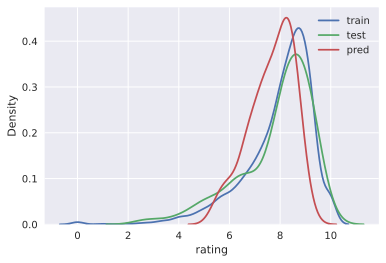

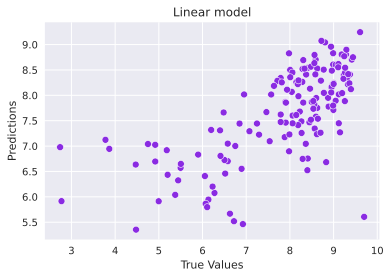

In [56]:
target_distr_linear(y_train, y_test, y_pred)

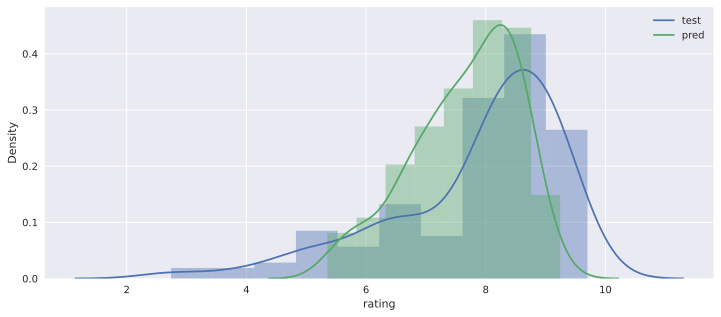

In [57]:
def draw_target_distr(y_test, y_pred, save_fig=False):
    plt.figure(figsize=(12, 5))
    sns.distplot(y_test)
    sns.distplot(y_pred)
    plt.legend(['test', 'pred'])
    plt.savefig('./okko_ratings_test_pred_oscr_kws')
    plt.show()

draw_target_distr(y_test, y_pred)

IMP: [9.03942856e+00 4.94012290e+00 1.59204753e+01 1.10403493e+00
 2.20395737e-01 6.79559210e-01 1.41529424e+00 1.68498482e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.54731094e-02
 2.67652114e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.50082320e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00]


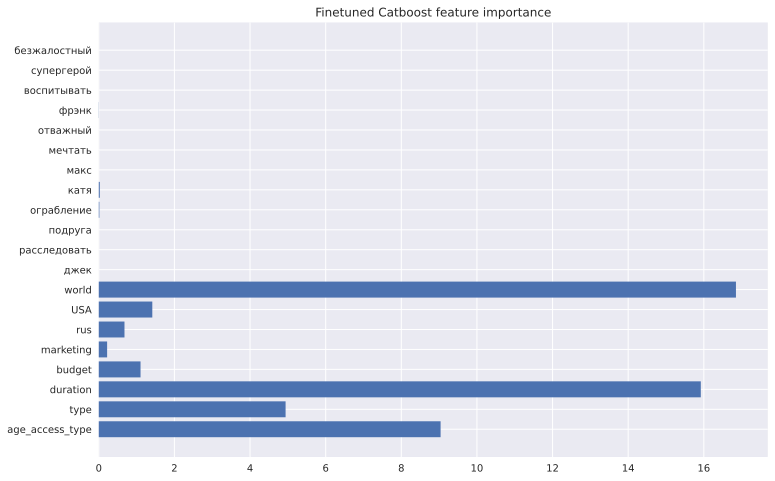

In [58]:
get_feature_imp(best_cat, train_dataset)

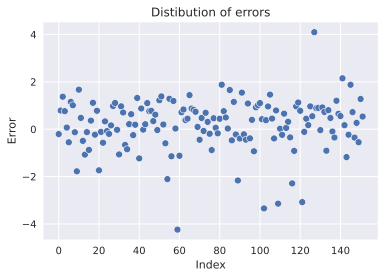

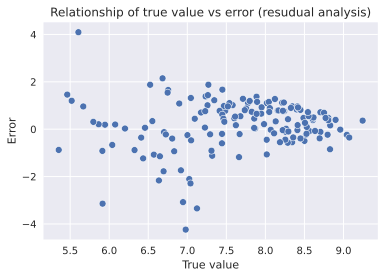

In [59]:
errors = y_test - y_pred
draw_res_analys(errors, y_pred)

In [60]:
calc_metrics(y_test, y_pred)

*** VAL **: 
MSE:   1.1624028516317908
RMSE:  1.0781478802241327
R2:    0.4472515493233298
MAE:   0.8009006244677984
MedAE: 0.678855434313431
------------------------------


In [61]:
test_df['PREDS_tune'] = y_pred.tolist()
test_df

age_access_type                                           name    type  \
10457               18                               Бесконечная ночь  SERIAL   
13                   6                      Пес-самурай и город кошек   MOVIE   
10400               18                               Не оставляй меня  SERIAL   
10399               18                                           Жиза  SERIAL   
4421                16                                  Первая любовь   MOVIE   
...                ...                                            ...     ...   
4630                16                                  Взрывная игра   MOVIE   
10322               18                       На взводе: Битва за UBER  SERIAL   
7698                12                                  Тайна амулета   MOVIE   
10302               18  Власть в ночном городе. Книга четвертая: Сила  SERIAL   
10488                6                                 Истоки футбола  SERIAL   

       release_year   duration                           element_uid  budget  \
10457          2022  16.200597  952bfe32-7504-4ef5-af22-985379d8637f     NaN   
13             2022  15.534700  537ece24-2358-4108-a419-85cfd5952607     NaN   
10400          2022  17.044733  00de4f79-d52d-4d2c-871c-e6e8432cc3df     NaN   
10399          2022  16.751493  4a0406af-66ee-4180-a292-8d3b011b9938     NaN   
4421           2022  15.555977  db683fae-f747-4905-a132-38b4207f82fa     NaN   
...             ...        ...                                   ...     ...   
4630           2022  15.545395  4292d0f1-fbfb-4b4d-8c7c-d54b4b0ef6eb     NaN   
10322          2022  16.064695  fecde143-2a72-4a70-8efc-188079a62f1a     NaN   
7698           2022  15.545395  9ae35927-93e3-4a40-870f-a998abbeaa9f     NaN   
10302          2022  16.495161  2fe0e352-1706-4e22-89d2-745353650492     NaN   
10488          2022  17.518293  6dd86e60-5d6d-475d-9b46-e989ac7a30b6     NaN   

       marketing        rus  USA  ...         producer_4           writer_0  \
10457        NaN        NaN  NaN  ...         Лоран Анон        Давид Перро   
13           NaN        NaN  NaN  ...          Адам Нэгл  Роберт Бен Гарант   
10400        NaN        NaN  NaN  ...                 Na    Леонардо Фазоли   
10399        NaN        NaN  NaN  ...  Дмитрий Агневский   Александр Пронин   
4421         NaN        NaN  NaN  ...  Чарльз Артур Берг      А.Дж. Эдвардс   
...          ...        ...  ...  ...                ...                ...   
4630         NaN        NaN  NaN  ...        Гари Раскин      Леон Лангфорд   
10322        NaN        NaN  NaN  ...        Стивен Шифф  Брайан Коппельман   
7698         NaN  12.057422  NaN  ...                 Na  Ксения Набойченко   
10302        NaN        NaN  NaN  ...       Эль Трайдман         Аарон Карю   
10488        NaN        NaN  NaN  ...                 Na           Ши Чуань   

                writer_1  country_0                               genre_0  \
10457   Эммануэль Вуазен    belgium  9fa28b61-a257-4a3e-945b-a9ef76a146d6   
13           Нэйт Хоппер        usa                                Action   
10400  Маддалена Равальи      italy  364fdc2e-bdfe-40be-b2c5-d30f43ec432e   
10399                 Na     russia                                 Drama   
4421                  Na        usa                             Melodrama   
...                  ...        ...                                   ...   
4630        Коллин Уоттс        usa                              Thriller   
10322        Дэвид Левин        usa                                 Drama   
7698        Ирина Демина     russia                                Family   
10302        Кортни Кемп        usa                                 Drama   
10488                 Na      china  287a1485-7a88-4c2f-bc94-ca418b6c47a1   

                                    genre_1  genre_2     PREDS    TARGET  \
10457                                    Na       Na  7.878792  7.462687   
13                                   Comedy   F